Epoch 0, loss: 20240.895
Epoch 1, loss: 19656.439
Epoch 2, loss: 19090.626
Epoch 3, loss: 18544.419
Epoch 4, loss: 18018.755
Epoch 5, loss: 17511.964
Epoch 6, loss: 17021.781
Epoch 7, loss: 16550.139
Epoch 8, loss: 16095.518
Epoch 9, loss: 15656.205
Epoch 10, loss: 15232.362
Epoch 11, loss: 14824.102
Epoch 12, loss: 14429.279
Epoch 13, loss: 14048.042
Epoch 14, loss: 13680.636
Epoch 15, loss: 13325.577
Epoch 16, loss: 12983.274
Epoch 17, loss: 12652.277
Epoch 18, loss: 12332.916
Epoch 19, loss: 12024.647
Epoch 20, loss: 11726.784
Epoch 21, loss: 11439.562
Epoch 22, loss: 11161.911
Epoch 23, loss: 10894.011
Epoch 24, loss: 10635.138
Epoch 25, loss: 10384.996
Epoch 26, loss: 10143.748
Epoch 27, loss: 9910.670
Epoch 28, loss: 9685.596
Epoch 29, loss: 9468.109
Epoch 30, loss: 9258.313
Epoch 31, loss: 9055.428
Epoch 32, loss: 8859.522
Epoch 33, loss: 8670.205
Epoch 34, loss: 8487.205
Epoch 35, loss: 8310.352
Epoch 36, loss: 8139.582
Epoch 37, loss: 7974.459
Epoch 38, loss: 7814.744
Epoch 39

AttributeError: 'Namespace' object has no attribute 'model'

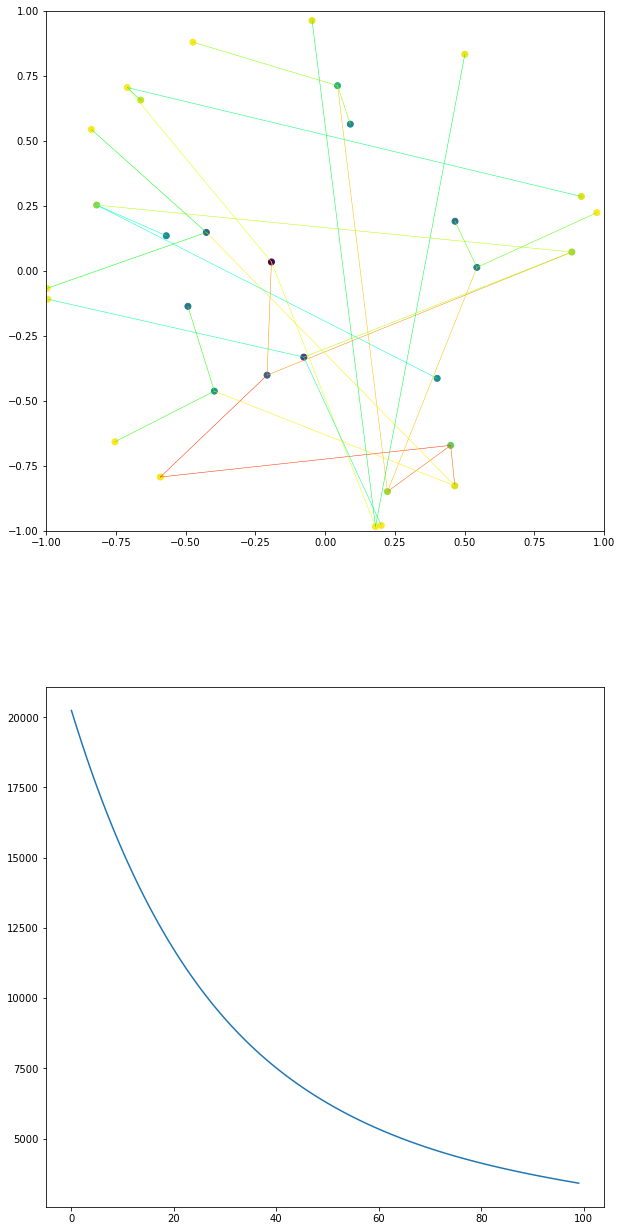

In [2]:
import argparse

import torch
#import wandb

from OdorDataset import OdorMonoDataset
from utils.helpers import *
from methods import *
from optimizers import *
from torch.utils.data import DataLoader
from utils.visulization import *
import uuid
from utils.helpers import set_seeds
import scipy
def hasone(node_index, dim_index):
    bin_i, bin_j = np.binary_repr(node_index), np.binary_repr(dim_index)
    length = len(bin_j)
    return (bin_i[:length] == bin_j) * 1


def get_tree_data(depth, dtype=np.float32):
    n = 2 ** depth - 1
    x = np.fromfunction(lambda i, j: np.vectorize(hasone)(i + 1, j + 1),
                        (n, n), dtype=np.int32).astype(dtype)
    # print(x.shape)
    return x

import sys
if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = sys.argv[:1]

#def main():

if __name__ == "__main__":
    # add arguments


    # wandb.init(project='hyperbolic_smell')
    # wandb.config = args

    # args = wandb.config
    # args.random_string = uuid.uuid4().hex

    # plt.savefig(f"figs2/{args.depth}/{args.latent_dist_fun}/{args.normalize}/{args.model_name}/{args.optimizer}/{args.lr}/{args.temperature}/{args.random_string}_{args.num_epochs}_{args.seed}_{args.dataset_name}.png")

    parser = argparse.ArgumentParser('Hyperbolic Smell')
    parser.add_argument('--representation_name', type=str, default='molformer')
    parser.add_argument('--batch_size', type=int, default=2048)
    parser.add_argument('--num_epochs', type=int, default=100)
    parser.add_argument('--min_dist', type=float, default=1.)
    parser.add_argument('--latent_dim', type=int, default=2)
    parser.add_argument('--lr', type=float, default=0.001)
    parser.add_argument('--seed', type=int, default=2025)
    parser.add_argument('--base_dir', type=str,
                        default='../../../T5 EVO/alignment_olfaction_datasets/curated_datasets/')

    parser.add_argument('--dataset_name', type=str, default='tree')
    parser.add_argument('--normalize', type=bool, default=True)
    parser.add_argument('--optimizer', type=str, default='poincare', choices=['standard', 'poincare'])
    parser.add_argument('--model_name', type=str, default='contrastive', choices=['isomap', 'mds', 'contrastive'])
    parser.add_argument('--latent_dist_fun', type=str, default='poincare', choices=['euclidean', 'poincare'])
    parser.add_argument('--distance_method', type=str, default='hamming', choices=['geo', 'graph', 'hamming'])
    parser.add_argument('--n_samples', type=int, default=200)
    parser.add_argument('--dim', type=int, default=768)
    parser.add_argument('--depth', type=bool, default=5)
    parser.add_argument('--temperature', type=float, default=0.9)
    # args = argparse.Namespace()
    args = parser.parse_args()
    dataset_name = args.dataset_name
    representation_name = args.representation_name
    num_epochs = args.num_epochs
    normalize = args.normalize
    # geodesic = args.geodesic
    # min_dist = args.min_dist
    latent_dim = args.latent_dim
    lr = args.lr
    seed = args.seed
    base_dir = args.base_dir
    optimizer = args.optimizer
    model_name = args.model_name
    latent_dist_fun = args.latent_dist_fun
    distance_method = args.distance_method
    # n_samples = args.n_samples
    # dim = args.dim
    depth = args.depth
    temperature = args.temperature

    ### Overwrite the batchsize ###
    args.batch_size = 2 ** args.depth - 1 #to get full batch
    batch_size = args.batch_size
    
    args.random_string = uuid.uuid4().hex
    set_seeds(seed)


    if dataset_name == 'tree':
        embeddings = get_tree_data(depth)
        ## binary_tree is a dataset of binary sequences.
        ## The root of the tree is the node 0: binary_tree[0]
        ## groundtruth distance from node i to the root of the tree (i.e. shortest path distance from node i to the root): hamming_distance(binary_tree[0], binary_tree[i])
        ## For visualizations, one can color a node by its groundtruth distance to the tree.
    elif dataset_name == 'random':
        embeddings  = torch.randn(n_samples, dim)
    else:
        input_embeddings = f'embeddings/{representation_name}/{dataset_name}_{representation_name}_embeddings_13_Apr17.csv'
        embeddings = read_embeddings(base_dir, select_descriptors(dataset_name), input_embeddings, grand_avg=True if dataset_name == 'keller' else False)
    dataset = OdorMonoDataset(embeddings, transform=None)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    if latent_dist_fun != 'euclidean' and latent_dist_fun != 'poincare':
        raise ValueError('Latent distance function not recognized')
    if model_name == 'isomap':
        model = Isomap(len(dataset), latent_dim, Euclidean if latent_dist_fun == 'euclidean' else Poincare)
    elif model_name == 'mds':
        model = MDS(len(dataset), latent_dim, Euclidean if latent_dist_fun == 'euclidean' else Poincare)
    elif model_name == 'contrastive':
        model = Contrastive(len(dataset), latent_dim, Euclidean if latent_dist_fun == 'euclidean' else Poincare)
    else:
        raise ValueError('Model not recognized')
    if optimizer == 'standard':
        optimizer = StandardOptim(model, lr=lr)
    elif optimizer == 'poincare':
        optimizer = PoincareOptim(model, lr=lr)
    else:
        raise ValueError('Optimizer not recognized')
    losses = []
    # wandb.watch(model)
    for i in range(num_epochs):
        total_loss=0
        for idx, batch in data_loader:
            if normalize:
                model.normalize()
            if distance_method == 'graph':
                data_nn_matrix = nngraph_distance(batch,n_neighbors=3,metric='minkowski')
                # print(data_nn_matrix)
                data_dist_matrix = (data_nn_matrix > 0).astype(int)
                data_dist_matrix = torch.tensor(data_dist_matrix)
                # print(data_dist_matrix)
            elif distance_method == 'geo':
                data_dist_matrix = geo_distance(batch)
            elif distance_method == 'hamming':
                data_dist_matrix = hamming_distance_matrix(batch)
                if model_name == 'contrastive':
                    data_binary_dist_matrix = (data_dist_matrix <= 1.01).astype(int)
                    data_binary_dist_matrix = torch.tensor(data_binary_dist_matrix)
                data_dist_matrix = torch.tensor(data_dist_matrix)
            else:
                data_dist_matrix = dist_matrix(batch, Euclidean)
            # if geodesic:
            #     data_dist_matrix = geo_distance(batch)
            # else:
            #     data_dist_matrix = dist_matrix(batch, Euclidean)
            #binary matrix
            optimizer.zero_grad()
            loss = model.loss_fun(data_dist_matrix,idx, data_binary_dist_matrix, temperature)
            loss.backward()
            optimizer.step(idx)
            total_loss += loss.item()
        print(f'Epoch {i}, loss: {total_loss / len(data_loader):.3f}')
        losses.append(total_loss/len(data_loader))
        # wandb.log({'loss': total_loss/len(data_loader)})
            # print('norms', vector_norm(model.embeddings, dim=-1).mean().item(), vector_norm(model.embeddings, dim=-1).max().item())
        # if i % 10 == 0:


        # laten_embeddings_norm= torch.norm(model.embeddings, dim=-1).cpu().detach().numpy()
        # e=scipy.spatial.distance.cdist(data_loader.dataset.embeddings, data_loader.dataset.embeddings, metric='hamming')*data_loader.dataset.embeddings.shape[-1]
        # scatterplot_2d(losses, model.embeddings.detach().cpu().numpy(), laten_embeddings_norm, args=args, data_dist_matrix=e)
    scatterplot_2d(losses, model.embeddings,dataset.embeddings, args=args)

#

Epoch 0, loss: 20240.895
Epoch 1, loss: 19656.439
Epoch 2, loss: 19090.626
Epoch 3, loss: 18544.419
Epoch 4, loss: 18018.755
Epoch 5, loss: 17511.964
Epoch 6, loss: 17021.781
Epoch 7, loss: 16550.139
Epoch 8, loss: 16095.518
Epoch 9, loss: 15656.205
Epoch 10, loss: 15232.362
Epoch 11, loss: 14824.102
Epoch 12, loss: 14429.279
Epoch 13, loss: 14048.042
Epoch 14, loss: 13680.636
Epoch 15, loss: 13325.577
Epoch 16, loss: 12983.274
Epoch 17, loss: 12652.277
Epoch 18, loss: 12332.916
Epoch 19, loss: 12024.647
Epoch 20, loss: 11726.784
Epoch 21, loss: 11439.562
Epoch 22, loss: 11161.911
Epoch 23, loss: 10894.011
Epoch 24, loss: 10635.138
Epoch 25, loss: 10384.996
Epoch 26, loss: 10143.748
Epoch 27, loss: 9910.670
Epoch 28, loss: 9685.596
Epoch 29, loss: 9468.109
Epoch 30, loss: 9258.313
Epoch 31, loss: 9055.428
Epoch 32, loss: 8859.522
Epoch 33, loss: 8670.205
Epoch 34, loss: 8487.205
Epoch 35, loss: 8310.352
Epoch 36, loss: 8139.582
Epoch 37, loss: 7974.459
Epoch 38, loss: 7814.744
Epoch 39

Epoch 398, loss: 833.105
Epoch 399, loss: 831.643
Epoch 400, loss: 830.188
Epoch 401, loss: 828.746
Epoch 402, loss: 827.323
Epoch 403, loss: 825.913
Epoch 404, loss: 824.511
Epoch 405, loss: 823.124
Epoch 406, loss: 821.743
Epoch 407, loss: 820.382
Epoch 408, loss: 819.034
Epoch 409, loss: 817.694
Epoch 410, loss: 816.367
Epoch 411, loss: 815.054
Epoch 412, loss: 813.748
Epoch 413, loss: 812.459
Epoch 414, loss: 811.180
Epoch 415, loss: 809.913
Epoch 416, loss: 808.655
Epoch 417, loss: 807.405
Epoch 418, loss: 806.166
Epoch 419, loss: 804.947
Epoch 420, loss: 803.738
Epoch 421, loss: 802.536
Epoch 422, loss: 801.344
Epoch 423, loss: 800.161
Epoch 424, loss: 798.993
Epoch 425, loss: 797.834
Epoch 426, loss: 796.686
Epoch 427, loss: 795.550
Epoch 428, loss: 794.421
Epoch 429, loss: 793.300
Epoch 430, loss: 792.191
Epoch 431, loss: 791.095
Epoch 432, loss: 790.003
Epoch 433, loss: 788.926
Epoch 434, loss: 787.857
Epoch 435, loss: 786.799
Epoch 436, loss: 785.752
Epoch 437, loss: 784.707


AttributeError: 'Namespace' object has no attribute 'model'

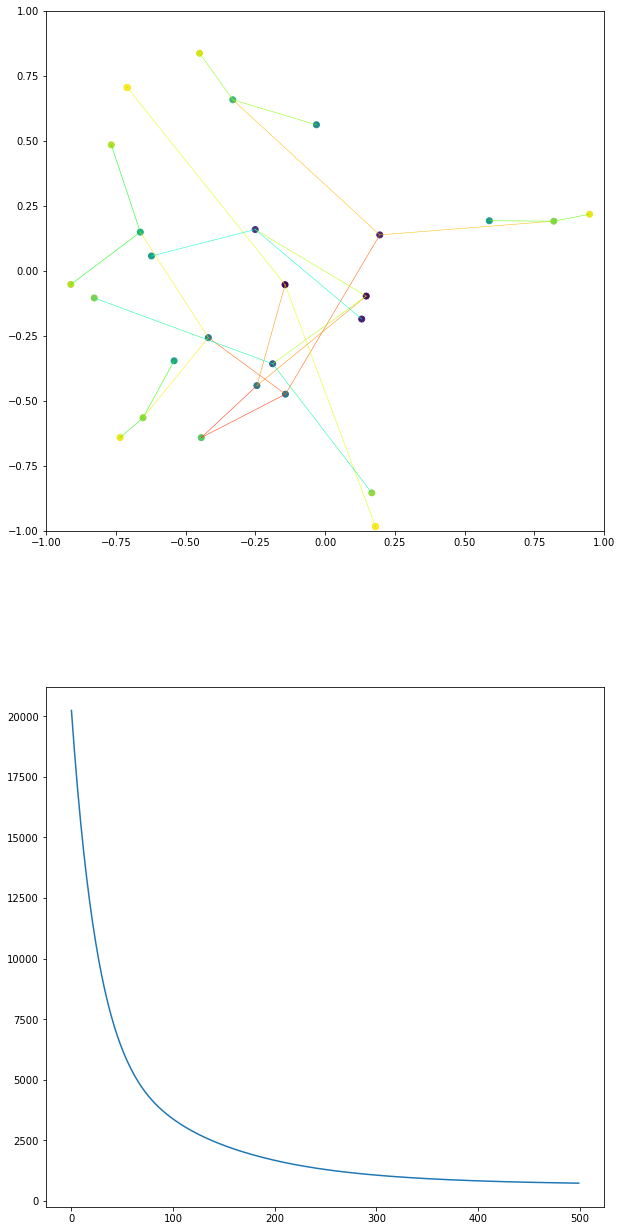

In [3]:
import argparse

import torch
#import wandb

from OdorDataset import OdorMonoDataset
from utils.helpers import *
from methods import *
from optimizers import *
from torch.utils.data import DataLoader
from utils.visulization import *
import uuid
from utils.helpers import set_seeds
import scipy
def hasone(node_index, dim_index):
    bin_i, bin_j = np.binary_repr(node_index), np.binary_repr(dim_index)
    length = len(bin_j)
    return (bin_i[:length] == bin_j) * 1


def get_tree_data(depth, dtype=np.float32):
    n = 2 ** depth - 1
    x = np.fromfunction(lambda i, j: np.vectorize(hasone)(i + 1, j + 1),
                        (n, n), dtype=np.int32).astype(dtype)
    # print(x.shape)
    return x

import sys
if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = sys.argv[:1]

#def main():

if __name__ == "__main__":
    # add arguments


    # wandb.init(project='hyperbolic_smell')
    # wandb.config = args

    # args = wandb.config
    # args.random_string = uuid.uuid4().hex

    # plt.savefig(f"figs2/{args.depth}/{args.latent_dist_fun}/{args.normalize}/{args.model_name}/{args.optimizer}/{args.lr}/{args.temperature}/{args.random_string}_{args.num_epochs}_{args.seed}_{args.dataset_name}.png")

    parser = argparse.ArgumentParser('Hyperbolic Smell')
    parser.add_argument('--representation_name', type=str, default='molformer')
    parser.add_argument('--batch_size', type=int, default=2048)
    parser.add_argument('--num_epochs', type=int, default=500)
    parser.add_argument('--min_dist', type=float, default=1.)
    parser.add_argument('--latent_dim', type=int, default=2)
    parser.add_argument('--lr', type=float, default=0.001)
    parser.add_argument('--seed', type=int, default=2025)
    parser.add_argument('--base_dir', type=str,
                        default='../../../T5 EVO/alignment_olfaction_datasets/curated_datasets/')

    parser.add_argument('--dataset_name', type=str, default='tree')
    parser.add_argument('--normalize', type=bool, default=True)
    parser.add_argument('--optimizer', type=str, default='poincare', choices=['standard', 'poincare'])
    parser.add_argument('--model_name', type=str, default='contrastive', choices=['isomap', 'mds', 'contrastive'])
    parser.add_argument('--latent_dist_fun', type=str, default='poincare', choices=['euclidean', 'poincare'])
    parser.add_argument('--distance_method', type=str, default='hamming', choices=['geo', 'graph', 'hamming'])
    parser.add_argument('--n_samples', type=int, default=200)
    parser.add_argument('--dim', type=int, default=768)
    parser.add_argument('--depth', type=bool, default=5)
    parser.add_argument('--temperature', type=float, default=0.9)
    # args = argparse.Namespace()
    args = parser.parse_args()
    dataset_name = args.dataset_name
    representation_name = args.representation_name
    num_epochs = args.num_epochs
    normalize = args.normalize
    # geodesic = args.geodesic
    # min_dist = args.min_dist
    latent_dim = args.latent_dim
    lr = args.lr
    seed = args.seed
    base_dir = args.base_dir
    optimizer = args.optimizer
    model_name = args.model_name
    latent_dist_fun = args.latent_dist_fun
    distance_method = args.distance_method
    # n_samples = args.n_samples
    # dim = args.dim
    depth = args.depth
    temperature = args.temperature

    ### Overwrite the batchsize ###
    args.batch_size = 2 ** args.depth - 1 #to get full batch
    batch_size = args.batch_size
    
    args.random_string = uuid.uuid4().hex
    set_seeds(seed)


    if dataset_name == 'tree':
        embeddings = get_tree_data(depth)
        ## binary_tree is a dataset of binary sequences.
        ## The root of the tree is the node 0: binary_tree[0]
        ## groundtruth distance from node i to the root of the tree (i.e. shortest path distance from node i to the root): hamming_distance(binary_tree[0], binary_tree[i])
        ## For visualizations, one can color a node by its groundtruth distance to the tree.
    elif dataset_name == 'random':
        embeddings  = torch.randn(n_samples, dim)
    else:
        input_embeddings = f'embeddings/{representation_name}/{dataset_name}_{representation_name}_embeddings_13_Apr17.csv'
        embeddings = read_embeddings(base_dir, select_descriptors(dataset_name), input_embeddings, grand_avg=True if dataset_name == 'keller' else False)
    dataset = OdorMonoDataset(embeddings, transform=None)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    if latent_dist_fun != 'euclidean' and latent_dist_fun != 'poincare':
        raise ValueError('Latent distance function not recognized')
    if model_name == 'isomap':
        model = Isomap(len(dataset), latent_dim, Euclidean if latent_dist_fun == 'euclidean' else Poincare)
    elif model_name == 'mds':
        model = MDS(len(dataset), latent_dim, Euclidean if latent_dist_fun == 'euclidean' else Poincare)
    elif model_name == 'contrastive':
        model = Contrastive(len(dataset), latent_dim, Euclidean if latent_dist_fun == 'euclidean' else Poincare)
    else:
        raise ValueError('Model not recognized')
    if optimizer == 'standard':
        optimizer = StandardOptim(model, lr=lr)
    elif optimizer == 'poincare':
        optimizer = PoincareOptim(model, lr=lr)
    else:
        raise ValueError('Optimizer not recognized')
    losses = []
    # wandb.watch(model)
    for i in range(num_epochs):
        total_loss=0
        for idx, batch in data_loader:
            if normalize:
                model.normalize()
            if distance_method == 'graph':
                data_nn_matrix = nngraph_distance(batch,n_neighbors=3,metric='minkowski')
                # print(data_nn_matrix)
                data_dist_matrix = (data_nn_matrix > 0).astype(int)
                data_dist_matrix = torch.tensor(data_dist_matrix)
                # print(data_dist_matrix)
            elif distance_method == 'geo':
                data_dist_matrix = geo_distance(batch)
            elif distance_method == 'hamming':
                data_dist_matrix = hamming_distance_matrix(batch)
                if model_name == 'contrastive':
                    data_binary_dist_matrix = (data_dist_matrix <= 1.01).astype(int)
                    data_binary_dist_matrix = torch.tensor(data_binary_dist_matrix)
                data_dist_matrix = torch.tensor(data_dist_matrix)
            else:
                data_dist_matrix = dist_matrix(batch, Euclidean)
            # if geodesic:
            #     data_dist_matrix = geo_distance(batch)
            # else:
            #     data_dist_matrix = dist_matrix(batch, Euclidean)
            #binary matrix
            optimizer.zero_grad()
            loss = model.loss_fun(data_dist_matrix,idx, data_binary_dist_matrix, temperature)
            loss.backward()
            optimizer.step(idx)
            total_loss += loss.item()
        print(f'Epoch {i}, loss: {total_loss / len(data_loader):.3f}')
        losses.append(total_loss/len(data_loader))
        # wandb.log({'loss': total_loss/len(data_loader)})
            # print('norms', vector_norm(model.embeddings, dim=-1).mean().item(), vector_norm(model.embeddings, dim=-1).max().item())
        # if i % 10 == 0:


        # laten_embeddings_norm= torch.norm(model.embeddings, dim=-1).cpu().detach().numpy()
        # e=scipy.spatial.distance.cdist(data_loader.dataset.embeddings, data_loader.dataset.embeddings, metric='hamming')*data_loader.dataset.embeddings.shape[-1]
        # scatterplot_2d(losses, model.embeddings.detach().cpu().numpy(), laten_embeddings_norm, args=args, data_dist_matrix=e)
    scatterplot_2d(losses, model.embeddings,dataset.embeddings, args=args)

#

Epoch 0, loss: 20240.895
Epoch 1, loss: 19656.439
Epoch 2, loss: 19090.626
Epoch 3, loss: 18544.419
Epoch 4, loss: 18018.755
Epoch 5, loss: 17511.964
Epoch 6, loss: 17021.781
Epoch 7, loss: 16550.139
Epoch 8, loss: 16095.518
Epoch 9, loss: 15656.205
Epoch 10, loss: 15232.362
Epoch 11, loss: 14824.102
Epoch 12, loss: 14429.279
Epoch 13, loss: 14048.042
Epoch 14, loss: 13680.636
Epoch 15, loss: 13325.577
Epoch 16, loss: 12983.274
Epoch 17, loss: 12652.277
Epoch 18, loss: 12332.916
Epoch 19, loss: 12024.647
Epoch 20, loss: 11726.784
Epoch 21, loss: 11439.562
Epoch 22, loss: 11161.911
Epoch 23, loss: 10894.011
Epoch 24, loss: 10635.138
Epoch 25, loss: 10384.996
Epoch 26, loss: 10143.748
Epoch 27, loss: 9910.670
Epoch 28, loss: 9685.596
Epoch 29, loss: 9468.109
Epoch 30, loss: 9258.313
Epoch 31, loss: 9055.428
Epoch 32, loss: 8859.522
Epoch 33, loss: 8670.205
Epoch 34, loss: 8487.205
Epoch 35, loss: 8310.352
Epoch 36, loss: 8139.582
Epoch 37, loss: 7974.459
Epoch 38, loss: 7814.744
Epoch 39

Epoch 398, loss: 833.105
Epoch 399, loss: 831.643
Epoch 400, loss: 830.188
Epoch 401, loss: 828.746
Epoch 402, loss: 827.323
Epoch 403, loss: 825.913
Epoch 404, loss: 824.511
Epoch 405, loss: 823.124
Epoch 406, loss: 821.743
Epoch 407, loss: 820.382
Epoch 408, loss: 819.034
Epoch 409, loss: 817.694
Epoch 410, loss: 816.367
Epoch 411, loss: 815.054
Epoch 412, loss: 813.748
Epoch 413, loss: 812.459
Epoch 414, loss: 811.180
Epoch 415, loss: 809.913
Epoch 416, loss: 808.655
Epoch 417, loss: 807.405
Epoch 418, loss: 806.166
Epoch 419, loss: 804.947
Epoch 420, loss: 803.738
Epoch 421, loss: 802.536
Epoch 422, loss: 801.344
Epoch 423, loss: 800.161
Epoch 424, loss: 798.993
Epoch 425, loss: 797.834
Epoch 426, loss: 796.686
Epoch 427, loss: 795.550
Epoch 428, loss: 794.421
Epoch 429, loss: 793.300
Epoch 430, loss: 792.191
Epoch 431, loss: 791.095
Epoch 432, loss: 790.003
Epoch 433, loss: 788.926
Epoch 434, loss: 787.857
Epoch 435, loss: 786.799
Epoch 436, loss: 785.752
Epoch 437, loss: 784.707


Epoch 898, loss: 668.263
Epoch 899, loss: 668.242
Epoch 900, loss: 668.221
Epoch 901, loss: 668.201
Epoch 902, loss: 668.180
Epoch 903, loss: 668.160
Epoch 904, loss: 668.139
Epoch 905, loss: 668.119
Epoch 906, loss: 668.099
Epoch 907, loss: 668.079
Epoch 908, loss: 668.059
Epoch 909, loss: 668.039
Epoch 910, loss: 668.019
Epoch 911, loss: 667.999
Epoch 912, loss: 667.979
Epoch 913, loss: 667.960
Epoch 914, loss: 667.940
Epoch 915, loss: 667.921
Epoch 916, loss: 667.901
Epoch 917, loss: 667.881
Epoch 918, loss: 667.861
Epoch 919, loss: 667.842
Epoch 920, loss: 667.822
Epoch 921, loss: 667.803
Epoch 922, loss: 667.784
Epoch 923, loss: 667.765
Epoch 924, loss: 667.746
Epoch 925, loss: 667.728
Epoch 926, loss: 667.709
Epoch 927, loss: 667.691
Epoch 928, loss: 667.673
Epoch 929, loss: 667.654
Epoch 930, loss: 667.636
Epoch 931, loss: 667.618
Epoch 932, loss: 667.600
Epoch 933, loss: 667.587
Epoch 934, loss: 667.574
Epoch 935, loss: 667.561
Epoch 936, loss: 667.553
Epoch 937, loss: 667.544


AttributeError: 'Namespace' object has no attribute 'model'

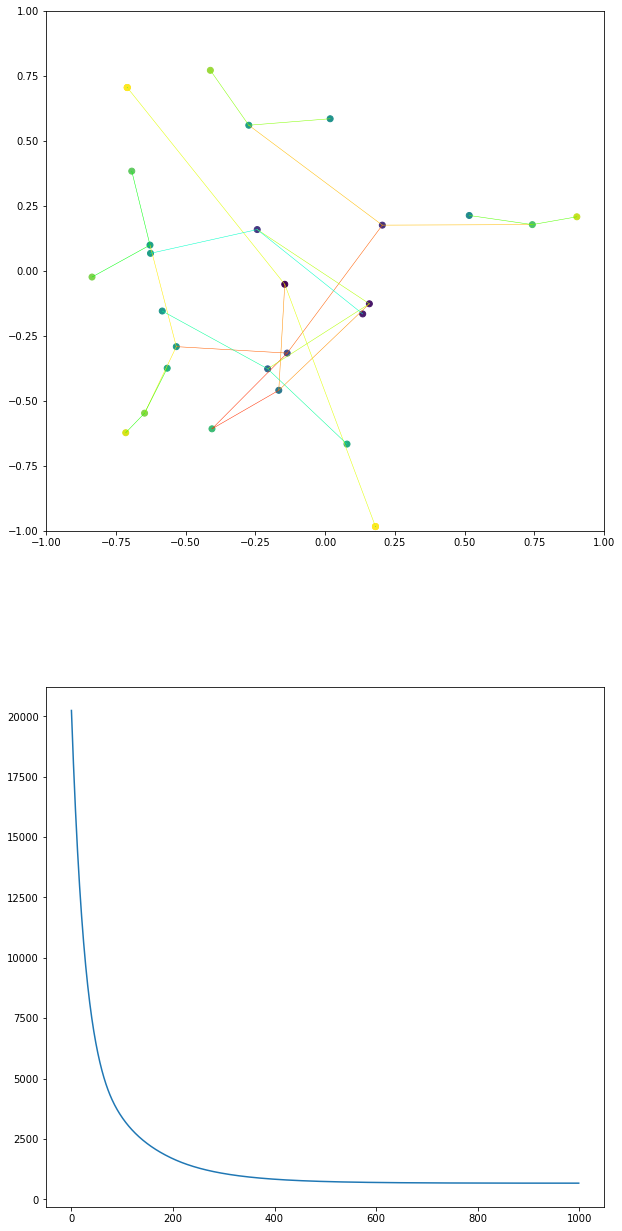

In [4]:
import argparse

import torch
#import wandb

from OdorDataset import OdorMonoDataset
from utils.helpers import *
from methods import *
from optimizers import *
from torch.utils.data import DataLoader
from utils.visulization import *
import uuid
from utils.helpers import set_seeds
import scipy
def hasone(node_index, dim_index):
    bin_i, bin_j = np.binary_repr(node_index), np.binary_repr(dim_index)
    length = len(bin_j)
    return (bin_i[:length] == bin_j) * 1


def get_tree_data(depth, dtype=np.float32):
    n = 2 ** depth - 1
    x = np.fromfunction(lambda i, j: np.vectorize(hasone)(i + 1, j + 1),
                        (n, n), dtype=np.int32).astype(dtype)
    # print(x.shape)
    return x

import sys
if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = sys.argv[:1]

#def main():

if __name__ == "__main__":
    # add arguments


    # wandb.init(project='hyperbolic_smell')
    # wandb.config = args

    # args = wandb.config
    # args.random_string = uuid.uuid4().hex

    # plt.savefig(f"figs2/{args.depth}/{args.latent_dist_fun}/{args.normalize}/{args.model_name}/{args.optimizer}/{args.lr}/{args.temperature}/{args.random_string}_{args.num_epochs}_{args.seed}_{args.dataset_name}.png")

    parser = argparse.ArgumentParser('Hyperbolic Smell')
    parser.add_argument('--representation_name', type=str, default='molformer')
    parser.add_argument('--batch_size', type=int, default=2048)
    parser.add_argument('--num_epochs', type=int, default=1000)
    parser.add_argument('--min_dist', type=float, default=1.)
    parser.add_argument('--latent_dim', type=int, default=2)
    parser.add_argument('--lr', type=float, default=0.001)
    parser.add_argument('--seed', type=int, default=2025)
    parser.add_argument('--base_dir', type=str,
                        default='../../../T5 EVO/alignment_olfaction_datasets/curated_datasets/')

    parser.add_argument('--dataset_name', type=str, default='tree')
    parser.add_argument('--normalize', type=bool, default=True)
    parser.add_argument('--optimizer', type=str, default='poincare', choices=['standard', 'poincare'])
    parser.add_argument('--model_name', type=str, default='contrastive', choices=['isomap', 'mds', 'contrastive'])
    parser.add_argument('--latent_dist_fun', type=str, default='poincare', choices=['euclidean', 'poincare'])
    parser.add_argument('--distance_method', type=str, default='hamming', choices=['geo', 'graph', 'hamming'])
    parser.add_argument('--n_samples', type=int, default=200)
    parser.add_argument('--dim', type=int, default=768)
    parser.add_argument('--depth', type=bool, default=5)
    parser.add_argument('--temperature', type=float, default=0.9)
    # args = argparse.Namespace()
    args = parser.parse_args()
    dataset_name = args.dataset_name
    representation_name = args.representation_name
    num_epochs = args.num_epochs
    normalize = args.normalize
    # geodesic = args.geodesic
    # min_dist = args.min_dist
    latent_dim = args.latent_dim
    lr = args.lr
    seed = args.seed
    base_dir = args.base_dir
    optimizer = args.optimizer
    model_name = args.model_name
    latent_dist_fun = args.latent_dist_fun
    distance_method = args.distance_method
    # n_samples = args.n_samples
    # dim = args.dim
    depth = args.depth
    temperature = args.temperature

    ### Overwrite the batchsize ###
    args.batch_size = 2 ** args.depth - 1 #to get full batch
    batch_size = args.batch_size
    
    args.random_string = uuid.uuid4().hex
    set_seeds(seed)


    if dataset_name == 'tree':
        embeddings = get_tree_data(depth)
        ## binary_tree is a dataset of binary sequences.
        ## The root of the tree is the node 0: binary_tree[0]
        ## groundtruth distance from node i to the root of the tree (i.e. shortest path distance from node i to the root): hamming_distance(binary_tree[0], binary_tree[i])
        ## For visualizations, one can color a node by its groundtruth distance to the tree.
    elif dataset_name == 'random':
        embeddings  = torch.randn(n_samples, dim)
    else:
        input_embeddings = f'embeddings/{representation_name}/{dataset_name}_{representation_name}_embeddings_13_Apr17.csv'
        embeddings = read_embeddings(base_dir, select_descriptors(dataset_name), input_embeddings, grand_avg=True if dataset_name == 'keller' else False)
    dataset = OdorMonoDataset(embeddings, transform=None)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    if latent_dist_fun != 'euclidean' and latent_dist_fun != 'poincare':
        raise ValueError('Latent distance function not recognized')
    if model_name == 'isomap':
        model = Isomap(len(dataset), latent_dim, Euclidean if latent_dist_fun == 'euclidean' else Poincare)
    elif model_name == 'mds':
        model = MDS(len(dataset), latent_dim, Euclidean if latent_dist_fun == 'euclidean' else Poincare)
    elif model_name == 'contrastive':
        model = Contrastive(len(dataset), latent_dim, Euclidean if latent_dist_fun == 'euclidean' else Poincare)
    else:
        raise ValueError('Model not recognized')
    if optimizer == 'standard':
        optimizer = StandardOptim(model, lr=lr)
    elif optimizer == 'poincare':
        optimizer = PoincareOptim(model, lr=lr)
    else:
        raise ValueError('Optimizer not recognized')
    losses = []
    # wandb.watch(model)
    for i in range(num_epochs):
        total_loss=0
        for idx, batch in data_loader:
            if normalize:
                model.normalize()
            if distance_method == 'graph':
                data_nn_matrix = nngraph_distance(batch,n_neighbors=3,metric='minkowski')
                # print(data_nn_matrix)
                data_dist_matrix = (data_nn_matrix > 0).astype(int)
                data_dist_matrix = torch.tensor(data_dist_matrix)
                # print(data_dist_matrix)
            elif distance_method == 'geo':
                data_dist_matrix = geo_distance(batch)
            elif distance_method == 'hamming':
                data_dist_matrix = hamming_distance_matrix(batch)
                if model_name == 'contrastive':
                    data_binary_dist_matrix = (data_dist_matrix <= 1.01).astype(int)
                    data_binary_dist_matrix = torch.tensor(data_binary_dist_matrix)
                data_dist_matrix = torch.tensor(data_dist_matrix)
            else:
                data_dist_matrix = dist_matrix(batch, Euclidean)
            # if geodesic:
            #     data_dist_matrix = geo_distance(batch)
            # else:
            #     data_dist_matrix = dist_matrix(batch, Euclidean)
            #binary matrix
            optimizer.zero_grad()
            loss = model.loss_fun(data_dist_matrix,idx, data_binary_dist_matrix, temperature)
            loss.backward()
            optimizer.step(idx)
            total_loss += loss.item()
        print(f'Epoch {i}, loss: {total_loss / len(data_loader):.3f}')
        losses.append(total_loss/len(data_loader))
        # wandb.log({'loss': total_loss/len(data_loader)})
            # print('norms', vector_norm(model.embeddings, dim=-1).mean().item(), vector_norm(model.embeddings, dim=-1).max().item())
        # if i % 10 == 0:


        # laten_embeddings_norm= torch.norm(model.embeddings, dim=-1).cpu().detach().numpy()
        # e=scipy.spatial.distance.cdist(data_loader.dataset.embeddings, data_loader.dataset.embeddings, metric='hamming')*data_loader.dataset.embeddings.shape[-1]
        # scatterplot_2d(losses, model.embeddings.detach().cpu().numpy(), laten_embeddings_norm, args=args, data_dist_matrix=e)
    scatterplot_2d(losses, model.embeddings,dataset.embeddings, args=args)

#

Epoch 0, loss: 20240.895
Epoch 1, loss: 19656.439
Epoch 2, loss: 19090.626
Epoch 3, loss: 18544.419
Epoch 4, loss: 18018.755
Epoch 5, loss: 17511.964
Epoch 6, loss: 17021.781
Epoch 7, loss: 16550.139
Epoch 8, loss: 16095.518
Epoch 9, loss: 15656.205
Epoch 10, loss: 15232.362
Epoch 11, loss: 14824.102
Epoch 12, loss: 14429.279
Epoch 13, loss: 14048.042
Epoch 14, loss: 13680.636
Epoch 15, loss: 13325.577
Epoch 16, loss: 12983.274
Epoch 17, loss: 12652.277
Epoch 18, loss: 12332.916
Epoch 19, loss: 12024.647
Epoch 20, loss: 11726.784
Epoch 21, loss: 11439.562
Epoch 22, loss: 11161.911
Epoch 23, loss: 10894.011
Epoch 24, loss: 10635.138
Epoch 25, loss: 10384.996
Epoch 26, loss: 10143.748
Epoch 27, loss: 9910.670
Epoch 28, loss: 9685.596
Epoch 29, loss: 9468.109
Epoch 30, loss: 9258.313
Epoch 31, loss: 9055.428
Epoch 32, loss: 8859.522
Epoch 33, loss: 8670.205
Epoch 34, loss: 8487.205
Epoch 35, loss: 8310.352
Epoch 36, loss: 8139.582
Epoch 37, loss: 7974.459
Epoch 38, loss: 7814.744
Epoch 39

Epoch 358, loss: 904.018
Epoch 359, loss: 901.914
Epoch 360, loss: 899.829
Epoch 361, loss: 897.762
Epoch 362, loss: 895.712
Epoch 363, loss: 893.684
Epoch 364, loss: 891.671
Epoch 365, loss: 889.679
Epoch 366, loss: 887.703
Epoch 367, loss: 885.748
Epoch 368, loss: 883.809
Epoch 369, loss: 881.885
Epoch 370, loss: 879.982
Epoch 371, loss: 878.096
Epoch 372, loss: 876.223
Epoch 373, loss: 874.371
Epoch 374, loss: 872.537
Epoch 375, loss: 870.716
Epoch 376, loss: 868.912
Epoch 377, loss: 867.124
Epoch 378, loss: 865.352
Epoch 379, loss: 863.598
Epoch 380, loss: 861.860
Epoch 381, loss: 860.133
Epoch 382, loss: 858.427
Epoch 383, loss: 856.735
Epoch 384, loss: 855.056
Epoch 385, loss: 853.397
Epoch 386, loss: 851.748
Epoch 387, loss: 850.116
Epoch 388, loss: 848.496
Epoch 389, loss: 846.897
Epoch 390, loss: 845.310
Epoch 391, loss: 843.735
Epoch 392, loss: 842.172
Epoch 393, loss: 840.630
Epoch 394, loss: 839.096
Epoch 395, loss: 837.578
Epoch 396, loss: 836.070
Epoch 397, loss: 834.577


Epoch 710, loss: 677.736
Epoch 711, loss: 677.640
Epoch 712, loss: 677.532
Epoch 713, loss: 677.430
Epoch 714, loss: 677.332
Epoch 715, loss: 677.231
Epoch 716, loss: 677.136
Epoch 717, loss: 677.035
Epoch 718, loss: 676.931
Epoch 719, loss: 676.831
Epoch 720, loss: 676.731
Epoch 721, loss: 676.634
Epoch 722, loss: 676.534
Epoch 723, loss: 676.438
Epoch 724, loss: 676.341
Epoch 725, loss: 676.236
Epoch 726, loss: 676.140
Epoch 727, loss: 676.051
Epoch 728, loss: 675.963
Epoch 729, loss: 675.870
Epoch 730, loss: 675.788
Epoch 731, loss: 675.699
Epoch 732, loss: 675.615
Epoch 733, loss: 675.538
Epoch 734, loss: 675.451
Epoch 735, loss: 675.374
Epoch 736, loss: 675.290
Epoch 737, loss: 675.201
Epoch 738, loss: 675.124
Epoch 739, loss: 675.041
Epoch 740, loss: 674.962
Epoch 741, loss: 674.882
Epoch 742, loss: 674.804
Epoch 743, loss: 674.716
Epoch 744, loss: 674.637
Epoch 745, loss: 674.562
Epoch 746, loss: 674.487
Epoch 747, loss: 674.422
Epoch 748, loss: 674.350
Epoch 749, loss: 674.286


Epoch 1083, loss: 666.626
Epoch 1084, loss: 666.622
Epoch 1085, loss: 666.617
Epoch 1086, loss: 666.612
Epoch 1087, loss: 666.607
Epoch 1088, loss: 666.603
Epoch 1089, loss: 666.598
Epoch 1090, loss: 666.593
Epoch 1091, loss: 666.589
Epoch 1092, loss: 666.584
Epoch 1093, loss: 666.579
Epoch 1094, loss: 666.575
Epoch 1095, loss: 666.570
Epoch 1096, loss: 666.565
Epoch 1097, loss: 666.561
Epoch 1098, loss: 666.556
Epoch 1099, loss: 666.552
Epoch 1100, loss: 666.547
Epoch 1101, loss: 666.543
Epoch 1102, loss: 666.538
Epoch 1103, loss: 666.534
Epoch 1104, loss: 666.529
Epoch 1105, loss: 666.525
Epoch 1106, loss: 666.520
Epoch 1107, loss: 666.516
Epoch 1108, loss: 666.511
Epoch 1109, loss: 666.507
Epoch 1110, loss: 666.503
Epoch 1111, loss: 666.498
Epoch 1112, loss: 666.494
Epoch 1113, loss: 666.489
Epoch 1114, loss: 666.485
Epoch 1115, loss: 666.481
Epoch 1116, loss: 666.476
Epoch 1117, loss: 666.472
Epoch 1118, loss: 666.468
Epoch 1119, loss: 666.464
Epoch 1120, loss: 666.459
Epoch 1121, 

Epoch 1486, loss: 665.495
Epoch 1487, loss: 665.493
Epoch 1488, loss: 665.491
Epoch 1489, loss: 665.490
Epoch 1490, loss: 665.488
Epoch 1491, loss: 665.487
Epoch 1492, loss: 665.485
Epoch 1493, loss: 665.484
Epoch 1494, loss: 665.482
Epoch 1495, loss: 665.481
Epoch 1496, loss: 665.479
Epoch 1497, loss: 665.478
Epoch 1498, loss: 665.476
Epoch 1499, loss: 665.475
Epoch 1500, loss: 665.473
Epoch 1501, loss: 665.472
Epoch 1502, loss: 665.470
Epoch 1503, loss: 665.469
Epoch 1504, loss: 665.467
Epoch 1505, loss: 665.466
Epoch 1506, loss: 665.465
Epoch 1507, loss: 665.463
Epoch 1508, loss: 665.462
Epoch 1509, loss: 665.460
Epoch 1510, loss: 665.459
Epoch 1511, loss: 665.457
Epoch 1512, loss: 665.456
Epoch 1513, loss: 665.454
Epoch 1514, loss: 665.453
Epoch 1515, loss: 665.451
Epoch 1516, loss: 665.450
Epoch 1517, loss: 665.449
Epoch 1518, loss: 665.447
Epoch 1519, loss: 665.446
Epoch 1520, loss: 665.444
Epoch 1521, loss: 665.443
Epoch 1522, loss: 665.442
Epoch 1523, loss: 665.440
Epoch 1524, 

Epoch 1879, loss: 665.114
Epoch 1880, loss: 665.113
Epoch 1881, loss: 665.113
Epoch 1882, loss: 665.112
Epoch 1883, loss: 665.111
Epoch 1884, loss: 665.111
Epoch 1885, loss: 665.110
Epoch 1886, loss: 665.110
Epoch 1887, loss: 665.109
Epoch 1888, loss: 665.109
Epoch 1889, loss: 665.108
Epoch 1890, loss: 665.107
Epoch 1891, loss: 665.107
Epoch 1892, loss: 665.106
Epoch 1893, loss: 665.106
Epoch 1894, loss: 665.105
Epoch 1895, loss: 665.105
Epoch 1896, loss: 665.104
Epoch 1897, loss: 665.104
Epoch 1898, loss: 665.103
Epoch 1899, loss: 665.103
Epoch 1900, loss: 665.102
Epoch 1901, loss: 665.102
Epoch 1902, loss: 665.101
Epoch 1903, loss: 665.100
Epoch 1904, loss: 665.100
Epoch 1905, loss: 665.099
Epoch 1906, loss: 665.099
Epoch 1907, loss: 665.098
Epoch 1908, loss: 665.098
Epoch 1909, loss: 665.097
Epoch 1910, loss: 665.097
Epoch 1911, loss: 665.096
Epoch 1912, loss: 665.096
Epoch 1913, loss: 665.095
Epoch 1914, loss: 665.095
Epoch 1915, loss: 665.094
Epoch 1916, loss: 665.094
Epoch 1917, 

Epoch 2263, loss: 664.972
Epoch 2264, loss: 664.971
Epoch 2265, loss: 664.971
Epoch 2266, loss: 664.971
Epoch 2267, loss: 664.971
Epoch 2268, loss: 664.970
Epoch 2269, loss: 664.970
Epoch 2270, loss: 664.970
Epoch 2271, loss: 664.970
Epoch 2272, loss: 664.969
Epoch 2273, loss: 664.969
Epoch 2274, loss: 664.969
Epoch 2275, loss: 664.969
Epoch 2276, loss: 664.969
Epoch 2277, loss: 664.968
Epoch 2278, loss: 664.968
Epoch 2279, loss: 664.968
Epoch 2280, loss: 664.968
Epoch 2281, loss: 664.967
Epoch 2282, loss: 664.967
Epoch 2283, loss: 664.967
Epoch 2284, loss: 664.967
Epoch 2285, loss: 664.967
Epoch 2286, loss: 664.966
Epoch 2287, loss: 664.966
Epoch 2288, loss: 664.966
Epoch 2289, loss: 664.966
Epoch 2290, loss: 664.965
Epoch 2291, loss: 664.965
Epoch 2292, loss: 664.965
Epoch 2293, loss: 664.965
Epoch 2294, loss: 664.965
Epoch 2295, loss: 664.964
Epoch 2296, loss: 664.964
Epoch 2297, loss: 664.964
Epoch 2298, loss: 664.964
Epoch 2299, loss: 664.964
Epoch 2300, loss: 664.963
Epoch 2301, 

Epoch 2662, loss: 664.907
Epoch 2663, loss: 664.907
Epoch 2664, loss: 664.907
Epoch 2665, loss: 664.907
Epoch 2666, loss: 664.907
Epoch 2667, loss: 664.907
Epoch 2668, loss: 664.906
Epoch 2669, loss: 664.906
Epoch 2670, loss: 664.906
Epoch 2671, loss: 664.906
Epoch 2672, loss: 664.906
Epoch 2673, loss: 664.906
Epoch 2674, loss: 664.906
Epoch 2675, loss: 664.906
Epoch 2676, loss: 664.906
Epoch 2677, loss: 664.905
Epoch 2678, loss: 664.905
Epoch 2679, loss: 664.905
Epoch 2680, loss: 664.905
Epoch 2681, loss: 664.905
Epoch 2682, loss: 664.905
Epoch 2683, loss: 664.905
Epoch 2684, loss: 664.905
Epoch 2685, loss: 664.905
Epoch 2686, loss: 664.904
Epoch 2687, loss: 664.904
Epoch 2688, loss: 664.904
Epoch 2689, loss: 664.904
Epoch 2690, loss: 664.904
Epoch 2691, loss: 664.904
Epoch 2692, loss: 664.904
Epoch 2693, loss: 664.904
Epoch 2694, loss: 664.903
Epoch 2695, loss: 664.903
Epoch 2696, loss: 664.903
Epoch 2697, loss: 664.903
Epoch 2698, loss: 664.903
Epoch 2699, loss: 664.903
Epoch 2700, 

Epoch 3064, loss: 664.871
Epoch 3065, loss: 664.871
Epoch 3066, loss: 664.871
Epoch 3067, loss: 664.871
Epoch 3068, loss: 664.871
Epoch 3069, loss: 664.871
Epoch 3070, loss: 664.871
Epoch 3071, loss: 664.871
Epoch 3072, loss: 664.871
Epoch 3073, loss: 664.871
Epoch 3074, loss: 664.870
Epoch 3075, loss: 664.870
Epoch 3076, loss: 664.870
Epoch 3077, loss: 664.870
Epoch 3078, loss: 664.870
Epoch 3079, loss: 664.870
Epoch 3080, loss: 664.870
Epoch 3081, loss: 664.870
Epoch 3082, loss: 664.870
Epoch 3083, loss: 664.870
Epoch 3084, loss: 664.870
Epoch 3085, loss: 664.870
Epoch 3086, loss: 664.870
Epoch 3087, loss: 664.870
Epoch 3088, loss: 664.869
Epoch 3089, loss: 664.869
Epoch 3090, loss: 664.869
Epoch 3091, loss: 664.869
Epoch 3092, loss: 664.869
Epoch 3093, loss: 664.869
Epoch 3094, loss: 664.869
Epoch 3095, loss: 664.869
Epoch 3096, loss: 664.869
Epoch 3097, loss: 664.869
Epoch 3098, loss: 664.869
Epoch 3099, loss: 664.869
Epoch 3100, loss: 664.869
Epoch 3101, loss: 664.869
Epoch 3102, 

Epoch 3465, loss: 664.845
Epoch 3466, loss: 664.845
Epoch 3467, loss: 664.845
Epoch 3468, loss: 664.845
Epoch 3469, loss: 664.845
Epoch 3470, loss: 664.845
Epoch 3471, loss: 664.845
Epoch 3472, loss: 664.845
Epoch 3473, loss: 664.845
Epoch 3474, loss: 664.845
Epoch 3475, loss: 664.845
Epoch 3476, loss: 664.845
Epoch 3477, loss: 664.844
Epoch 3478, loss: 664.844
Epoch 3479, loss: 664.844
Epoch 3480, loss: 664.844
Epoch 3481, loss: 664.844
Epoch 3482, loss: 664.844
Epoch 3483, loss: 664.844
Epoch 3484, loss: 664.844
Epoch 3485, loss: 664.844
Epoch 3486, loss: 664.844
Epoch 3487, loss: 664.844
Epoch 3488, loss: 664.844
Epoch 3489, loss: 664.844
Epoch 3490, loss: 664.844
Epoch 3491, loss: 664.844
Epoch 3492, loss: 664.844
Epoch 3493, loss: 664.844
Epoch 3494, loss: 664.843
Epoch 3495, loss: 664.843
Epoch 3496, loss: 664.843
Epoch 3497, loss: 664.843
Epoch 3498, loss: 664.843
Epoch 3499, loss: 664.843
Epoch 3500, loss: 664.843
Epoch 3501, loss: 664.843
Epoch 3502, loss: 664.843
Epoch 3503, 

Epoch 3872, loss: 664.822
Epoch 3873, loss: 664.822
Epoch 3874, loss: 664.822
Epoch 3875, loss: 664.822
Epoch 3876, loss: 664.822
Epoch 3877, loss: 664.822
Epoch 3878, loss: 664.822
Epoch 3879, loss: 664.822
Epoch 3880, loss: 664.822
Epoch 3881, loss: 664.822
Epoch 3882, loss: 664.822
Epoch 3883, loss: 664.822
Epoch 3884, loss: 664.822
Epoch 3885, loss: 664.822
Epoch 3886, loss: 664.822
Epoch 3887, loss: 664.822
Epoch 3888, loss: 664.822
Epoch 3889, loss: 664.821
Epoch 3890, loss: 664.821
Epoch 3891, loss: 664.821
Epoch 3892, loss: 664.821
Epoch 3893, loss: 664.821
Epoch 3894, loss: 664.821
Epoch 3895, loss: 664.821
Epoch 3896, loss: 664.821
Epoch 3897, loss: 664.821
Epoch 3898, loss: 664.821
Epoch 3899, loss: 664.821
Epoch 3900, loss: 664.821
Epoch 3901, loss: 664.821
Epoch 3902, loss: 664.821
Epoch 3903, loss: 664.821
Epoch 3904, loss: 664.821
Epoch 3905, loss: 664.821
Epoch 3906, loss: 664.821
Epoch 3907, loss: 664.821
Epoch 3908, loss: 664.820
Epoch 3909, loss: 664.820
Epoch 3910, 

Epoch 4239, loss: 664.803
Epoch 4240, loss: 664.803
Epoch 4241, loss: 664.803
Epoch 4242, loss: 664.803
Epoch 4243, loss: 664.803
Epoch 4244, loss: 664.803
Epoch 4245, loss: 664.803
Epoch 4246, loss: 664.803
Epoch 4247, loss: 664.803
Epoch 4248, loss: 664.803
Epoch 4249, loss: 664.803
Epoch 4250, loss: 664.803
Epoch 4251, loss: 664.803
Epoch 4252, loss: 664.803
Epoch 4253, loss: 664.803
Epoch 4254, loss: 664.803
Epoch 4255, loss: 664.802
Epoch 4256, loss: 664.802
Epoch 4257, loss: 664.802
Epoch 4258, loss: 664.802
Epoch 4259, loss: 664.802
Epoch 4260, loss: 664.802
Epoch 4261, loss: 664.802
Epoch 4262, loss: 664.802
Epoch 4263, loss: 664.802
Epoch 4264, loss: 664.802
Epoch 4265, loss: 664.802
Epoch 4266, loss: 664.802
Epoch 4267, loss: 664.802
Epoch 4268, loss: 664.802
Epoch 4269, loss: 664.802
Epoch 4270, loss: 664.802
Epoch 4271, loss: 664.802
Epoch 4272, loss: 664.802
Epoch 4273, loss: 664.802
Epoch 4274, loss: 664.802
Epoch 4275, loss: 664.801
Epoch 4276, loss: 664.801
Epoch 4277, 

Epoch 4607, loss: 664.785
Epoch 4608, loss: 664.785
Epoch 4609, loss: 664.785
Epoch 4610, loss: 664.785
Epoch 4611, loss: 664.785
Epoch 4612, loss: 664.785
Epoch 4613, loss: 664.785
Epoch 4614, loss: 664.785
Epoch 4615, loss: 664.785
Epoch 4616, loss: 664.785
Epoch 4617, loss: 664.785
Epoch 4618, loss: 664.785
Epoch 4619, loss: 664.784
Epoch 4620, loss: 664.784
Epoch 4621, loss: 664.784
Epoch 4622, loss: 664.784
Epoch 4623, loss: 664.784
Epoch 4624, loss: 664.784
Epoch 4625, loss: 664.784
Epoch 4626, loss: 664.784
Epoch 4627, loss: 664.784
Epoch 4628, loss: 664.784
Epoch 4629, loss: 664.784
Epoch 4630, loss: 664.784
Epoch 4631, loss: 664.784
Epoch 4632, loss: 664.784
Epoch 4633, loss: 664.784
Epoch 4634, loss: 664.784
Epoch 4635, loss: 664.784
Epoch 4636, loss: 664.784
Epoch 4637, loss: 664.784
Epoch 4638, loss: 664.784
Epoch 4639, loss: 664.783
Epoch 4640, loss: 664.783
Epoch 4641, loss: 664.783
Epoch 4642, loss: 664.783
Epoch 4643, loss: 664.783
Epoch 4644, loss: 664.783
Epoch 4645, 

Epoch 4971, loss: 664.768
Epoch 4972, loss: 664.768
Epoch 4973, loss: 664.768
Epoch 4974, loss: 664.768
Epoch 4975, loss: 664.768
Epoch 4976, loss: 664.768
Epoch 4977, loss: 664.767
Epoch 4978, loss: 664.767
Epoch 4979, loss: 664.767
Epoch 4980, loss: 664.767
Epoch 4981, loss: 664.767
Epoch 4982, loss: 664.767
Epoch 4983, loss: 664.767
Epoch 4984, loss: 664.767
Epoch 4985, loss: 664.767
Epoch 4986, loss: 664.767
Epoch 4987, loss: 664.767
Epoch 4988, loss: 664.767
Epoch 4989, loss: 664.767
Epoch 4990, loss: 664.767
Epoch 4991, loss: 664.767
Epoch 4992, loss: 664.767
Epoch 4993, loss: 664.767
Epoch 4994, loss: 664.767
Epoch 4995, loss: 664.767
Epoch 4996, loss: 664.767
Epoch 4997, loss: 664.767
Epoch 4998, loss: 664.766
Epoch 4999, loss: 664.766
Epoch 5000, loss: 664.766
Epoch 5001, loss: 664.766
Epoch 5002, loss: 664.766
Epoch 5003, loss: 664.766
Epoch 5004, loss: 664.766
Epoch 5005, loss: 664.766
Epoch 5006, loss: 664.766
Epoch 5007, loss: 664.766
Epoch 5008, loss: 664.766
Epoch 5009, 

Epoch 5419, loss: 664.747
Epoch 5420, loss: 664.747
Epoch 5421, loss: 664.747
Epoch 5422, loss: 664.747
Epoch 5423, loss: 664.747
Epoch 5424, loss: 664.747
Epoch 5425, loss: 664.747
Epoch 5426, loss: 664.747
Epoch 5427, loss: 664.747
Epoch 5428, loss: 664.747
Epoch 5429, loss: 664.747
Epoch 5430, loss: 664.747
Epoch 5431, loss: 664.747
Epoch 5432, loss: 664.747
Epoch 5433, loss: 664.747
Epoch 5434, loss: 664.747
Epoch 5435, loss: 664.747
Epoch 5436, loss: 664.747
Epoch 5437, loss: 664.747
Epoch 5438, loss: 664.746
Epoch 5439, loss: 664.746
Epoch 5440, loss: 664.746
Epoch 5441, loss: 664.746
Epoch 5442, loss: 664.746
Epoch 5443, loss: 664.746
Epoch 5444, loss: 664.746
Epoch 5445, loss: 664.746
Epoch 5446, loss: 664.746
Epoch 5447, loss: 664.746
Epoch 5448, loss: 664.746
Epoch 5449, loss: 664.746
Epoch 5450, loss: 664.746
Epoch 5451, loss: 664.746
Epoch 5452, loss: 664.746
Epoch 5453, loss: 664.746
Epoch 5454, loss: 664.746
Epoch 5455, loss: 664.746
Epoch 5456, loss: 664.746
Epoch 5457, 

Epoch 5781, loss: 664.731
Epoch 5782, loss: 664.731
Epoch 5783, loss: 664.731
Epoch 5784, loss: 664.731
Epoch 5785, loss: 664.731
Epoch 5786, loss: 664.731
Epoch 5787, loss: 664.731
Epoch 5788, loss: 664.731
Epoch 5789, loss: 664.731
Epoch 5790, loss: 664.731
Epoch 5791, loss: 664.731
Epoch 5792, loss: 664.731
Epoch 5793, loss: 664.731
Epoch 5794, loss: 664.731
Epoch 5795, loss: 664.731
Epoch 5796, loss: 664.731
Epoch 5797, loss: 664.731
Epoch 5798, loss: 664.731
Epoch 5799, loss: 664.731
Epoch 5800, loss: 664.731
Epoch 5801, loss: 664.731
Epoch 5802, loss: 664.731
Epoch 5803, loss: 664.731
Epoch 5804, loss: 664.730
Epoch 5805, loss: 664.730
Epoch 5806, loss: 664.730
Epoch 5807, loss: 664.730
Epoch 5808, loss: 664.730
Epoch 5809, loss: 664.730
Epoch 5810, loss: 664.730
Epoch 5811, loss: 664.730
Epoch 5812, loss: 664.730
Epoch 5813, loss: 664.730
Epoch 5814, loss: 664.730
Epoch 5815, loss: 664.730
Epoch 5816, loss: 664.730
Epoch 5817, loss: 664.730
Epoch 5818, loss: 664.730
Epoch 5819, 

Epoch 6164, loss: 664.715
Epoch 6165, loss: 664.715
Epoch 6166, loss: 664.715
Epoch 6167, loss: 664.715
Epoch 6168, loss: 664.715
Epoch 6169, loss: 664.715
Epoch 6170, loss: 664.715
Epoch 6171, loss: 664.715
Epoch 6172, loss: 664.715
Epoch 6173, loss: 664.715
Epoch 6174, loss: 664.715
Epoch 6175, loss: 664.715
Epoch 6176, loss: 664.715
Epoch 6177, loss: 664.715
Epoch 6178, loss: 664.715
Epoch 6179, loss: 664.715
Epoch 6180, loss: 664.715
Epoch 6181, loss: 664.715
Epoch 6182, loss: 664.715
Epoch 6183, loss: 664.715
Epoch 6184, loss: 664.714
Epoch 6185, loss: 664.714
Epoch 6186, loss: 664.714
Epoch 6187, loss: 664.714
Epoch 6188, loss: 664.714
Epoch 6189, loss: 664.714
Epoch 6190, loss: 664.714
Epoch 6191, loss: 664.714
Epoch 6192, loss: 664.714
Epoch 6193, loss: 664.714
Epoch 6194, loss: 664.714
Epoch 6195, loss: 664.714
Epoch 6196, loss: 664.714
Epoch 6197, loss: 664.714
Epoch 6198, loss: 664.714
Epoch 6199, loss: 664.714
Epoch 6200, loss: 664.714
Epoch 6201, loss: 664.714
Epoch 6202, 

Epoch 6566, loss: 664.699
Epoch 6567, loss: 664.699
Epoch 6568, loss: 664.699
Epoch 6569, loss: 664.699
Epoch 6570, loss: 664.699
Epoch 6571, loss: 664.699
Epoch 6572, loss: 664.699
Epoch 6573, loss: 664.699
Epoch 6574, loss: 664.699
Epoch 6575, loss: 664.699
Epoch 6576, loss: 664.698
Epoch 6577, loss: 664.698
Epoch 6578, loss: 664.698
Epoch 6579, loss: 664.698
Epoch 6580, loss: 664.698
Epoch 6581, loss: 664.698
Epoch 6582, loss: 664.698
Epoch 6583, loss: 664.698
Epoch 6584, loss: 664.698
Epoch 6585, loss: 664.698
Epoch 6586, loss: 664.698
Epoch 6587, loss: 664.698
Epoch 6588, loss: 664.698
Epoch 6589, loss: 664.698
Epoch 6590, loss: 664.698
Epoch 6591, loss: 664.698
Epoch 6592, loss: 664.698
Epoch 6593, loss: 664.698
Epoch 6594, loss: 664.698
Epoch 6595, loss: 664.698
Epoch 6596, loss: 664.698
Epoch 6597, loss: 664.698
Epoch 6598, loss: 664.698
Epoch 6599, loss: 664.698
Epoch 6600, loss: 664.698
Epoch 6601, loss: 664.697
Epoch 6602, loss: 664.697
Epoch 6603, loss: 664.697
Epoch 6604, 

Epoch 6953, loss: 664.684
Epoch 6954, loss: 664.684
Epoch 6955, loss: 664.683
Epoch 6956, loss: 664.683
Epoch 6957, loss: 664.683
Epoch 6958, loss: 664.683
Epoch 6959, loss: 664.683
Epoch 6960, loss: 664.683
Epoch 6961, loss: 664.683
Epoch 6962, loss: 664.683
Epoch 6963, loss: 664.683
Epoch 6964, loss: 664.683
Epoch 6965, loss: 664.683
Epoch 6966, loss: 664.683
Epoch 6967, loss: 664.683
Epoch 6968, loss: 664.683
Epoch 6969, loss: 664.683
Epoch 6970, loss: 664.683
Epoch 6971, loss: 664.683
Epoch 6972, loss: 664.683
Epoch 6973, loss: 664.683
Epoch 6974, loss: 664.683
Epoch 6975, loss: 664.683
Epoch 6976, loss: 664.683
Epoch 6977, loss: 664.683
Epoch 6978, loss: 664.683
Epoch 6979, loss: 664.683
Epoch 6980, loss: 664.682
Epoch 6981, loss: 664.682
Epoch 6982, loss: 664.682
Epoch 6983, loss: 664.682
Epoch 6984, loss: 664.682
Epoch 6985, loss: 664.682
Epoch 6986, loss: 664.682
Epoch 6987, loss: 664.682
Epoch 6988, loss: 664.682
Epoch 6989, loss: 664.682
Epoch 6990, loss: 664.682
Epoch 6991, 

Epoch 7298, loss: 664.670
Epoch 7299, loss: 664.670
Epoch 7300, loss: 664.670
Epoch 7301, loss: 664.670
Epoch 7302, loss: 664.670
Epoch 7303, loss: 664.670
Epoch 7304, loss: 664.670
Epoch 7305, loss: 664.670
Epoch 7306, loss: 664.670
Epoch 7307, loss: 664.670
Epoch 7308, loss: 664.670
Epoch 7309, loss: 664.670
Epoch 7310, loss: 664.670
Epoch 7311, loss: 664.670
Epoch 7312, loss: 664.670
Epoch 7313, loss: 664.670
Epoch 7314, loss: 664.670
Epoch 7315, loss: 664.670
Epoch 7316, loss: 664.669
Epoch 7317, loss: 664.669
Epoch 7318, loss: 664.669
Epoch 7319, loss: 664.669
Epoch 7320, loss: 664.669
Epoch 7321, loss: 664.669
Epoch 7322, loss: 664.669
Epoch 7323, loss: 664.669
Epoch 7324, loss: 664.669
Epoch 7325, loss: 664.669
Epoch 7326, loss: 664.669
Epoch 7327, loss: 664.669
Epoch 7328, loss: 664.669
Epoch 7329, loss: 664.669
Epoch 7330, loss: 664.669
Epoch 7331, loss: 664.669
Epoch 7332, loss: 664.669
Epoch 7333, loss: 664.669
Epoch 7334, loss: 664.669
Epoch 7335, loss: 664.669
Epoch 7336, 

Epoch 7660, loss: 664.656
Epoch 7661, loss: 664.656
Epoch 7662, loss: 664.656
Epoch 7663, loss: 664.656
Epoch 7664, loss: 664.656
Epoch 7665, loss: 664.656
Epoch 7666, loss: 664.656
Epoch 7667, loss: 664.656
Epoch 7668, loss: 664.656
Epoch 7669, loss: 664.656
Epoch 7670, loss: 664.656
Epoch 7671, loss: 664.656
Epoch 7672, loss: 664.656
Epoch 7673, loss: 664.656
Epoch 7674, loss: 664.656
Epoch 7675, loss: 664.656
Epoch 7676, loss: 664.656
Epoch 7677, loss: 664.656
Epoch 7678, loss: 664.656
Epoch 7679, loss: 664.656
Epoch 7680, loss: 664.656
Epoch 7681, loss: 664.656
Epoch 7682, loss: 664.656
Epoch 7683, loss: 664.656
Epoch 7684, loss: 664.656
Epoch 7685, loss: 664.656
Epoch 7686, loss: 664.655
Epoch 7687, loss: 664.655
Epoch 7688, loss: 664.655
Epoch 7689, loss: 664.655
Epoch 7690, loss: 664.655
Epoch 7691, loss: 664.655
Epoch 7692, loss: 664.655
Epoch 7693, loss: 664.655
Epoch 7694, loss: 664.655
Epoch 7695, loss: 664.655
Epoch 7696, loss: 664.655
Epoch 7697, loss: 664.655
Epoch 7698, 

Epoch 7980, loss: 664.644
Epoch 7981, loss: 664.644
Epoch 7982, loss: 664.644
Epoch 7983, loss: 664.644
Epoch 7984, loss: 664.644
Epoch 7985, loss: 664.644
Epoch 7986, loss: 664.644
Epoch 7987, loss: 664.644
Epoch 7988, loss: 664.644
Epoch 7989, loss: 664.644
Epoch 7990, loss: 664.644
Epoch 7991, loss: 664.644
Epoch 7992, loss: 664.644
Epoch 7993, loss: 664.644
Epoch 7994, loss: 664.644
Epoch 7995, loss: 664.644
Epoch 7996, loss: 664.644
Epoch 7997, loss: 664.644
Epoch 7998, loss: 664.644
Epoch 7999, loss: 664.644
Epoch 8000, loss: 664.644
Epoch 8001, loss: 664.644
Epoch 8002, loss: 664.644
Epoch 8003, loss: 664.644
Epoch 8004, loss: 664.644
Epoch 8005, loss: 664.644
Epoch 8006, loss: 664.643
Epoch 8007, loss: 664.644
Epoch 8008, loss: 664.643
Epoch 8009, loss: 664.643
Epoch 8010, loss: 664.643
Epoch 8011, loss: 664.643
Epoch 8012, loss: 664.643
Epoch 8013, loss: 664.643
Epoch 8014, loss: 664.643
Epoch 8015, loss: 664.643
Epoch 8016, loss: 664.643
Epoch 8017, loss: 664.643
Epoch 8018, 

Epoch 8356, loss: 664.631
Epoch 8357, loss: 664.630
Epoch 8358, loss: 664.630
Epoch 8359, loss: 664.630
Epoch 8360, loss: 664.630
Epoch 8361, loss: 664.630
Epoch 8362, loss: 664.630
Epoch 8363, loss: 664.630
Epoch 8364, loss: 664.630
Epoch 8365, loss: 664.630
Epoch 8366, loss: 664.630
Epoch 8367, loss: 664.630
Epoch 8368, loss: 664.630
Epoch 8369, loss: 664.630
Epoch 8370, loss: 664.630
Epoch 8371, loss: 664.630
Epoch 8372, loss: 664.630
Epoch 8373, loss: 664.630
Epoch 8374, loss: 664.630
Epoch 8375, loss: 664.630
Epoch 8376, loss: 664.630
Epoch 8377, loss: 664.630
Epoch 8378, loss: 664.630
Epoch 8379, loss: 664.630
Epoch 8380, loss: 664.630
Epoch 8381, loss: 664.630
Epoch 8382, loss: 664.630
Epoch 8383, loss: 664.630
Epoch 8384, loss: 664.629
Epoch 8385, loss: 664.629
Epoch 8386, loss: 664.629
Epoch 8387, loss: 664.629
Epoch 8388, loss: 664.629
Epoch 8389, loss: 664.629
Epoch 8390, loss: 664.629
Epoch 8391, loss: 664.629
Epoch 8392, loss: 664.629
Epoch 8393, loss: 664.629
Epoch 8394, 

Epoch 8698, loss: 664.618
Epoch 8699, loss: 664.618
Epoch 8700, loss: 664.618
Epoch 8701, loss: 664.618
Epoch 8702, loss: 664.618
Epoch 8703, loss: 664.618
Epoch 8704, loss: 664.618
Epoch 8705, loss: 664.618
Epoch 8706, loss: 664.618
Epoch 8707, loss: 664.618
Epoch 8708, loss: 664.618
Epoch 8709, loss: 664.618
Epoch 8710, loss: 664.617
Epoch 8711, loss: 664.617
Epoch 8712, loss: 664.617
Epoch 8713, loss: 664.617
Epoch 8714, loss: 664.617
Epoch 8715, loss: 664.617
Epoch 8716, loss: 664.617
Epoch 8717, loss: 664.617
Epoch 8718, loss: 664.617
Epoch 8719, loss: 664.617
Epoch 8720, loss: 664.617
Epoch 8721, loss: 664.617
Epoch 8722, loss: 664.617
Epoch 8723, loss: 664.617
Epoch 8724, loss: 664.617
Epoch 8725, loss: 664.617
Epoch 8726, loss: 664.617
Epoch 8727, loss: 664.617
Epoch 8728, loss: 664.617
Epoch 8729, loss: 664.617
Epoch 8730, loss: 664.617
Epoch 8731, loss: 664.617
Epoch 8732, loss: 664.617
Epoch 8733, loss: 664.617
Epoch 8734, loss: 664.617
Epoch 8735, loss: 664.617
Epoch 8736, 

Epoch 9044, loss: 664.605
Epoch 9045, loss: 664.605
Epoch 9046, loss: 664.605
Epoch 9047, loss: 664.605
Epoch 9048, loss: 664.605
Epoch 9049, loss: 664.605
Epoch 9050, loss: 664.605
Epoch 9051, loss: 664.605
Epoch 9052, loss: 664.605
Epoch 9053, loss: 664.605
Epoch 9054, loss: 664.605
Epoch 9055, loss: 664.605
Epoch 9056, loss: 664.605
Epoch 9057, loss: 664.605
Epoch 9058, loss: 664.605
Epoch 9059, loss: 664.605
Epoch 9060, loss: 664.605
Epoch 9061, loss: 664.605
Epoch 9062, loss: 664.605
Epoch 9063, loss: 664.604
Epoch 9064, loss: 664.605
Epoch 9065, loss: 664.604
Epoch 9066, loss: 664.604
Epoch 9067, loss: 664.604
Epoch 9068, loss: 664.604
Epoch 9069, loss: 664.604
Epoch 9070, loss: 664.604
Epoch 9071, loss: 664.604
Epoch 9072, loss: 664.604
Epoch 9073, loss: 664.604
Epoch 9074, loss: 664.604
Epoch 9075, loss: 664.604
Epoch 9076, loss: 664.604
Epoch 9077, loss: 664.604
Epoch 9078, loss: 664.604
Epoch 9079, loss: 664.604
Epoch 9080, loss: 664.604
Epoch 9081, loss: 664.604
Epoch 9082, 

Epoch 9410, loss: 664.592
Epoch 9411, loss: 664.592
Epoch 9412, loss: 664.592
Epoch 9413, loss: 664.592
Epoch 9414, loss: 664.592
Epoch 9415, loss: 664.592
Epoch 9416, loss: 664.592
Epoch 9417, loss: 664.591
Epoch 9418, loss: 664.591
Epoch 9419, loss: 664.591
Epoch 9420, loss: 664.591
Epoch 9421, loss: 664.591
Epoch 9422, loss: 664.591
Epoch 9423, loss: 664.591
Epoch 9424, loss: 664.591
Epoch 9425, loss: 664.591
Epoch 9426, loss: 664.591
Epoch 9427, loss: 664.591
Epoch 9428, loss: 664.591
Epoch 9429, loss: 664.591
Epoch 9430, loss: 664.591
Epoch 9431, loss: 664.591
Epoch 9432, loss: 664.591
Epoch 9433, loss: 664.591
Epoch 9434, loss: 664.591
Epoch 9435, loss: 664.591
Epoch 9436, loss: 664.591
Epoch 9437, loss: 664.591
Epoch 9438, loss: 664.591
Epoch 9439, loss: 664.591
Epoch 9440, loss: 664.591
Epoch 9441, loss: 664.591
Epoch 9442, loss: 664.591
Epoch 9443, loss: 664.591
Epoch 9444, loss: 664.590
Epoch 9445, loss: 664.590
Epoch 9446, loss: 664.590
Epoch 9447, loss: 664.590
Epoch 9448, 

Epoch 9754, loss: 664.579
Epoch 9755, loss: 664.579
Epoch 9756, loss: 664.579
Epoch 9757, loss: 664.579
Epoch 9758, loss: 664.579
Epoch 9759, loss: 664.579
Epoch 9760, loss: 664.579
Epoch 9761, loss: 664.579
Epoch 9762, loss: 664.579
Epoch 9763, loss: 664.579
Epoch 9764, loss: 664.579
Epoch 9765, loss: 664.579
Epoch 9766, loss: 664.579
Epoch 9767, loss: 664.579
Epoch 9768, loss: 664.579
Epoch 9769, loss: 664.578
Epoch 9770, loss: 664.578
Epoch 9771, loss: 664.578
Epoch 9772, loss: 664.578
Epoch 9773, loss: 664.578
Epoch 9774, loss: 664.578
Epoch 9775, loss: 664.578
Epoch 9776, loss: 664.578
Epoch 9777, loss: 664.578
Epoch 9778, loss: 664.578
Epoch 9779, loss: 664.578
Epoch 9780, loss: 664.578
Epoch 9781, loss: 664.578
Epoch 9782, loss: 664.578
Epoch 9783, loss: 664.578
Epoch 9784, loss: 664.578
Epoch 9785, loss: 664.578
Epoch 9786, loss: 664.578
Epoch 9787, loss: 664.578
Epoch 9788, loss: 664.578
Epoch 9789, loss: 664.578
Epoch 9790, loss: 664.578
Epoch 9791, loss: 664.578
Epoch 9792, 

AttributeError: 'Namespace' object has no attribute 'model'

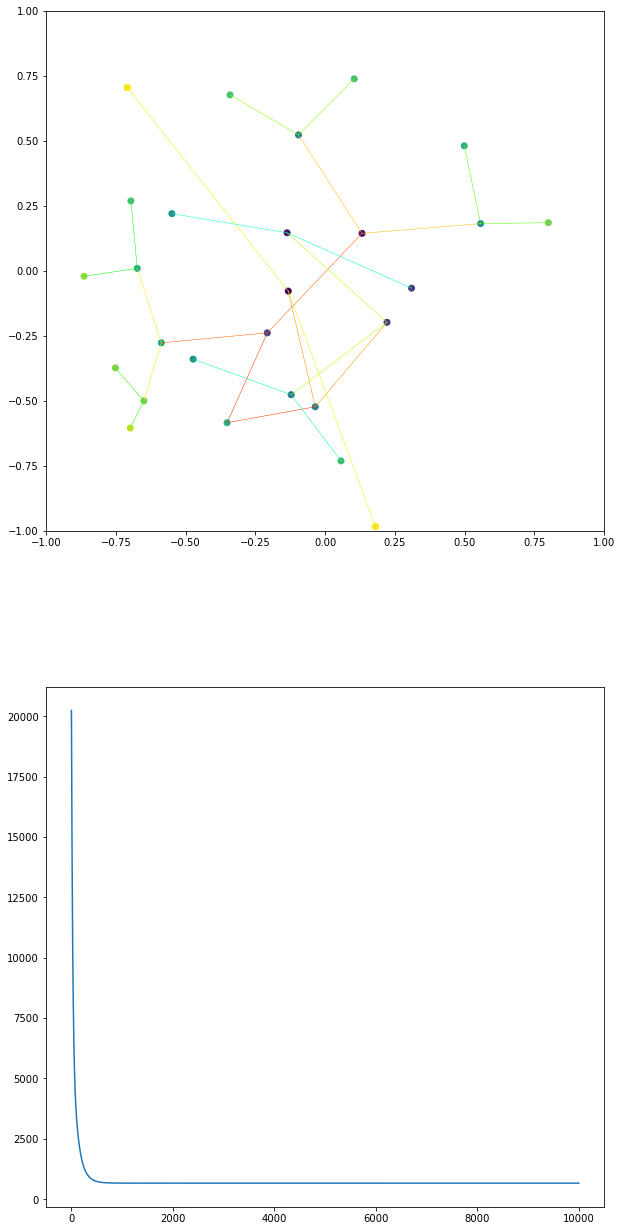

In [5]:
import argparse

import torch
#import wandb

from OdorDataset import OdorMonoDataset
from utils.helpers import *
from methods import *
from optimizers import *
from torch.utils.data import DataLoader
from utils.visulization import *
import uuid
from utils.helpers import set_seeds
import scipy
def hasone(node_index, dim_index):
    bin_i, bin_j = np.binary_repr(node_index), np.binary_repr(dim_index)
    length = len(bin_j)
    return (bin_i[:length] == bin_j) * 1


def get_tree_data(depth, dtype=np.float32):
    n = 2 ** depth - 1
    x = np.fromfunction(lambda i, j: np.vectorize(hasone)(i + 1, j + 1),
                        (n, n), dtype=np.int32).astype(dtype)
    # print(x.shape)
    return x

import sys
if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = sys.argv[:1]

#def main():

if __name__ == "__main__":
    # add arguments


    # wandb.init(project='hyperbolic_smell')
    # wandb.config = args

    # args = wandb.config
    # args.random_string = uuid.uuid4().hex

    # plt.savefig(f"figs2/{args.depth}/{args.latent_dist_fun}/{args.normalize}/{args.model_name}/{args.optimizer}/{args.lr}/{args.temperature}/{args.random_string}_{args.num_epochs}_{args.seed}_{args.dataset_name}.png")

    parser = argparse.ArgumentParser('Hyperbolic Smell')
    parser.add_argument('--representation_name', type=str, default='molformer')
    parser.add_argument('--batch_size', type=int, default=2048)
    parser.add_argument('--num_epochs', type=int, default=10000)
    parser.add_argument('--min_dist', type=float, default=1.)
    parser.add_argument('--latent_dim', type=int, default=2)
    parser.add_argument('--lr', type=float, default=0.001)
    parser.add_argument('--seed', type=int, default=2025)
    parser.add_argument('--base_dir', type=str,
                        default='../../../T5 EVO/alignment_olfaction_datasets/curated_datasets/')

    parser.add_argument('--dataset_name', type=str, default='tree')
    parser.add_argument('--normalize', type=bool, default=True)
    parser.add_argument('--optimizer', type=str, default='poincare', choices=['standard', 'poincare'])
    parser.add_argument('--model_name', type=str, default='contrastive', choices=['isomap', 'mds', 'contrastive'])
    parser.add_argument('--latent_dist_fun', type=str, default='poincare', choices=['euclidean', 'poincare'])
    parser.add_argument('--distance_method', type=str, default='hamming', choices=['geo', 'graph', 'hamming'])
    parser.add_argument('--n_samples', type=int, default=200)
    parser.add_argument('--dim', type=int, default=768)
    parser.add_argument('--depth', type=bool, default=5)
    parser.add_argument('--temperature', type=float, default=0.9)
    # args = argparse.Namespace()
    args = parser.parse_args()
    dataset_name = args.dataset_name
    representation_name = args.representation_name
    num_epochs = args.num_epochs
    normalize = args.normalize
    # geodesic = args.geodesic
    # min_dist = args.min_dist
    latent_dim = args.latent_dim
    lr = args.lr
    seed = args.seed
    base_dir = args.base_dir
    optimizer = args.optimizer
    model_name = args.model_name
    latent_dist_fun = args.latent_dist_fun
    distance_method = args.distance_method
    # n_samples = args.n_samples
    # dim = args.dim
    depth = args.depth
    temperature = args.temperature

    ### Overwrite the batchsize ###
    args.batch_size = 2 ** args.depth - 1 #to get full batch
    batch_size = args.batch_size
    
    args.random_string = uuid.uuid4().hex
    set_seeds(seed)


    if dataset_name == 'tree':
        embeddings = get_tree_data(depth)
        ## binary_tree is a dataset of binary sequences.
        ## The root of the tree is the node 0: binary_tree[0]
        ## groundtruth distance from node i to the root of the tree (i.e. shortest path distance from node i to the root): hamming_distance(binary_tree[0], binary_tree[i])
        ## For visualizations, one can color a node by its groundtruth distance to the tree.
    elif dataset_name == 'random':
        embeddings  = torch.randn(n_samples, dim)
    else:
        input_embeddings = f'embeddings/{representation_name}/{dataset_name}_{representation_name}_embeddings_13_Apr17.csv'
        embeddings = read_embeddings(base_dir, select_descriptors(dataset_name), input_embeddings, grand_avg=True if dataset_name == 'keller' else False)
    dataset = OdorMonoDataset(embeddings, transform=None)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    if latent_dist_fun != 'euclidean' and latent_dist_fun != 'poincare':
        raise ValueError('Latent distance function not recognized')
    if model_name == 'isomap':
        model = Isomap(len(dataset), latent_dim, Euclidean if latent_dist_fun == 'euclidean' else Poincare)
    elif model_name == 'mds':
        model = MDS(len(dataset), latent_dim, Euclidean if latent_dist_fun == 'euclidean' else Poincare)
    elif model_name == 'contrastive':
        model = Contrastive(len(dataset), latent_dim, Euclidean if latent_dist_fun == 'euclidean' else Poincare)
    else:
        raise ValueError('Model not recognized')
    if optimizer == 'standard':
        optimizer = StandardOptim(model, lr=lr)
    elif optimizer == 'poincare':
        optimizer = PoincareOptim(model, lr=lr)
    else:
        raise ValueError('Optimizer not recognized')
    losses = []
    # wandb.watch(model)
    for i in range(num_epochs):
        total_loss=0
        for idx, batch in data_loader:
            if normalize:
                model.normalize()
            if distance_method == 'graph':
                data_nn_matrix = nngraph_distance(batch,n_neighbors=3,metric='minkowski')
                # print(data_nn_matrix)
                data_dist_matrix = (data_nn_matrix > 0).astype(int)
                data_dist_matrix = torch.tensor(data_dist_matrix)
                # print(data_dist_matrix)
            elif distance_method == 'geo':
                data_dist_matrix = geo_distance(batch)
            elif distance_method == 'hamming':
                data_dist_matrix = hamming_distance_matrix(batch)
                if model_name == 'contrastive':
                    data_binary_dist_matrix = (data_dist_matrix <= 1.01).astype(int)
                    data_binary_dist_matrix = torch.tensor(data_binary_dist_matrix)
                data_dist_matrix = torch.tensor(data_dist_matrix)
            else:
                data_dist_matrix = dist_matrix(batch, Euclidean)
            # if geodesic:
            #     data_dist_matrix = geo_distance(batch)
            # else:
            #     data_dist_matrix = dist_matrix(batch, Euclidean)
            #binary matrix
            optimizer.zero_grad()
            loss = model.loss_fun(data_dist_matrix,idx, data_binary_dist_matrix, temperature)
            loss.backward()
            optimizer.step(idx)
            total_loss += loss.item()
        print(f'Epoch {i}, loss: {total_loss / len(data_loader):.3f}')
        losses.append(total_loss/len(data_loader))
        # wandb.log({'loss': total_loss/len(data_loader)})
            # print('norms', vector_norm(model.embeddings, dim=-1).mean().item(), vector_norm(model.embeddings, dim=-1).max().item())
        # if i % 10 == 0:


        # laten_embeddings_norm= torch.norm(model.embeddings, dim=-1).cpu().detach().numpy()
        # e=scipy.spatial.distance.cdist(data_loader.dataset.embeddings, data_loader.dataset.embeddings, metric='hamming')*data_loader.dataset.embeddings.shape[-1]
        # scatterplot_2d(losses, model.embeddings.detach().cpu().numpy(), laten_embeddings_norm, args=args, data_dist_matrix=e)
    scatterplot_2d(losses, model.embeddings,dataset.embeddings, args=args)

#

Epoch 0, loss: 20240.895
Epoch 1, loss: 19656.439
Epoch 2, loss: 19090.626
Epoch 3, loss: 18544.419
Epoch 4, loss: 18018.755
Epoch 5, loss: 17511.964
Epoch 6, loss: 17021.781
Epoch 7, loss: 16550.139
Epoch 8, loss: 16095.518
Epoch 9, loss: 15656.205
Epoch 10, loss: 15232.362
Epoch 11, loss: 14824.102
Epoch 12, loss: 14429.279
Epoch 13, loss: 14048.042
Epoch 14, loss: 13680.636
Epoch 15, loss: 13325.577
Epoch 16, loss: 12983.274
Epoch 17, loss: 12652.277
Epoch 18, loss: 12332.916
Epoch 19, loss: 12024.647
Epoch 20, loss: 11726.784
Epoch 21, loss: 11439.562
Epoch 22, loss: 11161.911
Epoch 23, loss: 10894.011
Epoch 24, loss: 10635.138
Epoch 25, loss: 10384.996
Epoch 26, loss: 10143.748
Epoch 27, loss: 9910.670
Epoch 28, loss: 9685.596
Epoch 29, loss: 9468.109
Epoch 30, loss: 9258.313
Epoch 31, loss: 9055.428
Epoch 32, loss: 8859.522
Epoch 33, loss: 8670.205
Epoch 34, loss: 8487.205
Epoch 35, loss: 8310.352
Epoch 36, loss: 8139.582
Epoch 37, loss: 7974.459
Epoch 38, loss: 7814.744
Epoch 39

Epoch 319, loss: 1003.115
Epoch 320, loss: 1000.106
Epoch 321, loss: 997.123
Epoch 322, loss: 994.169
Epoch 323, loss: 991.242
Epoch 324, loss: 988.338
Epoch 325, loss: 985.465
Epoch 326, loss: 982.615
Epoch 327, loss: 979.791
Epoch 328, loss: 976.994
Epoch 329, loss: 974.224
Epoch 330, loss: 971.478
Epoch 331, loss: 968.759
Epoch 332, loss: 966.065
Epoch 333, loss: 963.392
Epoch 334, loss: 960.746
Epoch 335, loss: 958.127
Epoch 336, loss: 955.530
Epoch 337, loss: 952.956
Epoch 338, loss: 950.405
Epoch 339, loss: 947.878
Epoch 340, loss: 945.374
Epoch 341, loss: 942.892
Epoch 342, loss: 940.435
Epoch 343, loss: 937.999
Epoch 344, loss: 935.585
Epoch 345, loss: 933.195
Epoch 346, loss: 930.823
Epoch 347, loss: 928.478
Epoch 348, loss: 926.150
Epoch 349, loss: 923.845
Epoch 350, loss: 921.562
Epoch 351, loss: 919.296
Epoch 352, loss: 917.055
Epoch 353, loss: 914.832
Epoch 354, loss: 912.630
Epoch 355, loss: 910.446
Epoch 356, loss: 908.284
Epoch 357, loss: 906.142
Epoch 358, loss: 904.01

Epoch 690, loss: 679.821
Epoch 691, loss: 679.704
Epoch 692, loss: 679.591
Epoch 693, loss: 679.487
Epoch 694, loss: 679.383
Epoch 695, loss: 679.279
Epoch 696, loss: 679.176
Epoch 697, loss: 679.072
Epoch 698, loss: 678.967
Epoch 699, loss: 678.867
Epoch 700, loss: 678.759
Epoch 701, loss: 678.655
Epoch 702, loss: 678.552
Epoch 703, loss: 678.448
Epoch 704, loss: 678.349
Epoch 705, loss: 678.248
Epoch 706, loss: 678.144
Epoch 707, loss: 678.043
Epoch 708, loss: 677.939
Epoch 709, loss: 677.838
Epoch 710, loss: 677.736
Epoch 711, loss: 677.640
Epoch 712, loss: 677.532
Epoch 713, loss: 677.430
Epoch 714, loss: 677.332
Epoch 715, loss: 677.231
Epoch 716, loss: 677.136
Epoch 717, loss: 677.035
Epoch 718, loss: 676.931
Epoch 719, loss: 676.831
Epoch 720, loss: 676.731
Epoch 721, loss: 676.634
Epoch 722, loss: 676.534
Epoch 723, loss: 676.438
Epoch 724, loss: 676.341
Epoch 725, loss: 676.236
Epoch 726, loss: 676.140
Epoch 727, loss: 676.051
Epoch 728, loss: 675.963
Epoch 729, loss: 675.870


Epoch 1029, loss: 666.910
Epoch 1030, loss: 666.905
Epoch 1031, loss: 666.899
Epoch 1032, loss: 666.893
Epoch 1033, loss: 666.887
Epoch 1034, loss: 666.882
Epoch 1035, loss: 666.876
Epoch 1036, loss: 666.870
Epoch 1037, loss: 666.865
Epoch 1038, loss: 666.859
Epoch 1039, loss: 666.854
Epoch 1040, loss: 666.848
Epoch 1041, loss: 666.843
Epoch 1042, loss: 666.837
Epoch 1043, loss: 666.832
Epoch 1044, loss: 666.826
Epoch 1045, loss: 666.821
Epoch 1046, loss: 666.815
Epoch 1047, loss: 666.810
Epoch 1048, loss: 666.804
Epoch 1049, loss: 666.799
Epoch 1050, loss: 666.794
Epoch 1051, loss: 666.788
Epoch 1052, loss: 666.783
Epoch 1053, loss: 666.778
Epoch 1054, loss: 666.772
Epoch 1055, loss: 666.767
Epoch 1056, loss: 666.762
Epoch 1057, loss: 666.757
Epoch 1058, loss: 666.751
Epoch 1059, loss: 666.746
Epoch 1060, loss: 666.741
Epoch 1061, loss: 666.736
Epoch 1062, loss: 666.731
Epoch 1063, loss: 666.726
Epoch 1064, loss: 666.720
Epoch 1065, loss: 666.715
Epoch 1066, loss: 666.710
Epoch 1067, 

Epoch 1354, loss: 665.738
Epoch 1355, loss: 665.736
Epoch 1356, loss: 665.734
Epoch 1357, loss: 665.731
Epoch 1358, loss: 665.729
Epoch 1359, loss: 665.727
Epoch 1360, loss: 665.725
Epoch 1361, loss: 665.723
Epoch 1362, loss: 665.721
Epoch 1363, loss: 665.719
Epoch 1364, loss: 665.716
Epoch 1365, loss: 665.714
Epoch 1366, loss: 665.712
Epoch 1367, loss: 665.710
Epoch 1368, loss: 665.708
Epoch 1369, loss: 665.706
Epoch 1370, loss: 665.704
Epoch 1371, loss: 665.702
Epoch 1372, loss: 665.700
Epoch 1373, loss: 665.697
Epoch 1374, loss: 665.695
Epoch 1375, loss: 665.693
Epoch 1376, loss: 665.691
Epoch 1377, loss: 665.689
Epoch 1378, loss: 665.687
Epoch 1379, loss: 665.685
Epoch 1380, loss: 665.683
Epoch 1381, loss: 665.681
Epoch 1382, loss: 665.679
Epoch 1383, loss: 665.677
Epoch 1384, loss: 665.675
Epoch 1385, loss: 665.673
Epoch 1386, loss: 665.671
Epoch 1387, loss: 665.669
Epoch 1388, loss: 665.667
Epoch 1389, loss: 665.665
Epoch 1390, loss: 665.663
Epoch 1391, loss: 665.661
Epoch 1392, 

Epoch 1694, loss: 665.247
Epoch 1695, loss: 665.246
Epoch 1696, loss: 665.245
Epoch 1697, loss: 665.244
Epoch 1698, loss: 665.243
Epoch 1699, loss: 665.242
Epoch 1700, loss: 665.241
Epoch 1701, loss: 665.241
Epoch 1702, loss: 665.240
Epoch 1703, loss: 665.239
Epoch 1704, loss: 665.238
Epoch 1705, loss: 665.237
Epoch 1706, loss: 665.236
Epoch 1707, loss: 665.235
Epoch 1708, loss: 665.234
Epoch 1709, loss: 665.233
Epoch 1710, loss: 665.233
Epoch 1711, loss: 665.232
Epoch 1712, loss: 665.231
Epoch 1713, loss: 665.230
Epoch 1714, loss: 665.229
Epoch 1715, loss: 665.228
Epoch 1716, loss: 665.227
Epoch 1717, loss: 665.227
Epoch 1718, loss: 665.226
Epoch 1719, loss: 665.225
Epoch 1720, loss: 665.224
Epoch 1721, loss: 665.223
Epoch 1722, loss: 665.222
Epoch 1723, loss: 665.222
Epoch 1724, loss: 665.221
Epoch 1725, loss: 665.220
Epoch 1726, loss: 665.219
Epoch 1727, loss: 665.218
Epoch 1728, loss: 665.217
Epoch 1729, loss: 665.217
Epoch 1730, loss: 665.216
Epoch 1731, loss: 665.215
Epoch 1732, 

Epoch 2090, loss: 665.020
Epoch 2091, loss: 665.020
Epoch 2092, loss: 665.020
Epoch 2093, loss: 665.019
Epoch 2094, loss: 665.019
Epoch 2095, loss: 665.019
Epoch 2096, loss: 665.018
Epoch 2097, loss: 665.018
Epoch 2098, loss: 665.018
Epoch 2099, loss: 665.017
Epoch 2100, loss: 665.017
Epoch 2101, loss: 665.017
Epoch 2102, loss: 665.016
Epoch 2103, loss: 665.016
Epoch 2104, loss: 665.016
Epoch 2105, loss: 665.015
Epoch 2106, loss: 665.015
Epoch 2107, loss: 665.015
Epoch 2108, loss: 665.014
Epoch 2109, loss: 665.014
Epoch 2110, loss: 665.014
Epoch 2111, loss: 665.013
Epoch 2112, loss: 665.013
Epoch 2113, loss: 665.013
Epoch 2114, loss: 665.012
Epoch 2115, loss: 665.012
Epoch 2116, loss: 665.012
Epoch 2117, loss: 665.011
Epoch 2118, loss: 665.011
Epoch 2119, loss: 665.011
Epoch 2120, loss: 665.010
Epoch 2121, loss: 665.010
Epoch 2122, loss: 665.010
Epoch 2123, loss: 665.010
Epoch 2124, loss: 665.009
Epoch 2125, loss: 665.009
Epoch 2126, loss: 665.009
Epoch 2127, loss: 665.008
Epoch 2128, 

Epoch 2485, loss: 664.930
Epoch 2486, loss: 664.930
Epoch 2487, loss: 664.930
Epoch 2488, loss: 664.930
Epoch 2489, loss: 664.929
Epoch 2490, loss: 664.929
Epoch 2491, loss: 664.929
Epoch 2492, loss: 664.929
Epoch 2493, loss: 664.929
Epoch 2494, loss: 664.929
Epoch 2495, loss: 664.929
Epoch 2496, loss: 664.928
Epoch 2497, loss: 664.928
Epoch 2498, loss: 664.928
Epoch 2499, loss: 664.928
Epoch 2500, loss: 664.928
Epoch 2501, loss: 664.928
Epoch 2502, loss: 664.928
Epoch 2503, loss: 664.927
Epoch 2504, loss: 664.927
Epoch 2505, loss: 664.927
Epoch 2506, loss: 664.927
Epoch 2507, loss: 664.927
Epoch 2508, loss: 664.927
Epoch 2509, loss: 664.927
Epoch 2510, loss: 664.926
Epoch 2511, loss: 664.926
Epoch 2512, loss: 664.926
Epoch 2513, loss: 664.926
Epoch 2514, loss: 664.926
Epoch 2515, loss: 664.926
Epoch 2516, loss: 664.926
Epoch 2517, loss: 664.925
Epoch 2518, loss: 664.925
Epoch 2519, loss: 664.925
Epoch 2520, loss: 664.925
Epoch 2521, loss: 664.925
Epoch 2522, loss: 664.925
Epoch 2523, 

Epoch 2879, loss: 664.886
Epoch 2880, loss: 664.886
Epoch 2881, loss: 664.886
Epoch 2882, loss: 664.886
Epoch 2883, loss: 664.885
Epoch 2884, loss: 664.885
Epoch 2885, loss: 664.885
Epoch 2886, loss: 664.885
Epoch 2887, loss: 664.885
Epoch 2888, loss: 664.885
Epoch 2889, loss: 664.885
Epoch 2890, loss: 664.885
Epoch 2891, loss: 664.885
Epoch 2892, loss: 664.885
Epoch 2893, loss: 664.885
Epoch 2894, loss: 664.885
Epoch 2895, loss: 664.884
Epoch 2896, loss: 664.884
Epoch 2897, loss: 664.884
Epoch 2898, loss: 664.884
Epoch 2899, loss: 664.884
Epoch 2900, loss: 664.884
Epoch 2901, loss: 664.884
Epoch 2902, loss: 664.884
Epoch 2903, loss: 664.884
Epoch 2904, loss: 664.884
Epoch 2905, loss: 664.884
Epoch 2906, loss: 664.883
Epoch 2907, loss: 664.883
Epoch 2908, loss: 664.883
Epoch 2909, loss: 664.883
Epoch 2910, loss: 664.883
Epoch 2911, loss: 664.883
Epoch 2912, loss: 664.883
Epoch 2913, loss: 664.883
Epoch 2914, loss: 664.883
Epoch 2915, loss: 664.883
Epoch 2916, loss: 664.883
Epoch 2917, 

Epoch 3275, loss: 664.857
Epoch 3276, loss: 664.857
Epoch 3277, loss: 664.857
Epoch 3278, loss: 664.857
Epoch 3279, loss: 664.857
Epoch 3280, loss: 664.857
Epoch 3281, loss: 664.856
Epoch 3282, loss: 664.856
Epoch 3283, loss: 664.856
Epoch 3284, loss: 664.856
Epoch 3285, loss: 664.856
Epoch 3286, loss: 664.856
Epoch 3287, loss: 664.856
Epoch 3288, loss: 664.856
Epoch 3289, loss: 664.856
Epoch 3290, loss: 664.856
Epoch 3291, loss: 664.856
Epoch 3292, loss: 664.856
Epoch 3293, loss: 664.856
Epoch 3294, loss: 664.856
Epoch 3295, loss: 664.856
Epoch 3296, loss: 664.855
Epoch 3297, loss: 664.855
Epoch 3298, loss: 664.855
Epoch 3299, loss: 664.855
Epoch 3300, loss: 664.855
Epoch 3301, loss: 664.855
Epoch 3302, loss: 664.855
Epoch 3303, loss: 664.855
Epoch 3304, loss: 664.855
Epoch 3305, loss: 664.855
Epoch 3306, loss: 664.855
Epoch 3307, loss: 664.855
Epoch 3308, loss: 664.855
Epoch 3309, loss: 664.855
Epoch 3310, loss: 664.855
Epoch 3311, loss: 664.855
Epoch 3312, loss: 664.854
Epoch 3313, 

Epoch 3619, loss: 664.836
Epoch 3620, loss: 664.836
Epoch 3621, loss: 664.836
Epoch 3622, loss: 664.836
Epoch 3623, loss: 664.836
Epoch 3624, loss: 664.836
Epoch 3625, loss: 664.836
Epoch 3626, loss: 664.836
Epoch 3627, loss: 664.836
Epoch 3628, loss: 664.836
Epoch 3629, loss: 664.836
Epoch 3630, loss: 664.836
Epoch 3631, loss: 664.836
Epoch 3632, loss: 664.836
Epoch 3633, loss: 664.835
Epoch 3634, loss: 664.835
Epoch 3635, loss: 664.835
Epoch 3636, loss: 664.835
Epoch 3637, loss: 664.835
Epoch 3638, loss: 664.835
Epoch 3639, loss: 664.835
Epoch 3640, loss: 664.835
Epoch 3641, loss: 664.835
Epoch 3642, loss: 664.835
Epoch 3643, loss: 664.835
Epoch 3644, loss: 664.835
Epoch 3645, loss: 664.835
Epoch 3646, loss: 664.835
Epoch 3647, loss: 664.835
Epoch 3648, loss: 664.835
Epoch 3649, loss: 664.835
Epoch 3650, loss: 664.835
Epoch 3651, loss: 664.834
Epoch 3652, loss: 664.834
Epoch 3653, loss: 664.834
Epoch 3654, loss: 664.834
Epoch 3655, loss: 664.834
Epoch 3656, loss: 664.834
Epoch 3657, 

Epoch 4064, loss: 664.812
Epoch 4065, loss: 664.812
Epoch 4066, loss: 664.812
Epoch 4067, loss: 664.812
Epoch 4068, loss: 664.812
Epoch 4069, loss: 664.812
Epoch 4070, loss: 664.812
Epoch 4071, loss: 664.812
Epoch 4072, loss: 664.812
Epoch 4073, loss: 664.812
Epoch 4074, loss: 664.812
Epoch 4075, loss: 664.812
Epoch 4076, loss: 664.812
Epoch 4077, loss: 664.812
Epoch 4078, loss: 664.812
Epoch 4079, loss: 664.811
Epoch 4080, loss: 664.811
Epoch 4081, loss: 664.811
Epoch 4082, loss: 664.811
Epoch 4083, loss: 664.811
Epoch 4084, loss: 664.811
Epoch 4085, loss: 664.811
Epoch 4086, loss: 664.811
Epoch 4087, loss: 664.811
Epoch 4088, loss: 664.811
Epoch 4089, loss: 664.811
Epoch 4090, loss: 664.811
Epoch 4091, loss: 664.811
Epoch 4092, loss: 664.811
Epoch 4093, loss: 664.811
Epoch 4094, loss: 664.811
Epoch 4095, loss: 664.811
Epoch 4096, loss: 664.811
Epoch 4097, loss: 664.811
Epoch 4098, loss: 664.811
Epoch 4099, loss: 664.810
Epoch 4100, loss: 664.810
Epoch 4101, loss: 664.810
Epoch 4102, 

Epoch 4392, loss: 664.796
Epoch 4393, loss: 664.796
Epoch 4394, loss: 664.796
Epoch 4395, loss: 664.795
Epoch 4396, loss: 664.795
Epoch 4397, loss: 664.795
Epoch 4398, loss: 664.795
Epoch 4399, loss: 664.795
Epoch 4400, loss: 664.795
Epoch 4401, loss: 664.795
Epoch 4402, loss: 664.795
Epoch 4403, loss: 664.795
Epoch 4404, loss: 664.795
Epoch 4405, loss: 664.795
Epoch 4406, loss: 664.795
Epoch 4407, loss: 664.795
Epoch 4408, loss: 664.795
Epoch 4409, loss: 664.795
Epoch 4410, loss: 664.795
Epoch 4411, loss: 664.795
Epoch 4412, loss: 664.795
Epoch 4413, loss: 664.795
Epoch 4414, loss: 664.795
Epoch 4415, loss: 664.794
Epoch 4416, loss: 664.794
Epoch 4417, loss: 664.794
Epoch 4418, loss: 664.794
Epoch 4419, loss: 664.794
Epoch 4420, loss: 664.794
Epoch 4421, loss: 664.794
Epoch 4422, loss: 664.794
Epoch 4423, loss: 664.794
Epoch 4424, loss: 664.794
Epoch 4425, loss: 664.794
Epoch 4426, loss: 664.794
Epoch 4427, loss: 664.794
Epoch 4428, loss: 664.794
Epoch 4429, loss: 664.794
Epoch 4430, 

Epoch 4730, loss: 664.779
Epoch 4731, loss: 664.779
Epoch 4732, loss: 664.779
Epoch 4733, loss: 664.779
Epoch 4734, loss: 664.779
Epoch 4735, loss: 664.779
Epoch 4736, loss: 664.779
Epoch 4737, loss: 664.779
Epoch 4738, loss: 664.779
Epoch 4739, loss: 664.779
Epoch 4740, loss: 664.779
Epoch 4741, loss: 664.779
Epoch 4742, loss: 664.779
Epoch 4743, loss: 664.779
Epoch 4744, loss: 664.778
Epoch 4745, loss: 664.778
Epoch 4746, loss: 664.778
Epoch 4747, loss: 664.778
Epoch 4748, loss: 664.778
Epoch 4749, loss: 664.778
Epoch 4750, loss: 664.778
Epoch 4751, loss: 664.778
Epoch 4752, loss: 664.778
Epoch 4753, loss: 664.778
Epoch 4754, loss: 664.778
Epoch 4755, loss: 664.778
Epoch 4756, loss: 664.778
Epoch 4757, loss: 664.778
Epoch 4758, loss: 664.778
Epoch 4759, loss: 664.778
Epoch 4760, loss: 664.778
Epoch 4761, loss: 664.778
Epoch 4762, loss: 664.778
Epoch 4763, loss: 664.778
Epoch 4764, loss: 664.778
Epoch 4765, loss: 664.777
Epoch 4766, loss: 664.777
Epoch 4767, loss: 664.777
Epoch 4768, 

Epoch 5052, loss: 664.764
Epoch 5053, loss: 664.764
Epoch 5054, loss: 664.764
Epoch 5055, loss: 664.764
Epoch 5056, loss: 664.764
Epoch 5057, loss: 664.764
Epoch 5058, loss: 664.764
Epoch 5059, loss: 664.764
Epoch 5060, loss: 664.764
Epoch 5061, loss: 664.764
Epoch 5062, loss: 664.763
Epoch 5063, loss: 664.763
Epoch 5064, loss: 664.763
Epoch 5065, loss: 664.763
Epoch 5066, loss: 664.763
Epoch 5067, loss: 664.763
Epoch 5068, loss: 664.763
Epoch 5069, loss: 664.763
Epoch 5070, loss: 664.763
Epoch 5071, loss: 664.763
Epoch 5072, loss: 664.763
Epoch 5073, loss: 664.763
Epoch 5074, loss: 664.763
Epoch 5075, loss: 664.763
Epoch 5076, loss: 664.763
Epoch 5077, loss: 664.763
Epoch 5078, loss: 664.763
Epoch 5079, loss: 664.763
Epoch 5080, loss: 664.763
Epoch 5081, loss: 664.763
Epoch 5082, loss: 664.763
Epoch 5083, loss: 664.763
Epoch 5084, loss: 664.762
Epoch 5085, loss: 664.762
Epoch 5086, loss: 664.762
Epoch 5087, loss: 664.762
Epoch 5088, loss: 664.762
Epoch 5089, loss: 664.762
Epoch 5090, 

Epoch 5395, loss: 664.748
Epoch 5396, loss: 664.748
Epoch 5397, loss: 664.748
Epoch 5398, loss: 664.748
Epoch 5399, loss: 664.748
Epoch 5400, loss: 664.748
Epoch 5401, loss: 664.748
Epoch 5402, loss: 664.748
Epoch 5403, loss: 664.748
Epoch 5404, loss: 664.748
Epoch 5405, loss: 664.748
Epoch 5406, loss: 664.748
Epoch 5407, loss: 664.748
Epoch 5408, loss: 664.748
Epoch 5409, loss: 664.748
Epoch 5410, loss: 664.748
Epoch 5411, loss: 664.748
Epoch 5412, loss: 664.748
Epoch 5413, loss: 664.748
Epoch 5414, loss: 664.748
Epoch 5415, loss: 664.747
Epoch 5416, loss: 664.747
Epoch 5417, loss: 664.747
Epoch 5418, loss: 664.747
Epoch 5419, loss: 664.747
Epoch 5420, loss: 664.747
Epoch 5421, loss: 664.747
Epoch 5422, loss: 664.747
Epoch 5423, loss: 664.747
Epoch 5424, loss: 664.747
Epoch 5425, loss: 664.747
Epoch 5426, loss: 664.747
Epoch 5427, loss: 664.747
Epoch 5428, loss: 664.747
Epoch 5429, loss: 664.747
Epoch 5430, loss: 664.747
Epoch 5431, loss: 664.747
Epoch 5432, loss: 664.747
Epoch 5433, 

Epoch 5759, loss: 664.732
Epoch 5760, loss: 664.732
Epoch 5761, loss: 664.732
Epoch 5762, loss: 664.732
Epoch 5763, loss: 664.732
Epoch 5764, loss: 664.732
Epoch 5765, loss: 664.732
Epoch 5766, loss: 664.732
Epoch 5767, loss: 664.732
Epoch 5768, loss: 664.732
Epoch 5769, loss: 664.732
Epoch 5770, loss: 664.732
Epoch 5771, loss: 664.732
Epoch 5772, loss: 664.732
Epoch 5773, loss: 664.732
Epoch 5774, loss: 664.732
Epoch 5775, loss: 664.732
Epoch 5776, loss: 664.732
Epoch 5777, loss: 664.732
Epoch 5778, loss: 664.732
Epoch 5779, loss: 664.732
Epoch 5780, loss: 664.732
Epoch 5781, loss: 664.731
Epoch 5782, loss: 664.731
Epoch 5783, loss: 664.731
Epoch 5784, loss: 664.731
Epoch 5785, loss: 664.731
Epoch 5786, loss: 664.731
Epoch 5787, loss: 664.731
Epoch 5788, loss: 664.731
Epoch 5789, loss: 664.731
Epoch 5790, loss: 664.731
Epoch 5791, loss: 664.731
Epoch 5792, loss: 664.731
Epoch 5793, loss: 664.731
Epoch 5794, loss: 664.731
Epoch 5795, loss: 664.731
Epoch 5796, loss: 664.731
Epoch 5797, 

Epoch 6113, loss: 664.717
Epoch 6114, loss: 664.717
Epoch 6115, loss: 664.717
Epoch 6116, loss: 664.717
Epoch 6117, loss: 664.717
Epoch 6118, loss: 664.717
Epoch 6119, loss: 664.717
Epoch 6120, loss: 664.717
Epoch 6121, loss: 664.717
Epoch 6122, loss: 664.717
Epoch 6123, loss: 664.717
Epoch 6124, loss: 664.717
Epoch 6125, loss: 664.717
Epoch 6126, loss: 664.717
Epoch 6127, loss: 664.717
Epoch 6128, loss: 664.717
Epoch 6129, loss: 664.717
Epoch 6130, loss: 664.717
Epoch 6131, loss: 664.717
Epoch 6132, loss: 664.717
Epoch 6133, loss: 664.717
Epoch 6134, loss: 664.717
Epoch 6135, loss: 664.717
Epoch 6136, loss: 664.716
Epoch 6137, loss: 664.716
Epoch 6138, loss: 664.716
Epoch 6139, loss: 664.716
Epoch 6140, loss: 664.716
Epoch 6141, loss: 664.716
Epoch 6142, loss: 664.716
Epoch 6143, loss: 664.716
Epoch 6144, loss: 664.716
Epoch 6145, loss: 664.716
Epoch 6146, loss: 664.716
Epoch 6147, loss: 664.716
Epoch 6148, loss: 664.716
Epoch 6149, loss: 664.716
Epoch 6150, loss: 664.716
Epoch 6151, 

Epoch 6499, loss: 664.702
Epoch 6500, loss: 664.702
Epoch 6501, loss: 664.701
Epoch 6502, loss: 664.701
Epoch 6503, loss: 664.701
Epoch 6504, loss: 664.701
Epoch 6505, loss: 664.701
Epoch 6506, loss: 664.701
Epoch 6507, loss: 664.701
Epoch 6508, loss: 664.701
Epoch 6509, loss: 664.701
Epoch 6510, loss: 664.701
Epoch 6511, loss: 664.701
Epoch 6512, loss: 664.701
Epoch 6513, loss: 664.701
Epoch 6514, loss: 664.701
Epoch 6515, loss: 664.701
Epoch 6516, loss: 664.701
Epoch 6517, loss: 664.701
Epoch 6518, loss: 664.701
Epoch 6519, loss: 664.701
Epoch 6520, loss: 664.701
Epoch 6521, loss: 664.701
Epoch 6522, loss: 664.701
Epoch 6523, loss: 664.701
Epoch 6524, loss: 664.701
Epoch 6525, loss: 664.701
Epoch 6526, loss: 664.700
Epoch 6527, loss: 664.700
Epoch 6528, loss: 664.700
Epoch 6529, loss: 664.700
Epoch 6530, loss: 664.700
Epoch 6531, loss: 664.700
Epoch 6532, loss: 664.700
Epoch 6533, loss: 664.700
Epoch 6534, loss: 664.700
Epoch 6535, loss: 664.700
Epoch 6536, loss: 664.700
Epoch 6537, 

Epoch 6886, loss: 664.686
Epoch 6887, loss: 664.686
Epoch 6888, loss: 664.686
Epoch 6889, loss: 664.686
Epoch 6890, loss: 664.686
Epoch 6891, loss: 664.686
Epoch 6892, loss: 664.686
Epoch 6893, loss: 664.686
Epoch 6894, loss: 664.686
Epoch 6895, loss: 664.686
Epoch 6896, loss: 664.686
Epoch 6897, loss: 664.686
Epoch 6898, loss: 664.686
Epoch 6899, loss: 664.686
Epoch 6900, loss: 664.686
Epoch 6901, loss: 664.686
Epoch 6902, loss: 664.686
Epoch 6903, loss: 664.686
Epoch 6904, loss: 664.685
Epoch 6905, loss: 664.685
Epoch 6906, loss: 664.685
Epoch 6907, loss: 664.685
Epoch 6908, loss: 664.685
Epoch 6909, loss: 664.685
Epoch 6910, loss: 664.685
Epoch 6911, loss: 664.685
Epoch 6912, loss: 664.685
Epoch 6913, loss: 664.685
Epoch 6914, loss: 664.685
Epoch 6915, loss: 664.685
Epoch 6916, loss: 664.685
Epoch 6917, loss: 664.685
Epoch 6918, loss: 664.685
Epoch 6919, loss: 664.685
Epoch 6920, loss: 664.685
Epoch 6921, loss: 664.685
Epoch 6922, loss: 664.685
Epoch 6923, loss: 664.685
Epoch 6924, 

Epoch 7284, loss: 664.671
Epoch 7285, loss: 664.671
Epoch 7286, loss: 664.671
Epoch 7287, loss: 664.671
Epoch 7288, loss: 664.671
Epoch 7289, loss: 664.671
Epoch 7290, loss: 664.671
Epoch 7291, loss: 664.671
Epoch 7292, loss: 664.670
Epoch 7293, loss: 664.670
Epoch 7294, loss: 664.670
Epoch 7295, loss: 664.670
Epoch 7296, loss: 664.670
Epoch 7297, loss: 664.670
Epoch 7298, loss: 664.670
Epoch 7299, loss: 664.670
Epoch 7300, loss: 664.670
Epoch 7301, loss: 664.670
Epoch 7302, loss: 664.670
Epoch 7303, loss: 664.670
Epoch 7304, loss: 664.670
Epoch 7305, loss: 664.670
Epoch 7306, loss: 664.670
Epoch 7307, loss: 664.670
Epoch 7308, loss: 664.670
Epoch 7309, loss: 664.670
Epoch 7310, loss: 664.670
Epoch 7311, loss: 664.670
Epoch 7312, loss: 664.670
Epoch 7313, loss: 664.670
Epoch 7314, loss: 664.670
Epoch 7315, loss: 664.670
Epoch 7316, loss: 664.669
Epoch 7317, loss: 664.669
Epoch 7318, loss: 664.669
Epoch 7319, loss: 664.669
Epoch 7320, loss: 664.669
Epoch 7321, loss: 664.669
Epoch 7322, 

Epoch 7667, loss: 664.656
Epoch 7668, loss: 664.656
Epoch 7669, loss: 664.656
Epoch 7670, loss: 664.656
Epoch 7671, loss: 664.656
Epoch 7672, loss: 664.656
Epoch 7673, loss: 664.656
Epoch 7674, loss: 664.656
Epoch 7675, loss: 664.656
Epoch 7676, loss: 664.656
Epoch 7677, loss: 664.656
Epoch 7678, loss: 664.656
Epoch 7679, loss: 664.656
Epoch 7680, loss: 664.656
Epoch 7681, loss: 664.656
Epoch 7682, loss: 664.656
Epoch 7683, loss: 664.656
Epoch 7684, loss: 664.656
Epoch 7685, loss: 664.656
Epoch 7686, loss: 664.655
Epoch 7687, loss: 664.655
Epoch 7688, loss: 664.655
Epoch 7689, loss: 664.655
Epoch 7690, loss: 664.655
Epoch 7691, loss: 664.655
Epoch 7692, loss: 664.655
Epoch 7693, loss: 664.655
Epoch 7694, loss: 664.655
Epoch 7695, loss: 664.655
Epoch 7696, loss: 664.655
Epoch 7697, loss: 664.655
Epoch 7698, loss: 664.655
Epoch 7699, loss: 664.655
Epoch 7700, loss: 664.655
Epoch 7701, loss: 664.655
Epoch 7702, loss: 664.655
Epoch 7703, loss: 664.655
Epoch 7704, loss: 664.655
Epoch 7705, 

Epoch 8053, loss: 664.642
Epoch 8054, loss: 664.642
Epoch 8055, loss: 664.642
Epoch 8056, loss: 664.642
Epoch 8057, loss: 664.642
Epoch 8058, loss: 664.642
Epoch 8059, loss: 664.642
Epoch 8060, loss: 664.641
Epoch 8061, loss: 664.641
Epoch 8062, loss: 664.641
Epoch 8063, loss: 664.641
Epoch 8064, loss: 664.641
Epoch 8065, loss: 664.641
Epoch 8066, loss: 664.641
Epoch 8067, loss: 664.641
Epoch 8068, loss: 664.641
Epoch 8069, loss: 664.641
Epoch 8070, loss: 664.641
Epoch 8071, loss: 664.641
Epoch 8072, loss: 664.641
Epoch 8073, loss: 664.641
Epoch 8074, loss: 664.641
Epoch 8075, loss: 664.641
Epoch 8076, loss: 664.641
Epoch 8077, loss: 664.641
Epoch 8078, loss: 664.641
Epoch 8079, loss: 664.641
Epoch 8080, loss: 664.641
Epoch 8081, loss: 664.641
Epoch 8082, loss: 664.641
Epoch 8083, loss: 664.641
Epoch 8084, loss: 664.641
Epoch 8085, loss: 664.641
Epoch 8086, loss: 664.641
Epoch 8087, loss: 664.640
Epoch 8088, loss: 664.640
Epoch 8089, loss: 664.640
Epoch 8090, loss: 664.640
Epoch 8091, 

Epoch 8442, loss: 664.627
Epoch 8443, loss: 664.627
Epoch 8444, loss: 664.627
Epoch 8445, loss: 664.627
Epoch 8446, loss: 664.627
Epoch 8447, loss: 664.627
Epoch 8448, loss: 664.627
Epoch 8449, loss: 664.627
Epoch 8450, loss: 664.627
Epoch 8451, loss: 664.627
Epoch 8452, loss: 664.627
Epoch 8453, loss: 664.627
Epoch 8454, loss: 664.627
Epoch 8455, loss: 664.627
Epoch 8456, loss: 664.627
Epoch 8457, loss: 664.627
Epoch 8458, loss: 664.627
Epoch 8459, loss: 664.627
Epoch 8460, loss: 664.627
Epoch 8461, loss: 664.627
Epoch 8462, loss: 664.627
Epoch 8463, loss: 664.627
Epoch 8464, loss: 664.627
Epoch 8465, loss: 664.626
Epoch 8466, loss: 664.626
Epoch 8467, loss: 664.626
Epoch 8468, loss: 664.626
Epoch 8469, loss: 664.626
Epoch 8470, loss: 664.626
Epoch 8471, loss: 664.626
Epoch 8472, loss: 664.626
Epoch 8473, loss: 664.626
Epoch 8474, loss: 664.626
Epoch 8475, loss: 664.626
Epoch 8476, loss: 664.626
Epoch 8477, loss: 664.626
Epoch 8478, loss: 664.626
Epoch 8479, loss: 664.626
Epoch 8480, 

Epoch 8835, loss: 664.613
Epoch 8836, loss: 664.613
Epoch 8837, loss: 664.613
Epoch 8838, loss: 664.613
Epoch 8839, loss: 664.613
Epoch 8840, loss: 664.613
Epoch 8841, loss: 664.613
Epoch 8842, loss: 664.613
Epoch 8843, loss: 664.613
Epoch 8844, loss: 664.613
Epoch 8845, loss: 664.613
Epoch 8846, loss: 664.612
Epoch 8847, loss: 664.612
Epoch 8848, loss: 664.612
Epoch 8849, loss: 664.612
Epoch 8850, loss: 664.612
Epoch 8851, loss: 664.612
Epoch 8852, loss: 664.612
Epoch 8853, loss: 664.612
Epoch 8854, loss: 664.612
Epoch 8855, loss: 664.612
Epoch 8856, loss: 664.612
Epoch 8857, loss: 664.612
Epoch 8858, loss: 664.612
Epoch 8859, loss: 664.612
Epoch 8860, loss: 664.612
Epoch 8861, loss: 664.612
Epoch 8862, loss: 664.612
Epoch 8863, loss: 664.612
Epoch 8864, loss: 664.612
Epoch 8865, loss: 664.612
Epoch 8866, loss: 664.612
Epoch 8867, loss: 664.612
Epoch 8868, loss: 664.612
Epoch 8869, loss: 664.612
Epoch 8870, loss: 664.612
Epoch 8871, loss: 664.612
Epoch 8872, loss: 664.612
Epoch 8873, 

Epoch 9238, loss: 664.598
Epoch 9239, loss: 664.598
Epoch 9240, loss: 664.598
Epoch 9241, loss: 664.598
Epoch 9242, loss: 664.598
Epoch 9243, loss: 664.598
Epoch 9244, loss: 664.598
Epoch 9245, loss: 664.598
Epoch 9246, loss: 664.598
Epoch 9247, loss: 664.598
Epoch 9248, loss: 664.598
Epoch 9249, loss: 664.598
Epoch 9250, loss: 664.598
Epoch 9251, loss: 664.598
Epoch 9252, loss: 664.598
Epoch 9253, loss: 664.598
Epoch 9254, loss: 664.597
Epoch 9255, loss: 664.597
Epoch 9256, loss: 664.597
Epoch 9257, loss: 664.597
Epoch 9258, loss: 664.597
Epoch 9259, loss: 664.597
Epoch 9260, loss: 664.597
Epoch 9261, loss: 664.597
Epoch 9262, loss: 664.597
Epoch 9263, loss: 664.597
Epoch 9264, loss: 664.597
Epoch 9265, loss: 664.597
Epoch 9266, loss: 664.597
Epoch 9267, loss: 664.597
Epoch 9268, loss: 664.597
Epoch 9269, loss: 664.597
Epoch 9270, loss: 664.597
Epoch 9271, loss: 664.597
Epoch 9272, loss: 664.597
Epoch 9273, loss: 664.597
Epoch 9274, loss: 664.597
Epoch 9275, loss: 664.597
Epoch 9276, 

Epoch 9635, loss: 664.583
Epoch 9636, loss: 664.583
Epoch 9637, loss: 664.583
Epoch 9638, loss: 664.583
Epoch 9639, loss: 664.583
Epoch 9640, loss: 664.583
Epoch 9641, loss: 664.583
Epoch 9642, loss: 664.583
Epoch 9643, loss: 664.583
Epoch 9644, loss: 664.583
Epoch 9645, loss: 664.583
Epoch 9646, loss: 664.583
Epoch 9647, loss: 664.583
Epoch 9648, loss: 664.583
Epoch 9649, loss: 664.583
Epoch 9650, loss: 664.583
Epoch 9651, loss: 664.583
Epoch 9652, loss: 664.583
Epoch 9653, loss: 664.583
Epoch 9654, loss: 664.583
Epoch 9655, loss: 664.583
Epoch 9656, loss: 664.583
Epoch 9657, loss: 664.583
Epoch 9658, loss: 664.583
Epoch 9659, loss: 664.583
Epoch 9660, loss: 664.583
Epoch 9661, loss: 664.582
Epoch 9662, loss: 664.582
Epoch 9663, loss: 664.582
Epoch 9664, loss: 664.582
Epoch 9665, loss: 664.582
Epoch 9666, loss: 664.582
Epoch 9667, loss: 664.582
Epoch 9668, loss: 664.582
Epoch 9669, loss: 664.582
Epoch 9670, loss: 664.582
Epoch 9671, loss: 664.582
Epoch 9672, loss: 664.582
Epoch 9673, 

AttributeError: 'Namespace' object has no attribute 'model'

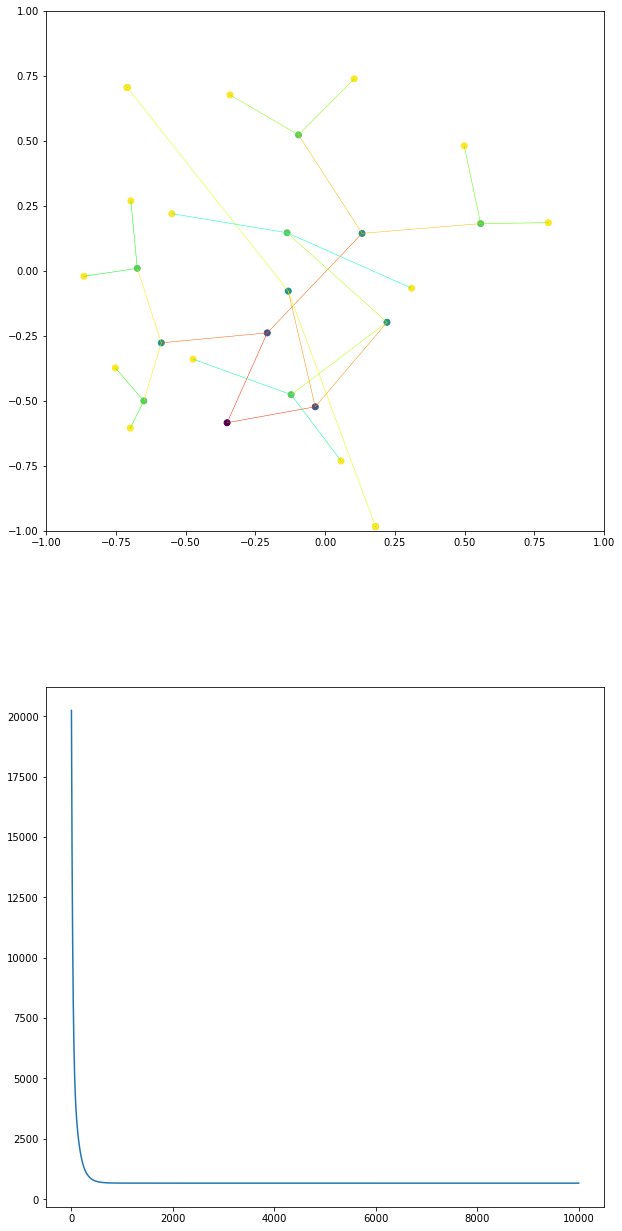

In [1]:
import argparse

import torch
#import wandb

from OdorDataset import OdorMonoDataset
from utils.helpers import *
from methods import *
from optimizers import *
from torch.utils.data import DataLoader
from utils.visulization import *
import uuid
from utils.helpers import set_seeds
import scipy
def hasone(node_index, dim_index):
    bin_i, bin_j = np.binary_repr(node_index), np.binary_repr(dim_index)
    length = len(bin_j)
    return (bin_i[:length] == bin_j) * 1


def get_tree_data(depth, dtype=np.float32):
    n = 2 ** depth - 1
    x = np.fromfunction(lambda i, j: np.vectorize(hasone)(i + 1, j + 1),
                        (n, n), dtype=np.int32).astype(dtype)
    # print(x.shape)
    return x

import sys
if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = sys.argv[:1]

#def main():

if __name__ == "__main__":
    # add arguments


    # wandb.init(project='hyperbolic_smell')
    # wandb.config = args

    # args = wandb.config
    # args.random_string = uuid.uuid4().hex

    # plt.savefig(f"figs2/{args.depth}/{args.latent_dist_fun}/{args.normalize}/{args.model_name}/{args.optimizer}/{args.lr}/{args.temperature}/{args.random_string}_{args.num_epochs}_{args.seed}_{args.dataset_name}.png")

    parser = argparse.ArgumentParser('Hyperbolic Smell')
    parser.add_argument('--representation_name', type=str, default='molformer')
    parser.add_argument('--batch_size', type=int, default=2048)
    parser.add_argument('--num_epochs', type=int, default=10000)
    parser.add_argument('--min_dist', type=float, default=1.)
    parser.add_argument('--latent_dim', type=int, default=2)
    parser.add_argument('--lr', type=float, default=0.001)
    parser.add_argument('--seed', type=int, default=2025)
    parser.add_argument('--base_dir', type=str,
                        default='../../../T5 EVO/alignment_olfaction_datasets/curated_datasets/')

    parser.add_argument('--dataset_name', type=str, default='tree')
    parser.add_argument('--normalize', type=bool, default=True)
    parser.add_argument('--optimizer', type=str, default='poincare', choices=['standard', 'poincare'])
    parser.add_argument('--model_name', type=str, default='contrastive', choices=['isomap', 'mds', 'contrastive'])
    parser.add_argument('--latent_dist_fun', type=str, default='poincare', choices=['euclidean', 'poincare'])
    parser.add_argument('--distance_method', type=str, default='hamming', choices=['geo', 'graph', 'hamming'])
    parser.add_argument('--n_samples', type=int, default=200)
    parser.add_argument('--dim', type=int, default=768)
    parser.add_argument('--depth', type=bool, default=5)
    parser.add_argument('--temperature', type=float, default=0.9)
    # args = argparse.Namespace()
    args = parser.parse_args()
    dataset_name = args.dataset_name
    representation_name = args.representation_name
    num_epochs = args.num_epochs
    normalize = args.normalize
    # geodesic = args.geodesic
    # min_dist = args.min_dist
    latent_dim = args.latent_dim
    lr = args.lr
    seed = args.seed
    base_dir = args.base_dir
    optimizer = args.optimizer
    model_name = args.model_name
    latent_dist_fun = args.latent_dist_fun
    distance_method = args.distance_method
    # n_samples = args.n_samples
    # dim = args.dim
    depth = args.depth
    temperature = args.temperature

    ### Overwrite the batchsize ###
    args.batch_size = 2 ** args.depth - 1 #to get full batch
    batch_size = args.batch_size
    
    args.random_string = uuid.uuid4().hex
    set_seeds(seed)


    if dataset_name == 'tree':
        embeddings = get_tree_data(depth)
        ## binary_tree is a dataset of binary sequences.
        ## The root of the tree is the node 0: binary_tree[0]
        ## groundtruth distance from node i to the root of the tree (i.e. shortest path distance from node i to the root): hamming_distance(binary_tree[0], binary_tree[i])
        ## For visualizations, one can color a node by its groundtruth distance to the tree.
    elif dataset_name == 'random':
        embeddings  = torch.randn(n_samples, dim)
    else:
        input_embeddings = f'embeddings/{representation_name}/{dataset_name}_{representation_name}_embeddings_13_Apr17.csv'
        embeddings = read_embeddings(base_dir, select_descriptors(dataset_name), input_embeddings, grand_avg=True if dataset_name == 'keller' else False)
    dataset = OdorMonoDataset(embeddings, transform=None)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    if latent_dist_fun != 'euclidean' and latent_dist_fun != 'poincare':
        raise ValueError('Latent distance function not recognized')
    if model_name == 'isomap':
        model = Isomap(len(dataset), latent_dim, Euclidean if latent_dist_fun == 'euclidean' else Poincare)
    elif model_name == 'mds':
        model = MDS(len(dataset), latent_dim, Euclidean if latent_dist_fun == 'euclidean' else Poincare)
    elif model_name == 'contrastive':
        model = Contrastive(len(dataset), latent_dim, Euclidean if latent_dist_fun == 'euclidean' else Poincare)
    else:
        raise ValueError('Model not recognized')
    if optimizer == 'standard':
        optimizer = StandardOptim(model, lr=lr)
    elif optimizer == 'poincare':
        optimizer = PoincareOptim(model, lr=lr)
    else:
        raise ValueError('Optimizer not recognized')
    losses = []
    # wandb.watch(model)
    for i in range(num_epochs):
        total_loss=0
        for idx, batch in data_loader:
            if normalize:
                model.normalize()
            if distance_method == 'graph':
                data_nn_matrix = nngraph_distance(batch,n_neighbors=3,metric='minkowski')
                # print(data_nn_matrix)
                data_dist_matrix = (data_nn_matrix > 0).astype(int)
                data_dist_matrix = torch.tensor(data_dist_matrix)
                # print(data_dist_matrix)
            elif distance_method == 'geo':
                data_dist_matrix = geo_distance(batch)
            elif distance_method == 'hamming':
                data_dist_matrix = hamming_distance_matrix(batch)
                if model_name == 'contrastive':
                    data_binary_dist_matrix = (data_dist_matrix <= 1.01).astype(int)
                    data_binary_dist_matrix = torch.tensor(data_binary_dist_matrix)
                data_dist_matrix = torch.tensor(data_dist_matrix)
            else:
                data_dist_matrix = dist_matrix(batch, Euclidean)
            # if geodesic:
            #     data_dist_matrix = geo_distance(batch)
            # else:
            #     data_dist_matrix = dist_matrix(batch, Euclidean)
            #binary matrix
            optimizer.zero_grad()
            loss = model.loss_fun(data_dist_matrix,idx, data_binary_dist_matrix, temperature)
            loss.backward()
            optimizer.step(idx)
            total_loss += loss.item()
        print(f'Epoch {i}, loss: {total_loss / len(data_loader):.3f}')
        losses.append(total_loss/len(data_loader))
        # wandb.log({'loss': total_loss/len(data_loader)})
            # print('norms', vector_norm(model.embeddings, dim=-1).mean().item(), vector_norm(model.embeddings, dim=-1).max().item())
        # if i % 10 == 0:


        # laten_embeddings_norm= torch.norm(model.embeddings, dim=-1).cpu().detach().numpy()
        # e=scipy.spatial.distance.cdist(data_loader.dataset.embeddings, data_loader.dataset.embeddings, metric='hamming')*data_loader.dataset.embeddings.shape[-1]
        # scatterplot_2d(losses, model.embeddings.detach().cpu().numpy(), laten_embeddings_norm, args=args, data_dist_matrix=e)
    scatterplot_2d(losses, model.embeddings,dataset.embeddings, args=args)

#

Epoch 0, loss: 20240.895
Epoch 1, loss: 19656.439
Epoch 2, loss: 19090.626
Epoch 3, loss: 18544.419
Epoch 4, loss: 18018.755
Epoch 5, loss: 17511.964
Epoch 6, loss: 17021.781
Epoch 7, loss: 16550.139
Epoch 8, loss: 16095.518
Epoch 9, loss: 15656.205
Epoch 10, loss: 15232.362
Epoch 11, loss: 14824.102
Epoch 12, loss: 14429.279
Epoch 13, loss: 14048.042
Epoch 14, loss: 13680.636
Epoch 15, loss: 13325.577
Epoch 16, loss: 12983.274
Epoch 17, loss: 12652.277
Epoch 18, loss: 12332.916
Epoch 19, loss: 12024.647
Epoch 20, loss: 11726.784
Epoch 21, loss: 11439.562
Epoch 22, loss: 11161.911
Epoch 23, loss: 10894.011
Epoch 24, loss: 10635.138
Epoch 25, loss: 10384.996
Epoch 26, loss: 10143.748
Epoch 27, loss: 9910.670
Epoch 28, loss: 9685.596
Epoch 29, loss: 9468.109
Epoch 30, loss: 9258.313
Epoch 31, loss: 9055.428
Epoch 32, loss: 8859.522
Epoch 33, loss: 8670.205
Epoch 34, loss: 8487.205
Epoch 35, loss: 8310.352
Epoch 36, loss: 8139.582
Epoch 37, loss: 7974.459
Epoch 38, loss: 7814.744
Epoch 39

Epoch 374, loss: 872.537
Epoch 375, loss: 870.716
Epoch 376, loss: 868.912
Epoch 377, loss: 867.124
Epoch 378, loss: 865.352
Epoch 379, loss: 863.598
Epoch 380, loss: 861.860
Epoch 381, loss: 860.133
Epoch 382, loss: 858.427
Epoch 383, loss: 856.735
Epoch 384, loss: 855.056
Epoch 385, loss: 853.397
Epoch 386, loss: 851.748
Epoch 387, loss: 850.116
Epoch 388, loss: 848.496
Epoch 389, loss: 846.897
Epoch 390, loss: 845.310
Epoch 391, loss: 843.735
Epoch 392, loss: 842.172
Epoch 393, loss: 840.630
Epoch 394, loss: 839.096
Epoch 395, loss: 837.578
Epoch 396, loss: 836.070
Epoch 397, loss: 834.577
Epoch 398, loss: 833.105
Epoch 399, loss: 831.643
Epoch 400, loss: 830.188
Epoch 401, loss: 828.746
Epoch 402, loss: 827.323
Epoch 403, loss: 825.913
Epoch 404, loss: 824.511
Epoch 405, loss: 823.124
Epoch 406, loss: 821.743
Epoch 407, loss: 820.382
Epoch 408, loss: 819.034
Epoch 409, loss: 817.694
Epoch 410, loss: 816.367
Epoch 411, loss: 815.054
Epoch 412, loss: 813.748
Epoch 413, loss: 812.459


Epoch 737, loss: 675.201
Epoch 738, loss: 675.124
Epoch 739, loss: 675.041
Epoch 740, loss: 674.962
Epoch 741, loss: 674.882
Epoch 742, loss: 674.804
Epoch 743, loss: 674.716
Epoch 744, loss: 674.637
Epoch 745, loss: 674.562
Epoch 746, loss: 674.487
Epoch 747, loss: 674.422
Epoch 748, loss: 674.350
Epoch 749, loss: 674.286
Epoch 750, loss: 674.225
Epoch 751, loss: 674.167
Epoch 752, loss: 674.105
Epoch 753, loss: 674.048
Epoch 754, loss: 673.988
Epoch 755, loss: 673.926
Epoch 756, loss: 673.869
Epoch 757, loss: 673.807
Epoch 758, loss: 673.748
Epoch 759, loss: 673.689
Epoch 760, loss: 673.631
Epoch 761, loss: 673.572
Epoch 762, loss: 673.511
Epoch 763, loss: 673.458
Epoch 764, loss: 673.395
Epoch 765, loss: 673.337
Epoch 766, loss: 673.279
Epoch 767, loss: 673.218
Epoch 768, loss: 673.163
Epoch 769, loss: 673.103
Epoch 770, loss: 673.049
Epoch 771, loss: 672.992
Epoch 772, loss: 672.932
Epoch 773, loss: 672.878
Epoch 774, loss: 672.821
Epoch 775, loss: 672.767
Epoch 776, loss: 672.708


Epoch 1228, loss: 666.067
Epoch 1229, loss: 666.064
Epoch 1230, loss: 666.061
Epoch 1231, loss: 666.058
Epoch 1232, loss: 666.054
Epoch 1233, loss: 666.051
Epoch 1234, loss: 666.048
Epoch 1235, loss: 666.045
Epoch 1236, loss: 666.042
Epoch 1237, loss: 666.039
Epoch 1238, loss: 666.036
Epoch 1239, loss: 666.033
Epoch 1240, loss: 666.030
Epoch 1241, loss: 666.027
Epoch 1242, loss: 666.024
Epoch 1243, loss: 666.021
Epoch 1244, loss: 666.018
Epoch 1245, loss: 666.015
Epoch 1246, loss: 666.012
Epoch 1247, loss: 666.010
Epoch 1248, loss: 666.007
Epoch 1249, loss: 666.004
Epoch 1250, loss: 666.001
Epoch 1251, loss: 665.998
Epoch 1252, loss: 665.995
Epoch 1253, loss: 665.992
Epoch 1254, loss: 665.989
Epoch 1255, loss: 665.986
Epoch 1256, loss: 665.983
Epoch 1257, loss: 665.981
Epoch 1258, loss: 665.978
Epoch 1259, loss: 665.975
Epoch 1260, loss: 665.972
Epoch 1261, loss: 665.969
Epoch 1262, loss: 665.967
Epoch 1263, loss: 665.964
Epoch 1264, loss: 665.961
Epoch 1265, loss: 665.958
Epoch 1266, 

Epoch 1585, loss: 665.360
Epoch 1586, loss: 665.359
Epoch 1587, loss: 665.358
Epoch 1588, loss: 665.356
Epoch 1589, loss: 665.355
Epoch 1590, loss: 665.354
Epoch 1591, loss: 665.353
Epoch 1592, loss: 665.352
Epoch 1593, loss: 665.351
Epoch 1594, loss: 665.349
Epoch 1595, loss: 665.348
Epoch 1596, loss: 665.347
Epoch 1597, loss: 665.346
Epoch 1598, loss: 665.345
Epoch 1599, loss: 665.344
Epoch 1600, loss: 665.342
Epoch 1601, loss: 665.341
Epoch 1602, loss: 665.340
Epoch 1603, loss: 665.339
Epoch 1604, loss: 665.338
Epoch 1605, loss: 665.337
Epoch 1606, loss: 665.336
Epoch 1607, loss: 665.334
Epoch 1608, loss: 665.333
Epoch 1609, loss: 665.332
Epoch 1610, loss: 665.331
Epoch 1611, loss: 665.330
Epoch 1612, loss: 665.329
Epoch 1613, loss: 665.328
Epoch 1614, loss: 665.327
Epoch 1615, loss: 665.326
Epoch 1616, loss: 665.324
Epoch 1617, loss: 665.323
Epoch 1618, loss: 665.322
Epoch 1619, loss: 665.321
Epoch 1620, loss: 665.320
Epoch 1621, loss: 665.319
Epoch 1622, loss: 665.318
Epoch 1623, 

Epoch 1985, loss: 665.061
Epoch 1986, loss: 665.060
Epoch 1987, loss: 665.060
Epoch 1988, loss: 665.060
Epoch 1989, loss: 665.059
Epoch 1990, loss: 665.059
Epoch 1991, loss: 665.058
Epoch 1992, loss: 665.058
Epoch 1993, loss: 665.057
Epoch 1994, loss: 665.057
Epoch 1995, loss: 665.057
Epoch 1996, loss: 665.056
Epoch 1997, loss: 665.056
Epoch 1998, loss: 665.055
Epoch 1999, loss: 665.055
Epoch 2000, loss: 665.054
Epoch 2001, loss: 665.054
Epoch 2002, loss: 665.054
Epoch 2003, loss: 665.053
Epoch 2004, loss: 665.053
Epoch 2005, loss: 665.052
Epoch 2006, loss: 665.052
Epoch 2007, loss: 665.052
Epoch 2008, loss: 665.051
Epoch 2009, loss: 665.051
Epoch 2010, loss: 665.050
Epoch 2011, loss: 665.050
Epoch 2012, loss: 665.049
Epoch 2013, loss: 665.049
Epoch 2014, loss: 665.049
Epoch 2015, loss: 665.048
Epoch 2016, loss: 665.048
Epoch 2017, loss: 665.047
Epoch 2018, loss: 665.047
Epoch 2019, loss: 665.047
Epoch 2020, loss: 665.046
Epoch 2021, loss: 665.046
Epoch 2022, loss: 665.045
Epoch 2023, 

Epoch 2370, loss: 664.949
Epoch 2371, loss: 664.949
Epoch 2372, loss: 664.949
Epoch 2373, loss: 664.949
Epoch 2374, loss: 664.949
Epoch 2375, loss: 664.948
Epoch 2376, loss: 664.948
Epoch 2377, loss: 664.948
Epoch 2378, loss: 664.948
Epoch 2379, loss: 664.948
Epoch 2380, loss: 664.947
Epoch 2381, loss: 664.947
Epoch 2382, loss: 664.947
Epoch 2383, loss: 664.947
Epoch 2384, loss: 664.947
Epoch 2385, loss: 664.947
Epoch 2386, loss: 664.946
Epoch 2387, loss: 664.946
Epoch 2388, loss: 664.946
Epoch 2389, loss: 664.946
Epoch 2390, loss: 664.946
Epoch 2391, loss: 664.945
Epoch 2392, loss: 664.945
Epoch 2393, loss: 664.945
Epoch 2394, loss: 664.945
Epoch 2395, loss: 664.945
Epoch 2396, loss: 664.945
Epoch 2397, loss: 664.944
Epoch 2398, loss: 664.944
Epoch 2399, loss: 664.944
Epoch 2400, loss: 664.944
Epoch 2401, loss: 664.944
Epoch 2402, loss: 664.944
Epoch 2403, loss: 664.943
Epoch 2404, loss: 664.943
Epoch 2405, loss: 664.943
Epoch 2406, loss: 664.943
Epoch 2407, loss: 664.943
Epoch 2408, 

Epoch 2740, loss: 664.899
Epoch 2741, loss: 664.899
Epoch 2742, loss: 664.898
Epoch 2743, loss: 664.898
Epoch 2744, loss: 664.898
Epoch 2745, loss: 664.898
Epoch 2746, loss: 664.898
Epoch 2747, loss: 664.898
Epoch 2748, loss: 664.898
Epoch 2749, loss: 664.898
Epoch 2750, loss: 664.898
Epoch 2751, loss: 664.898
Epoch 2752, loss: 664.898
Epoch 2753, loss: 664.897
Epoch 2754, loss: 664.897
Epoch 2755, loss: 664.897
Epoch 2756, loss: 664.897
Epoch 2757, loss: 664.897
Epoch 2758, loss: 664.897
Epoch 2759, loss: 664.897
Epoch 2760, loss: 664.897
Epoch 2761, loss: 664.897
Epoch 2762, loss: 664.897
Epoch 2763, loss: 664.896
Epoch 2764, loss: 664.896
Epoch 2765, loss: 664.896
Epoch 2766, loss: 664.896
Epoch 2767, loss: 664.896
Epoch 2768, loss: 664.896
Epoch 2769, loss: 664.896
Epoch 2770, loss: 664.896
Epoch 2771, loss: 664.896
Epoch 2772, loss: 664.896
Epoch 2773, loss: 664.895
Epoch 2774, loss: 664.895
Epoch 2775, loss: 664.895
Epoch 2776, loss: 664.895
Epoch 2777, loss: 664.895
Epoch 2778, 

Epoch 3124, loss: 664.867
Epoch 3125, loss: 664.867
Epoch 3126, loss: 664.867
Epoch 3127, loss: 664.867
Epoch 3128, loss: 664.867
Epoch 3129, loss: 664.867
Epoch 3130, loss: 664.866
Epoch 3131, loss: 664.866
Epoch 3132, loss: 664.866
Epoch 3133, loss: 664.866
Epoch 3134, loss: 664.866
Epoch 3135, loss: 664.866
Epoch 3136, loss: 664.866
Epoch 3137, loss: 664.866
Epoch 3138, loss: 664.866
Epoch 3139, loss: 664.866
Epoch 3140, loss: 664.866
Epoch 3141, loss: 664.866
Epoch 3142, loss: 664.866
Epoch 3143, loss: 664.866
Epoch 3144, loss: 664.866
Epoch 3145, loss: 664.865
Epoch 3146, loss: 664.865
Epoch 3147, loss: 664.865
Epoch 3148, loss: 664.865
Epoch 3149, loss: 664.865
Epoch 3150, loss: 664.865
Epoch 3151, loss: 664.865
Epoch 3152, loss: 664.865
Epoch 3153, loss: 664.865
Epoch 3154, loss: 664.865
Epoch 3155, loss: 664.865
Epoch 3156, loss: 664.865
Epoch 3157, loss: 664.865
Epoch 3158, loss: 664.865
Epoch 3159, loss: 664.864
Epoch 3160, loss: 664.864
Epoch 3161, loss: 664.864
Epoch 3162, 

Epoch 3510, loss: 664.843
Epoch 3511, loss: 664.842
Epoch 3512, loss: 664.842
Epoch 3513, loss: 664.842
Epoch 3514, loss: 664.842
Epoch 3515, loss: 664.842
Epoch 3516, loss: 664.842
Epoch 3517, loss: 664.842
Epoch 3518, loss: 664.842
Epoch 3519, loss: 664.842
Epoch 3520, loss: 664.842
Epoch 3521, loss: 664.842
Epoch 3522, loss: 664.842
Epoch 3523, loss: 664.842
Epoch 3524, loss: 664.842
Epoch 3525, loss: 664.842
Epoch 3526, loss: 664.842
Epoch 3527, loss: 664.842
Epoch 3528, loss: 664.841
Epoch 3529, loss: 664.841
Epoch 3530, loss: 664.841
Epoch 3531, loss: 664.841
Epoch 3532, loss: 664.841
Epoch 3533, loss: 664.841
Epoch 3534, loss: 664.841
Epoch 3535, loss: 664.841
Epoch 3536, loss: 664.841
Epoch 3537, loss: 664.841
Epoch 3538, loss: 664.841
Epoch 3539, loss: 664.841
Epoch 3540, loss: 664.841
Epoch 3541, loss: 664.841
Epoch 3542, loss: 664.841
Epoch 3543, loss: 664.841
Epoch 3544, loss: 664.841
Epoch 3545, loss: 664.840
Epoch 3546, loss: 664.840
Epoch 3547, loss: 664.840
Epoch 3548, 

Epoch 3916, loss: 664.820
Epoch 3917, loss: 664.820
Epoch 3918, loss: 664.820
Epoch 3919, loss: 664.820
Epoch 3920, loss: 664.820
Epoch 3921, loss: 664.820
Epoch 3922, loss: 664.820
Epoch 3923, loss: 664.820
Epoch 3924, loss: 664.820
Epoch 3925, loss: 664.820
Epoch 3926, loss: 664.820
Epoch 3927, loss: 664.819
Epoch 3928, loss: 664.819
Epoch 3929, loss: 664.819
Epoch 3930, loss: 664.819
Epoch 3931, loss: 664.819
Epoch 3932, loss: 664.819
Epoch 3933, loss: 664.819
Epoch 3934, loss: 664.819
Epoch 3935, loss: 664.819
Epoch 3936, loss: 664.819
Epoch 3937, loss: 664.819
Epoch 3938, loss: 664.819
Epoch 3939, loss: 664.819
Epoch 3940, loss: 664.819
Epoch 3941, loss: 664.819
Epoch 3942, loss: 664.819
Epoch 3943, loss: 664.819
Epoch 3944, loss: 664.819
Epoch 3945, loss: 664.819
Epoch 3946, loss: 664.818
Epoch 3947, loss: 664.818
Epoch 3948, loss: 664.818
Epoch 3949, loss: 664.818
Epoch 3950, loss: 664.818
Epoch 3951, loss: 664.818
Epoch 3952, loss: 664.818
Epoch 3953, loss: 664.818
Epoch 3954, 

Epoch 4246, loss: 664.803
Epoch 4247, loss: 664.803
Epoch 4248, loss: 664.803
Epoch 4249, loss: 664.803
Epoch 4250, loss: 664.803
Epoch 4251, loss: 664.803
Epoch 4252, loss: 664.803
Epoch 4253, loss: 664.803
Epoch 4254, loss: 664.803
Epoch 4255, loss: 664.802
Epoch 4256, loss: 664.802
Epoch 4257, loss: 664.802
Epoch 4258, loss: 664.802
Epoch 4259, loss: 664.802
Epoch 4260, loss: 664.802
Epoch 4261, loss: 664.802
Epoch 4262, loss: 664.802
Epoch 4263, loss: 664.802
Epoch 4264, loss: 664.802
Epoch 4265, loss: 664.802
Epoch 4266, loss: 664.802
Epoch 4267, loss: 664.802
Epoch 4268, loss: 664.802
Epoch 4269, loss: 664.802
Epoch 4270, loss: 664.802
Epoch 4271, loss: 664.802
Epoch 4272, loss: 664.802
Epoch 4273, loss: 664.802
Epoch 4274, loss: 664.802
Epoch 4275, loss: 664.801
Epoch 4276, loss: 664.801
Epoch 4277, loss: 664.801
Epoch 4278, loss: 664.801
Epoch 4279, loss: 664.801
Epoch 4280, loss: 664.801
Epoch 4281, loss: 664.801
Epoch 4282, loss: 664.801
Epoch 4283, loss: 664.801
Epoch 4284, 

Epoch 4649, loss: 664.783
Epoch 4650, loss: 664.783
Epoch 4651, loss: 664.783
Epoch 4652, loss: 664.783
Epoch 4653, loss: 664.783
Epoch 4654, loss: 664.783
Epoch 4655, loss: 664.783
Epoch 4656, loss: 664.783
Epoch 4657, loss: 664.783
Epoch 4658, loss: 664.783
Epoch 4659, loss: 664.783
Epoch 4660, loss: 664.782
Epoch 4661, loss: 664.782
Epoch 4662, loss: 664.782
Epoch 4663, loss: 664.782
Epoch 4664, loss: 664.782
Epoch 4665, loss: 664.782
Epoch 4666, loss: 664.782
Epoch 4667, loss: 664.782
Epoch 4668, loss: 664.782
Epoch 4669, loss: 664.782
Epoch 4670, loss: 664.782
Epoch 4671, loss: 664.782
Epoch 4672, loss: 664.782
Epoch 4673, loss: 664.782
Epoch 4674, loss: 664.782
Epoch 4675, loss: 664.782
Epoch 4676, loss: 664.782
Epoch 4677, loss: 664.782
Epoch 4678, loss: 664.782
Epoch 4679, loss: 664.782
Epoch 4680, loss: 664.782
Epoch 4681, loss: 664.781
Epoch 4682, loss: 664.781
Epoch 4683, loss: 664.781
Epoch 4684, loss: 664.781
Epoch 4685, loss: 664.781
Epoch 4686, loss: 664.781
Epoch 4687, 

Epoch 5044, loss: 664.764
Epoch 5045, loss: 664.764
Epoch 5046, loss: 664.764
Epoch 5047, loss: 664.764
Epoch 5048, loss: 664.764
Epoch 5049, loss: 664.764
Epoch 5050, loss: 664.764
Epoch 5051, loss: 664.764
Epoch 5052, loss: 664.764
Epoch 5053, loss: 664.764
Epoch 5054, loss: 664.764
Epoch 5055, loss: 664.764
Epoch 5056, loss: 664.764
Epoch 5057, loss: 664.764
Epoch 5058, loss: 664.764
Epoch 5059, loss: 664.764
Epoch 5060, loss: 664.764
Epoch 5061, loss: 664.764
Epoch 5062, loss: 664.763
Epoch 5063, loss: 664.763
Epoch 5064, loss: 664.763
Epoch 5065, loss: 664.763
Epoch 5066, loss: 664.763
Epoch 5067, loss: 664.763
Epoch 5068, loss: 664.763
Epoch 5069, loss: 664.763
Epoch 5070, loss: 664.763
Epoch 5071, loss: 664.763
Epoch 5072, loss: 664.763
Epoch 5073, loss: 664.763
Epoch 5074, loss: 664.763
Epoch 5075, loss: 664.763
Epoch 5076, loss: 664.763
Epoch 5077, loss: 664.763
Epoch 5078, loss: 664.763
Epoch 5079, loss: 664.763
Epoch 5080, loss: 664.763
Epoch 5081, loss: 664.763
Epoch 5082, 

Epoch 5434, loss: 664.747
Epoch 5435, loss: 664.747
Epoch 5436, loss: 664.747
Epoch 5437, loss: 664.747
Epoch 5438, loss: 664.746
Epoch 5439, loss: 664.746
Epoch 5440, loss: 664.746
Epoch 5441, loss: 664.746
Epoch 5442, loss: 664.746
Epoch 5443, loss: 664.746
Epoch 5444, loss: 664.746
Epoch 5445, loss: 664.746
Epoch 5446, loss: 664.746
Epoch 5447, loss: 664.746
Epoch 5448, loss: 664.746
Epoch 5449, loss: 664.746
Epoch 5450, loss: 664.746
Epoch 5451, loss: 664.746
Epoch 5452, loss: 664.746
Epoch 5453, loss: 664.746
Epoch 5454, loss: 664.746
Epoch 5455, loss: 664.746
Epoch 5456, loss: 664.746
Epoch 5457, loss: 664.746
Epoch 5458, loss: 664.746
Epoch 5459, loss: 664.746
Epoch 5460, loss: 664.745
Epoch 5461, loss: 664.745
Epoch 5462, loss: 664.745
Epoch 5463, loss: 664.745
Epoch 5464, loss: 664.745
Epoch 5465, loss: 664.745
Epoch 5466, loss: 664.745
Epoch 5467, loss: 664.745
Epoch 5468, loss: 664.745
Epoch 5469, loss: 664.745
Epoch 5470, loss: 664.745
Epoch 5471, loss: 664.745
Epoch 5472, 

Epoch 5844, loss: 664.729
Epoch 5845, loss: 664.729
Epoch 5846, loss: 664.729
Epoch 5847, loss: 664.729
Epoch 5848, loss: 664.729
Epoch 5849, loss: 664.729
Epoch 5850, loss: 664.729
Epoch 5851, loss: 664.728
Epoch 5852, loss: 664.728
Epoch 5853, loss: 664.728
Epoch 5854, loss: 664.728
Epoch 5855, loss: 664.728
Epoch 5856, loss: 664.728
Epoch 5857, loss: 664.728
Epoch 5858, loss: 664.728
Epoch 5859, loss: 664.728
Epoch 5860, loss: 664.728
Epoch 5861, loss: 664.728
Epoch 5862, loss: 664.728
Epoch 5863, loss: 664.728
Epoch 5864, loss: 664.728
Epoch 5865, loss: 664.728
Epoch 5866, loss: 664.728
Epoch 5867, loss: 664.728
Epoch 5868, loss: 664.728
Epoch 5869, loss: 664.728
Epoch 5870, loss: 664.728
Epoch 5871, loss: 664.728
Epoch 5872, loss: 664.728
Epoch 5873, loss: 664.728
Epoch 5874, loss: 664.727
Epoch 5875, loss: 664.727
Epoch 5876, loss: 664.727
Epoch 5877, loss: 664.727
Epoch 5878, loss: 664.727
Epoch 5879, loss: 664.727
Epoch 5880, loss: 664.727
Epoch 5881, loss: 664.727
Epoch 5882, 

Epoch 6247, loss: 664.712
Epoch 6248, loss: 664.712
Epoch 6249, loss: 664.712
Epoch 6250, loss: 664.712
Epoch 6251, loss: 664.712
Epoch 6252, loss: 664.712
Epoch 6253, loss: 664.712
Epoch 6254, loss: 664.712
Epoch 6255, loss: 664.712
Epoch 6256, loss: 664.711
Epoch 6257, loss: 664.711
Epoch 6258, loss: 664.711
Epoch 6259, loss: 664.711
Epoch 6260, loss: 664.711
Epoch 6261, loss: 664.711
Epoch 6262, loss: 664.711
Epoch 6263, loss: 664.711
Epoch 6264, loss: 664.711
Epoch 6265, loss: 664.711
Epoch 6266, loss: 664.711
Epoch 6267, loss: 664.711
Epoch 6268, loss: 664.711
Epoch 6269, loss: 664.711
Epoch 6270, loss: 664.711
Epoch 6271, loss: 664.711
Epoch 6272, loss: 664.711
Epoch 6273, loss: 664.711
Epoch 6274, loss: 664.711
Epoch 6275, loss: 664.711
Epoch 6276, loss: 664.711
Epoch 6277, loss: 664.711
Epoch 6278, loss: 664.711
Epoch 6279, loss: 664.711
Epoch 6280, loss: 664.710
Epoch 6281, loss: 664.710
Epoch 6282, loss: 664.710
Epoch 6283, loss: 664.710
Epoch 6284, loss: 664.710
Epoch 6285, 

Epoch 6575, loss: 664.699
Epoch 6576, loss: 664.698
Epoch 6577, loss: 664.698
Epoch 6578, loss: 664.698
Epoch 6579, loss: 664.698
Epoch 6580, loss: 664.698
Epoch 6581, loss: 664.698
Epoch 6582, loss: 664.698
Epoch 6583, loss: 664.698
Epoch 6584, loss: 664.698
Epoch 6585, loss: 664.698
Epoch 6586, loss: 664.698
Epoch 6587, loss: 664.698
Epoch 6588, loss: 664.698
Epoch 6589, loss: 664.698
Epoch 6590, loss: 664.698
Epoch 6591, loss: 664.698
Epoch 6592, loss: 664.698
Epoch 6593, loss: 664.698
Epoch 6594, loss: 664.698
Epoch 6595, loss: 664.698
Epoch 6596, loss: 664.698
Epoch 6597, loss: 664.698
Epoch 6598, loss: 664.698
Epoch 6599, loss: 664.698
Epoch 6600, loss: 664.698
Epoch 6601, loss: 664.697
Epoch 6602, loss: 664.697
Epoch 6603, loss: 664.697
Epoch 6604, loss: 664.697
Epoch 6605, loss: 664.697
Epoch 6606, loss: 664.697
Epoch 6607, loss: 664.697
Epoch 6608, loss: 664.697
Epoch 6609, loss: 664.697
Epoch 6610, loss: 664.697
Epoch 6611, loss: 664.697
Epoch 6612, loss: 664.697
Epoch 6613, 

Epoch 6964, loss: 664.683
Epoch 6965, loss: 664.683
Epoch 6966, loss: 664.683
Epoch 6967, loss: 664.683
Epoch 6968, loss: 664.683
Epoch 6969, loss: 664.683
Epoch 6970, loss: 664.683
Epoch 6971, loss: 664.683
Epoch 6972, loss: 664.683
Epoch 6973, loss: 664.683
Epoch 6974, loss: 664.683
Epoch 6975, loss: 664.683
Epoch 6976, loss: 664.683
Epoch 6977, loss: 664.683
Epoch 6978, loss: 664.683
Epoch 6979, loss: 664.683
Epoch 6980, loss: 664.682
Epoch 6981, loss: 664.682
Epoch 6982, loss: 664.682
Epoch 6983, loss: 664.682
Epoch 6984, loss: 664.682
Epoch 6985, loss: 664.682
Epoch 6986, loss: 664.682
Epoch 6987, loss: 664.682
Epoch 6988, loss: 664.682
Epoch 6989, loss: 664.682
Epoch 6990, loss: 664.682
Epoch 6991, loss: 664.682
Epoch 6992, loss: 664.682
Epoch 6993, loss: 664.682
Epoch 6994, loss: 664.682
Epoch 6995, loss: 664.682
Epoch 6996, loss: 664.682
Epoch 6997, loss: 664.682
Epoch 6998, loss: 664.682
Epoch 6999, loss: 664.682
Epoch 7000, loss: 664.682
Epoch 7001, loss: 664.682
Epoch 7002, 

Epoch 7318, loss: 664.669
Epoch 7319, loss: 664.669
Epoch 7320, loss: 664.669
Epoch 7321, loss: 664.669
Epoch 7322, loss: 664.669
Epoch 7323, loss: 664.669
Epoch 7324, loss: 664.669
Epoch 7325, loss: 664.669
Epoch 7326, loss: 664.669
Epoch 7327, loss: 664.669
Epoch 7328, loss: 664.669
Epoch 7329, loss: 664.669
Epoch 7330, loss: 664.669
Epoch 7331, loss: 664.669
Epoch 7332, loss: 664.669
Epoch 7333, loss: 664.669
Epoch 7334, loss: 664.669
Epoch 7335, loss: 664.669
Epoch 7336, loss: 664.669
Epoch 7337, loss: 664.669
Epoch 7338, loss: 664.669
Epoch 7339, loss: 664.669
Epoch 7340, loss: 664.669
Epoch 7341, loss: 664.669
Epoch 7342, loss: 664.669
Epoch 7343, loss: 664.668
Epoch 7344, loss: 664.668
Epoch 7345, loss: 664.668
Epoch 7346, loss: 664.668
Epoch 7347, loss: 664.668
Epoch 7348, loss: 664.668
Epoch 7349, loss: 664.668
Epoch 7350, loss: 664.668
Epoch 7351, loss: 664.668
Epoch 7352, loss: 664.668
Epoch 7353, loss: 664.668
Epoch 7354, loss: 664.668
Epoch 7355, loss: 664.668
Epoch 7356, 

Epoch 7698, loss: 664.655
Epoch 7699, loss: 664.655
Epoch 7700, loss: 664.655
Epoch 7701, loss: 664.655
Epoch 7702, loss: 664.655
Epoch 7703, loss: 664.655
Epoch 7704, loss: 664.655
Epoch 7705, loss: 664.655
Epoch 7706, loss: 664.655
Epoch 7707, loss: 664.655
Epoch 7708, loss: 664.655
Epoch 7709, loss: 664.655
Epoch 7710, loss: 664.655
Epoch 7711, loss: 664.655
Epoch 7712, loss: 664.654
Epoch 7713, loss: 664.654
Epoch 7714, loss: 664.654
Epoch 7715, loss: 664.654
Epoch 7716, loss: 664.654
Epoch 7717, loss: 664.654
Epoch 7718, loss: 664.654
Epoch 7719, loss: 664.654
Epoch 7720, loss: 664.654
Epoch 7721, loss: 664.654
Epoch 7722, loss: 664.654
Epoch 7723, loss: 664.654
Epoch 7724, loss: 664.654
Epoch 7725, loss: 664.654
Epoch 7726, loss: 664.654
Epoch 7727, loss: 664.654
Epoch 7728, loss: 664.654
Epoch 7729, loss: 664.654
Epoch 7730, loss: 664.654
Epoch 7731, loss: 664.654
Epoch 7732, loss: 664.654
Epoch 7733, loss: 664.654
Epoch 7734, loss: 664.654
Epoch 7735, loss: 664.654
Epoch 7736, 

Epoch 8047, loss: 664.642
Epoch 8048, loss: 664.642
Epoch 8049, loss: 664.642
Epoch 8050, loss: 664.642
Epoch 8051, loss: 664.642
Epoch 8052, loss: 664.642
Epoch 8053, loss: 664.642
Epoch 8054, loss: 664.642
Epoch 8055, loss: 664.642
Epoch 8056, loss: 664.642
Epoch 8057, loss: 664.642
Epoch 8058, loss: 664.642
Epoch 8059, loss: 664.642
Epoch 8060, loss: 664.641
Epoch 8061, loss: 664.641
Epoch 8062, loss: 664.641
Epoch 8063, loss: 664.641
Epoch 8064, loss: 664.641
Epoch 8065, loss: 664.641
Epoch 8066, loss: 664.641
Epoch 8067, loss: 664.641
Epoch 8068, loss: 664.641
Epoch 8069, loss: 664.641
Epoch 8070, loss: 664.641
Epoch 8071, loss: 664.641
Epoch 8072, loss: 664.641
Epoch 8073, loss: 664.641
Epoch 8074, loss: 664.641
Epoch 8075, loss: 664.641
Epoch 8076, loss: 664.641
Epoch 8077, loss: 664.641
Epoch 8078, loss: 664.641
Epoch 8079, loss: 664.641
Epoch 8080, loss: 664.641
Epoch 8081, loss: 664.641
Epoch 8082, loss: 664.641
Epoch 8083, loss: 664.641
Epoch 8084, loss: 664.641
Epoch 8085, 

Epoch 8382, loss: 664.630
Epoch 8383, loss: 664.630
Epoch 8384, loss: 664.629
Epoch 8385, loss: 664.629
Epoch 8386, loss: 664.629
Epoch 8387, loss: 664.629
Epoch 8388, loss: 664.629
Epoch 8389, loss: 664.629
Epoch 8390, loss: 664.629
Epoch 8391, loss: 664.629
Epoch 8392, loss: 664.629
Epoch 8393, loss: 664.629
Epoch 8394, loss: 664.629
Epoch 8395, loss: 664.629
Epoch 8396, loss: 664.629
Epoch 8397, loss: 664.629
Epoch 8398, loss: 664.629
Epoch 8399, loss: 664.629
Epoch 8400, loss: 664.629
Epoch 8401, loss: 664.629
Epoch 8402, loss: 664.629
Epoch 8403, loss: 664.629
Epoch 8404, loss: 664.629
Epoch 8405, loss: 664.629
Epoch 8406, loss: 664.629
Epoch 8407, loss: 664.629
Epoch 8408, loss: 664.629
Epoch 8409, loss: 664.629
Epoch 8410, loss: 664.629
Epoch 8411, loss: 664.628
Epoch 8412, loss: 664.628
Epoch 8413, loss: 664.628
Epoch 8414, loss: 664.628
Epoch 8415, loss: 664.628
Epoch 8416, loss: 664.628
Epoch 8417, loss: 664.628
Epoch 8418, loss: 664.628
Epoch 8419, loss: 664.628
Epoch 8420, 

Epoch 8729, loss: 664.617
Epoch 8730, loss: 664.617
Epoch 8731, loss: 664.617
Epoch 8732, loss: 664.617
Epoch 8733, loss: 664.617
Epoch 8734, loss: 664.617
Epoch 8735, loss: 664.617
Epoch 8736, loss: 664.617
Epoch 8737, loss: 664.617
Epoch 8738, loss: 664.616
Epoch 8739, loss: 664.616
Epoch 8740, loss: 664.616
Epoch 8741, loss: 664.616
Epoch 8742, loss: 664.616
Epoch 8743, loss: 664.616
Epoch 8744, loss: 664.616
Epoch 8745, loss: 664.616
Epoch 8746, loss: 664.616
Epoch 8747, loss: 664.616
Epoch 8748, loss: 664.616
Epoch 8749, loss: 664.616
Epoch 8750, loss: 664.616
Epoch 8751, loss: 664.616
Epoch 8752, loss: 664.616
Epoch 8753, loss: 664.616
Epoch 8754, loss: 664.616
Epoch 8755, loss: 664.616
Epoch 8756, loss: 664.616
Epoch 8757, loss: 664.616
Epoch 8758, loss: 664.616
Epoch 8759, loss: 664.616
Epoch 8760, loss: 664.616
Epoch 8761, loss: 664.616
Epoch 8762, loss: 664.616
Epoch 8763, loss: 664.616
Epoch 8764, loss: 664.615
Epoch 8765, loss: 664.615
Epoch 8766, loss: 664.615
Epoch 8767, 

Epoch 9122, loss: 664.602
Epoch 9123, loss: 664.602
Epoch 9124, loss: 664.602
Epoch 9125, loss: 664.602
Epoch 9126, loss: 664.602
Epoch 9127, loss: 664.602
Epoch 9128, loss: 664.602
Epoch 9129, loss: 664.602
Epoch 9130, loss: 664.602
Epoch 9131, loss: 664.602
Epoch 9132, loss: 664.602
Epoch 9133, loss: 664.602
Epoch 9134, loss: 664.602
Epoch 9135, loss: 664.602
Epoch 9136, loss: 664.602
Epoch 9137, loss: 664.602
Epoch 9138, loss: 664.602
Epoch 9139, loss: 664.602
Epoch 9140, loss: 664.602
Epoch 9141, loss: 664.602
Epoch 9142, loss: 664.602
Epoch 9143, loss: 664.602
Epoch 9144, loss: 664.602
Epoch 9145, loss: 664.601
Epoch 9146, loss: 664.601
Epoch 9147, loss: 664.601
Epoch 9148, loss: 664.601
Epoch 9149, loss: 664.601
Epoch 9150, loss: 664.601
Epoch 9151, loss: 664.601
Epoch 9152, loss: 664.601
Epoch 9153, loss: 664.601
Epoch 9154, loss: 664.601
Epoch 9155, loss: 664.601
Epoch 9156, loss: 664.601
Epoch 9157, loss: 664.601
Epoch 9158, loss: 664.601
Epoch 9159, loss: 664.601
Epoch 9160, 

Epoch 9506, loss: 664.588
Epoch 9507, loss: 664.588
Epoch 9508, loss: 664.588
Epoch 9509, loss: 664.588
Epoch 9510, loss: 664.588
Epoch 9511, loss: 664.588
Epoch 9512, loss: 664.588
Epoch 9513, loss: 664.588
Epoch 9514, loss: 664.588
Epoch 9515, loss: 664.588
Epoch 9516, loss: 664.588
Epoch 9517, loss: 664.588
Epoch 9518, loss: 664.588
Epoch 9519, loss: 664.588
Epoch 9520, loss: 664.588
Epoch 9521, loss: 664.588
Epoch 9522, loss: 664.588
Epoch 9523, loss: 664.588
Epoch 9524, loss: 664.588
Epoch 9525, loss: 664.587
Epoch 9526, loss: 664.588
Epoch 9527, loss: 664.587
Epoch 9528, loss: 664.587
Epoch 9529, loss: 664.587
Epoch 9530, loss: 664.587
Epoch 9531, loss: 664.587
Epoch 9532, loss: 664.587
Epoch 9533, loss: 664.587
Epoch 9534, loss: 664.587
Epoch 9535, loss: 664.587
Epoch 9536, loss: 664.587
Epoch 9537, loss: 664.587
Epoch 9538, loss: 664.587
Epoch 9539, loss: 664.587
Epoch 9540, loss: 664.587
Epoch 9541, loss: 664.587
Epoch 9542, loss: 664.587
Epoch 9543, loss: 664.587
Epoch 9544, 

Epoch 9885, loss: 664.574
Epoch 9886, loss: 664.574
Epoch 9887, loss: 664.574
Epoch 9888, loss: 664.574
Epoch 9889, loss: 664.574
Epoch 9890, loss: 664.574
Epoch 9891, loss: 664.574
Epoch 9892, loss: 664.574
Epoch 9893, loss: 664.574
Epoch 9894, loss: 664.574
Epoch 9895, loss: 664.574
Epoch 9896, loss: 664.574
Epoch 9897, loss: 664.574
Epoch 9898, loss: 664.574
Epoch 9899, loss: 664.574
Epoch 9900, loss: 664.574
Epoch 9901, loss: 664.574
Epoch 9902, loss: 664.574
Epoch 9903, loss: 664.574
Epoch 9904, loss: 664.574
Epoch 9905, loss: 664.573
Epoch 9906, loss: 664.573
Epoch 9907, loss: 664.573
Epoch 9908, loss: 664.573
Epoch 9909, loss: 664.573
Epoch 9910, loss: 664.573
Epoch 9911, loss: 664.573
Epoch 9912, loss: 664.573
Epoch 9913, loss: 664.573
Epoch 9914, loss: 664.573
Epoch 9915, loss: 664.573
Epoch 9916, loss: 664.573
Epoch 9917, loss: 664.573
Epoch 9918, loss: 664.573
Epoch 9919, loss: 664.573
Epoch 9920, loss: 664.573
Epoch 9921, loss: 664.573
Epoch 9922, loss: 664.573
Epoch 9923, 

Epoch 10290, loss: 664.559
Epoch 10291, loss: 664.559
Epoch 10292, loss: 664.559
Epoch 10293, loss: 664.559
Epoch 10294, loss: 664.559
Epoch 10295, loss: 664.559
Epoch 10296, loss: 664.559
Epoch 10297, loss: 664.559
Epoch 10298, loss: 664.559
Epoch 10299, loss: 664.559
Epoch 10300, loss: 664.559
Epoch 10301, loss: 664.559
Epoch 10302, loss: 664.559
Epoch 10303, loss: 664.559
Epoch 10304, loss: 664.559
Epoch 10305, loss: 664.559
Epoch 10306, loss: 664.559
Epoch 10307, loss: 664.559
Epoch 10308, loss: 664.558
Epoch 10309, loss: 664.558
Epoch 10310, loss: 664.558
Epoch 10311, loss: 664.558
Epoch 10312, loss: 664.558
Epoch 10313, loss: 664.558
Epoch 10314, loss: 664.558
Epoch 10315, loss: 664.558
Epoch 10316, loss: 664.558
Epoch 10317, loss: 664.558
Epoch 10318, loss: 664.558
Epoch 10319, loss: 664.558
Epoch 10320, loss: 664.558
Epoch 10321, loss: 664.558
Epoch 10322, loss: 664.558
Epoch 10323, loss: 664.558
Epoch 10324, loss: 664.558
Epoch 10325, loss: 664.558
Epoch 10326, loss: 664.558
E

Epoch 10679, loss: 664.545
Epoch 10680, loss: 664.545
Epoch 10681, loss: 664.545
Epoch 10682, loss: 664.544
Epoch 10683, loss: 664.544
Epoch 10684, loss: 664.544
Epoch 10685, loss: 664.544
Epoch 10686, loss: 664.544
Epoch 10687, loss: 664.544
Epoch 10688, loss: 664.544
Epoch 10689, loss: 664.544
Epoch 10690, loss: 664.544
Epoch 10691, loss: 664.544
Epoch 10692, loss: 664.544
Epoch 10693, loss: 664.544
Epoch 10694, loss: 664.544
Epoch 10695, loss: 664.544
Epoch 10696, loss: 664.544
Epoch 10697, loss: 664.544
Epoch 10698, loss: 664.544
Epoch 10699, loss: 664.544
Epoch 10700, loss: 664.544
Epoch 10701, loss: 664.544
Epoch 10702, loss: 664.544
Epoch 10703, loss: 664.544
Epoch 10704, loss: 664.544
Epoch 10705, loss: 664.544
Epoch 10706, loss: 664.544
Epoch 10707, loss: 664.544
Epoch 10708, loss: 664.543
Epoch 10709, loss: 664.543
Epoch 10710, loss: 664.543
Epoch 10711, loss: 664.543
Epoch 10712, loss: 664.543
Epoch 10713, loss: 664.543
Epoch 10714, loss: 664.543
Epoch 10715, loss: 664.543
E

Epoch 11055, loss: 664.530
Epoch 11056, loss: 664.530
Epoch 11057, loss: 664.530
Epoch 11058, loss: 664.530
Epoch 11059, loss: 664.530
Epoch 11060, loss: 664.530
Epoch 11061, loss: 664.530
Epoch 11062, loss: 664.530
Epoch 11063, loss: 664.530
Epoch 11064, loss: 664.530
Epoch 11065, loss: 664.530
Epoch 11066, loss: 664.530
Epoch 11067, loss: 664.530
Epoch 11068, loss: 664.530
Epoch 11069, loss: 664.530
Epoch 11070, loss: 664.530
Epoch 11071, loss: 664.530
Epoch 11072, loss: 664.530
Epoch 11073, loss: 664.530
Epoch 11074, loss: 664.530
Epoch 11075, loss: 664.530
Epoch 11076, loss: 664.530
Epoch 11077, loss: 664.530
Epoch 11078, loss: 664.530
Epoch 11079, loss: 664.529
Epoch 11080, loss: 664.529
Epoch 11081, loss: 664.529
Epoch 11082, loss: 664.529
Epoch 11083, loss: 664.529
Epoch 11084, loss: 664.529
Epoch 11085, loss: 664.529
Epoch 11086, loss: 664.529
Epoch 11087, loss: 664.529
Epoch 11088, loss: 664.529
Epoch 11089, loss: 664.529
Epoch 11090, loss: 664.529
Epoch 11091, loss: 664.529
E

Epoch 11398, loss: 664.517
Epoch 11399, loss: 664.517
Epoch 11400, loss: 664.517
Epoch 11401, loss: 664.517
Epoch 11402, loss: 664.517
Epoch 11403, loss: 664.517
Epoch 11404, loss: 664.517
Epoch 11405, loss: 664.517
Epoch 11406, loss: 664.517
Epoch 11407, loss: 664.517
Epoch 11408, loss: 664.517
Epoch 11409, loss: 664.517
Epoch 11410, loss: 664.517
Epoch 11411, loss: 664.517
Epoch 11412, loss: 664.517
Epoch 11413, loss: 664.517
Epoch 11414, loss: 664.517
Epoch 11415, loss: 664.517
Epoch 11416, loss: 664.517
Epoch 11417, loss: 664.517
Epoch 11418, loss: 664.517
Epoch 11419, loss: 664.517
Epoch 11420, loss: 664.517
Epoch 11421, loss: 664.517
Epoch 11422, loss: 664.516
Epoch 11423, loss: 664.516
Epoch 11424, loss: 664.516
Epoch 11425, loss: 664.516
Epoch 11426, loss: 664.516
Epoch 11427, loss: 664.516
Epoch 11428, loss: 664.516
Epoch 11429, loss: 664.516
Epoch 11430, loss: 664.516
Epoch 11431, loss: 664.516
Epoch 11432, loss: 664.516
Epoch 11433, loss: 664.516
Epoch 11434, loss: 664.516
E

Epoch 11714, loss: 664.505
Epoch 11715, loss: 664.505
Epoch 11716, loss: 664.505
Epoch 11717, loss: 664.505
Epoch 11718, loss: 664.505
Epoch 11719, loss: 664.505
Epoch 11720, loss: 664.505
Epoch 11721, loss: 664.505
Epoch 11722, loss: 664.505
Epoch 11723, loss: 664.505
Epoch 11724, loss: 664.505
Epoch 11725, loss: 664.505
Epoch 11726, loss: 664.505
Epoch 11727, loss: 664.505
Epoch 11728, loss: 664.505
Epoch 11729, loss: 664.505
Epoch 11730, loss: 664.505
Epoch 11731, loss: 664.505
Epoch 11732, loss: 664.505
Epoch 11733, loss: 664.505
Epoch 11734, loss: 664.505
Epoch 11735, loss: 664.505
Epoch 11736, loss: 664.505
Epoch 11737, loss: 664.504
Epoch 11738, loss: 664.504
Epoch 11739, loss: 664.504
Epoch 11740, loss: 664.504
Epoch 11741, loss: 664.504
Epoch 11742, loss: 664.504
Epoch 11743, loss: 664.504
Epoch 11744, loss: 664.504
Epoch 11745, loss: 664.504
Epoch 11746, loss: 664.504
Epoch 11747, loss: 664.504
Epoch 11748, loss: 664.504
Epoch 11749, loss: 664.504
Epoch 11750, loss: 664.504
E

Epoch 12085, loss: 664.491
Epoch 12086, loss: 664.491
Epoch 12087, loss: 664.491
Epoch 12088, loss: 664.491
Epoch 12089, loss: 664.491
Epoch 12090, loss: 664.491
Epoch 12091, loss: 664.491
Epoch 12092, loss: 664.491
Epoch 12093, loss: 664.491
Epoch 12094, loss: 664.491
Epoch 12095, loss: 664.491
Epoch 12096, loss: 664.491
Epoch 12097, loss: 664.491
Epoch 12098, loss: 664.491
Epoch 12099, loss: 664.491
Epoch 12100, loss: 664.491
Epoch 12101, loss: 664.491
Epoch 12102, loss: 664.491
Epoch 12103, loss: 664.491
Epoch 12104, loss: 664.490
Epoch 12105, loss: 664.490
Epoch 12106, loss: 664.490
Epoch 12107, loss: 664.490
Epoch 12108, loss: 664.490
Epoch 12109, loss: 664.490
Epoch 12110, loss: 664.490
Epoch 12111, loss: 664.490
Epoch 12112, loss: 664.490
Epoch 12113, loss: 664.490
Epoch 12114, loss: 664.490
Epoch 12115, loss: 664.490
Epoch 12116, loss: 664.490
Epoch 12117, loss: 664.490
Epoch 12118, loss: 664.490
Epoch 12119, loss: 664.490
Epoch 12120, loss: 664.490
Epoch 12121, loss: 664.490
E

Epoch 12390, loss: 664.480
Epoch 12391, loss: 664.479
Epoch 12392, loss: 664.479
Epoch 12393, loss: 664.479
Epoch 12394, loss: 664.479
Epoch 12395, loss: 664.479
Epoch 12396, loss: 664.479
Epoch 12397, loss: 664.479
Epoch 12398, loss: 664.479
Epoch 12399, loss: 664.479
Epoch 12400, loss: 664.479
Epoch 12401, loss: 664.479
Epoch 12402, loss: 664.479
Epoch 12403, loss: 664.479
Epoch 12404, loss: 664.479
Epoch 12405, loss: 664.479
Epoch 12406, loss: 664.479
Epoch 12407, loss: 664.479
Epoch 12408, loss: 664.479
Epoch 12409, loss: 664.479
Epoch 12410, loss: 664.479
Epoch 12411, loss: 664.479
Epoch 12412, loss: 664.479
Epoch 12413, loss: 664.479
Epoch 12414, loss: 664.479
Epoch 12415, loss: 664.479
Epoch 12416, loss: 664.479
Epoch 12417, loss: 664.478
Epoch 12418, loss: 664.478
Epoch 12419, loss: 664.478
Epoch 12420, loss: 664.478
Epoch 12421, loss: 664.478
Epoch 12422, loss: 664.478
Epoch 12423, loss: 664.478
Epoch 12424, loss: 664.478
Epoch 12425, loss: 664.478
Epoch 12426, loss: 664.478
E

Epoch 12722, loss: 664.467
Epoch 12723, loss: 664.467
Epoch 12724, loss: 664.467
Epoch 12725, loss: 664.467
Epoch 12726, loss: 664.467
Epoch 12727, loss: 664.467
Epoch 12728, loss: 664.467
Epoch 12729, loss: 664.467
Epoch 12730, loss: 664.467
Epoch 12731, loss: 664.467
Epoch 12732, loss: 664.466
Epoch 12733, loss: 664.466
Epoch 12734, loss: 664.466
Epoch 12735, loss: 664.466
Epoch 12736, loss: 664.466
Epoch 12737, loss: 664.466
Epoch 12738, loss: 664.466
Epoch 12739, loss: 664.466
Epoch 12740, loss: 664.466
Epoch 12741, loss: 664.466
Epoch 12742, loss: 664.466
Epoch 12743, loss: 664.466
Epoch 12744, loss: 664.466
Epoch 12745, loss: 664.466
Epoch 12746, loss: 664.466
Epoch 12747, loss: 664.466
Epoch 12748, loss: 664.466
Epoch 12749, loss: 664.466
Epoch 12750, loss: 664.466
Epoch 12751, loss: 664.466
Epoch 12752, loss: 664.466
Epoch 12753, loss: 664.466
Epoch 12754, loss: 664.466
Epoch 12755, loss: 664.466
Epoch 12756, loss: 664.466
Epoch 12757, loss: 664.466
Epoch 12758, loss: 664.466
E

Epoch 13044, loss: 664.455
Epoch 13045, loss: 664.455
Epoch 13046, loss: 664.455
Epoch 13047, loss: 664.455
Epoch 13048, loss: 664.455
Epoch 13049, loss: 664.454
Epoch 13050, loss: 664.454
Epoch 13051, loss: 664.454
Epoch 13052, loss: 664.454
Epoch 13053, loss: 664.454
Epoch 13054, loss: 664.454
Epoch 13055, loss: 664.454
Epoch 13056, loss: 664.454
Epoch 13057, loss: 664.454
Epoch 13058, loss: 664.454
Epoch 13059, loss: 664.454
Epoch 13060, loss: 664.454
Epoch 13061, loss: 664.454
Epoch 13062, loss: 664.454
Epoch 13063, loss: 664.454
Epoch 13064, loss: 664.454
Epoch 13065, loss: 664.454
Epoch 13066, loss: 664.454
Epoch 13067, loss: 664.454
Epoch 13068, loss: 664.454
Epoch 13069, loss: 664.454
Epoch 13070, loss: 664.454
Epoch 13071, loss: 664.454
Epoch 13072, loss: 664.454
Epoch 13073, loss: 664.454
Epoch 13074, loss: 664.453
Epoch 13075, loss: 664.453
Epoch 13076, loss: 664.453
Epoch 13077, loss: 664.453
Epoch 13078, loss: 664.453
Epoch 13079, loss: 664.453
Epoch 13080, loss: 664.453
E

Epoch 13385, loss: 664.442
Epoch 13386, loss: 664.442
Epoch 13387, loss: 664.442
Epoch 13388, loss: 664.442
Epoch 13389, loss: 664.442
Epoch 13390, loss: 664.442
Epoch 13391, loss: 664.441
Epoch 13392, loss: 664.441
Epoch 13393, loss: 664.441
Epoch 13394, loss: 664.441
Epoch 13395, loss: 664.441
Epoch 13396, loss: 664.441
Epoch 13397, loss: 664.441
Epoch 13398, loss: 664.441
Epoch 13399, loss: 664.441
Epoch 13400, loss: 664.441
Epoch 13401, loss: 664.441
Epoch 13402, loss: 664.441
Epoch 13403, loss: 664.441
Epoch 13404, loss: 664.441
Epoch 13405, loss: 664.441
Epoch 13406, loss: 664.441
Epoch 13407, loss: 664.441
Epoch 13408, loss: 664.441
Epoch 13409, loss: 664.441
Epoch 13410, loss: 664.441
Epoch 13411, loss: 664.441
Epoch 13412, loss: 664.441
Epoch 13413, loss: 664.441
Epoch 13414, loss: 664.441
Epoch 13415, loss: 664.441
Epoch 13416, loss: 664.441
Epoch 13417, loss: 664.441
Epoch 13418, loss: 664.441
Epoch 13419, loss: 664.440
Epoch 13420, loss: 664.440
Epoch 13421, loss: 664.440
E

Epoch 13702, loss: 664.430
Epoch 13703, loss: 664.430
Epoch 13704, loss: 664.430
Epoch 13705, loss: 664.430
Epoch 13706, loss: 664.430
Epoch 13707, loss: 664.430
Epoch 13708, loss: 664.430
Epoch 13709, loss: 664.430
Epoch 13710, loss: 664.429
Epoch 13711, loss: 664.429
Epoch 13712, loss: 664.429
Epoch 13713, loss: 664.429
Epoch 13714, loss: 664.429
Epoch 13715, loss: 664.429
Epoch 13716, loss: 664.429
Epoch 13717, loss: 664.429
Epoch 13718, loss: 664.429
Epoch 13719, loss: 664.429
Epoch 13720, loss: 664.429
Epoch 13721, loss: 664.429
Epoch 13722, loss: 664.429
Epoch 13723, loss: 664.429
Epoch 13724, loss: 664.429
Epoch 13725, loss: 664.429
Epoch 13726, loss: 664.429
Epoch 13727, loss: 664.429
Epoch 13728, loss: 664.429
Epoch 13729, loss: 664.429
Epoch 13730, loss: 664.429
Epoch 13731, loss: 664.429
Epoch 13732, loss: 664.429
Epoch 13733, loss: 664.429
Epoch 13734, loss: 664.429
Epoch 13735, loss: 664.429
Epoch 13736, loss: 664.429
Epoch 13737, loss: 664.429
Epoch 13738, loss: 664.428
E

Epoch 14022, loss: 664.418
Epoch 14023, loss: 664.418
Epoch 14024, loss: 664.418
Epoch 14025, loss: 664.418
Epoch 14026, loss: 664.418
Epoch 14027, loss: 664.418
Epoch 14028, loss: 664.418
Epoch 14029, loss: 664.418
Epoch 14030, loss: 664.418
Epoch 14031, loss: 664.418
Epoch 14032, loss: 664.417
Epoch 14033, loss: 664.417
Epoch 14034, loss: 664.417
Epoch 14035, loss: 664.417
Epoch 14036, loss: 664.417
Epoch 14037, loss: 664.417
Epoch 14038, loss: 664.417
Epoch 14039, loss: 664.417
Epoch 14040, loss: 664.417
Epoch 14041, loss: 664.417
Epoch 14042, loss: 664.417
Epoch 14043, loss: 664.417
Epoch 14044, loss: 664.417
Epoch 14045, loss: 664.417
Epoch 14046, loss: 664.417
Epoch 14047, loss: 664.417
Epoch 14048, loss: 664.417
Epoch 14049, loss: 664.417
Epoch 14050, loss: 664.417
Epoch 14051, loss: 664.417
Epoch 14052, loss: 664.417
Epoch 14053, loss: 664.417
Epoch 14054, loss: 664.417
Epoch 14055, loss: 664.417
Epoch 14056, loss: 664.417
Epoch 14057, loss: 664.417
Epoch 14058, loss: 664.417
E

Epoch 14361, loss: 664.405
Epoch 14362, loss: 664.405
Epoch 14363, loss: 664.405
Epoch 14364, loss: 664.405
Epoch 14365, loss: 664.405
Epoch 14366, loss: 664.405
Epoch 14367, loss: 664.405
Epoch 14368, loss: 664.405
Epoch 14369, loss: 664.405
Epoch 14370, loss: 664.405
Epoch 14371, loss: 664.405
Epoch 14372, loss: 664.405
Epoch 14373, loss: 664.405
Epoch 14374, loss: 664.405
Epoch 14375, loss: 664.405
Epoch 14376, loss: 664.405
Epoch 14377, loss: 664.405
Epoch 14378, loss: 664.405
Epoch 14379, loss: 664.405
Epoch 14380, loss: 664.405
Epoch 14381, loss: 664.405
Epoch 14382, loss: 664.405
Epoch 14383, loss: 664.404
Epoch 14384, loss: 664.405
Epoch 14385, loss: 664.404
Epoch 14386, loss: 664.404
Epoch 14387, loss: 664.404
Epoch 14388, loss: 664.404
Epoch 14389, loss: 664.404
Epoch 14390, loss: 664.404
Epoch 14391, loss: 664.404
Epoch 14392, loss: 664.404
Epoch 14393, loss: 664.404
Epoch 14394, loss: 664.404
Epoch 14395, loss: 664.404
Epoch 14396, loss: 664.404
Epoch 14397, loss: 664.404
E

Epoch 14726, loss: 664.392
Epoch 14727, loss: 664.392
Epoch 14728, loss: 664.392
Epoch 14729, loss: 664.392
Epoch 14730, loss: 664.392
Epoch 14731, loss: 664.392
Epoch 14732, loss: 664.392
Epoch 14733, loss: 664.392
Epoch 14734, loss: 664.392
Epoch 14735, loss: 664.392
Epoch 14736, loss: 664.392
Epoch 14737, loss: 664.392
Epoch 14738, loss: 664.391
Epoch 14739, loss: 664.391
Epoch 14740, loss: 664.391
Epoch 14741, loss: 664.391
Epoch 14742, loss: 664.391
Epoch 14743, loss: 664.391
Epoch 14744, loss: 664.391
Epoch 14745, loss: 664.391
Epoch 14746, loss: 664.391
Epoch 14747, loss: 664.391
Epoch 14748, loss: 664.391
Epoch 14749, loss: 664.391
Epoch 14750, loss: 664.391
Epoch 14751, loss: 664.391
Epoch 14752, loss: 664.391
Epoch 14753, loss: 664.391
Epoch 14754, loss: 664.391
Epoch 14755, loss: 664.391
Epoch 14756, loss: 664.391
Epoch 14757, loss: 664.391
Epoch 14758, loss: 664.391
Epoch 14759, loss: 664.391
Epoch 14760, loss: 664.391
Epoch 14761, loss: 664.391
Epoch 14762, loss: 664.391
E

Epoch 15063, loss: 664.380
Epoch 15064, loss: 664.380
Epoch 15065, loss: 664.380
Epoch 15066, loss: 664.380
Epoch 15067, loss: 664.380
Epoch 15068, loss: 664.379
Epoch 15069, loss: 664.379
Epoch 15070, loss: 664.379
Epoch 15071, loss: 664.379
Epoch 15072, loss: 664.379
Epoch 15073, loss: 664.379
Epoch 15074, loss: 664.379
Epoch 15075, loss: 664.379
Epoch 15076, loss: 664.379
Epoch 15077, loss: 664.379
Epoch 15078, loss: 664.379
Epoch 15079, loss: 664.379
Epoch 15080, loss: 664.379
Epoch 15081, loss: 664.379
Epoch 15082, loss: 664.379
Epoch 15083, loss: 664.379
Epoch 15084, loss: 664.379
Epoch 15085, loss: 664.379
Epoch 15086, loss: 664.379
Epoch 15087, loss: 664.379
Epoch 15088, loss: 664.379
Epoch 15089, loss: 664.379
Epoch 15090, loss: 664.379
Epoch 15091, loss: 664.379
Epoch 15092, loss: 664.379
Epoch 15093, loss: 664.379
Epoch 15094, loss: 664.379
Epoch 15095, loss: 664.379
Epoch 15096, loss: 664.378
Epoch 15097, loss: 664.378
Epoch 15098, loss: 664.378
Epoch 15099, loss: 664.378
E

Epoch 15396, loss: 664.368
Epoch 15397, loss: 664.368
Epoch 15398, loss: 664.368
Epoch 15399, loss: 664.368
Epoch 15400, loss: 664.368
Epoch 15401, loss: 664.367
Epoch 15402, loss: 664.367
Epoch 15403, loss: 664.367
Epoch 15404, loss: 664.367
Epoch 15405, loss: 664.367
Epoch 15406, loss: 664.367
Epoch 15407, loss: 664.367
Epoch 15408, loss: 664.367
Epoch 15409, loss: 664.367
Epoch 15410, loss: 664.367
Epoch 15411, loss: 664.367
Epoch 15412, loss: 664.367
Epoch 15413, loss: 664.367
Epoch 15414, loss: 664.367
Epoch 15415, loss: 664.367
Epoch 15416, loss: 664.367
Epoch 15417, loss: 664.367
Epoch 15418, loss: 664.367
Epoch 15419, loss: 664.367
Epoch 15420, loss: 664.367
Epoch 15421, loss: 664.367
Epoch 15422, loss: 664.367
Epoch 15423, loss: 664.367
Epoch 15424, loss: 664.367
Epoch 15425, loss: 664.367
Epoch 15426, loss: 664.367
Epoch 15427, loss: 664.367
Epoch 15428, loss: 664.366
Epoch 15429, loss: 664.366
Epoch 15430, loss: 664.366
Epoch 15431, loss: 664.366
Epoch 15432, loss: 664.366
E

Epoch 15787, loss: 664.354
Epoch 15788, loss: 664.354
Epoch 15789, loss: 664.354
Epoch 15790, loss: 664.353
Epoch 15791, loss: 664.353
Epoch 15792, loss: 664.353
Epoch 15793, loss: 664.353
Epoch 15794, loss: 664.353
Epoch 15795, loss: 664.353
Epoch 15796, loss: 664.353
Epoch 15797, loss: 664.353
Epoch 15798, loss: 664.353
Epoch 15799, loss: 664.353
Epoch 15800, loss: 664.353
Epoch 15801, loss: 664.353
Epoch 15802, loss: 664.353
Epoch 15803, loss: 664.353
Epoch 15804, loss: 664.353
Epoch 15805, loss: 664.353
Epoch 15806, loss: 664.353
Epoch 15807, loss: 664.353
Epoch 15808, loss: 664.353
Epoch 15809, loss: 664.353
Epoch 15810, loss: 664.353
Epoch 15811, loss: 664.353
Epoch 15812, loss: 664.353
Epoch 15813, loss: 664.353
Epoch 15814, loss: 664.353
Epoch 15815, loss: 664.353
Epoch 15816, loss: 664.353
Epoch 15817, loss: 664.353
Epoch 15818, loss: 664.352
Epoch 15819, loss: 664.352
Epoch 15820, loss: 664.352
Epoch 15821, loss: 664.352
Epoch 15822, loss: 664.352
Epoch 15823, loss: 664.352
E

Epoch 16138, loss: 664.341
Epoch 16139, loss: 664.341
Epoch 16140, loss: 664.341
Epoch 16141, loss: 664.341
Epoch 16142, loss: 664.341
Epoch 16143, loss: 664.341
Epoch 16144, loss: 664.341
Epoch 16145, loss: 664.341
Epoch 16146, loss: 664.341
Epoch 16147, loss: 664.341
Epoch 16148, loss: 664.341
Epoch 16149, loss: 664.341
Epoch 16150, loss: 664.341
Epoch 16151, loss: 664.341
Epoch 16152, loss: 664.341
Epoch 16153, loss: 664.341
Epoch 16154, loss: 664.340
Epoch 16155, loss: 664.340
Epoch 16156, loss: 664.340
Epoch 16157, loss: 664.340
Epoch 16158, loss: 664.340
Epoch 16159, loss: 664.340
Epoch 16160, loss: 664.340
Epoch 16161, loss: 664.340
Epoch 16162, loss: 664.340
Epoch 16163, loss: 664.340
Epoch 16164, loss: 664.340
Epoch 16165, loss: 664.340
Epoch 16166, loss: 664.340
Epoch 16167, loss: 664.340
Epoch 16168, loss: 664.340
Epoch 16169, loss: 664.340
Epoch 16170, loss: 664.340
Epoch 16171, loss: 664.340
Epoch 16172, loss: 664.340
Epoch 16173, loss: 664.340
Epoch 16174, loss: 664.340
E

Epoch 16620, loss: 664.324
Epoch 16621, loss: 664.324
Epoch 16622, loss: 664.324
Epoch 16623, loss: 664.324
Epoch 16624, loss: 664.324
Epoch 16625, loss: 664.323
Epoch 16626, loss: 664.323
Epoch 16627, loss: 664.323
Epoch 16628, loss: 664.323
Epoch 16629, loss: 664.323
Epoch 16630, loss: 664.323
Epoch 16631, loss: 664.323
Epoch 16632, loss: 664.323
Epoch 16633, loss: 664.323
Epoch 16634, loss: 664.323
Epoch 16635, loss: 664.323
Epoch 16636, loss: 664.323
Epoch 16637, loss: 664.323
Epoch 16638, loss: 664.323
Epoch 16639, loss: 664.323
Epoch 16640, loss: 664.323
Epoch 16641, loss: 664.323
Epoch 16642, loss: 664.323
Epoch 16643, loss: 664.323
Epoch 16644, loss: 664.323
Epoch 16645, loss: 664.323
Epoch 16646, loss: 664.323
Epoch 16647, loss: 664.323
Epoch 16648, loss: 664.323
Epoch 16649, loss: 664.323
Epoch 16650, loss: 664.323
Epoch 16651, loss: 664.323
Epoch 16652, loss: 664.323
Epoch 16653, loss: 664.322
Epoch 16654, loss: 664.322
Epoch 16655, loss: 664.322
Epoch 16656, loss: 664.322
E

Epoch 16964, loss: 664.311
Epoch 16965, loss: 664.311
Epoch 16966, loss: 664.311
Epoch 16967, loss: 664.311
Epoch 16968, loss: 664.311
Epoch 16969, loss: 664.311
Epoch 16970, loss: 664.311
Epoch 16971, loss: 664.311
Epoch 16972, loss: 664.311
Epoch 16973, loss: 664.311
Epoch 16974, loss: 664.311
Epoch 16975, loss: 664.311
Epoch 16976, loss: 664.311
Epoch 16977, loss: 664.311
Epoch 16978, loss: 664.311
Epoch 16979, loss: 664.311
Epoch 16980, loss: 664.311
Epoch 16981, loss: 664.311
Epoch 16982, loss: 664.311
Epoch 16983, loss: 664.311
Epoch 16984, loss: 664.310
Epoch 16985, loss: 664.310
Epoch 16986, loss: 664.310
Epoch 16987, loss: 664.310
Epoch 16988, loss: 664.310
Epoch 16989, loss: 664.310
Epoch 16990, loss: 664.310
Epoch 16991, loss: 664.310
Epoch 16992, loss: 664.310
Epoch 16993, loss: 664.310
Epoch 16994, loss: 664.310
Epoch 16995, loss: 664.310
Epoch 16996, loss: 664.310
Epoch 16997, loss: 664.310
Epoch 16998, loss: 664.310
Epoch 16999, loss: 664.310
Epoch 17000, loss: 664.310
E

Epoch 17357, loss: 664.297
Epoch 17358, loss: 664.297
Epoch 17359, loss: 664.297
Epoch 17360, loss: 664.297
Epoch 17361, loss: 664.297
Epoch 17362, loss: 664.297
Epoch 17363, loss: 664.297
Epoch 17364, loss: 664.296
Epoch 17365, loss: 664.296
Epoch 17366, loss: 664.296
Epoch 17367, loss: 664.296
Epoch 17368, loss: 664.296
Epoch 17369, loss: 664.296
Epoch 17370, loss: 664.296
Epoch 17371, loss: 664.296
Epoch 17372, loss: 664.296
Epoch 17373, loss: 664.296
Epoch 17374, loss: 664.296
Epoch 17375, loss: 664.296
Epoch 17376, loss: 664.296
Epoch 17377, loss: 664.296
Epoch 17378, loss: 664.296
Epoch 17379, loss: 664.296
Epoch 17380, loss: 664.296
Epoch 17381, loss: 664.296
Epoch 17382, loss: 664.296
Epoch 17383, loss: 664.296
Epoch 17384, loss: 664.296
Epoch 17385, loss: 664.296
Epoch 17386, loss: 664.296
Epoch 17387, loss: 664.296
Epoch 17388, loss: 664.296
Epoch 17389, loss: 664.296
Epoch 17390, loss: 664.296
Epoch 17391, loss: 664.296
Epoch 17392, loss: 664.295
Epoch 17393, loss: 664.295
E

Epoch 17722, loss: 664.283
Epoch 17723, loss: 664.283
Epoch 17724, loss: 664.283
Epoch 17725, loss: 664.283
Epoch 17726, loss: 664.283
Epoch 17727, loss: 664.283
Epoch 17728, loss: 664.283
Epoch 17729, loss: 664.283
Epoch 17730, loss: 664.283
Epoch 17731, loss: 664.283
Epoch 17732, loss: 664.283
Epoch 17733, loss: 664.283
Epoch 17734, loss: 664.283
Epoch 17735, loss: 664.283
Epoch 17736, loss: 664.283
Epoch 17737, loss: 664.283
Epoch 17738, loss: 664.282
Epoch 17739, loss: 664.282
Epoch 17740, loss: 664.282
Epoch 17741, loss: 664.282
Epoch 17742, loss: 664.282
Epoch 17743, loss: 664.282
Epoch 17744, loss: 664.282
Epoch 17745, loss: 664.282
Epoch 17746, loss: 664.282
Epoch 17747, loss: 664.282
Epoch 17748, loss: 664.282
Epoch 17749, loss: 664.282
Epoch 17750, loss: 664.282
Epoch 17751, loss: 664.282
Epoch 17752, loss: 664.282
Epoch 17753, loss: 664.282
Epoch 17754, loss: 664.282
Epoch 17755, loss: 664.282
Epoch 17756, loss: 664.282
Epoch 17757, loss: 664.282
Epoch 17758, loss: 664.282
E

Epoch 18160, loss: 664.266
Epoch 18161, loss: 664.266
Epoch 18162, loss: 664.266
Epoch 18163, loss: 664.266
Epoch 18164, loss: 664.266
Epoch 18165, loss: 664.266
Epoch 18166, loss: 664.266
Epoch 18167, loss: 664.266
Epoch 18168, loss: 664.266
Epoch 18169, loss: 664.266
Epoch 18170, loss: 664.266
Epoch 18171, loss: 664.266
Epoch 18172, loss: 664.266
Epoch 18173, loss: 664.266
Epoch 18174, loss: 664.266
Epoch 18175, loss: 664.266
Epoch 18176, loss: 664.266
Epoch 18177, loss: 664.266
Epoch 18178, loss: 664.266
Epoch 18179, loss: 664.266
Epoch 18180, loss: 664.266
Epoch 18181, loss: 664.265
Epoch 18182, loss: 664.265
Epoch 18183, loss: 664.265
Epoch 18184, loss: 664.265
Epoch 18185, loss: 664.265
Epoch 18186, loss: 664.265
Epoch 18187, loss: 664.265
Epoch 18188, loss: 664.265
Epoch 18189, loss: 664.265
Epoch 18190, loss: 664.265
Epoch 18191, loss: 664.265
Epoch 18192, loss: 664.265
Epoch 18193, loss: 664.265
Epoch 18194, loss: 664.265
Epoch 18195, loss: 664.265
Epoch 18196, loss: 664.265
E

Epoch 18552, loss: 664.251
Epoch 18553, loss: 664.251
Epoch 18554, loss: 664.251
Epoch 18555, loss: 664.251
Epoch 18556, loss: 664.251
Epoch 18557, loss: 664.251
Epoch 18558, loss: 664.251
Epoch 18559, loss: 664.251
Epoch 18560, loss: 664.251
Epoch 18561, loss: 664.251
Epoch 18562, loss: 664.250
Epoch 18563, loss: 664.250
Epoch 18564, loss: 664.250
Epoch 18565, loss: 664.250
Epoch 18566, loss: 664.250
Epoch 18567, loss: 664.250
Epoch 18568, loss: 664.250
Epoch 18569, loss: 664.250
Epoch 18570, loss: 664.250
Epoch 18571, loss: 664.250
Epoch 18572, loss: 664.250
Epoch 18573, loss: 664.250
Epoch 18574, loss: 664.250
Epoch 18575, loss: 664.250
Epoch 18576, loss: 664.250
Epoch 18577, loss: 664.250
Epoch 18578, loss: 664.250
Epoch 18579, loss: 664.250
Epoch 18580, loss: 664.250
Epoch 18581, loss: 664.250
Epoch 18582, loss: 664.250
Epoch 18583, loss: 664.250
Epoch 18584, loss: 664.250
Epoch 18585, loss: 664.250
Epoch 18586, loss: 664.250
Epoch 18587, loss: 664.249
Epoch 18588, loss: 664.249
E

Epoch 18888, loss: 664.237
Epoch 18889, loss: 664.237
Epoch 18890, loss: 664.237
Epoch 18891, loss: 664.237
Epoch 18892, loss: 664.237
Epoch 18893, loss: 664.237
Epoch 18894, loss: 664.237
Epoch 18895, loss: 664.237
Epoch 18896, loss: 664.237
Epoch 18897, loss: 664.237
Epoch 18898, loss: 664.237
Epoch 18899, loss: 664.237
Epoch 18900, loss: 664.237
Epoch 18901, loss: 664.237
Epoch 18902, loss: 664.237
Epoch 18903, loss: 664.237
Epoch 18904, loss: 664.237
Epoch 18905, loss: 664.237
Epoch 18906, loss: 664.237
Epoch 18907, loss: 664.236
Epoch 18908, loss: 664.236
Epoch 18909, loss: 664.236
Epoch 18910, loss: 664.236
Epoch 18911, loss: 664.236
Epoch 18912, loss: 664.236
Epoch 18913, loss: 664.236
Epoch 18914, loss: 664.236
Epoch 18915, loss: 664.236
Epoch 18916, loss: 664.236
Epoch 18917, loss: 664.236
Epoch 18918, loss: 664.236
Epoch 18919, loss: 664.236
Epoch 18920, loss: 664.236
Epoch 18921, loss: 664.236
Epoch 18922, loss: 664.236
Epoch 18923, loss: 664.236
Epoch 18924, loss: 664.236
E

Epoch 19237, loss: 664.223
Epoch 19238, loss: 664.223
Epoch 19239, loss: 664.223
Epoch 19240, loss: 664.223
Epoch 19241, loss: 664.223
Epoch 19242, loss: 664.223
Epoch 19243, loss: 664.223
Epoch 19244, loss: 664.223
Epoch 19245, loss: 664.223
Epoch 19246, loss: 664.222
Epoch 19247, loss: 664.222
Epoch 19248, loss: 664.222
Epoch 19249, loss: 664.222
Epoch 19250, loss: 664.222
Epoch 19251, loss: 664.222
Epoch 19252, loss: 664.222
Epoch 19253, loss: 664.222
Epoch 19254, loss: 664.222
Epoch 19255, loss: 664.222
Epoch 19256, loss: 664.222
Epoch 19257, loss: 664.222
Epoch 19258, loss: 664.222
Epoch 19259, loss: 664.222
Epoch 19260, loss: 664.222
Epoch 19261, loss: 664.222
Epoch 19262, loss: 664.222
Epoch 19263, loss: 664.222
Epoch 19264, loss: 664.222
Epoch 19265, loss: 664.222
Epoch 19266, loss: 664.222
Epoch 19267, loss: 664.222
Epoch 19268, loss: 664.222
Epoch 19269, loss: 664.222
Epoch 19270, loss: 664.221
Epoch 19271, loss: 664.221
Epoch 19272, loss: 664.221
Epoch 19273, loss: 664.221
E

Epoch 19560, loss: 664.209
Epoch 19561, loss: 664.209
Epoch 19562, loss: 664.209
Epoch 19563, loss: 664.209
Epoch 19564, loss: 664.209
Epoch 19565, loss: 664.209
Epoch 19566, loss: 664.209
Epoch 19567, loss: 664.209
Epoch 19568, loss: 664.209
Epoch 19569, loss: 664.209
Epoch 19570, loss: 664.209
Epoch 19571, loss: 664.209
Epoch 19572, loss: 664.209
Epoch 19573, loss: 664.209
Epoch 19574, loss: 664.209
Epoch 19575, loss: 664.209
Epoch 19576, loss: 664.209
Epoch 19577, loss: 664.209
Epoch 19578, loss: 664.209
Epoch 19579, loss: 664.209
Epoch 19580, loss: 664.208
Epoch 19581, loss: 664.208
Epoch 19582, loss: 664.208
Epoch 19583, loss: 664.208
Epoch 19584, loss: 664.208
Epoch 19585, loss: 664.208
Epoch 19586, loss: 664.208
Epoch 19587, loss: 664.208
Epoch 19588, loss: 664.208
Epoch 19589, loss: 664.208
Epoch 19590, loss: 664.208
Epoch 19591, loss: 664.208
Epoch 19592, loss: 664.208
Epoch 19593, loss: 664.208
Epoch 19594, loss: 664.208
Epoch 19595, loss: 664.208
Epoch 19596, loss: 664.208
E

Epoch 19911, loss: 664.194
Epoch 19912, loss: 664.194
Epoch 19913, loss: 664.194
Epoch 19914, loss: 664.194
Epoch 19915, loss: 664.194
Epoch 19916, loss: 664.194
Epoch 19917, loss: 664.194
Epoch 19918, loss: 664.194
Epoch 19919, loss: 664.194
Epoch 19920, loss: 664.194
Epoch 19921, loss: 664.194
Epoch 19922, loss: 664.194
Epoch 19923, loss: 664.194
Epoch 19924, loss: 664.194
Epoch 19925, loss: 664.194
Epoch 19926, loss: 664.194
Epoch 19927, loss: 664.194
Epoch 19928, loss: 664.194
Epoch 19929, loss: 664.194
Epoch 19930, loss: 664.194
Epoch 19931, loss: 664.194
Epoch 19932, loss: 664.193
Epoch 19933, loss: 664.193
Epoch 19934, loss: 664.193
Epoch 19935, loss: 664.193
Epoch 19936, loss: 664.193
Epoch 19937, loss: 664.193
Epoch 19938, loss: 664.193
Epoch 19939, loss: 664.193
Epoch 19940, loss: 664.193
Epoch 19941, loss: 664.193
Epoch 19942, loss: 664.193
Epoch 19943, loss: 664.193
Epoch 19944, loss: 664.193
Epoch 19945, loss: 664.193
Epoch 19946, loss: 664.193
Epoch 19947, loss: 664.193
E

Epoch 20221, loss: 664.181
Epoch 20222, loss: 664.181
Epoch 20223, loss: 664.181
Epoch 20224, loss: 664.181
Epoch 20225, loss: 664.181
Epoch 20226, loss: 664.181
Epoch 20227, loss: 664.181
Epoch 20228, loss: 664.181
Epoch 20229, loss: 664.181
Epoch 20230, loss: 664.181
Epoch 20231, loss: 664.181
Epoch 20232, loss: 664.181
Epoch 20233, loss: 664.181
Epoch 20234, loss: 664.181
Epoch 20235, loss: 664.180
Epoch 20236, loss: 664.180
Epoch 20237, loss: 664.180
Epoch 20238, loss: 664.180
Epoch 20239, loss: 664.180
Epoch 20240, loss: 664.180
Epoch 20241, loss: 664.180
Epoch 20242, loss: 664.180
Epoch 20243, loss: 664.180
Epoch 20244, loss: 664.180
Epoch 20245, loss: 664.180
Epoch 20246, loss: 664.180
Epoch 20247, loss: 664.180
Epoch 20248, loss: 664.180
Epoch 20249, loss: 664.180
Epoch 20250, loss: 664.180
Epoch 20251, loss: 664.180
Epoch 20252, loss: 664.180
Epoch 20253, loss: 664.180
Epoch 20254, loss: 664.180
Epoch 20255, loss: 664.180
Epoch 20256, loss: 664.180
Epoch 20257, loss: 664.180
E

Epoch 20574, loss: 664.166
Epoch 20575, loss: 664.166
Epoch 20576, loss: 664.166
Epoch 20577, loss: 664.166
Epoch 20578, loss: 664.166
Epoch 20579, loss: 664.166
Epoch 20580, loss: 664.166
Epoch 20581, loss: 664.166
Epoch 20582, loss: 664.166
Epoch 20583, loss: 664.166
Epoch 20584, loss: 664.165
Epoch 20585, loss: 664.165
Epoch 20586, loss: 664.165
Epoch 20587, loss: 664.165
Epoch 20588, loss: 664.165
Epoch 20589, loss: 664.165
Epoch 20590, loss: 664.165
Epoch 20591, loss: 664.165
Epoch 20592, loss: 664.165
Epoch 20593, loss: 664.165
Epoch 20594, loss: 664.165
Epoch 20595, loss: 664.165
Epoch 20596, loss: 664.165
Epoch 20597, loss: 664.165
Epoch 20598, loss: 664.165
Epoch 20599, loss: 664.165
Epoch 20600, loss: 664.165
Epoch 20601, loss: 664.165
Epoch 20602, loss: 664.165
Epoch 20603, loss: 664.165
Epoch 20604, loss: 664.165
Epoch 20605, loss: 664.165
Epoch 20606, loss: 664.164
Epoch 20607, loss: 664.164
Epoch 20608, loss: 664.164
Epoch 20609, loss: 664.164
Epoch 20610, loss: 664.164
E

Epoch 20943, loss: 664.150
Epoch 20944, loss: 664.150
Epoch 20945, loss: 664.150
Epoch 20946, loss: 664.150
Epoch 20947, loss: 664.150
Epoch 20948, loss: 664.150
Epoch 20949, loss: 664.150
Epoch 20950, loss: 664.150
Epoch 20951, loss: 664.150
Epoch 20952, loss: 664.150
Epoch 20953, loss: 664.150
Epoch 20954, loss: 664.150
Epoch 20955, loss: 664.150
Epoch 20956, loss: 664.150
Epoch 20957, loss: 664.150
Epoch 20958, loss: 664.149
Epoch 20959, loss: 664.149
Epoch 20960, loss: 664.149
Epoch 20961, loss: 664.149
Epoch 20962, loss: 664.149
Epoch 20963, loss: 664.149
Epoch 20964, loss: 664.149
Epoch 20965, loss: 664.149
Epoch 20966, loss: 664.149
Epoch 20967, loss: 664.149
Epoch 20968, loss: 664.149
Epoch 20969, loss: 664.149
Epoch 20970, loss: 664.149
Epoch 20971, loss: 664.149
Epoch 20972, loss: 664.149
Epoch 20973, loss: 664.149
Epoch 20974, loss: 664.149
Epoch 20975, loss: 664.149
Epoch 20976, loss: 664.149
Epoch 20977, loss: 664.149
Epoch 20978, loss: 664.149
Epoch 20979, loss: 664.149
E

Epoch 21292, loss: 664.135
Epoch 21293, loss: 664.135
Epoch 21294, loss: 664.135
Epoch 21295, loss: 664.135
Epoch 21296, loss: 664.135
Epoch 21297, loss: 664.135
Epoch 21298, loss: 664.135
Epoch 21299, loss: 664.135
Epoch 21300, loss: 664.135
Epoch 21301, loss: 664.135
Epoch 21302, loss: 664.135
Epoch 21303, loss: 664.135
Epoch 21304, loss: 664.135
Epoch 21305, loss: 664.135
Epoch 21306, loss: 664.135
Epoch 21307, loss: 664.135
Epoch 21308, loss: 664.135
Epoch 21309, loss: 664.135
Epoch 21310, loss: 664.135
Epoch 21311, loss: 664.135
Epoch 21312, loss: 664.135
Epoch 21313, loss: 664.135
Epoch 21314, loss: 664.135
Epoch 21315, loss: 664.134
Epoch 21316, loss: 664.134
Epoch 21317, loss: 664.134
Epoch 21318, loss: 664.134
Epoch 21319, loss: 664.134
Epoch 21320, loss: 664.134
Epoch 21321, loss: 664.134
Epoch 21322, loss: 664.134
Epoch 21323, loss: 664.134
Epoch 21324, loss: 664.134
Epoch 21325, loss: 664.134
Epoch 21326, loss: 664.134
Epoch 21327, loss: 664.134
Epoch 21328, loss: 664.134
E

Epoch 21605, loss: 664.122
Epoch 21606, loss: 664.122
Epoch 21607, loss: 664.122
Epoch 21608, loss: 664.122
Epoch 21609, loss: 664.122
Epoch 21610, loss: 664.122
Epoch 21611, loss: 664.122
Epoch 21612, loss: 664.122
Epoch 21613, loss: 664.122
Epoch 21614, loss: 664.122
Epoch 21615, loss: 664.122
Epoch 21616, loss: 664.122
Epoch 21617, loss: 664.122
Epoch 21618, loss: 664.122
Epoch 21619, loss: 664.122
Epoch 21620, loss: 664.122
Epoch 21621, loss: 664.122
Epoch 21622, loss: 664.122
Epoch 21623, loss: 664.122
Epoch 21624, loss: 664.122
Epoch 21625, loss: 664.122
Epoch 21626, loss: 664.122
Epoch 21627, loss: 664.122
Epoch 21628, loss: 664.121
Epoch 21629, loss: 664.121
Epoch 21630, loss: 664.121
Epoch 21631, loss: 664.121
Epoch 21632, loss: 664.121
Epoch 21633, loss: 664.121
Epoch 21634, loss: 664.121
Epoch 21635, loss: 664.121
Epoch 21636, loss: 664.121
Epoch 21637, loss: 664.121
Epoch 21638, loss: 664.121
Epoch 21639, loss: 664.121
Epoch 21640, loss: 664.121
Epoch 21641, loss: 664.121
E

Epoch 21971, loss: 664.108
Epoch 21972, loss: 664.108
Epoch 21973, loss: 664.108
Epoch 21974, loss: 664.108
Epoch 21975, loss: 664.107
Epoch 21976, loss: 664.107
Epoch 21977, loss: 664.107
Epoch 21978, loss: 664.107
Epoch 21979, loss: 664.107
Epoch 21980, loss: 664.107
Epoch 21981, loss: 664.107
Epoch 21982, loss: 664.107
Epoch 21983, loss: 664.107
Epoch 21984, loss: 664.107
Epoch 21985, loss: 664.107
Epoch 21986, loss: 664.107
Epoch 21987, loss: 664.107
Epoch 21988, loss: 664.107
Epoch 21989, loss: 664.107
Epoch 21990, loss: 664.107
Epoch 21991, loss: 664.107
Epoch 21992, loss: 664.107
Epoch 21993, loss: 664.107
Epoch 21994, loss: 664.107
Epoch 21995, loss: 664.107
Epoch 21996, loss: 664.107
Epoch 21997, loss: 664.107
Epoch 21998, loss: 664.107
Epoch 21999, loss: 664.107
Epoch 22000, loss: 664.106
Epoch 22001, loss: 664.106
Epoch 22002, loss: 664.106
Epoch 22003, loss: 664.106
Epoch 22004, loss: 664.106
Epoch 22005, loss: 664.106
Epoch 22006, loss: 664.106
Epoch 22007, loss: 664.106
E

Epoch 22353, loss: 664.093
Epoch 22354, loss: 664.093
Epoch 22355, loss: 664.093
Epoch 22356, loss: 664.092
Epoch 22357, loss: 664.092
Epoch 22358, loss: 664.092
Epoch 22359, loss: 664.092
Epoch 22360, loss: 664.092
Epoch 22361, loss: 664.092
Epoch 22362, loss: 664.092
Epoch 22363, loss: 664.092
Epoch 22364, loss: 664.092
Epoch 22365, loss: 664.092
Epoch 22366, loss: 664.092
Epoch 22367, loss: 664.092
Epoch 22368, loss: 664.092
Epoch 22369, loss: 664.092
Epoch 22370, loss: 664.092
Epoch 22371, loss: 664.092
Epoch 22372, loss: 664.092
Epoch 22373, loss: 664.092
Epoch 22374, loss: 664.092
Epoch 22375, loss: 664.092
Epoch 22376, loss: 664.092
Epoch 22377, loss: 664.092
Epoch 22378, loss: 664.092
Epoch 22379, loss: 664.092
Epoch 22380, loss: 664.092
Epoch 22381, loss: 664.092
Epoch 22382, loss: 664.091
Epoch 22383, loss: 664.091
Epoch 22384, loss: 664.091
Epoch 22385, loss: 664.091
Epoch 22386, loss: 664.091
Epoch 22387, loss: 664.091
Epoch 22388, loss: 664.091
Epoch 22389, loss: 664.091
E

Epoch 22771, loss: 664.077
Epoch 22772, loss: 664.077
Epoch 22773, loss: 664.077
Epoch 22774, loss: 664.077
Epoch 22775, loss: 664.076
Epoch 22776, loss: 664.076
Epoch 22777, loss: 664.076
Epoch 22778, loss: 664.076
Epoch 22779, loss: 664.076
Epoch 22780, loss: 664.076
Epoch 22781, loss: 664.076
Epoch 22782, loss: 664.076
Epoch 22783, loss: 664.076
Epoch 22784, loss: 664.076
Epoch 22785, loss: 664.076
Epoch 22786, loss: 664.076
Epoch 22787, loss: 664.076
Epoch 22788, loss: 664.076
Epoch 22789, loss: 664.076
Epoch 22790, loss: 664.076
Epoch 22791, loss: 664.076
Epoch 22792, loss: 664.076
Epoch 22793, loss: 664.076
Epoch 22794, loss: 664.076
Epoch 22795, loss: 664.076
Epoch 22796, loss: 664.076
Epoch 22797, loss: 664.076
Epoch 22798, loss: 664.076
Epoch 22799, loss: 664.076
Epoch 22800, loss: 664.076
Epoch 22801, loss: 664.076
Epoch 22802, loss: 664.075
Epoch 22803, loss: 664.075
Epoch 22804, loss: 664.075
Epoch 22805, loss: 664.075
Epoch 22806, loss: 664.075
Epoch 22807, loss: 664.075
E

Epoch 23167, loss: 664.062
Epoch 23168, loss: 664.062
Epoch 23169, loss: 664.062
Epoch 23170, loss: 664.062
Epoch 23171, loss: 664.062
Epoch 23172, loss: 664.062
Epoch 23173, loss: 664.062
Epoch 23174, loss: 664.062
Epoch 23175, loss: 664.062
Epoch 23176, loss: 664.062
Epoch 23177, loss: 664.062
Epoch 23178, loss: 664.062
Epoch 23179, loss: 664.062
Epoch 23180, loss: 664.062
Epoch 23181, loss: 664.062
Epoch 23182, loss: 664.061
Epoch 23183, loss: 664.061
Epoch 23184, loss: 664.061
Epoch 23185, loss: 664.061
Epoch 23186, loss: 664.061
Epoch 23187, loss: 664.061
Epoch 23188, loss: 664.061
Epoch 23189, loss: 664.061
Epoch 23190, loss: 664.061
Epoch 23191, loss: 664.061
Epoch 23192, loss: 664.061
Epoch 23193, loss: 664.061
Epoch 23194, loss: 664.061
Epoch 23195, loss: 664.061
Epoch 23196, loss: 664.061
Epoch 23197, loss: 664.061
Epoch 23198, loss: 664.061
Epoch 23199, loss: 664.061
Epoch 23200, loss: 664.061
Epoch 23201, loss: 664.061
Epoch 23202, loss: 664.061
Epoch 23203, loss: 664.061
E

Epoch 23563, loss: 664.048
Epoch 23564, loss: 664.048
Epoch 23565, loss: 664.048
Epoch 23566, loss: 664.048
Epoch 23567, loss: 664.048
Epoch 23568, loss: 664.048
Epoch 23569, loss: 664.048
Epoch 23570, loss: 664.048
Epoch 23571, loss: 664.048
Epoch 23572, loss: 664.048
Epoch 23573, loss: 664.048
Epoch 23574, loss: 664.047
Epoch 23575, loss: 664.048
Epoch 23576, loss: 664.047
Epoch 23577, loss: 664.047
Epoch 23578, loss: 664.047
Epoch 23579, loss: 664.047
Epoch 23580, loss: 664.047
Epoch 23581, loss: 664.047
Epoch 23582, loss: 664.047
Epoch 23583, loss: 664.047
Epoch 23584, loss: 664.047
Epoch 23585, loss: 664.047
Epoch 23586, loss: 664.047
Epoch 23587, loss: 664.047
Epoch 23588, loss: 664.047
Epoch 23589, loss: 664.047
Epoch 23590, loss: 664.047
Epoch 23591, loss: 664.047
Epoch 23592, loss: 664.047
Epoch 23593, loss: 664.047
Epoch 23594, loss: 664.047
Epoch 23595, loss: 664.047
Epoch 23596, loss: 664.047
Epoch 23597, loss: 664.047
Epoch 23598, loss: 664.047
Epoch 23599, loss: 664.047
E

Epoch 23957, loss: 664.034
Epoch 23958, loss: 664.034
Epoch 23959, loss: 664.034
Epoch 23960, loss: 664.034
Epoch 23961, loss: 664.034
Epoch 23962, loss: 664.034
Epoch 23963, loss: 664.034
Epoch 23964, loss: 664.034
Epoch 23965, loss: 664.034
Epoch 23966, loss: 664.034
Epoch 23967, loss: 664.034
Epoch 23968, loss: 664.034
Epoch 23969, loss: 664.034
Epoch 23970, loss: 664.034
Epoch 23971, loss: 664.034
Epoch 23972, loss: 664.034
Epoch 23973, loss: 664.034
Epoch 23974, loss: 664.034
Epoch 23975, loss: 664.034
Epoch 23976, loss: 664.034
Epoch 23977, loss: 664.034
Epoch 23978, loss: 664.034
Epoch 23979, loss: 664.033
Epoch 23980, loss: 664.033
Epoch 23981, loss: 664.033
Epoch 23982, loss: 664.033
Epoch 23983, loss: 664.033
Epoch 23984, loss: 664.033
Epoch 23985, loss: 664.033
Epoch 23986, loss: 664.033
Epoch 23987, loss: 664.033
Epoch 23988, loss: 664.033
Epoch 23989, loss: 664.033
Epoch 23990, loss: 664.033
Epoch 23991, loss: 664.033
Epoch 23992, loss: 664.033
Epoch 23993, loss: 664.033
E

Epoch 24359, loss: 664.021
Epoch 24360, loss: 664.021
Epoch 24361, loss: 664.021
Epoch 24362, loss: 664.021
Epoch 24363, loss: 664.021
Epoch 24364, loss: 664.021
Epoch 24365, loss: 664.021
Epoch 24366, loss: 664.021
Epoch 24367, loss: 664.020
Epoch 24368, loss: 664.021
Epoch 24369, loss: 664.020
Epoch 24370, loss: 664.020
Epoch 24371, loss: 664.020
Epoch 24372, loss: 664.020
Epoch 24373, loss: 664.020
Epoch 24374, loss: 664.020
Epoch 24375, loss: 664.020
Epoch 24376, loss: 664.020
Epoch 24377, loss: 664.020
Epoch 24378, loss: 664.020
Epoch 24379, loss: 664.020
Epoch 24380, loss: 664.020
Epoch 24381, loss: 664.020
Epoch 24382, loss: 664.020
Epoch 24383, loss: 664.020
Epoch 24384, loss: 664.020
Epoch 24385, loss: 664.020
Epoch 24386, loss: 664.020
Epoch 24387, loss: 664.020
Epoch 24388, loss: 664.020
Epoch 24389, loss: 664.020
Epoch 24390, loss: 664.020
Epoch 24391, loss: 664.020
Epoch 24392, loss: 664.020
Epoch 24393, loss: 664.020
Epoch 24394, loss: 664.020
Epoch 24395, loss: 664.020
E

Epoch 24776, loss: 664.007
Epoch 24777, loss: 664.007
Epoch 24778, loss: 664.007
Epoch 24779, loss: 664.007
Epoch 24780, loss: 664.007
Epoch 24781, loss: 664.007
Epoch 24782, loss: 664.007
Epoch 24783, loss: 664.007
Epoch 24784, loss: 664.007
Epoch 24785, loss: 664.007
Epoch 24786, loss: 664.007
Epoch 24787, loss: 664.007
Epoch 24788, loss: 664.007
Epoch 24789, loss: 664.007
Epoch 24790, loss: 664.007
Epoch 24791, loss: 664.007
Epoch 24792, loss: 664.007
Epoch 24793, loss: 664.007
Epoch 24794, loss: 664.007
Epoch 24795, loss: 664.007
Epoch 24796, loss: 664.006
Epoch 24797, loss: 664.006
Epoch 24798, loss: 664.006
Epoch 24799, loss: 664.006
Epoch 24800, loss: 664.006
Epoch 24801, loss: 664.006
Epoch 24802, loss: 664.006
Epoch 24803, loss: 664.006
Epoch 24804, loss: 664.006
Epoch 24805, loss: 664.006
Epoch 24806, loss: 664.006
Epoch 24807, loss: 664.006
Epoch 24808, loss: 664.006
Epoch 24809, loss: 664.006
Epoch 24810, loss: 664.006
Epoch 24811, loss: 664.006
Epoch 24812, loss: 664.006
E

Epoch 25172, loss: 663.995
Epoch 25173, loss: 663.995
Epoch 25174, loss: 663.994
Epoch 25175, loss: 663.994
Epoch 25176, loss: 663.994
Epoch 25177, loss: 663.994
Epoch 25178, loss: 663.994
Epoch 25179, loss: 663.994
Epoch 25180, loss: 663.994
Epoch 25181, loss: 663.994
Epoch 25182, loss: 663.994
Epoch 25183, loss: 663.994
Epoch 25184, loss: 663.994
Epoch 25185, loss: 663.994
Epoch 25186, loss: 663.994
Epoch 25187, loss: 663.994
Epoch 25188, loss: 663.994
Epoch 25189, loss: 663.994
Epoch 25190, loss: 663.994
Epoch 25191, loss: 663.994
Epoch 25192, loss: 663.994
Epoch 25193, loss: 663.994
Epoch 25194, loss: 663.994
Epoch 25195, loss: 663.994
Epoch 25196, loss: 663.994
Epoch 25197, loss: 663.994
Epoch 25198, loss: 663.994
Epoch 25199, loss: 663.994
Epoch 25200, loss: 663.994
Epoch 25201, loss: 663.994
Epoch 25202, loss: 663.994
Epoch 25203, loss: 663.994
Epoch 25204, loss: 663.994
Epoch 25205, loss: 663.994
Epoch 25206, loss: 663.993
Epoch 25207, loss: 663.993
Epoch 25208, loss: 663.993
E

Epoch 25574, loss: 663.982
Epoch 25575, loss: 663.982
Epoch 25576, loss: 663.982
Epoch 25577, loss: 663.982
Epoch 25578, loss: 663.982
Epoch 25579, loss: 663.982
Epoch 25580, loss: 663.982
Epoch 25581, loss: 663.982
Epoch 25582, loss: 663.982
Epoch 25583, loss: 663.982
Epoch 25584, loss: 663.982
Epoch 25585, loss: 663.982
Epoch 25586, loss: 663.982
Epoch 25587, loss: 663.982
Epoch 25588, loss: 663.982
Epoch 25589, loss: 663.982
Epoch 25590, loss: 663.982
Epoch 25591, loss: 663.982
Epoch 25592, loss: 663.982
Epoch 25593, loss: 663.982
Epoch 25594, loss: 663.981
Epoch 25595, loss: 663.981
Epoch 25596, loss: 663.981
Epoch 25597, loss: 663.981
Epoch 25598, loss: 663.981
Epoch 25599, loss: 663.981
Epoch 25600, loss: 663.981
Epoch 25601, loss: 663.981
Epoch 25602, loss: 663.981
Epoch 25603, loss: 663.981
Epoch 25604, loss: 663.981
Epoch 25605, loss: 663.981
Epoch 25606, loss: 663.981
Epoch 25607, loss: 663.981
Epoch 25608, loss: 663.981
Epoch 25609, loss: 663.981
Epoch 25610, loss: 663.981
E

Epoch 25966, loss: 663.970
Epoch 25967, loss: 663.970
Epoch 25968, loss: 663.970
Epoch 25969, loss: 663.970
Epoch 25970, loss: 663.970
Epoch 25971, loss: 663.970
Epoch 25972, loss: 663.970
Epoch 25973, loss: 663.970
Epoch 25974, loss: 663.970
Epoch 25975, loss: 663.970
Epoch 25976, loss: 663.970
Epoch 25977, loss: 663.970
Epoch 25978, loss: 663.970
Epoch 25979, loss: 663.970
Epoch 25980, loss: 663.970
Epoch 25981, loss: 663.970
Epoch 25982, loss: 663.970
Epoch 25983, loss: 663.970
Epoch 25984, loss: 663.970
Epoch 25985, loss: 663.970
Epoch 25986, loss: 663.970
Epoch 25987, loss: 663.970
Epoch 25988, loss: 663.969
Epoch 25989, loss: 663.969
Epoch 25990, loss: 663.969
Epoch 25991, loss: 663.969
Epoch 25992, loss: 663.969
Epoch 25993, loss: 663.969
Epoch 25994, loss: 663.969
Epoch 25995, loss: 663.969
Epoch 25996, loss: 663.969
Epoch 25997, loss: 663.969
Epoch 25998, loss: 663.969
Epoch 25999, loss: 663.969
Epoch 26000, loss: 663.969
Epoch 26001, loss: 663.969
Epoch 26002, loss: 663.969
E

Epoch 26363, loss: 663.958
Epoch 26364, loss: 663.958
Epoch 26365, loss: 663.958
Epoch 26366, loss: 663.958
Epoch 26367, loss: 663.958
Epoch 26368, loss: 663.958
Epoch 26369, loss: 663.958
Epoch 26370, loss: 663.958
Epoch 26371, loss: 663.958
Epoch 26372, loss: 663.958
Epoch 26373, loss: 663.958
Epoch 26374, loss: 663.958
Epoch 26375, loss: 663.958
Epoch 26376, loss: 663.958
Epoch 26377, loss: 663.958
Epoch 26378, loss: 663.958
Epoch 26379, loss: 663.958
Epoch 26380, loss: 663.958
Epoch 26381, loss: 663.958
Epoch 26382, loss: 663.958
Epoch 26383, loss: 663.958
Epoch 26384, loss: 663.958
Epoch 26385, loss: 663.958
Epoch 26386, loss: 663.958
Epoch 26387, loss: 663.958
Epoch 26388, loss: 663.958
Epoch 26389, loss: 663.957
Epoch 26390, loss: 663.958
Epoch 26391, loss: 663.957
Epoch 26392, loss: 663.957
Epoch 26393, loss: 663.957
Epoch 26394, loss: 663.957
Epoch 26395, loss: 663.957
Epoch 26396, loss: 663.957
Epoch 26397, loss: 663.957
Epoch 26398, loss: 663.957
Epoch 26399, loss: 663.957
E

Epoch 26787, loss: 663.946
Epoch 26788, loss: 663.946
Epoch 26789, loss: 663.946
Epoch 26790, loss: 663.946
Epoch 26791, loss: 663.946
Epoch 26792, loss: 663.946
Epoch 26793, loss: 663.946
Epoch 26794, loss: 663.946
Epoch 26795, loss: 663.946
Epoch 26796, loss: 663.946
Epoch 26797, loss: 663.945
Epoch 26798, loss: 663.945
Epoch 26799, loss: 663.945
Epoch 26800, loss: 663.945
Epoch 26801, loss: 663.945
Epoch 26802, loss: 663.945
Epoch 26803, loss: 663.945
Epoch 26804, loss: 663.945
Epoch 26805, loss: 663.945
Epoch 26806, loss: 663.945
Epoch 26807, loss: 663.945
Epoch 26808, loss: 663.945
Epoch 26809, loss: 663.945
Epoch 26810, loss: 663.945
Epoch 26811, loss: 663.945
Epoch 26812, loss: 663.945
Epoch 26813, loss: 663.945
Epoch 26814, loss: 663.945
Epoch 26815, loss: 663.945
Epoch 26816, loss: 663.945
Epoch 26817, loss: 663.945
Epoch 26818, loss: 663.945
Epoch 26819, loss: 663.945
Epoch 26820, loss: 663.945
Epoch 26821, loss: 663.945
Epoch 26822, loss: 663.945
Epoch 26823, loss: 663.945
E

Epoch 27199, loss: 663.934
Epoch 27200, loss: 663.934
Epoch 27201, loss: 663.934
Epoch 27202, loss: 663.934
Epoch 27203, loss: 663.934
Epoch 27204, loss: 663.934
Epoch 27205, loss: 663.934
Epoch 27206, loss: 663.934
Epoch 27207, loss: 663.934
Epoch 27208, loss: 663.934
Epoch 27209, loss: 663.934
Epoch 27210, loss: 663.933
Epoch 27211, loss: 663.933
Epoch 27212, loss: 663.933
Epoch 27213, loss: 663.933
Epoch 27214, loss: 663.933
Epoch 27215, loss: 663.933
Epoch 27216, loss: 663.933
Epoch 27217, loss: 663.933
Epoch 27218, loss: 663.933
Epoch 27219, loss: 663.933
Epoch 27220, loss: 663.933
Epoch 27221, loss: 663.933
Epoch 27222, loss: 663.933
Epoch 27223, loss: 663.933
Epoch 27224, loss: 663.933
Epoch 27225, loss: 663.933
Epoch 27226, loss: 663.933
Epoch 27227, loss: 663.933
Epoch 27228, loss: 663.933
Epoch 27229, loss: 663.933
Epoch 27230, loss: 663.933
Epoch 27231, loss: 663.933
Epoch 27232, loss: 663.933
Epoch 27233, loss: 663.933
Epoch 27234, loss: 663.933
Epoch 27235, loss: 663.933
E

Epoch 27593, loss: 663.923
Epoch 27594, loss: 663.922
Epoch 27595, loss: 663.922
Epoch 27596, loss: 663.922
Epoch 27597, loss: 663.922
Epoch 27598, loss: 663.922
Epoch 27599, loss: 663.922
Epoch 27600, loss: 663.922
Epoch 27601, loss: 663.922
Epoch 27602, loss: 663.922
Epoch 27603, loss: 663.922
Epoch 27604, loss: 663.922
Epoch 27605, loss: 663.922
Epoch 27606, loss: 663.922
Epoch 27607, loss: 663.922
Epoch 27608, loss: 663.922
Epoch 27609, loss: 663.922
Epoch 27610, loss: 663.922
Epoch 27611, loss: 663.922
Epoch 27612, loss: 663.922
Epoch 27613, loss: 663.922
Epoch 27614, loss: 663.922
Epoch 27615, loss: 663.922
Epoch 27616, loss: 663.922
Epoch 27617, loss: 663.922
Epoch 27618, loss: 663.922
Epoch 27619, loss: 663.922
Epoch 27620, loss: 663.922
Epoch 27621, loss: 663.922
Epoch 27622, loss: 663.922
Epoch 27623, loss: 663.922
Epoch 27624, loss: 663.922
Epoch 27625, loss: 663.922
Epoch 27626, loss: 663.922
Epoch 27627, loss: 663.921
Epoch 27628, loss: 663.921
Epoch 27629, loss: 663.921
E

Epoch 27995, loss: 663.911
Epoch 27996, loss: 663.911
Epoch 27997, loss: 663.911
Epoch 27998, loss: 663.911
Epoch 27999, loss: 663.911
Epoch 28000, loss: 663.911
Epoch 28001, loss: 663.911
Epoch 28002, loss: 663.911
Epoch 28003, loss: 663.911
Epoch 28004, loss: 663.911
Epoch 28005, loss: 663.911
Epoch 28006, loss: 663.911
Epoch 28007, loss: 663.911
Epoch 28008, loss: 663.911
Epoch 28009, loss: 663.911
Epoch 28010, loss: 663.910
Epoch 28011, loss: 663.911
Epoch 28012, loss: 663.910
Epoch 28013, loss: 663.910
Epoch 28014, loss: 663.910
Epoch 28015, loss: 663.910
Epoch 28016, loss: 663.910
Epoch 28017, loss: 663.910
Epoch 28018, loss: 663.910
Epoch 28019, loss: 663.910
Epoch 28020, loss: 663.910
Epoch 28021, loss: 663.910
Epoch 28022, loss: 663.910
Epoch 28023, loss: 663.910
Epoch 28024, loss: 663.910
Epoch 28025, loss: 663.910
Epoch 28026, loss: 663.910
Epoch 28027, loss: 663.910
Epoch 28028, loss: 663.910
Epoch 28029, loss: 663.910
Epoch 28030, loss: 663.910
Epoch 28031, loss: 663.910
E

Epoch 28397, loss: 663.899
Epoch 28398, loss: 663.899
Epoch 28399, loss: 663.899
Epoch 28400, loss: 663.899
Epoch 28401, loss: 663.899
Epoch 28402, loss: 663.899
Epoch 28403, loss: 663.899
Epoch 28404, loss: 663.899
Epoch 28405, loss: 663.899
Epoch 28406, loss: 663.899
Epoch 28407, loss: 663.899
Epoch 28408, loss: 663.899
Epoch 28409, loss: 663.899
Epoch 28410, loss: 663.899
Epoch 28411, loss: 663.899
Epoch 28412, loss: 663.899
Epoch 28413, loss: 663.899
Epoch 28414, loss: 663.899
Epoch 28415, loss: 663.899
Epoch 28416, loss: 663.899
Epoch 28417, loss: 663.899
Epoch 28418, loss: 663.899
Epoch 28419, loss: 663.899
Epoch 28420, loss: 663.899
Epoch 28421, loss: 663.899
Epoch 28422, loss: 663.899
Epoch 28423, loss: 663.899
Epoch 28424, loss: 663.899
Epoch 28425, loss: 663.899
Epoch 28426, loss: 663.899
Epoch 28427, loss: 663.899
Epoch 28428, loss: 663.899
Epoch 28429, loss: 663.898
Epoch 28430, loss: 663.899
Epoch 28431, loss: 663.898
Epoch 28432, loss: 663.898
Epoch 28433, loss: 663.898
E

Epoch 28818, loss: 663.887
Epoch 28819, loss: 663.887
Epoch 28820, loss: 663.887
Epoch 28821, loss: 663.887
Epoch 28822, loss: 663.887
Epoch 28823, loss: 663.887
Epoch 28824, loss: 663.887
Epoch 28825, loss: 663.887
Epoch 28826, loss: 663.887
Epoch 28827, loss: 663.887
Epoch 28828, loss: 663.887
Epoch 28829, loss: 663.887
Epoch 28830, loss: 663.887
Epoch 28831, loss: 663.887
Epoch 28832, loss: 663.887
Epoch 28833, loss: 663.887
Epoch 28834, loss: 663.887
Epoch 28835, loss: 663.887
Epoch 28836, loss: 663.887
Epoch 28837, loss: 663.887
Epoch 28838, loss: 663.887
Epoch 28839, loss: 663.887
Epoch 28840, loss: 663.887
Epoch 28841, loss: 663.887
Epoch 28842, loss: 663.887
Epoch 28843, loss: 663.887
Epoch 28844, loss: 663.887
Epoch 28845, loss: 663.887
Epoch 28846, loss: 663.887
Epoch 28847, loss: 663.887
Epoch 28848, loss: 663.887
Epoch 28849, loss: 663.886
Epoch 28850, loss: 663.886
Epoch 28851, loss: 663.886
Epoch 28852, loss: 663.886
Epoch 28853, loss: 663.886
Epoch 28854, loss: 663.886
E

Epoch 29214, loss: 663.876
Epoch 29215, loss: 663.876
Epoch 29216, loss: 663.876
Epoch 29217, loss: 663.876
Epoch 29218, loss: 663.876
Epoch 29219, loss: 663.876
Epoch 29220, loss: 663.876
Epoch 29221, loss: 663.876
Epoch 29222, loss: 663.876
Epoch 29223, loss: 663.876
Epoch 29224, loss: 663.876
Epoch 29225, loss: 663.876
Epoch 29226, loss: 663.876
Epoch 29227, loss: 663.876
Epoch 29228, loss: 663.875
Epoch 29229, loss: 663.875
Epoch 29230, loss: 663.875
Epoch 29231, loss: 663.875
Epoch 29232, loss: 663.875
Epoch 29233, loss: 663.875
Epoch 29234, loss: 663.875
Epoch 29235, loss: 663.875
Epoch 29236, loss: 663.875
Epoch 29237, loss: 663.875
Epoch 29238, loss: 663.875
Epoch 29239, loss: 663.875
Epoch 29240, loss: 663.875
Epoch 29241, loss: 663.875
Epoch 29242, loss: 663.875
Epoch 29243, loss: 663.875
Epoch 29244, loss: 663.875
Epoch 29245, loss: 663.875
Epoch 29246, loss: 663.875
Epoch 29247, loss: 663.875
Epoch 29248, loss: 663.875
Epoch 29249, loss: 663.875
Epoch 29250, loss: 663.875
E

Epoch 29619, loss: 663.864
Epoch 29620, loss: 663.864
Epoch 29621, loss: 663.864
Epoch 29622, loss: 663.864
Epoch 29623, loss: 663.864
Epoch 29624, loss: 663.864
Epoch 29625, loss: 663.864
Epoch 29626, loss: 663.864
Epoch 29627, loss: 663.864
Epoch 29628, loss: 663.864
Epoch 29629, loss: 663.864
Epoch 29630, loss: 663.864
Epoch 29631, loss: 663.864
Epoch 29632, loss: 663.864
Epoch 29633, loss: 663.864
Epoch 29634, loss: 663.864
Epoch 29635, loss: 663.864
Epoch 29636, loss: 663.864
Epoch 29637, loss: 663.863
Epoch 29638, loss: 663.863
Epoch 29639, loss: 663.863
Epoch 29640, loss: 663.863
Epoch 29641, loss: 663.863
Epoch 29642, loss: 663.863
Epoch 29643, loss: 663.863
Epoch 29644, loss: 663.863
Epoch 29645, loss: 663.863
Epoch 29646, loss: 663.863
Epoch 29647, loss: 663.863
Epoch 29648, loss: 663.863
Epoch 29649, loss: 663.863
Epoch 29650, loss: 663.863
Epoch 29651, loss: 663.863
Epoch 29652, loss: 663.863
Epoch 29653, loss: 663.863
Epoch 29654, loss: 663.863
Epoch 29655, loss: 663.863
E

Epoch 30017, loss: 663.852
Epoch 30018, loss: 663.852
Epoch 30019, loss: 663.852
Epoch 30020, loss: 663.852
Epoch 30021, loss: 663.852
Epoch 30022, loss: 663.852
Epoch 30023, loss: 663.852
Epoch 30024, loss: 663.852
Epoch 30025, loss: 663.852
Epoch 30026, loss: 663.852
Epoch 30027, loss: 663.852
Epoch 30028, loss: 663.852
Epoch 30029, loss: 663.852
Epoch 30030, loss: 663.852
Epoch 30031, loss: 663.852
Epoch 30032, loss: 663.852
Epoch 30033, loss: 663.852
Epoch 30034, loss: 663.852
Epoch 30035, loss: 663.852
Epoch 30036, loss: 663.851
Epoch 30037, loss: 663.851
Epoch 30038, loss: 663.851
Epoch 30039, loss: 663.851
Epoch 30040, loss: 663.851
Epoch 30041, loss: 663.851
Epoch 30042, loss: 663.851
Epoch 30043, loss: 663.851
Epoch 30044, loss: 663.851
Epoch 30045, loss: 663.851
Epoch 30046, loss: 663.851
Epoch 30047, loss: 663.851
Epoch 30048, loss: 663.851
Epoch 30049, loss: 663.851
Epoch 30050, loss: 663.851
Epoch 30051, loss: 663.851
Epoch 30052, loss: 663.851
Epoch 30053, loss: 663.851
E

Epoch 30412, loss: 663.840
Epoch 30413, loss: 663.840
Epoch 30414, loss: 663.840
Epoch 30415, loss: 663.840
Epoch 30416, loss: 663.840
Epoch 30417, loss: 663.840
Epoch 30418, loss: 663.840
Epoch 30419, loss: 663.840
Epoch 30420, loss: 663.840
Epoch 30421, loss: 663.840
Epoch 30422, loss: 663.840
Epoch 30423, loss: 663.840
Epoch 30424, loss: 663.840
Epoch 30425, loss: 663.840
Epoch 30426, loss: 663.840
Epoch 30427, loss: 663.839
Epoch 30428, loss: 663.839
Epoch 30429, loss: 663.839
Epoch 30430, loss: 663.839
Epoch 30431, loss: 663.839
Epoch 30432, loss: 663.839
Epoch 30433, loss: 663.839
Epoch 30434, loss: 663.839
Epoch 30435, loss: 663.839
Epoch 30436, loss: 663.839
Epoch 30437, loss: 663.839
Epoch 30438, loss: 663.839
Epoch 30439, loss: 663.839
Epoch 30440, loss: 663.839
Epoch 30441, loss: 663.839
Epoch 30442, loss: 663.839
Epoch 30443, loss: 663.839
Epoch 30444, loss: 663.839
Epoch 30445, loss: 663.839
Epoch 30446, loss: 663.839
Epoch 30447, loss: 663.839
Epoch 30448, loss: 663.839
E

Epoch 30833, loss: 663.827
Epoch 30834, loss: 663.827
Epoch 30835, loss: 663.827
Epoch 30836, loss: 663.826
Epoch 30837, loss: 663.826
Epoch 30838, loss: 663.826
Epoch 30839, loss: 663.826
Epoch 30840, loss: 663.826
Epoch 30841, loss: 663.826
Epoch 30842, loss: 663.826
Epoch 30843, loss: 663.826
Epoch 30844, loss: 663.826
Epoch 30845, loss: 663.826
Epoch 30846, loss: 663.826
Epoch 30847, loss: 663.826
Epoch 30848, loss: 663.826
Epoch 30849, loss: 663.826
Epoch 30850, loss: 663.826
Epoch 30851, loss: 663.826
Epoch 30852, loss: 663.826
Epoch 30853, loss: 663.826
Epoch 30854, loss: 663.826
Epoch 30855, loss: 663.826
Epoch 30856, loss: 663.826
Epoch 30857, loss: 663.826
Epoch 30858, loss: 663.826
Epoch 30859, loss: 663.826
Epoch 30860, loss: 663.826
Epoch 30861, loss: 663.826
Epoch 30862, loss: 663.826
Epoch 30863, loss: 663.826
Epoch 30864, loss: 663.826
Epoch 30865, loss: 663.826
Epoch 30866, loss: 663.826
Epoch 30867, loss: 663.826
Epoch 30868, loss: 663.826
Epoch 30869, loss: 663.825
E

Epoch 31239, loss: 663.813
Epoch 31240, loss: 663.813
Epoch 31241, loss: 663.813
Epoch 31242, loss: 663.813
Epoch 31243, loss: 663.813
Epoch 31244, loss: 663.813
Epoch 31245, loss: 663.813
Epoch 31246, loss: 663.813
Epoch 31247, loss: 663.813
Epoch 31248, loss: 663.813
Epoch 31249, loss: 663.813
Epoch 31250, loss: 663.813
Epoch 31251, loss: 663.813
Epoch 31252, loss: 663.813
Epoch 31253, loss: 663.813
Epoch 31254, loss: 663.813
Epoch 31255, loss: 663.813
Epoch 31256, loss: 663.813
Epoch 31257, loss: 663.813
Epoch 31258, loss: 663.813
Epoch 31259, loss: 663.813
Epoch 31260, loss: 663.813
Epoch 31261, loss: 663.813
Epoch 31262, loss: 663.812
Epoch 31263, loss: 663.812
Epoch 31264, loss: 663.812
Epoch 31265, loss: 663.812
Epoch 31266, loss: 663.812
Epoch 31267, loss: 663.812
Epoch 31268, loss: 663.812
Epoch 31269, loss: 663.812
Epoch 31270, loss: 663.812
Epoch 31271, loss: 663.812
Epoch 31272, loss: 663.812
Epoch 31273, loss: 663.812
Epoch 31274, loss: 663.812
Epoch 31275, loss: 663.812
E

Epoch 31630, loss: 663.800
Epoch 31631, loss: 663.800
Epoch 31632, loss: 663.800
Epoch 31633, loss: 663.800
Epoch 31634, loss: 663.800
Epoch 31635, loss: 663.800
Epoch 31636, loss: 663.800
Epoch 31637, loss: 663.799
Epoch 31638, loss: 663.799
Epoch 31639, loss: 663.799
Epoch 31640, loss: 663.799
Epoch 31641, loss: 663.799
Epoch 31642, loss: 663.799
Epoch 31643, loss: 663.799
Epoch 31644, loss: 663.799
Epoch 31645, loss: 663.799
Epoch 31646, loss: 663.799
Epoch 31647, loss: 663.799
Epoch 31648, loss: 663.799
Epoch 31649, loss: 663.799
Epoch 31650, loss: 663.799
Epoch 31651, loss: 663.799
Epoch 31652, loss: 663.799
Epoch 31653, loss: 663.799
Epoch 31654, loss: 663.799
Epoch 31655, loss: 663.799
Epoch 31656, loss: 663.799
Epoch 31657, loss: 663.799
Epoch 31658, loss: 663.799
Epoch 31659, loss: 663.799
Epoch 31660, loss: 663.799
Epoch 31661, loss: 663.799
Epoch 31662, loss: 663.799
Epoch 31663, loss: 663.799
Epoch 31664, loss: 663.799
Epoch 31665, loss: 663.799
Epoch 31666, loss: 663.799
E

Epoch 31997, loss: 663.787
Epoch 31998, loss: 663.786
Epoch 31999, loss: 663.786
Epoch 32000, loss: 663.786
Epoch 32001, loss: 663.786
Epoch 32002, loss: 663.786
Epoch 32003, loss: 663.786
Epoch 32004, loss: 663.786
Epoch 32005, loss: 663.786
Epoch 32006, loss: 663.786
Epoch 32007, loss: 663.786
Epoch 32008, loss: 663.786
Epoch 32009, loss: 663.786
Epoch 32010, loss: 663.786
Epoch 32011, loss: 663.786
Epoch 32012, loss: 663.786
Epoch 32013, loss: 663.786
Epoch 32014, loss: 663.786
Epoch 32015, loss: 663.786
Epoch 32016, loss: 663.786
Epoch 32017, loss: 663.786
Epoch 32018, loss: 663.786
Epoch 32019, loss: 663.786
Epoch 32020, loss: 663.786
Epoch 32021, loss: 663.786
Epoch 32022, loss: 663.786
Epoch 32023, loss: 663.785
Epoch 32024, loss: 663.785
Epoch 32025, loss: 663.785
Epoch 32026, loss: 663.785
Epoch 32027, loss: 663.785
Epoch 32028, loss: 663.785
Epoch 32029, loss: 663.785
Epoch 32030, loss: 663.785
Epoch 32031, loss: 663.785
Epoch 32032, loss: 663.785
Epoch 32033, loss: 663.785
E

Epoch 32394, loss: 663.771
Epoch 32395, loss: 663.771
Epoch 32396, loss: 663.771
Epoch 32397, loss: 663.771
Epoch 32398, loss: 663.771
Epoch 32399, loss: 663.771
Epoch 32400, loss: 663.771
Epoch 32401, loss: 663.771
Epoch 32402, loss: 663.771
Epoch 32403, loss: 663.771
Epoch 32404, loss: 663.771
Epoch 32405, loss: 663.771
Epoch 32406, loss: 663.771
Epoch 32407, loss: 663.771
Epoch 32408, loss: 663.771
Epoch 32409, loss: 663.771
Epoch 32410, loss: 663.771
Epoch 32411, loss: 663.771
Epoch 32412, loss: 663.771
Epoch 32413, loss: 663.771
Epoch 32414, loss: 663.771
Epoch 32415, loss: 663.771
Epoch 32416, loss: 663.771
Epoch 32417, loss: 663.770
Epoch 32418, loss: 663.770
Epoch 32419, loss: 663.770
Epoch 32420, loss: 663.770
Epoch 32421, loss: 663.770
Epoch 32422, loss: 663.770
Epoch 32423, loss: 663.770
Epoch 32424, loss: 663.770
Epoch 32425, loss: 663.770
Epoch 32426, loss: 663.770
Epoch 32427, loss: 663.770
Epoch 32428, loss: 663.770
Epoch 32429, loss: 663.770
Epoch 32430, loss: 663.770
E

Epoch 32809, loss: 663.755
Epoch 32810, loss: 663.755
Epoch 32811, loss: 663.755
Epoch 32812, loss: 663.754
Epoch 32813, loss: 663.754
Epoch 32814, loss: 663.754
Epoch 32815, loss: 663.754
Epoch 32816, loss: 663.754
Epoch 32817, loss: 663.754
Epoch 32818, loss: 663.754
Epoch 32819, loss: 663.754
Epoch 32820, loss: 663.754
Epoch 32821, loss: 663.754
Epoch 32822, loss: 663.754
Epoch 32823, loss: 663.754
Epoch 32824, loss: 663.754
Epoch 32825, loss: 663.754
Epoch 32826, loss: 663.754
Epoch 32827, loss: 663.754
Epoch 32828, loss: 663.754
Epoch 32829, loss: 663.754
Epoch 32830, loss: 663.754
Epoch 32831, loss: 663.754
Epoch 32832, loss: 663.754
Epoch 32833, loss: 663.754
Epoch 32834, loss: 663.754
Epoch 32835, loss: 663.754
Epoch 32836, loss: 663.753
Epoch 32837, loss: 663.753
Epoch 32838, loss: 663.753
Epoch 32839, loss: 663.753
Epoch 32840, loss: 663.753
Epoch 32841, loss: 663.753
Epoch 32842, loss: 663.753
Epoch 32843, loss: 663.753
Epoch 32844, loss: 663.753
Epoch 32845, loss: 663.753
E

Epoch 33200, loss: 663.738
Epoch 33201, loss: 663.738
Epoch 33202, loss: 663.738
Epoch 33203, loss: 663.738
Epoch 33204, loss: 663.738
Epoch 33205, loss: 663.737
Epoch 33206, loss: 663.738
Epoch 33207, loss: 663.737
Epoch 33208, loss: 663.737
Epoch 33209, loss: 663.737
Epoch 33210, loss: 663.737
Epoch 33211, loss: 663.737
Epoch 33212, loss: 663.737
Epoch 33213, loss: 663.737
Epoch 33214, loss: 663.737
Epoch 33215, loss: 663.737
Epoch 33216, loss: 663.737
Epoch 33217, loss: 663.737
Epoch 33218, loss: 663.737
Epoch 33219, loss: 663.737
Epoch 33220, loss: 663.737
Epoch 33221, loss: 663.737
Epoch 33222, loss: 663.737
Epoch 33223, loss: 663.737
Epoch 33224, loss: 663.737
Epoch 33225, loss: 663.737
Epoch 33226, loss: 663.737
Epoch 33227, loss: 663.737
Epoch 33228, loss: 663.737
Epoch 33229, loss: 663.736
Epoch 33230, loss: 663.736
Epoch 33231, loss: 663.736
Epoch 33232, loss: 663.736
Epoch 33233, loss: 663.736
Epoch 33234, loss: 663.736
Epoch 33235, loss: 663.736
Epoch 33236, loss: 663.736
E

Epoch 33596, loss: 663.720
Epoch 33597, loss: 663.720
Epoch 33598, loss: 663.719
Epoch 33599, loss: 663.719
Epoch 33600, loss: 663.719
Epoch 33601, loss: 663.719
Epoch 33602, loss: 663.719
Epoch 33603, loss: 663.719
Epoch 33604, loss: 663.719
Epoch 33605, loss: 663.719
Epoch 33606, loss: 663.719
Epoch 33607, loss: 663.719
Epoch 33608, loss: 663.719
Epoch 33609, loss: 663.719
Epoch 33610, loss: 663.719
Epoch 33611, loss: 663.719
Epoch 33612, loss: 663.719
Epoch 33613, loss: 663.719
Epoch 33614, loss: 663.719
Epoch 33615, loss: 663.719
Epoch 33616, loss: 663.719
Epoch 33617, loss: 663.719
Epoch 33618, loss: 663.719
Epoch 33619, loss: 663.719
Epoch 33620, loss: 663.718
Epoch 33621, loss: 663.718
Epoch 33622, loss: 663.718
Epoch 33623, loss: 663.718
Epoch 33624, loss: 663.718
Epoch 33625, loss: 663.718
Epoch 33626, loss: 663.718
Epoch 33627, loss: 663.718
Epoch 33628, loss: 663.718
Epoch 33629, loss: 663.718
Epoch 33630, loss: 663.718
Epoch 33631, loss: 663.718
Epoch 33632, loss: 663.718
E

Epoch 33983, loss: 663.701
Epoch 33984, loss: 663.701
Epoch 33985, loss: 663.701
Epoch 33986, loss: 663.701
Epoch 33987, loss: 663.701
Epoch 33988, loss: 663.700
Epoch 33989, loss: 663.700
Epoch 33990, loss: 663.700
Epoch 33991, loss: 663.700
Epoch 33992, loss: 663.700
Epoch 33993, loss: 663.700
Epoch 33994, loss: 663.700
Epoch 33995, loss: 663.700
Epoch 33996, loss: 663.700
Epoch 33997, loss: 663.700
Epoch 33998, loss: 663.700
Epoch 33999, loss: 663.700
Epoch 34000, loss: 663.700
Epoch 34001, loss: 663.700
Epoch 34002, loss: 663.700
Epoch 34003, loss: 663.700
Epoch 34004, loss: 663.700
Epoch 34005, loss: 663.700
Epoch 34006, loss: 663.700
Epoch 34007, loss: 663.700
Epoch 34008, loss: 663.699
Epoch 34009, loss: 663.699
Epoch 34010, loss: 663.699
Epoch 34011, loss: 663.699
Epoch 34012, loss: 663.699
Epoch 34013, loss: 663.699
Epoch 34014, loss: 663.699
Epoch 34015, loss: 663.699
Epoch 34016, loss: 663.699
Epoch 34017, loss: 663.699
Epoch 34018, loss: 663.699
Epoch 34019, loss: 663.699
E

Epoch 34389, loss: 663.680
Epoch 34390, loss: 663.680
Epoch 34391, loss: 663.680
Epoch 34392, loss: 663.680
Epoch 34393, loss: 663.680
Epoch 34394, loss: 663.680
Epoch 34395, loss: 663.680
Epoch 34396, loss: 663.680
Epoch 34397, loss: 663.679
Epoch 34398, loss: 663.679
Epoch 34399, loss: 663.679
Epoch 34400, loss: 663.679
Epoch 34401, loss: 663.679
Epoch 34402, loss: 663.679
Epoch 34403, loss: 663.679
Epoch 34404, loss: 663.679
Epoch 34405, loss: 663.679
Epoch 34406, loss: 663.679
Epoch 34407, loss: 663.679
Epoch 34408, loss: 663.679
Epoch 34409, loss: 663.679
Epoch 34410, loss: 663.679
Epoch 34411, loss: 663.679
Epoch 34412, loss: 663.679
Epoch 34413, loss: 663.679
Epoch 34414, loss: 663.679
Epoch 34415, loss: 663.678
Epoch 34416, loss: 663.678
Epoch 34417, loss: 663.678
Epoch 34418, loss: 663.678
Epoch 34419, loss: 663.678
Epoch 34420, loss: 663.678
Epoch 34421, loss: 663.678
Epoch 34422, loss: 663.678
Epoch 34423, loss: 663.678
Epoch 34424, loss: 663.678
Epoch 34425, loss: 663.678
E

Epoch 34807, loss: 663.657
Epoch 34808, loss: 663.657
Epoch 34809, loss: 663.657
Epoch 34810, loss: 663.657
Epoch 34811, loss: 663.657
Epoch 34812, loss: 663.657
Epoch 34813, loss: 663.657
Epoch 34814, loss: 663.657
Epoch 34815, loss: 663.657
Epoch 34816, loss: 663.657
Epoch 34817, loss: 663.657
Epoch 34818, loss: 663.656
Epoch 34819, loss: 663.656
Epoch 34820, loss: 663.656
Epoch 34821, loss: 663.656
Epoch 34822, loss: 663.656
Epoch 34823, loss: 663.656
Epoch 34824, loss: 663.656
Epoch 34825, loss: 663.656
Epoch 34826, loss: 663.656
Epoch 34827, loss: 663.656
Epoch 34828, loss: 663.656
Epoch 34829, loss: 663.656
Epoch 34830, loss: 663.656
Epoch 34831, loss: 663.656
Epoch 34832, loss: 663.656
Epoch 34833, loss: 663.656
Epoch 34834, loss: 663.656
Epoch 34835, loss: 663.656
Epoch 34836, loss: 663.655
Epoch 34837, loss: 663.655
Epoch 34838, loss: 663.655
Epoch 34839, loss: 663.655
Epoch 34840, loss: 663.655
Epoch 34841, loss: 663.655
Epoch 34842, loss: 663.655
Epoch 34843, loss: 663.655
E

Epoch 35210, loss: 663.634
Epoch 35211, loss: 663.634
Epoch 35212, loss: 663.634
Epoch 35213, loss: 663.634
Epoch 35214, loss: 663.634
Epoch 35215, loss: 663.634
Epoch 35216, loss: 663.634
Epoch 35217, loss: 663.634
Epoch 35218, loss: 663.634
Epoch 35219, loss: 663.634
Epoch 35220, loss: 663.634
Epoch 35221, loss: 663.633
Epoch 35222, loss: 663.633
Epoch 35223, loss: 663.633
Epoch 35224, loss: 663.633
Epoch 35225, loss: 663.633
Epoch 35226, loss: 663.633
Epoch 35227, loss: 663.633
Epoch 35228, loss: 663.633
Epoch 35229, loss: 663.633
Epoch 35230, loss: 663.633
Epoch 35231, loss: 663.633
Epoch 35232, loss: 663.633
Epoch 35233, loss: 663.633
Epoch 35234, loss: 663.633
Epoch 35235, loss: 663.633
Epoch 35236, loss: 663.633
Epoch 35237, loss: 663.632
Epoch 35238, loss: 663.632
Epoch 35239, loss: 663.632
Epoch 35240, loss: 663.632
Epoch 35241, loss: 663.632
Epoch 35242, loss: 663.632
Epoch 35243, loss: 663.632
Epoch 35244, loss: 663.632
Epoch 35245, loss: 663.632
Epoch 35246, loss: 663.632
E

Epoch 35613, loss: 663.610
Epoch 35614, loss: 663.610
Epoch 35615, loss: 663.610
Epoch 35616, loss: 663.610
Epoch 35617, loss: 663.610
Epoch 35618, loss: 663.610
Epoch 35619, loss: 663.610
Epoch 35620, loss: 663.610
Epoch 35621, loss: 663.610
Epoch 35622, loss: 663.610
Epoch 35623, loss: 663.610
Epoch 35624, loss: 663.610
Epoch 35625, loss: 663.610
Epoch 35626, loss: 663.609
Epoch 35627, loss: 663.609
Epoch 35628, loss: 663.609
Epoch 35629, loss: 663.609
Epoch 35630, loss: 663.609
Epoch 35631, loss: 663.609
Epoch 35632, loss: 663.609
Epoch 35633, loss: 663.609
Epoch 35634, loss: 663.609
Epoch 35635, loss: 663.609
Epoch 35636, loss: 663.609
Epoch 35637, loss: 663.609
Epoch 35638, loss: 663.609
Epoch 35639, loss: 663.609
Epoch 35640, loss: 663.609
Epoch 35641, loss: 663.608
Epoch 35642, loss: 663.608
Epoch 35643, loss: 663.608
Epoch 35644, loss: 663.608
Epoch 35645, loss: 663.608
Epoch 35646, loss: 663.608
Epoch 35647, loss: 663.608
Epoch 35648, loss: 663.608
Epoch 35649, loss: 663.608
E

Epoch 36012, loss: 663.586
Epoch 36013, loss: 663.586
Epoch 36014, loss: 663.586
Epoch 36015, loss: 663.586
Epoch 36016, loss: 663.586
Epoch 36017, loss: 663.586
Epoch 36018, loss: 663.586
Epoch 36019, loss: 663.585
Epoch 36020, loss: 663.585
Epoch 36021, loss: 663.585
Epoch 36022, loss: 663.585
Epoch 36023, loss: 663.585
Epoch 36024, loss: 663.585
Epoch 36025, loss: 663.585
Epoch 36026, loss: 663.585
Epoch 36027, loss: 663.585
Epoch 36028, loss: 663.585
Epoch 36029, loss: 663.585
Epoch 36030, loss: 663.585
Epoch 36031, loss: 663.585
Epoch 36032, loss: 663.585
Epoch 36033, loss: 663.585
Epoch 36034, loss: 663.585
Epoch 36035, loss: 663.585
Epoch 36036, loss: 663.584
Epoch 36037, loss: 663.584
Epoch 36038, loss: 663.584
Epoch 36039, loss: 663.584
Epoch 36040, loss: 663.584
Epoch 36041, loss: 663.584
Epoch 36042, loss: 663.584
Epoch 36043, loss: 663.584
Epoch 36044, loss: 663.584
Epoch 36045, loss: 663.584
Epoch 36046, loss: 663.584
Epoch 36047, loss: 663.584
Epoch 36048, loss: 663.584
E

Epoch 36422, loss: 663.561
Epoch 36423, loss: 663.561
Epoch 36424, loss: 663.561
Epoch 36425, loss: 663.561
Epoch 36426, loss: 663.561
Epoch 36427, loss: 663.560
Epoch 36428, loss: 663.560
Epoch 36429, loss: 663.560
Epoch 36430, loss: 663.560
Epoch 36431, loss: 663.560
Epoch 36432, loss: 663.560
Epoch 36433, loss: 663.560
Epoch 36434, loss: 663.560
Epoch 36435, loss: 663.560
Epoch 36436, loss: 663.560
Epoch 36437, loss: 663.560
Epoch 36438, loss: 663.560
Epoch 36439, loss: 663.560
Epoch 36440, loss: 663.560
Epoch 36441, loss: 663.560
Epoch 36442, loss: 663.560
Epoch 36443, loss: 663.559
Epoch 36444, loss: 663.559
Epoch 36445, loss: 663.559
Epoch 36446, loss: 663.559
Epoch 36447, loss: 663.559
Epoch 36448, loss: 663.559
Epoch 36449, loss: 663.559
Epoch 36450, loss: 663.559
Epoch 36451, loss: 663.559
Epoch 36452, loss: 663.559
Epoch 36453, loss: 663.559
Epoch 36454, loss: 663.559
Epoch 36455, loss: 663.559
Epoch 36456, loss: 663.559
Epoch 36457, loss: 663.559
Epoch 36458, loss: 663.559
E

Epoch 36835, loss: 663.536
Epoch 36836, loss: 663.535
Epoch 36837, loss: 663.535
Epoch 36838, loss: 663.535
Epoch 36839, loss: 663.535
Epoch 36840, loss: 663.535
Epoch 36841, loss: 663.535
Epoch 36842, loss: 663.535
Epoch 36843, loss: 663.535
Epoch 36844, loss: 663.535
Epoch 36845, loss: 663.535
Epoch 36846, loss: 663.535
Epoch 36847, loss: 663.535
Epoch 36848, loss: 663.535
Epoch 36849, loss: 663.535
Epoch 36850, loss: 663.535
Epoch 36851, loss: 663.535
Epoch 36852, loss: 663.535
Epoch 36853, loss: 663.534
Epoch 36854, loss: 663.534
Epoch 36855, loss: 663.534
Epoch 36856, loss: 663.534
Epoch 36857, loss: 663.534
Epoch 36858, loss: 663.534
Epoch 36859, loss: 663.534
Epoch 36860, loss: 663.534
Epoch 36861, loss: 663.534
Epoch 36862, loss: 663.534
Epoch 36863, loss: 663.534
Epoch 36864, loss: 663.534
Epoch 36865, loss: 663.534
Epoch 36866, loss: 663.534
Epoch 36867, loss: 663.534
Epoch 36868, loss: 663.534
Epoch 36869, loss: 663.533
Epoch 36870, loss: 663.533
Epoch 36871, loss: 663.533
E

Epoch 37237, loss: 663.512
Epoch 37238, loss: 663.512
Epoch 37239, loss: 663.512
Epoch 37240, loss: 663.512
Epoch 37241, loss: 663.512
Epoch 37242, loss: 663.511
Epoch 37243, loss: 663.511
Epoch 37244, loss: 663.511
Epoch 37245, loss: 663.511
Epoch 37246, loss: 663.511
Epoch 37247, loss: 663.511
Epoch 37248, loss: 663.511
Epoch 37249, loss: 663.511
Epoch 37250, loss: 663.511
Epoch 37251, loss: 663.511
Epoch 37252, loss: 663.511
Epoch 37253, loss: 663.511
Epoch 37254, loss: 663.511
Epoch 37255, loss: 663.511
Epoch 37256, loss: 663.511
Epoch 37257, loss: 663.511
Epoch 37258, loss: 663.511
Epoch 37259, loss: 663.510
Epoch 37260, loss: 663.510
Epoch 37261, loss: 663.510
Epoch 37262, loss: 663.510
Epoch 37263, loss: 663.510
Epoch 37264, loss: 663.510
Epoch 37265, loss: 663.510
Epoch 37266, loss: 663.510
Epoch 37267, loss: 663.510
Epoch 37268, loss: 663.510
Epoch 37269, loss: 663.510
Epoch 37270, loss: 663.510
Epoch 37271, loss: 663.510
Epoch 37272, loss: 663.510
Epoch 37273, loss: 663.510
E

Epoch 37639, loss: 663.489
Epoch 37640, loss: 663.489
Epoch 37641, loss: 663.489
Epoch 37642, loss: 663.489
Epoch 37643, loss: 663.489
Epoch 37644, loss: 663.489
Epoch 37645, loss: 663.489
Epoch 37646, loss: 663.489
Epoch 37647, loss: 663.489
Epoch 37648, loss: 663.489
Epoch 37649, loss: 663.488
Epoch 37650, loss: 663.488
Epoch 37651, loss: 663.488
Epoch 37652, loss: 663.488
Epoch 37653, loss: 663.488
Epoch 37654, loss: 663.488
Epoch 37655, loss: 663.488
Epoch 37656, loss: 663.488
Epoch 37657, loss: 663.488
Epoch 37658, loss: 663.488
Epoch 37659, loss: 663.488
Epoch 37660, loss: 663.488
Epoch 37661, loss: 663.488
Epoch 37662, loss: 663.488
Epoch 37663, loss: 663.488
Epoch 37664, loss: 663.488
Epoch 37665, loss: 663.488
Epoch 37666, loss: 663.487
Epoch 37667, loss: 663.487
Epoch 37668, loss: 663.487
Epoch 37669, loss: 663.487
Epoch 37670, loss: 663.487
Epoch 37671, loss: 663.487
Epoch 37672, loss: 663.487
Epoch 37673, loss: 663.487
Epoch 37674, loss: 663.487
Epoch 37675, loss: 663.487
E

Epoch 38036, loss: 663.468
Epoch 38037, loss: 663.468
Epoch 38038, loss: 663.468
Epoch 38039, loss: 663.468
Epoch 38040, loss: 663.468
Epoch 38041, loss: 663.468
Epoch 38042, loss: 663.468
Epoch 38043, loss: 663.468
Epoch 38044, loss: 663.468
Epoch 38045, loss: 663.467
Epoch 38046, loss: 663.467
Epoch 38047, loss: 663.467
Epoch 38048, loss: 663.467
Epoch 38049, loss: 663.467
Epoch 38050, loss: 663.467
Epoch 38051, loss: 663.467
Epoch 38052, loss: 663.467
Epoch 38053, loss: 663.467
Epoch 38054, loss: 663.467
Epoch 38055, loss: 663.467
Epoch 38056, loss: 663.467
Epoch 38057, loss: 663.467
Epoch 38058, loss: 663.467
Epoch 38059, loss: 663.467
Epoch 38060, loss: 663.467
Epoch 38061, loss: 663.467
Epoch 38062, loss: 663.467
Epoch 38063, loss: 663.467
Epoch 38064, loss: 663.467
Epoch 38065, loss: 663.466
Epoch 38066, loss: 663.466
Epoch 38067, loss: 663.466
Epoch 38068, loss: 663.466
Epoch 38069, loss: 663.466
Epoch 38070, loss: 663.466
Epoch 38071, loss: 663.466
Epoch 38072, loss: 663.466
E

Epoch 38441, loss: 663.448
Epoch 38442, loss: 663.448
Epoch 38443, loss: 663.448
Epoch 38444, loss: 663.448
Epoch 38445, loss: 663.448
Epoch 38446, loss: 663.448
Epoch 38447, loss: 663.448
Epoch 38448, loss: 663.448
Epoch 38449, loss: 663.448
Epoch 38450, loss: 663.447
Epoch 38451, loss: 663.447
Epoch 38452, loss: 663.447
Epoch 38453, loss: 663.447
Epoch 38454, loss: 663.447
Epoch 38455, loss: 663.447
Epoch 38456, loss: 663.447
Epoch 38457, loss: 663.447
Epoch 38458, loss: 663.447
Epoch 38459, loss: 663.447
Epoch 38460, loss: 663.447
Epoch 38461, loss: 663.447
Epoch 38462, loss: 663.447
Epoch 38463, loss: 663.447
Epoch 38464, loss: 663.447
Epoch 38465, loss: 663.447
Epoch 38466, loss: 663.447
Epoch 38467, loss: 663.447
Epoch 38468, loss: 663.447
Epoch 38469, loss: 663.447
Epoch 38470, loss: 663.447
Epoch 38471, loss: 663.446
Epoch 38472, loss: 663.446
Epoch 38473, loss: 663.446
Epoch 38474, loss: 663.446
Epoch 38475, loss: 663.446
Epoch 38476, loss: 663.446
Epoch 38477, loss: 663.446
E

Epoch 38855, loss: 663.429
Epoch 38856, loss: 663.429
Epoch 38857, loss: 663.429
Epoch 38858, loss: 663.429
Epoch 38859, loss: 663.429
Epoch 38860, loss: 663.429
Epoch 38861, loss: 663.429
Epoch 38862, loss: 663.429
Epoch 38863, loss: 663.429
Epoch 38864, loss: 663.429
Epoch 38865, loss: 663.429
Epoch 38866, loss: 663.429
Epoch 38867, loss: 663.429
Epoch 38868, loss: 663.428
Epoch 38869, loss: 663.428
Epoch 38870, loss: 663.428
Epoch 38871, loss: 663.428
Epoch 38872, loss: 663.428
Epoch 38873, loss: 663.428
Epoch 38874, loss: 663.428
Epoch 38875, loss: 663.428
Epoch 38876, loss: 663.428
Epoch 38877, loss: 663.428
Epoch 38878, loss: 663.428
Epoch 38879, loss: 663.428
Epoch 38880, loss: 663.428
Epoch 38881, loss: 663.428
Epoch 38882, loss: 663.428
Epoch 38883, loss: 663.428
Epoch 38884, loss: 663.428
Epoch 38885, loss: 663.428
Epoch 38886, loss: 663.428
Epoch 38887, loss: 663.428
Epoch 38888, loss: 663.428
Epoch 38889, loss: 663.428
Epoch 38890, loss: 663.428
Epoch 38891, loss: 663.427
E

Epoch 39254, loss: 663.412
Epoch 39255, loss: 663.412
Epoch 39256, loss: 663.412
Epoch 39257, loss: 663.412
Epoch 39258, loss: 663.412
Epoch 39259, loss: 663.412
Epoch 39260, loss: 663.412
Epoch 39261, loss: 663.412
Epoch 39262, loss: 663.412
Epoch 39263, loss: 663.412
Epoch 39264, loss: 663.412
Epoch 39265, loss: 663.412
Epoch 39266, loss: 663.412
Epoch 39267, loss: 663.412
Epoch 39268, loss: 663.412
Epoch 39269, loss: 663.412
Epoch 39270, loss: 663.412
Epoch 39271, loss: 663.412
Epoch 39272, loss: 663.412
Epoch 39273, loss: 663.412
Epoch 39274, loss: 663.412
Epoch 39275, loss: 663.411
Epoch 39276, loss: 663.411
Epoch 39277, loss: 663.411
Epoch 39278, loss: 663.411
Epoch 39279, loss: 663.411
Epoch 39280, loss: 663.411
Epoch 39281, loss: 663.411
Epoch 39282, loss: 663.411
Epoch 39283, loss: 663.411
Epoch 39284, loss: 663.411
Epoch 39285, loss: 663.411
Epoch 39286, loss: 663.411
Epoch 39287, loss: 663.411
Epoch 39288, loss: 663.411
Epoch 39289, loss: 663.411
Epoch 39290, loss: 663.411
E

Epoch 39656, loss: 663.397
Epoch 39657, loss: 663.397
Epoch 39658, loss: 663.397
Epoch 39659, loss: 663.397
Epoch 39660, loss: 663.397
Epoch 39661, loss: 663.397
Epoch 39662, loss: 663.397
Epoch 39663, loss: 663.397
Epoch 39664, loss: 663.397
Epoch 39665, loss: 663.397
Epoch 39666, loss: 663.397
Epoch 39667, loss: 663.396
Epoch 39668, loss: 663.396
Epoch 39669, loss: 663.396
Epoch 39670, loss: 663.396
Epoch 39671, loss: 663.396
Epoch 39672, loss: 663.396
Epoch 39673, loss: 663.396
Epoch 39674, loss: 663.396
Epoch 39675, loss: 663.396
Epoch 39676, loss: 663.396
Epoch 39677, loss: 663.396
Epoch 39678, loss: 663.396
Epoch 39679, loss: 663.396
Epoch 39680, loss: 663.396
Epoch 39681, loss: 663.396
Epoch 39682, loss: 663.396
Epoch 39683, loss: 663.396
Epoch 39684, loss: 663.396
Epoch 39685, loss: 663.396
Epoch 39686, loss: 663.396
Epoch 39687, loss: 663.396
Epoch 39688, loss: 663.396
Epoch 39689, loss: 663.396
Epoch 39690, loss: 663.396
Epoch 39691, loss: 663.396
Epoch 39692, loss: 663.396
E

Epoch 40061, loss: 663.383
Epoch 40062, loss: 663.383
Epoch 40063, loss: 663.383
Epoch 40064, loss: 663.382
Epoch 40065, loss: 663.382
Epoch 40066, loss: 663.382
Epoch 40067, loss: 663.382
Epoch 40068, loss: 663.382
Epoch 40069, loss: 663.382
Epoch 40070, loss: 663.382
Epoch 40071, loss: 663.382
Epoch 40072, loss: 663.382
Epoch 40073, loss: 663.382
Epoch 40074, loss: 663.382
Epoch 40075, loss: 663.382
Epoch 40076, loss: 663.382
Epoch 40077, loss: 663.382
Epoch 40078, loss: 663.382
Epoch 40079, loss: 663.382
Epoch 40080, loss: 663.382
Epoch 40081, loss: 663.382
Epoch 40082, loss: 663.382
Epoch 40083, loss: 663.382
Epoch 40084, loss: 663.382
Epoch 40085, loss: 663.382
Epoch 40086, loss: 663.382
Epoch 40087, loss: 663.382
Epoch 40088, loss: 663.382
Epoch 40089, loss: 663.382
Epoch 40090, loss: 663.382
Epoch 40091, loss: 663.382
Epoch 40092, loss: 663.382
Epoch 40093, loss: 663.382
Epoch 40094, loss: 663.381
Epoch 40095, loss: 663.381
Epoch 40096, loss: 663.381
Epoch 40097, loss: 663.381
E

Epoch 40458, loss: 663.370
Epoch 40459, loss: 663.370
Epoch 40460, loss: 663.370
Epoch 40461, loss: 663.370
Epoch 40462, loss: 663.370
Epoch 40463, loss: 663.370
Epoch 40464, loss: 663.370
Epoch 40465, loss: 663.370
Epoch 40466, loss: 663.369
Epoch 40467, loss: 663.369
Epoch 40468, loss: 663.369
Epoch 40469, loss: 663.369
Epoch 40470, loss: 663.369
Epoch 40471, loss: 663.369
Epoch 40472, loss: 663.369
Epoch 40473, loss: 663.369
Epoch 40474, loss: 663.369
Epoch 40475, loss: 663.369
Epoch 40476, loss: 663.369
Epoch 40477, loss: 663.369
Epoch 40478, loss: 663.369
Epoch 40479, loss: 663.369
Epoch 40480, loss: 663.369
Epoch 40481, loss: 663.369
Epoch 40482, loss: 663.369
Epoch 40483, loss: 663.369
Epoch 40484, loss: 663.369
Epoch 40485, loss: 663.369
Epoch 40486, loss: 663.369
Epoch 40487, loss: 663.369
Epoch 40488, loss: 663.369
Epoch 40489, loss: 663.369
Epoch 40490, loss: 663.369
Epoch 40491, loss: 663.369
Epoch 40492, loss: 663.369
Epoch 40493, loss: 663.369
Epoch 40494, loss: 663.369
E

Epoch 40876, loss: 663.357
Epoch 40877, loss: 663.357
Epoch 40878, loss: 663.357
Epoch 40879, loss: 663.357
Epoch 40880, loss: 663.357
Epoch 40881, loss: 663.357
Epoch 40882, loss: 663.357
Epoch 40883, loss: 663.357
Epoch 40884, loss: 663.357
Epoch 40885, loss: 663.357
Epoch 40886, loss: 663.357
Epoch 40887, loss: 663.357
Epoch 40888, loss: 663.357
Epoch 40889, loss: 663.357
Epoch 40890, loss: 663.357
Epoch 40891, loss: 663.357
Epoch 40892, loss: 663.357
Epoch 40893, loss: 663.357
Epoch 40894, loss: 663.357
Epoch 40895, loss: 663.357
Epoch 40896, loss: 663.357
Epoch 40897, loss: 663.357
Epoch 40898, loss: 663.357
Epoch 40899, loss: 663.357
Epoch 40900, loss: 663.357
Epoch 40901, loss: 663.357
Epoch 40902, loss: 663.357
Epoch 40903, loss: 663.357
Epoch 40904, loss: 663.357
Epoch 40905, loss: 663.356
Epoch 40906, loss: 663.356
Epoch 40907, loss: 663.356
Epoch 40908, loss: 663.356
Epoch 40909, loss: 663.356
Epoch 40910, loss: 663.356
Epoch 40911, loss: 663.356
Epoch 40912, loss: 663.356
E

Epoch 41272, loss: 663.346
Epoch 41273, loss: 663.346
Epoch 41274, loss: 663.346
Epoch 41275, loss: 663.346
Epoch 41276, loss: 663.346
Epoch 41277, loss: 663.346
Epoch 41278, loss: 663.346
Epoch 41279, loss: 663.346
Epoch 41280, loss: 663.346
Epoch 41281, loss: 663.346
Epoch 41282, loss: 663.346
Epoch 41283, loss: 663.346
Epoch 41284, loss: 663.346
Epoch 41285, loss: 663.346
Epoch 41286, loss: 663.346
Epoch 41287, loss: 663.346
Epoch 41288, loss: 663.346
Epoch 41289, loss: 663.346
Epoch 41290, loss: 663.346
Epoch 41291, loss: 663.346
Epoch 41292, loss: 663.346
Epoch 41293, loss: 663.346
Epoch 41294, loss: 663.346
Epoch 41295, loss: 663.346
Epoch 41296, loss: 663.346
Epoch 41297, loss: 663.346
Epoch 41298, loss: 663.346
Epoch 41299, loss: 663.346
Epoch 41300, loss: 663.346
Epoch 41301, loss: 663.346
Epoch 41302, loss: 663.346
Epoch 41303, loss: 663.346
Epoch 41304, loss: 663.346
Epoch 41305, loss: 663.346
Epoch 41306, loss: 663.346
Epoch 41307, loss: 663.346
Epoch 41308, loss: 663.346
E

Epoch 41665, loss: 663.337
Epoch 41666, loss: 663.336
Epoch 41667, loss: 663.336
Epoch 41668, loss: 663.336
Epoch 41669, loss: 663.336
Epoch 41670, loss: 663.336
Epoch 41671, loss: 663.336
Epoch 41672, loss: 663.336
Epoch 41673, loss: 663.336
Epoch 41674, loss: 663.336
Epoch 41675, loss: 663.336
Epoch 41676, loss: 663.336
Epoch 41677, loss: 663.336
Epoch 41678, loss: 663.336
Epoch 41679, loss: 663.336
Epoch 41680, loss: 663.336
Epoch 41681, loss: 663.336
Epoch 41682, loss: 663.336
Epoch 41683, loss: 663.336
Epoch 41684, loss: 663.336
Epoch 41685, loss: 663.336
Epoch 41686, loss: 663.336
Epoch 41687, loss: 663.336
Epoch 41688, loss: 663.336
Epoch 41689, loss: 663.336
Epoch 41690, loss: 663.336
Epoch 41691, loss: 663.336
Epoch 41692, loss: 663.336
Epoch 41693, loss: 663.336
Epoch 41694, loss: 663.336
Epoch 41695, loss: 663.336
Epoch 41696, loss: 663.336
Epoch 41697, loss: 663.336
Epoch 41698, loss: 663.336
Epoch 41699, loss: 663.336
Epoch 41700, loss: 663.336
Epoch 41701, loss: 663.336
E

Epoch 42059, loss: 663.327
Epoch 42060, loss: 663.327
Epoch 42061, loss: 663.327
Epoch 42062, loss: 663.327
Epoch 42063, loss: 663.327
Epoch 42064, loss: 663.327
Epoch 42065, loss: 663.327
Epoch 42066, loss: 663.327
Epoch 42067, loss: 663.327
Epoch 42068, loss: 663.327
Epoch 42069, loss: 663.327
Epoch 42070, loss: 663.327
Epoch 42071, loss: 663.327
Epoch 42072, loss: 663.327
Epoch 42073, loss: 663.327
Epoch 42074, loss: 663.327
Epoch 42075, loss: 663.327
Epoch 42076, loss: 663.327
Epoch 42077, loss: 663.327
Epoch 42078, loss: 663.327
Epoch 42079, loss: 663.327
Epoch 42080, loss: 663.327
Epoch 42081, loss: 663.327
Epoch 42082, loss: 663.327
Epoch 42083, loss: 663.327
Epoch 42084, loss: 663.327
Epoch 42085, loss: 663.327
Epoch 42086, loss: 663.327
Epoch 42087, loss: 663.327
Epoch 42088, loss: 663.327
Epoch 42089, loss: 663.327
Epoch 42090, loss: 663.327
Epoch 42091, loss: 663.326
Epoch 42092, loss: 663.326
Epoch 42093, loss: 663.327
Epoch 42094, loss: 663.326
Epoch 42095, loss: 663.326
E

Epoch 42463, loss: 663.318
Epoch 42464, loss: 663.318
Epoch 42465, loss: 663.318
Epoch 42466, loss: 663.318
Epoch 42467, loss: 663.318
Epoch 42468, loss: 663.318
Epoch 42469, loss: 663.318
Epoch 42470, loss: 663.318
Epoch 42471, loss: 663.318
Epoch 42472, loss: 663.318
Epoch 42473, loss: 663.318
Epoch 42474, loss: 663.318
Epoch 42475, loss: 663.318
Epoch 42476, loss: 663.318
Epoch 42477, loss: 663.318
Epoch 42478, loss: 663.318
Epoch 42479, loss: 663.318
Epoch 42480, loss: 663.318
Epoch 42481, loss: 663.318
Epoch 42482, loss: 663.318
Epoch 42483, loss: 663.318
Epoch 42484, loss: 663.318
Epoch 42485, loss: 663.318
Epoch 42486, loss: 663.318
Epoch 42487, loss: 663.318
Epoch 42488, loss: 663.318
Epoch 42489, loss: 663.318
Epoch 42490, loss: 663.318
Epoch 42491, loss: 663.318
Epoch 42492, loss: 663.318
Epoch 42493, loss: 663.318
Epoch 42494, loss: 663.318
Epoch 42495, loss: 663.318
Epoch 42496, loss: 663.318
Epoch 42497, loss: 663.318
Epoch 42498, loss: 663.318
Epoch 42499, loss: 663.318
E

Epoch 42874, loss: 663.310
Epoch 42875, loss: 663.310
Epoch 42876, loss: 663.310
Epoch 42877, loss: 663.310
Epoch 42878, loss: 663.310
Epoch 42879, loss: 663.310
Epoch 42880, loss: 663.310
Epoch 42881, loss: 663.310
Epoch 42882, loss: 663.310
Epoch 42883, loss: 663.310
Epoch 42884, loss: 663.310
Epoch 42885, loss: 663.310
Epoch 42886, loss: 663.310
Epoch 42887, loss: 663.310
Epoch 42888, loss: 663.310
Epoch 42889, loss: 663.310
Epoch 42890, loss: 663.310
Epoch 42891, loss: 663.310
Epoch 42892, loss: 663.310
Epoch 42893, loss: 663.310
Epoch 42894, loss: 663.310
Epoch 42895, loss: 663.310
Epoch 42896, loss: 663.309
Epoch 42897, loss: 663.309
Epoch 42898, loss: 663.309
Epoch 42899, loss: 663.309
Epoch 42900, loss: 663.309
Epoch 42901, loss: 663.309
Epoch 42902, loss: 663.309
Epoch 42903, loss: 663.309
Epoch 42904, loss: 663.309
Epoch 42905, loss: 663.309
Epoch 42906, loss: 663.309
Epoch 42907, loss: 663.309
Epoch 42908, loss: 663.309
Epoch 42909, loss: 663.309
Epoch 42910, loss: 663.309
E

Epoch 43271, loss: 663.302
Epoch 43272, loss: 663.302
Epoch 43273, loss: 663.302
Epoch 43274, loss: 663.302
Epoch 43275, loss: 663.302
Epoch 43276, loss: 663.302
Epoch 43277, loss: 663.302
Epoch 43278, loss: 663.302
Epoch 43279, loss: 663.302
Epoch 43280, loss: 663.302
Epoch 43281, loss: 663.302
Epoch 43282, loss: 663.302
Epoch 43283, loss: 663.302
Epoch 43284, loss: 663.302
Epoch 43285, loss: 663.302
Epoch 43286, loss: 663.302
Epoch 43287, loss: 663.302
Epoch 43288, loss: 663.302
Epoch 43289, loss: 663.302
Epoch 43290, loss: 663.302
Epoch 43291, loss: 663.302
Epoch 43292, loss: 663.302
Epoch 43293, loss: 663.302
Epoch 43294, loss: 663.302
Epoch 43295, loss: 663.302
Epoch 43296, loss: 663.302
Epoch 43297, loss: 663.302
Epoch 43298, loss: 663.302
Epoch 43299, loss: 663.302
Epoch 43300, loss: 663.302
Epoch 43301, loss: 663.302
Epoch 43302, loss: 663.302
Epoch 43303, loss: 663.302
Epoch 43304, loss: 663.302
Epoch 43305, loss: 663.302
Epoch 43306, loss: 663.302
Epoch 43307, loss: 663.302
E

Epoch 43670, loss: 663.295
Epoch 43671, loss: 663.295
Epoch 43672, loss: 663.295
Epoch 43673, loss: 663.295
Epoch 43674, loss: 663.295
Epoch 43675, loss: 663.295
Epoch 43676, loss: 663.295
Epoch 43677, loss: 663.295
Epoch 43678, loss: 663.295
Epoch 43679, loss: 663.295
Epoch 43680, loss: 663.295
Epoch 43681, loss: 663.295
Epoch 43682, loss: 663.295
Epoch 43683, loss: 663.295
Epoch 43684, loss: 663.295
Epoch 43685, loss: 663.295
Epoch 43686, loss: 663.295
Epoch 43687, loss: 663.295
Epoch 43688, loss: 663.295
Epoch 43689, loss: 663.295
Epoch 43690, loss: 663.295
Epoch 43691, loss: 663.295
Epoch 43692, loss: 663.295
Epoch 43693, loss: 663.295
Epoch 43694, loss: 663.295
Epoch 43695, loss: 663.295
Epoch 43696, loss: 663.295
Epoch 43697, loss: 663.295
Epoch 43698, loss: 663.295
Epoch 43699, loss: 663.295
Epoch 43700, loss: 663.294
Epoch 43701, loss: 663.294
Epoch 43702, loss: 663.294
Epoch 43703, loss: 663.294
Epoch 43704, loss: 663.294
Epoch 43705, loss: 663.294
Epoch 43706, loss: 663.294
E

Epoch 44073, loss: 663.288
Epoch 44074, loss: 663.288
Epoch 44075, loss: 663.288
Epoch 44076, loss: 663.288
Epoch 44077, loss: 663.288
Epoch 44078, loss: 663.288
Epoch 44079, loss: 663.288
Epoch 44080, loss: 663.288
Epoch 44081, loss: 663.288
Epoch 44082, loss: 663.288
Epoch 44083, loss: 663.288
Epoch 44084, loss: 663.288
Epoch 44085, loss: 663.288
Epoch 44086, loss: 663.288
Epoch 44087, loss: 663.288
Epoch 44088, loss: 663.288
Epoch 44089, loss: 663.288
Epoch 44090, loss: 663.288
Epoch 44091, loss: 663.288
Epoch 44092, loss: 663.288
Epoch 44093, loss: 663.288
Epoch 44094, loss: 663.288
Epoch 44095, loss: 663.288
Epoch 44096, loss: 663.288
Epoch 44097, loss: 663.288
Epoch 44098, loss: 663.288
Epoch 44099, loss: 663.288
Epoch 44100, loss: 663.288
Epoch 44101, loss: 663.288
Epoch 44102, loss: 663.288
Epoch 44103, loss: 663.288
Epoch 44104, loss: 663.288
Epoch 44105, loss: 663.288
Epoch 44106, loss: 663.288
Epoch 44107, loss: 663.288
Epoch 44108, loss: 663.288
Epoch 44109, loss: 663.287
E

Epoch 44479, loss: 663.282
Epoch 44480, loss: 663.282
Epoch 44481, loss: 663.281
Epoch 44482, loss: 663.281
Epoch 44483, loss: 663.281
Epoch 44484, loss: 663.281
Epoch 44485, loss: 663.281
Epoch 44486, loss: 663.281
Epoch 44487, loss: 663.281
Epoch 44488, loss: 663.281
Epoch 44489, loss: 663.281
Epoch 44490, loss: 663.281
Epoch 44491, loss: 663.281
Epoch 44492, loss: 663.281
Epoch 44493, loss: 663.281
Epoch 44494, loss: 663.281
Epoch 44495, loss: 663.281
Epoch 44496, loss: 663.281
Epoch 44497, loss: 663.281
Epoch 44498, loss: 663.281
Epoch 44499, loss: 663.281
Epoch 44500, loss: 663.281
Epoch 44501, loss: 663.281
Epoch 44502, loss: 663.281
Epoch 44503, loss: 663.281
Epoch 44504, loss: 663.281
Epoch 44505, loss: 663.281
Epoch 44506, loss: 663.281
Epoch 44507, loss: 663.281
Epoch 44508, loss: 663.281
Epoch 44509, loss: 663.281
Epoch 44510, loss: 663.281
Epoch 44511, loss: 663.281
Epoch 44512, loss: 663.281
Epoch 44513, loss: 663.281
Epoch 44514, loss: 663.281
Epoch 44515, loss: 663.281
E

Epoch 44885, loss: 663.275
Epoch 44886, loss: 663.275
Epoch 44887, loss: 663.275
Epoch 44888, loss: 663.275
Epoch 44889, loss: 663.275
Epoch 44890, loss: 663.275
Epoch 44891, loss: 663.275
Epoch 44892, loss: 663.275
Epoch 44893, loss: 663.275
Epoch 44894, loss: 663.275
Epoch 44895, loss: 663.275
Epoch 44896, loss: 663.275
Epoch 44897, loss: 663.275
Epoch 44898, loss: 663.275
Epoch 44899, loss: 663.275
Epoch 44900, loss: 663.275
Epoch 44901, loss: 663.275
Epoch 44902, loss: 663.275
Epoch 44903, loss: 663.275
Epoch 44904, loss: 663.275
Epoch 44905, loss: 663.275
Epoch 44906, loss: 663.275
Epoch 44907, loss: 663.275
Epoch 44908, loss: 663.275
Epoch 44909, loss: 663.275
Epoch 44910, loss: 663.275
Epoch 44911, loss: 663.275
Epoch 44912, loss: 663.275
Epoch 44913, loss: 663.275
Epoch 44914, loss: 663.275
Epoch 44915, loss: 663.275
Epoch 44916, loss: 663.275
Epoch 44917, loss: 663.275
Epoch 44918, loss: 663.275
Epoch 44919, loss: 663.275
Epoch 44920, loss: 663.275
Epoch 44921, loss: 663.275
E

Epoch 45287, loss: 663.269
Epoch 45288, loss: 663.269
Epoch 45289, loss: 663.269
Epoch 45290, loss: 663.269
Epoch 45291, loss: 663.269
Epoch 45292, loss: 663.269
Epoch 45293, loss: 663.269
Epoch 45294, loss: 663.269
Epoch 45295, loss: 663.269
Epoch 45296, loss: 663.269
Epoch 45297, loss: 663.269
Epoch 45298, loss: 663.269
Epoch 45299, loss: 663.269
Epoch 45300, loss: 663.269
Epoch 45301, loss: 663.269
Epoch 45302, loss: 663.269
Epoch 45303, loss: 663.269
Epoch 45304, loss: 663.269
Epoch 45305, loss: 663.269
Epoch 45306, loss: 663.269
Epoch 45307, loss: 663.269
Epoch 45308, loss: 663.269
Epoch 45309, loss: 663.269
Epoch 45310, loss: 663.269
Epoch 45311, loss: 663.269
Epoch 45312, loss: 663.269
Epoch 45313, loss: 663.269
Epoch 45314, loss: 663.269
Epoch 45315, loss: 663.269
Epoch 45316, loss: 663.269
Epoch 45317, loss: 663.269
Epoch 45318, loss: 663.269
Epoch 45319, loss: 663.269
Epoch 45320, loss: 663.269
Epoch 45321, loss: 663.269
Epoch 45322, loss: 663.269
Epoch 45323, loss: 663.269
E

Epoch 45691, loss: 663.264
Epoch 45692, loss: 663.264
Epoch 45693, loss: 663.264
Epoch 45694, loss: 663.264
Epoch 45695, loss: 663.264
Epoch 45696, loss: 663.264
Epoch 45697, loss: 663.264
Epoch 45698, loss: 663.264
Epoch 45699, loss: 663.264
Epoch 45700, loss: 663.264
Epoch 45701, loss: 663.264
Epoch 45702, loss: 663.264
Epoch 45703, loss: 663.264
Epoch 45704, loss: 663.264
Epoch 45705, loss: 663.264
Epoch 45706, loss: 663.264
Epoch 45707, loss: 663.264
Epoch 45708, loss: 663.264
Epoch 45709, loss: 663.264
Epoch 45710, loss: 663.264
Epoch 45711, loss: 663.264
Epoch 45712, loss: 663.264
Epoch 45713, loss: 663.264
Epoch 45714, loss: 663.264
Epoch 45715, loss: 663.264
Epoch 45716, loss: 663.264
Epoch 45717, loss: 663.263
Epoch 45718, loss: 663.263
Epoch 45719, loss: 663.263
Epoch 45720, loss: 663.263
Epoch 45721, loss: 663.263
Epoch 45722, loss: 663.263
Epoch 45723, loss: 663.263
Epoch 45724, loss: 663.263
Epoch 45725, loss: 663.263
Epoch 45726, loss: 663.263
Epoch 45727, loss: 663.263
E

Epoch 46093, loss: 663.259
Epoch 46094, loss: 663.259
Epoch 46095, loss: 663.259
Epoch 46096, loss: 663.259
Epoch 46097, loss: 663.259
Epoch 46098, loss: 663.258
Epoch 46099, loss: 663.258
Epoch 46100, loss: 663.258
Epoch 46101, loss: 663.258
Epoch 46102, loss: 663.258
Epoch 46103, loss: 663.258
Epoch 46104, loss: 663.258
Epoch 46105, loss: 663.258
Epoch 46106, loss: 663.258
Epoch 46107, loss: 663.258
Epoch 46108, loss: 663.258
Epoch 46109, loss: 663.258
Epoch 46110, loss: 663.258
Epoch 46111, loss: 663.258
Epoch 46112, loss: 663.258
Epoch 46113, loss: 663.258
Epoch 46114, loss: 663.258
Epoch 46115, loss: 663.258
Epoch 46116, loss: 663.258
Epoch 46117, loss: 663.258
Epoch 46118, loss: 663.258
Epoch 46119, loss: 663.258
Epoch 46120, loss: 663.258
Epoch 46121, loss: 663.258
Epoch 46122, loss: 663.258
Epoch 46123, loss: 663.258
Epoch 46124, loss: 663.258
Epoch 46125, loss: 663.258
Epoch 46126, loss: 663.258
Epoch 46127, loss: 663.258
Epoch 46128, loss: 663.258
Epoch 46129, loss: 663.258
E

Epoch 46506, loss: 663.253
Epoch 46507, loss: 663.253
Epoch 46508, loss: 663.253
Epoch 46509, loss: 663.253
Epoch 46510, loss: 663.253
Epoch 46511, loss: 663.253
Epoch 46512, loss: 663.253
Epoch 46513, loss: 663.253
Epoch 46514, loss: 663.253
Epoch 46515, loss: 663.253
Epoch 46516, loss: 663.253
Epoch 46517, loss: 663.253
Epoch 46518, loss: 663.253
Epoch 46519, loss: 663.253
Epoch 46520, loss: 663.253
Epoch 46521, loss: 663.253
Epoch 46522, loss: 663.253
Epoch 46523, loss: 663.253
Epoch 46524, loss: 663.253
Epoch 46525, loss: 663.253
Epoch 46526, loss: 663.253
Epoch 46527, loss: 663.253
Epoch 46528, loss: 663.253
Epoch 46529, loss: 663.253
Epoch 46530, loss: 663.253
Epoch 46531, loss: 663.253
Epoch 46532, loss: 663.253
Epoch 46533, loss: 663.253
Epoch 46534, loss: 663.253
Epoch 46535, loss: 663.253
Epoch 46536, loss: 663.253
Epoch 46537, loss: 663.253
Epoch 46538, loss: 663.253
Epoch 46539, loss: 663.253
Epoch 46540, loss: 663.253
Epoch 46541, loss: 663.253
Epoch 46542, loss: 663.253
E

Epoch 46914, loss: 663.249
Epoch 46915, loss: 663.249
Epoch 46916, loss: 663.249
Epoch 46917, loss: 663.248
Epoch 46918, loss: 663.248
Epoch 46919, loss: 663.248
Epoch 46920, loss: 663.248
Epoch 46921, loss: 663.248
Epoch 46922, loss: 663.248
Epoch 46923, loss: 663.248
Epoch 46924, loss: 663.248
Epoch 46925, loss: 663.248
Epoch 46926, loss: 663.248
Epoch 46927, loss: 663.248
Epoch 46928, loss: 663.248
Epoch 46929, loss: 663.248
Epoch 46930, loss: 663.248
Epoch 46931, loss: 663.248
Epoch 46932, loss: 663.248
Epoch 46933, loss: 663.248
Epoch 46934, loss: 663.248
Epoch 46935, loss: 663.248
Epoch 46936, loss: 663.248
Epoch 46937, loss: 663.248
Epoch 46938, loss: 663.248
Epoch 46939, loss: 663.248
Epoch 46940, loss: 663.248
Epoch 46941, loss: 663.248
Epoch 46942, loss: 663.248
Epoch 46943, loss: 663.248
Epoch 46944, loss: 663.248
Epoch 46945, loss: 663.248
Epoch 46946, loss: 663.248
Epoch 46947, loss: 663.248
Epoch 46948, loss: 663.248
Epoch 46949, loss: 663.248
Epoch 46950, loss: 663.248
E

Epoch 47316, loss: 663.244
Epoch 47317, loss: 663.244
Epoch 47318, loss: 663.244
Epoch 47319, loss: 663.244
Epoch 47320, loss: 663.244
Epoch 47321, loss: 663.244
Epoch 47322, loss: 663.244
Epoch 47323, loss: 663.244
Epoch 47324, loss: 663.244
Epoch 47325, loss: 663.244
Epoch 47326, loss: 663.244
Epoch 47327, loss: 663.244
Epoch 47328, loss: 663.244
Epoch 47329, loss: 663.244
Epoch 47330, loss: 663.244
Epoch 47331, loss: 663.244
Epoch 47332, loss: 663.244
Epoch 47333, loss: 663.244
Epoch 47334, loss: 663.244
Epoch 47335, loss: 663.244
Epoch 47336, loss: 663.244
Epoch 47337, loss: 663.244
Epoch 47338, loss: 663.244
Epoch 47339, loss: 663.244
Epoch 47340, loss: 663.244
Epoch 47341, loss: 663.244
Epoch 47342, loss: 663.244
Epoch 47343, loss: 663.244
Epoch 47344, loss: 663.244
Epoch 47345, loss: 663.244
Epoch 47346, loss: 663.244
Epoch 47347, loss: 663.244
Epoch 47348, loss: 663.244
Epoch 47349, loss: 663.244
Epoch 47350, loss: 663.244
Epoch 47351, loss: 663.244
Epoch 47352, loss: 663.244
E

Epoch 47712, loss: 663.240
Epoch 47713, loss: 663.240
Epoch 47714, loss: 663.240
Epoch 47715, loss: 663.240
Epoch 47716, loss: 663.240
Epoch 47717, loss: 663.240
Epoch 47718, loss: 663.240
Epoch 47719, loss: 663.240
Epoch 47720, loss: 663.240
Epoch 47721, loss: 663.240
Epoch 47722, loss: 663.240
Epoch 47723, loss: 663.240
Epoch 47724, loss: 663.240
Epoch 47725, loss: 663.240
Epoch 47726, loss: 663.240
Epoch 47727, loss: 663.240
Epoch 47728, loss: 663.240
Epoch 47729, loss: 663.240
Epoch 47730, loss: 663.239
Epoch 47731, loss: 663.240
Epoch 47732, loss: 663.239
Epoch 47733, loss: 663.240
Epoch 47734, loss: 663.239
Epoch 47735, loss: 663.239
Epoch 47736, loss: 663.239
Epoch 47737, loss: 663.239
Epoch 47738, loss: 663.239
Epoch 47739, loss: 663.239
Epoch 47740, loss: 663.239
Epoch 47741, loss: 663.239
Epoch 47742, loss: 663.239
Epoch 47743, loss: 663.239
Epoch 47744, loss: 663.239
Epoch 47745, loss: 663.239
Epoch 47746, loss: 663.239
Epoch 47747, loss: 663.239
Epoch 47748, loss: 663.239
E

Epoch 48117, loss: 663.236
Epoch 48118, loss: 663.235
Epoch 48119, loss: 663.235
Epoch 48120, loss: 663.235
Epoch 48121, loss: 663.235
Epoch 48122, loss: 663.235
Epoch 48123, loss: 663.235
Epoch 48124, loss: 663.235
Epoch 48125, loss: 663.235
Epoch 48126, loss: 663.235
Epoch 48127, loss: 663.235
Epoch 48128, loss: 663.235
Epoch 48129, loss: 663.235
Epoch 48130, loss: 663.235
Epoch 48131, loss: 663.235
Epoch 48132, loss: 663.235
Epoch 48133, loss: 663.235
Epoch 48134, loss: 663.235
Epoch 48135, loss: 663.235
Epoch 48136, loss: 663.235
Epoch 48137, loss: 663.235
Epoch 48138, loss: 663.235
Epoch 48139, loss: 663.235
Epoch 48140, loss: 663.235
Epoch 48141, loss: 663.235
Epoch 48142, loss: 663.235
Epoch 48143, loss: 663.235
Epoch 48144, loss: 663.235
Epoch 48145, loss: 663.235
Epoch 48146, loss: 663.235
Epoch 48147, loss: 663.235
Epoch 48148, loss: 663.235
Epoch 48149, loss: 663.235
Epoch 48150, loss: 663.235
Epoch 48151, loss: 663.235
Epoch 48152, loss: 663.235
Epoch 48153, loss: 663.235
E

Epoch 48517, loss: 663.232
Epoch 48518, loss: 663.232
Epoch 48519, loss: 663.232
Epoch 48520, loss: 663.231
Epoch 48521, loss: 663.231
Epoch 48522, loss: 663.231
Epoch 48523, loss: 663.231
Epoch 48524, loss: 663.231
Epoch 48525, loss: 663.231
Epoch 48526, loss: 663.231
Epoch 48527, loss: 663.231
Epoch 48528, loss: 663.231
Epoch 48529, loss: 663.231
Epoch 48530, loss: 663.231
Epoch 48531, loss: 663.231
Epoch 48532, loss: 663.231
Epoch 48533, loss: 663.231
Epoch 48534, loss: 663.231
Epoch 48535, loss: 663.231
Epoch 48536, loss: 663.231
Epoch 48537, loss: 663.231
Epoch 48538, loss: 663.231
Epoch 48539, loss: 663.231
Epoch 48540, loss: 663.231
Epoch 48541, loss: 663.231
Epoch 48542, loss: 663.231
Epoch 48543, loss: 663.231
Epoch 48544, loss: 663.231
Epoch 48545, loss: 663.231
Epoch 48546, loss: 663.231
Epoch 48547, loss: 663.231
Epoch 48548, loss: 663.231
Epoch 48549, loss: 663.231
Epoch 48550, loss: 663.231
Epoch 48551, loss: 663.231
Epoch 48552, loss: 663.231
Epoch 48553, loss: 663.231
E

Epoch 48921, loss: 663.228
Epoch 48922, loss: 663.228
Epoch 48923, loss: 663.228
Epoch 48924, loss: 663.228
Epoch 48925, loss: 663.228
Epoch 48926, loss: 663.228
Epoch 48927, loss: 663.228
Epoch 48928, loss: 663.228
Epoch 48929, loss: 663.228
Epoch 48930, loss: 663.228
Epoch 48931, loss: 663.228
Epoch 48932, loss: 663.228
Epoch 48933, loss: 663.228
Epoch 48934, loss: 663.228
Epoch 48935, loss: 663.228
Epoch 48936, loss: 663.228
Epoch 48937, loss: 663.228
Epoch 48938, loss: 663.228
Epoch 48939, loss: 663.228
Epoch 48940, loss: 663.228
Epoch 48941, loss: 663.228
Epoch 48942, loss: 663.227
Epoch 48943, loss: 663.228
Epoch 48944, loss: 663.227
Epoch 48945, loss: 663.228
Epoch 48946, loss: 663.227
Epoch 48947, loss: 663.227
Epoch 48948, loss: 663.227
Epoch 48949, loss: 663.227
Epoch 48950, loss: 663.227
Epoch 48951, loss: 663.227
Epoch 48952, loss: 663.227
Epoch 48953, loss: 663.227
Epoch 48954, loss: 663.227
Epoch 48955, loss: 663.227
Epoch 48956, loss: 663.227
Epoch 48957, loss: 663.227
E

Epoch 49317, loss: 663.224
Epoch 49318, loss: 663.224
Epoch 49319, loss: 663.224
Epoch 49320, loss: 663.224
Epoch 49321, loss: 663.224
Epoch 49322, loss: 663.224
Epoch 49323, loss: 663.224
Epoch 49324, loss: 663.224
Epoch 49325, loss: 663.224
Epoch 49326, loss: 663.224
Epoch 49327, loss: 663.224
Epoch 49328, loss: 663.224
Epoch 49329, loss: 663.224
Epoch 49330, loss: 663.224
Epoch 49331, loss: 663.224
Epoch 49332, loss: 663.224
Epoch 49333, loss: 663.224
Epoch 49334, loss: 663.224
Epoch 49335, loss: 663.224
Epoch 49336, loss: 663.224
Epoch 49337, loss: 663.224
Epoch 49338, loss: 663.224
Epoch 49339, loss: 663.224
Epoch 49340, loss: 663.224
Epoch 49341, loss: 663.224
Epoch 49342, loss: 663.224
Epoch 49343, loss: 663.224
Epoch 49344, loss: 663.224
Epoch 49345, loss: 663.224
Epoch 49346, loss: 663.224
Epoch 49347, loss: 663.224
Epoch 49348, loss: 663.224
Epoch 49349, loss: 663.224
Epoch 49350, loss: 663.224
Epoch 49351, loss: 663.224
Epoch 49352, loss: 663.224
Epoch 49353, loss: 663.224
E

Epoch 49713, loss: 663.221
Epoch 49714, loss: 663.221
Epoch 49715, loss: 663.221
Epoch 49716, loss: 663.221
Epoch 49717, loss: 663.221
Epoch 49718, loss: 663.221
Epoch 49719, loss: 663.221
Epoch 49720, loss: 663.221
Epoch 49721, loss: 663.221
Epoch 49722, loss: 663.221
Epoch 49723, loss: 663.221
Epoch 49724, loss: 663.220
Epoch 49725, loss: 663.220
Epoch 49726, loss: 663.220
Epoch 49727, loss: 663.220
Epoch 49728, loss: 663.220
Epoch 49729, loss: 663.220
Epoch 49730, loss: 663.220
Epoch 49731, loss: 663.220
Epoch 49732, loss: 663.220
Epoch 49733, loss: 663.220
Epoch 49734, loss: 663.220
Epoch 49735, loss: 663.220
Epoch 49736, loss: 663.220
Epoch 49737, loss: 663.220
Epoch 49738, loss: 663.220
Epoch 49739, loss: 663.220
Epoch 49740, loss: 663.220
Epoch 49741, loss: 663.220
Epoch 49742, loss: 663.220
Epoch 49743, loss: 663.220
Epoch 49744, loss: 663.220
Epoch 49745, loss: 663.220
Epoch 49746, loss: 663.220
Epoch 49747, loss: 663.220
Epoch 49748, loss: 663.220
Epoch 49749, loss: 663.220
E

Epoch 50108, loss: 663.217
Epoch 50109, loss: 663.217
Epoch 50110, loss: 663.217
Epoch 50111, loss: 663.217
Epoch 50112, loss: 663.217
Epoch 50113, loss: 663.217
Epoch 50114, loss: 663.217
Epoch 50115, loss: 663.217
Epoch 50116, loss: 663.217
Epoch 50117, loss: 663.217
Epoch 50118, loss: 663.217
Epoch 50119, loss: 663.217
Epoch 50120, loss: 663.217
Epoch 50121, loss: 663.217
Epoch 50122, loss: 663.217
Epoch 50123, loss: 663.217
Epoch 50124, loss: 663.217
Epoch 50125, loss: 663.217
Epoch 50126, loss: 663.217
Epoch 50127, loss: 663.217
Epoch 50128, loss: 663.217
Epoch 50129, loss: 663.217
Epoch 50130, loss: 663.217
Epoch 50131, loss: 663.217
Epoch 50132, loss: 663.217
Epoch 50133, loss: 663.217
Epoch 50134, loss: 663.217
Epoch 50135, loss: 663.217
Epoch 50136, loss: 663.217
Epoch 50137, loss: 663.217
Epoch 50138, loss: 663.217
Epoch 50139, loss: 663.217
Epoch 50140, loss: 663.217
Epoch 50141, loss: 663.217
Epoch 50142, loss: 663.217
Epoch 50143, loss: 663.217
Epoch 50144, loss: 663.217
E

Epoch 50512, loss: 663.214
Epoch 50513, loss: 663.214
Epoch 50514, loss: 663.214
Epoch 50515, loss: 663.214
Epoch 50516, loss: 663.214
Epoch 50517, loss: 663.214
Epoch 50518, loss: 663.214
Epoch 50519, loss: 663.214
Epoch 50520, loss: 663.214
Epoch 50521, loss: 663.214
Epoch 50522, loss: 663.214
Epoch 50523, loss: 663.214
Epoch 50524, loss: 663.214
Epoch 50525, loss: 663.214
Epoch 50526, loss: 663.214
Epoch 50527, loss: 663.214
Epoch 50528, loss: 663.214
Epoch 50529, loss: 663.214
Epoch 50530, loss: 663.214
Epoch 50531, loss: 663.214
Epoch 50532, loss: 663.214
Epoch 50533, loss: 663.214
Epoch 50534, loss: 663.214
Epoch 50535, loss: 663.214
Epoch 50536, loss: 663.214
Epoch 50537, loss: 663.214
Epoch 50538, loss: 663.214
Epoch 50539, loss: 663.214
Epoch 50540, loss: 663.214
Epoch 50541, loss: 663.214
Epoch 50542, loss: 663.214
Epoch 50543, loss: 663.214
Epoch 50544, loss: 663.214
Epoch 50545, loss: 663.214
Epoch 50546, loss: 663.214
Epoch 50547, loss: 663.214
Epoch 50548, loss: 663.214
E

Epoch 50917, loss: 663.211
Epoch 50918, loss: 663.211
Epoch 50919, loss: 663.211
Epoch 50920, loss: 663.211
Epoch 50921, loss: 663.211
Epoch 50922, loss: 663.211
Epoch 50923, loss: 663.211
Epoch 50924, loss: 663.211
Epoch 50925, loss: 663.211
Epoch 50926, loss: 663.211
Epoch 50927, loss: 663.211
Epoch 50928, loss: 663.211
Epoch 50929, loss: 663.211
Epoch 50930, loss: 663.211
Epoch 50931, loss: 663.211
Epoch 50932, loss: 663.211
Epoch 50933, loss: 663.211
Epoch 50934, loss: 663.211
Epoch 50935, loss: 663.211
Epoch 50936, loss: 663.211
Epoch 50937, loss: 663.211
Epoch 50938, loss: 663.211
Epoch 50939, loss: 663.211
Epoch 50940, loss: 663.211
Epoch 50941, loss: 663.211
Epoch 50942, loss: 663.211
Epoch 50943, loss: 663.211
Epoch 50944, loss: 663.211
Epoch 50945, loss: 663.211
Epoch 50946, loss: 663.211
Epoch 50947, loss: 663.211
Epoch 50948, loss: 663.211
Epoch 50949, loss: 663.211
Epoch 50950, loss: 663.211
Epoch 50951, loss: 663.211
Epoch 50952, loss: 663.211
Epoch 50953, loss: 663.210
E

Epoch 51309, loss: 663.208
Epoch 51310, loss: 663.208
Epoch 51311, loss: 663.208
Epoch 51312, loss: 663.208
Epoch 51313, loss: 663.208
Epoch 51314, loss: 663.208
Epoch 51315, loss: 663.208
Epoch 51316, loss: 663.208
Epoch 51317, loss: 663.208
Epoch 51318, loss: 663.208
Epoch 51319, loss: 663.208
Epoch 51320, loss: 663.208
Epoch 51321, loss: 663.208
Epoch 51322, loss: 663.208
Epoch 51323, loss: 663.208
Epoch 51324, loss: 663.208
Epoch 51325, loss: 663.208
Epoch 51326, loss: 663.208
Epoch 51327, loss: 663.208
Epoch 51328, loss: 663.208
Epoch 51329, loss: 663.208
Epoch 51330, loss: 663.208
Epoch 51331, loss: 663.208
Epoch 51332, loss: 663.208
Epoch 51333, loss: 663.208
Epoch 51334, loss: 663.208
Epoch 51335, loss: 663.208
Epoch 51336, loss: 663.208
Epoch 51337, loss: 663.208
Epoch 51338, loss: 663.208
Epoch 51339, loss: 663.208
Epoch 51340, loss: 663.208
Epoch 51341, loss: 663.208
Epoch 51342, loss: 663.208
Epoch 51343, loss: 663.208
Epoch 51344, loss: 663.208
Epoch 51345, loss: 663.208
E

Epoch 51701, loss: 663.205
Epoch 51702, loss: 663.205
Epoch 51703, loss: 663.205
Epoch 51704, loss: 663.205
Epoch 51705, loss: 663.205
Epoch 51706, loss: 663.205
Epoch 51707, loss: 663.205
Epoch 51708, loss: 663.205
Epoch 51709, loss: 663.205
Epoch 51710, loss: 663.205
Epoch 51711, loss: 663.205
Epoch 51712, loss: 663.205
Epoch 51713, loss: 663.205
Epoch 51714, loss: 663.205
Epoch 51715, loss: 663.205
Epoch 51716, loss: 663.205
Epoch 51717, loss: 663.205
Epoch 51718, loss: 663.205
Epoch 51719, loss: 663.205
Epoch 51720, loss: 663.205
Epoch 51721, loss: 663.205
Epoch 51722, loss: 663.205
Epoch 51723, loss: 663.205
Epoch 51724, loss: 663.205
Epoch 51725, loss: 663.205
Epoch 51726, loss: 663.205
Epoch 51727, loss: 663.205
Epoch 51728, loss: 663.205
Epoch 51729, loss: 663.205
Epoch 51730, loss: 663.205
Epoch 51731, loss: 663.205
Epoch 51732, loss: 663.205
Epoch 51733, loss: 663.205
Epoch 51734, loss: 663.205
Epoch 51735, loss: 663.205
Epoch 51736, loss: 663.205
Epoch 51737, loss: 663.205
E

Epoch 52100, loss: 663.202
Epoch 52101, loss: 663.202
Epoch 52102, loss: 663.202
Epoch 52103, loss: 663.202
Epoch 52104, loss: 663.202
Epoch 52105, loss: 663.202
Epoch 52106, loss: 663.202
Epoch 52107, loss: 663.202
Epoch 52108, loss: 663.202
Epoch 52109, loss: 663.202
Epoch 52110, loss: 663.202
Epoch 52111, loss: 663.202
Epoch 52112, loss: 663.202
Epoch 52113, loss: 663.202
Epoch 52114, loss: 663.202
Epoch 52115, loss: 663.202
Epoch 52116, loss: 663.202
Epoch 52117, loss: 663.202
Epoch 52118, loss: 663.202
Epoch 52119, loss: 663.202
Epoch 52120, loss: 663.202
Epoch 52121, loss: 663.202
Epoch 52122, loss: 663.202
Epoch 52123, loss: 663.202
Epoch 52124, loss: 663.202
Epoch 52125, loss: 663.202
Epoch 52126, loss: 663.202
Epoch 52127, loss: 663.202
Epoch 52128, loss: 663.202
Epoch 52129, loss: 663.202
Epoch 52130, loss: 663.202
Epoch 52131, loss: 663.202
Epoch 52132, loss: 663.202
Epoch 52133, loss: 663.202
Epoch 52134, loss: 663.202
Epoch 52135, loss: 663.202
Epoch 52136, loss: 663.202
E

Epoch 52513, loss: 663.199
Epoch 52514, loss: 663.199
Epoch 52515, loss: 663.199
Epoch 52516, loss: 663.199
Epoch 52517, loss: 663.199
Epoch 52518, loss: 663.199
Epoch 52519, loss: 663.199
Epoch 52520, loss: 663.199
Epoch 52521, loss: 663.199
Epoch 52522, loss: 663.199
Epoch 52523, loss: 663.199
Epoch 52524, loss: 663.199
Epoch 52525, loss: 663.199
Epoch 52526, loss: 663.199
Epoch 52527, loss: 663.199
Epoch 52528, loss: 663.199
Epoch 52529, loss: 663.199
Epoch 52530, loss: 663.199
Epoch 52531, loss: 663.199
Epoch 52532, loss: 663.199
Epoch 52533, loss: 663.199
Epoch 52534, loss: 663.199
Epoch 52535, loss: 663.199
Epoch 52536, loss: 663.199
Epoch 52537, loss: 663.199
Epoch 52538, loss: 663.199
Epoch 52539, loss: 663.199
Epoch 52540, loss: 663.199
Epoch 52541, loss: 663.199
Epoch 52542, loss: 663.199
Epoch 52543, loss: 663.199
Epoch 52544, loss: 663.199
Epoch 52545, loss: 663.199
Epoch 52546, loss: 663.199
Epoch 52547, loss: 663.199
Epoch 52548, loss: 663.199
Epoch 52549, loss: 663.199
E

Epoch 52927, loss: 663.196
Epoch 52928, loss: 663.196
Epoch 52929, loss: 663.196
Epoch 52930, loss: 663.196
Epoch 52931, loss: 663.196
Epoch 52932, loss: 663.196
Epoch 52933, loss: 663.196
Epoch 52934, loss: 663.196
Epoch 52935, loss: 663.196
Epoch 52936, loss: 663.196
Epoch 52937, loss: 663.196
Epoch 52938, loss: 663.196
Epoch 52939, loss: 663.196
Epoch 52940, loss: 663.196
Epoch 52941, loss: 663.196
Epoch 52942, loss: 663.196
Epoch 52943, loss: 663.196
Epoch 52944, loss: 663.196
Epoch 52945, loss: 663.196
Epoch 52946, loss: 663.196
Epoch 52947, loss: 663.196
Epoch 52948, loss: 663.196
Epoch 52949, loss: 663.196
Epoch 52950, loss: 663.196
Epoch 52951, loss: 663.196
Epoch 52952, loss: 663.196
Epoch 52953, loss: 663.196
Epoch 52954, loss: 663.196
Epoch 52955, loss: 663.196
Epoch 52956, loss: 663.196
Epoch 52957, loss: 663.196
Epoch 52958, loss: 663.196
Epoch 52959, loss: 663.196
Epoch 52960, loss: 663.196
Epoch 52961, loss: 663.196
Epoch 52962, loss: 663.196
Epoch 52963, loss: 663.196
E

Epoch 53327, loss: 663.194
Epoch 53328, loss: 663.194
Epoch 53329, loss: 663.194
Epoch 53330, loss: 663.194
Epoch 53331, loss: 663.194
Epoch 53332, loss: 663.194
Epoch 53333, loss: 663.194
Epoch 53334, loss: 663.194
Epoch 53335, loss: 663.194
Epoch 53336, loss: 663.194
Epoch 53337, loss: 663.194
Epoch 53338, loss: 663.194
Epoch 53339, loss: 663.194
Epoch 53340, loss: 663.194
Epoch 53341, loss: 663.194
Epoch 53342, loss: 663.194
Epoch 53343, loss: 663.194
Epoch 53344, loss: 663.194
Epoch 53345, loss: 663.194
Epoch 53346, loss: 663.194
Epoch 53347, loss: 663.194
Epoch 53348, loss: 663.194
Epoch 53349, loss: 663.194
Epoch 53350, loss: 663.194
Epoch 53351, loss: 663.194
Epoch 53352, loss: 663.194
Epoch 53353, loss: 663.194
Epoch 53354, loss: 663.194
Epoch 53355, loss: 663.194
Epoch 53356, loss: 663.194
Epoch 53357, loss: 663.194
Epoch 53358, loss: 663.194
Epoch 53359, loss: 663.194
Epoch 53360, loss: 663.194
Epoch 53361, loss: 663.194
Epoch 53362, loss: 663.194
Epoch 53363, loss: 663.194
E

Epoch 53719, loss: 663.191
Epoch 53720, loss: 663.191
Epoch 53721, loss: 663.191
Epoch 53722, loss: 663.191
Epoch 53723, loss: 663.191
Epoch 53724, loss: 663.191
Epoch 53725, loss: 663.191
Epoch 53726, loss: 663.191
Epoch 53727, loss: 663.191
Epoch 53728, loss: 663.191
Epoch 53729, loss: 663.191
Epoch 53730, loss: 663.191
Epoch 53731, loss: 663.191
Epoch 53732, loss: 663.191
Epoch 53733, loss: 663.191
Epoch 53734, loss: 663.191
Epoch 53735, loss: 663.191
Epoch 53736, loss: 663.191
Epoch 53737, loss: 663.191
Epoch 53738, loss: 663.191
Epoch 53739, loss: 663.191
Epoch 53740, loss: 663.191
Epoch 53741, loss: 663.191
Epoch 53742, loss: 663.191
Epoch 53743, loss: 663.191
Epoch 53744, loss: 663.191
Epoch 53745, loss: 663.191
Epoch 53746, loss: 663.191
Epoch 53747, loss: 663.191
Epoch 53748, loss: 663.191
Epoch 53749, loss: 663.191
Epoch 53750, loss: 663.191
Epoch 53751, loss: 663.191
Epoch 53752, loss: 663.191
Epoch 53753, loss: 663.191
Epoch 53754, loss: 663.191
Epoch 53755, loss: 663.191
E

Epoch 54116, loss: 663.189
Epoch 54117, loss: 663.189
Epoch 54118, loss: 663.189
Epoch 54119, loss: 663.189
Epoch 54120, loss: 663.189
Epoch 54121, loss: 663.189
Epoch 54122, loss: 663.189
Epoch 54123, loss: 663.189
Epoch 54124, loss: 663.189
Epoch 54125, loss: 663.189
Epoch 54126, loss: 663.189
Epoch 54127, loss: 663.189
Epoch 54128, loss: 663.189
Epoch 54129, loss: 663.189
Epoch 54130, loss: 663.189
Epoch 54131, loss: 663.189
Epoch 54132, loss: 663.189
Epoch 54133, loss: 663.189
Epoch 54134, loss: 663.189
Epoch 54135, loss: 663.189
Epoch 54136, loss: 663.189
Epoch 54137, loss: 663.189
Epoch 54138, loss: 663.189
Epoch 54139, loss: 663.189
Epoch 54140, loss: 663.189
Epoch 54141, loss: 663.189
Epoch 54142, loss: 663.189
Epoch 54143, loss: 663.189
Epoch 54144, loss: 663.189
Epoch 54145, loss: 663.189
Epoch 54146, loss: 663.189
Epoch 54147, loss: 663.189
Epoch 54148, loss: 663.189
Epoch 54149, loss: 663.189
Epoch 54150, loss: 663.189
Epoch 54151, loss: 663.189
Epoch 54152, loss: 663.189
E

Epoch 54527, loss: 663.186
Epoch 54528, loss: 663.186
Epoch 54529, loss: 663.186
Epoch 54530, loss: 663.186
Epoch 54531, loss: 663.186
Epoch 54532, loss: 663.186
Epoch 54533, loss: 663.186
Epoch 54534, loss: 663.186
Epoch 54535, loss: 663.186
Epoch 54536, loss: 663.186
Epoch 54537, loss: 663.186
Epoch 54538, loss: 663.186
Epoch 54539, loss: 663.186
Epoch 54540, loss: 663.186
Epoch 54541, loss: 663.186
Epoch 54542, loss: 663.186
Epoch 54543, loss: 663.186
Epoch 54544, loss: 663.186
Epoch 54545, loss: 663.186
Epoch 54546, loss: 663.186
Epoch 54547, loss: 663.186
Epoch 54548, loss: 663.186
Epoch 54549, loss: 663.186
Epoch 54550, loss: 663.186
Epoch 54551, loss: 663.186
Epoch 54552, loss: 663.186
Epoch 54553, loss: 663.186
Epoch 54554, loss: 663.186
Epoch 54555, loss: 663.186
Epoch 54556, loss: 663.186
Epoch 54557, loss: 663.186
Epoch 54558, loss: 663.186
Epoch 54559, loss: 663.186
Epoch 54560, loss: 663.186
Epoch 54561, loss: 663.186
Epoch 54562, loss: 663.186
Epoch 54563, loss: 663.186
E

Epoch 54928, loss: 663.184
Epoch 54929, loss: 663.184
Epoch 54930, loss: 663.184
Epoch 54931, loss: 663.184
Epoch 54932, loss: 663.184
Epoch 54933, loss: 663.184
Epoch 54934, loss: 663.184
Epoch 54935, loss: 663.184
Epoch 54936, loss: 663.184
Epoch 54937, loss: 663.184
Epoch 54938, loss: 663.184
Epoch 54939, loss: 663.184
Epoch 54940, loss: 663.184
Epoch 54941, loss: 663.184
Epoch 54942, loss: 663.184
Epoch 54943, loss: 663.184
Epoch 54944, loss: 663.184
Epoch 54945, loss: 663.184
Epoch 54946, loss: 663.184
Epoch 54947, loss: 663.184
Epoch 54948, loss: 663.184
Epoch 54949, loss: 663.184
Epoch 54950, loss: 663.184
Epoch 54951, loss: 663.184
Epoch 54952, loss: 663.184
Epoch 54953, loss: 663.184
Epoch 54954, loss: 663.184
Epoch 54955, loss: 663.184
Epoch 54956, loss: 663.184
Epoch 54957, loss: 663.184
Epoch 54958, loss: 663.184
Epoch 54959, loss: 663.184
Epoch 54960, loss: 663.184
Epoch 54961, loss: 663.184
Epoch 54962, loss: 663.184
Epoch 54963, loss: 663.184
Epoch 54964, loss: 663.184
E

Epoch 55325, loss: 663.182
Epoch 55326, loss: 663.182
Epoch 55327, loss: 663.182
Epoch 55328, loss: 663.182
Epoch 55329, loss: 663.182
Epoch 55330, loss: 663.182
Epoch 55331, loss: 663.182
Epoch 55332, loss: 663.182
Epoch 55333, loss: 663.182
Epoch 55334, loss: 663.182
Epoch 55335, loss: 663.182
Epoch 55336, loss: 663.182
Epoch 55337, loss: 663.182
Epoch 55338, loss: 663.182
Epoch 55339, loss: 663.182
Epoch 55340, loss: 663.182
Epoch 55341, loss: 663.182
Epoch 55342, loss: 663.182
Epoch 55343, loss: 663.182
Epoch 55344, loss: 663.182
Epoch 55345, loss: 663.182
Epoch 55346, loss: 663.182
Epoch 55347, loss: 663.182
Epoch 55348, loss: 663.182
Epoch 55349, loss: 663.182
Epoch 55350, loss: 663.182
Epoch 55351, loss: 663.182
Epoch 55352, loss: 663.182
Epoch 55353, loss: 663.182
Epoch 55354, loss: 663.182
Epoch 55355, loss: 663.182
Epoch 55356, loss: 663.182
Epoch 55357, loss: 663.182
Epoch 55358, loss: 663.182
Epoch 55359, loss: 663.182
Epoch 55360, loss: 663.182
Epoch 55361, loss: 663.182
E

Epoch 55733, loss: 663.180
Epoch 55734, loss: 663.180
Epoch 55735, loss: 663.180
Epoch 55736, loss: 663.179
Epoch 55737, loss: 663.179
Epoch 55738, loss: 663.180
Epoch 55739, loss: 663.179
Epoch 55740, loss: 663.179
Epoch 55741, loss: 663.180
Epoch 55742, loss: 663.179
Epoch 55743, loss: 663.180
Epoch 55744, loss: 663.180
Epoch 55745, loss: 663.179
Epoch 55746, loss: 663.179
Epoch 55747, loss: 663.179
Epoch 55748, loss: 663.179
Epoch 55749, loss: 663.179
Epoch 55750, loss: 663.179
Epoch 55751, loss: 663.179
Epoch 55752, loss: 663.179
Epoch 55753, loss: 663.179
Epoch 55754, loss: 663.179
Epoch 55755, loss: 663.179
Epoch 55756, loss: 663.179
Epoch 55757, loss: 663.179
Epoch 55758, loss: 663.179
Epoch 55759, loss: 663.179
Epoch 55760, loss: 663.179
Epoch 55761, loss: 663.179
Epoch 55762, loss: 663.179
Epoch 55763, loss: 663.179
Epoch 55764, loss: 663.179
Epoch 55765, loss: 663.179
Epoch 55766, loss: 663.179
Epoch 55767, loss: 663.179
Epoch 55768, loss: 663.179
Epoch 55769, loss: 663.179
E

Epoch 56137, loss: 663.177
Epoch 56138, loss: 663.177
Epoch 56139, loss: 663.177
Epoch 56140, loss: 663.177
Epoch 56141, loss: 663.177
Epoch 56142, loss: 663.177
Epoch 56143, loss: 663.177
Epoch 56144, loss: 663.177
Epoch 56145, loss: 663.177
Epoch 56146, loss: 663.177
Epoch 56147, loss: 663.177
Epoch 56148, loss: 663.177
Epoch 56149, loss: 663.177
Epoch 56150, loss: 663.177
Epoch 56151, loss: 663.177
Epoch 56152, loss: 663.177
Epoch 56153, loss: 663.177
Epoch 56154, loss: 663.177
Epoch 56155, loss: 663.177
Epoch 56156, loss: 663.177
Epoch 56157, loss: 663.177
Epoch 56158, loss: 663.177
Epoch 56159, loss: 663.177
Epoch 56160, loss: 663.177
Epoch 56161, loss: 663.177
Epoch 56162, loss: 663.177
Epoch 56163, loss: 663.177
Epoch 56164, loss: 663.177
Epoch 56165, loss: 663.177
Epoch 56166, loss: 663.177
Epoch 56167, loss: 663.177
Epoch 56168, loss: 663.177
Epoch 56169, loss: 663.177
Epoch 56170, loss: 663.177
Epoch 56171, loss: 663.177
Epoch 56172, loss: 663.177
Epoch 56173, loss: 663.177
E

Epoch 56545, loss: 663.175
Epoch 56546, loss: 663.175
Epoch 56547, loss: 663.175
Epoch 56548, loss: 663.175
Epoch 56549, loss: 663.175
Epoch 56550, loss: 663.175
Epoch 56551, loss: 663.175
Epoch 56552, loss: 663.175
Epoch 56553, loss: 663.175
Epoch 56554, loss: 663.175
Epoch 56555, loss: 663.175
Epoch 56556, loss: 663.175
Epoch 56557, loss: 663.175
Epoch 56558, loss: 663.175
Epoch 56559, loss: 663.175
Epoch 56560, loss: 663.175
Epoch 56561, loss: 663.175
Epoch 56562, loss: 663.175
Epoch 56563, loss: 663.175
Epoch 56564, loss: 663.175
Epoch 56565, loss: 663.175
Epoch 56566, loss: 663.175
Epoch 56567, loss: 663.175
Epoch 56568, loss: 663.175
Epoch 56569, loss: 663.175
Epoch 56570, loss: 663.175
Epoch 56571, loss: 663.175
Epoch 56572, loss: 663.175
Epoch 56573, loss: 663.175
Epoch 56574, loss: 663.175
Epoch 56575, loss: 663.175
Epoch 56576, loss: 663.175
Epoch 56577, loss: 663.175
Epoch 56578, loss: 663.175
Epoch 56579, loss: 663.175
Epoch 56580, loss: 663.175
Epoch 56581, loss: 663.175
E

Epoch 56944, loss: 663.173
Epoch 56945, loss: 663.173
Epoch 56946, loss: 663.173
Epoch 56947, loss: 663.173
Epoch 56948, loss: 663.173
Epoch 56949, loss: 663.173
Epoch 56950, loss: 663.173
Epoch 56951, loss: 663.173
Epoch 56952, loss: 663.173
Epoch 56953, loss: 663.173
Epoch 56954, loss: 663.173
Epoch 56955, loss: 663.173
Epoch 56956, loss: 663.173
Epoch 56957, loss: 663.173
Epoch 56958, loss: 663.173
Epoch 56959, loss: 663.173
Epoch 56960, loss: 663.173
Epoch 56961, loss: 663.173
Epoch 56962, loss: 663.173
Epoch 56963, loss: 663.173
Epoch 56964, loss: 663.173
Epoch 56965, loss: 663.173
Epoch 56966, loss: 663.173
Epoch 56967, loss: 663.173
Epoch 56968, loss: 663.173
Epoch 56969, loss: 663.173
Epoch 56970, loss: 663.173
Epoch 56971, loss: 663.173
Epoch 56972, loss: 663.173
Epoch 56973, loss: 663.173
Epoch 56974, loss: 663.173
Epoch 56975, loss: 663.173
Epoch 56976, loss: 663.173
Epoch 56977, loss: 663.173
Epoch 56978, loss: 663.173
Epoch 56979, loss: 663.173
Epoch 56980, loss: 663.173
E

Epoch 57339, loss: 663.171
Epoch 57340, loss: 663.171
Epoch 57341, loss: 663.171
Epoch 57342, loss: 663.171
Epoch 57343, loss: 663.171
Epoch 57344, loss: 663.171
Epoch 57345, loss: 663.171
Epoch 57346, loss: 663.171
Epoch 57347, loss: 663.171
Epoch 57348, loss: 663.171
Epoch 57349, loss: 663.171
Epoch 57350, loss: 663.171
Epoch 57351, loss: 663.171
Epoch 57352, loss: 663.171
Epoch 57353, loss: 663.171
Epoch 57354, loss: 663.171
Epoch 57355, loss: 663.171
Epoch 57356, loss: 663.171
Epoch 57357, loss: 663.171
Epoch 57358, loss: 663.171
Epoch 57359, loss: 663.171
Epoch 57360, loss: 663.171
Epoch 57361, loss: 663.171
Epoch 57362, loss: 663.171
Epoch 57363, loss: 663.171
Epoch 57364, loss: 663.171
Epoch 57365, loss: 663.171
Epoch 57366, loss: 663.171
Epoch 57367, loss: 663.171
Epoch 57368, loss: 663.171
Epoch 57369, loss: 663.171
Epoch 57370, loss: 663.171
Epoch 57371, loss: 663.171
Epoch 57372, loss: 663.171
Epoch 57373, loss: 663.171
Epoch 57374, loss: 663.171
Epoch 57375, loss: 663.171
E

Epoch 57744, loss: 663.169
Epoch 57745, loss: 663.169
Epoch 57746, loss: 663.169
Epoch 57747, loss: 663.169
Epoch 57748, loss: 663.169
Epoch 57749, loss: 663.169
Epoch 57750, loss: 663.169
Epoch 57751, loss: 663.169
Epoch 57752, loss: 663.169
Epoch 57753, loss: 663.169
Epoch 57754, loss: 663.169
Epoch 57755, loss: 663.169
Epoch 57756, loss: 663.169
Epoch 57757, loss: 663.169
Epoch 57758, loss: 663.169
Epoch 57759, loss: 663.169
Epoch 57760, loss: 663.169
Epoch 57761, loss: 663.169
Epoch 57762, loss: 663.169
Epoch 57763, loss: 663.169
Epoch 57764, loss: 663.169
Epoch 57765, loss: 663.169
Epoch 57766, loss: 663.169
Epoch 57767, loss: 663.169
Epoch 57768, loss: 663.169
Epoch 57769, loss: 663.169
Epoch 57770, loss: 663.169
Epoch 57771, loss: 663.169
Epoch 57772, loss: 663.169
Epoch 57773, loss: 663.169
Epoch 57774, loss: 663.169
Epoch 57775, loss: 663.169
Epoch 57776, loss: 663.169
Epoch 57777, loss: 663.169
Epoch 57778, loss: 663.169
Epoch 57779, loss: 663.169
Epoch 57780, loss: 663.169
E

Epoch 58147, loss: 663.167
Epoch 58148, loss: 663.167
Epoch 58149, loss: 663.167
Epoch 58150, loss: 663.167
Epoch 58151, loss: 663.167
Epoch 58152, loss: 663.167
Epoch 58153, loss: 663.167
Epoch 58154, loss: 663.167
Epoch 58155, loss: 663.167
Epoch 58156, loss: 663.167
Epoch 58157, loss: 663.167
Epoch 58158, loss: 663.167
Epoch 58159, loss: 663.167
Epoch 58160, loss: 663.167
Epoch 58161, loss: 663.167
Epoch 58162, loss: 663.167
Epoch 58163, loss: 663.167
Epoch 58164, loss: 663.167
Epoch 58165, loss: 663.167
Epoch 58166, loss: 663.167
Epoch 58167, loss: 663.167
Epoch 58168, loss: 663.167
Epoch 58169, loss: 663.167
Epoch 58170, loss: 663.167
Epoch 58171, loss: 663.167
Epoch 58172, loss: 663.167
Epoch 58173, loss: 663.167
Epoch 58174, loss: 663.167
Epoch 58175, loss: 663.167
Epoch 58176, loss: 663.167
Epoch 58177, loss: 663.167
Epoch 58178, loss: 663.167
Epoch 58179, loss: 663.167
Epoch 58180, loss: 663.167
Epoch 58181, loss: 663.167
Epoch 58182, loss: 663.167
Epoch 58183, loss: 663.167
E

Epoch 58562, loss: 663.165
Epoch 58563, loss: 663.165
Epoch 58564, loss: 663.165
Epoch 58565, loss: 663.165
Epoch 58566, loss: 663.165
Epoch 58567, loss: 663.165
Epoch 58568, loss: 663.165
Epoch 58569, loss: 663.165
Epoch 58570, loss: 663.165
Epoch 58571, loss: 663.165
Epoch 58572, loss: 663.165
Epoch 58573, loss: 663.165
Epoch 58574, loss: 663.165
Epoch 58575, loss: 663.165
Epoch 58576, loss: 663.165
Epoch 58577, loss: 663.165
Epoch 58578, loss: 663.165
Epoch 58579, loss: 663.165
Epoch 58580, loss: 663.165
Epoch 58581, loss: 663.165
Epoch 58582, loss: 663.165
Epoch 58583, loss: 663.165
Epoch 58584, loss: 663.165
Epoch 58585, loss: 663.165
Epoch 58586, loss: 663.165
Epoch 58587, loss: 663.165
Epoch 58588, loss: 663.165
Epoch 58589, loss: 663.165
Epoch 58590, loss: 663.165
Epoch 58591, loss: 663.165
Epoch 58592, loss: 663.165
Epoch 58593, loss: 663.165
Epoch 58594, loss: 663.165
Epoch 58595, loss: 663.165
Epoch 58596, loss: 663.165
Epoch 58597, loss: 663.165
Epoch 58598, loss: 663.165
E

Epoch 58967, loss: 663.163
Epoch 58968, loss: 663.163
Epoch 58969, loss: 663.163
Epoch 58970, loss: 663.163
Epoch 58971, loss: 663.163
Epoch 58972, loss: 663.163
Epoch 58973, loss: 663.163
Epoch 58974, loss: 663.163
Epoch 58975, loss: 663.163
Epoch 58976, loss: 663.163
Epoch 58977, loss: 663.163
Epoch 58978, loss: 663.163
Epoch 58979, loss: 663.163
Epoch 58980, loss: 663.163
Epoch 58981, loss: 663.163
Epoch 58982, loss: 663.163
Epoch 58983, loss: 663.163
Epoch 58984, loss: 663.163
Epoch 58985, loss: 663.163
Epoch 58986, loss: 663.163
Epoch 58987, loss: 663.163
Epoch 58988, loss: 663.163
Epoch 58989, loss: 663.163
Epoch 58990, loss: 663.163
Epoch 58991, loss: 663.163
Epoch 58992, loss: 663.163
Epoch 58993, loss: 663.163
Epoch 58994, loss: 663.163
Epoch 58995, loss: 663.163
Epoch 58996, loss: 663.163
Epoch 58997, loss: 663.163
Epoch 58998, loss: 663.163
Epoch 58999, loss: 663.163
Epoch 59000, loss: 663.163
Epoch 59001, loss: 663.163
Epoch 59002, loss: 663.163
Epoch 59003, loss: 663.163
E

Epoch 59374, loss: 663.161
Epoch 59375, loss: 663.161
Epoch 59376, loss: 663.161
Epoch 59377, loss: 663.161
Epoch 59378, loss: 663.161
Epoch 59379, loss: 663.161
Epoch 59380, loss: 663.161
Epoch 59381, loss: 663.161
Epoch 59382, loss: 663.161
Epoch 59383, loss: 663.161
Epoch 59384, loss: 663.161
Epoch 59385, loss: 663.161
Epoch 59386, loss: 663.161
Epoch 59387, loss: 663.161
Epoch 59388, loss: 663.161
Epoch 59389, loss: 663.161
Epoch 59390, loss: 663.161
Epoch 59391, loss: 663.161
Epoch 59392, loss: 663.161
Epoch 59393, loss: 663.161
Epoch 59394, loss: 663.161
Epoch 59395, loss: 663.161
Epoch 59396, loss: 663.161
Epoch 59397, loss: 663.161
Epoch 59398, loss: 663.161
Epoch 59399, loss: 663.161
Epoch 59400, loss: 663.161
Epoch 59401, loss: 663.161
Epoch 59402, loss: 663.161
Epoch 59403, loss: 663.161
Epoch 59404, loss: 663.161
Epoch 59405, loss: 663.161
Epoch 59406, loss: 663.161
Epoch 59407, loss: 663.161
Epoch 59408, loss: 663.161
Epoch 59409, loss: 663.161
Epoch 59410, loss: 663.161
E

Epoch 59777, loss: 663.159
Epoch 59778, loss: 663.159
Epoch 59779, loss: 663.159
Epoch 59780, loss: 663.159
Epoch 59781, loss: 663.159
Epoch 59782, loss: 663.159
Epoch 59783, loss: 663.159
Epoch 59784, loss: 663.159
Epoch 59785, loss: 663.159
Epoch 59786, loss: 663.159
Epoch 59787, loss: 663.159
Epoch 59788, loss: 663.159
Epoch 59789, loss: 663.159
Epoch 59790, loss: 663.159
Epoch 59791, loss: 663.159
Epoch 59792, loss: 663.159
Epoch 59793, loss: 663.159
Epoch 59794, loss: 663.159
Epoch 59795, loss: 663.159
Epoch 59796, loss: 663.159
Epoch 59797, loss: 663.159
Epoch 59798, loss: 663.159
Epoch 59799, loss: 663.159
Epoch 59800, loss: 663.159
Epoch 59801, loss: 663.159
Epoch 59802, loss: 663.159
Epoch 59803, loss: 663.159
Epoch 59804, loss: 663.159
Epoch 59805, loss: 663.159
Epoch 59806, loss: 663.159
Epoch 59807, loss: 663.159
Epoch 59808, loss: 663.159
Epoch 59809, loss: 663.159
Epoch 59810, loss: 663.159
Epoch 59811, loss: 663.159
Epoch 59812, loss: 663.159
Epoch 59813, loss: 663.159
E

Epoch 60182, loss: 663.157
Epoch 60183, loss: 663.157
Epoch 60184, loss: 663.157
Epoch 60185, loss: 663.157
Epoch 60186, loss: 663.157
Epoch 60187, loss: 663.157
Epoch 60188, loss: 663.157
Epoch 60189, loss: 663.157
Epoch 60190, loss: 663.157
Epoch 60191, loss: 663.157
Epoch 60192, loss: 663.157
Epoch 60193, loss: 663.157
Epoch 60194, loss: 663.157
Epoch 60195, loss: 663.157
Epoch 60196, loss: 663.157
Epoch 60197, loss: 663.157
Epoch 60198, loss: 663.157
Epoch 60199, loss: 663.157
Epoch 60200, loss: 663.157
Epoch 60201, loss: 663.157
Epoch 60202, loss: 663.157
Epoch 60203, loss: 663.157
Epoch 60204, loss: 663.157
Epoch 60205, loss: 663.157
Epoch 60206, loss: 663.157
Epoch 60207, loss: 663.157
Epoch 60208, loss: 663.157
Epoch 60209, loss: 663.157
Epoch 60210, loss: 663.157
Epoch 60211, loss: 663.157
Epoch 60212, loss: 663.157
Epoch 60213, loss: 663.157
Epoch 60214, loss: 663.157
Epoch 60215, loss: 663.157
Epoch 60216, loss: 663.157
Epoch 60217, loss: 663.157
Epoch 60218, loss: 663.157
E

Epoch 60601, loss: 663.155
Epoch 60602, loss: 663.155
Epoch 60603, loss: 663.155
Epoch 60604, loss: 663.155
Epoch 60605, loss: 663.155
Epoch 60606, loss: 663.155
Epoch 60607, loss: 663.155
Epoch 60608, loss: 663.155
Epoch 60609, loss: 663.155
Epoch 60610, loss: 663.155
Epoch 60611, loss: 663.155
Epoch 60612, loss: 663.155
Epoch 60613, loss: 663.155
Epoch 60614, loss: 663.155
Epoch 60615, loss: 663.155
Epoch 60616, loss: 663.155
Epoch 60617, loss: 663.155
Epoch 60618, loss: 663.155
Epoch 60619, loss: 663.155
Epoch 60620, loss: 663.155
Epoch 60621, loss: 663.155
Epoch 60622, loss: 663.155
Epoch 60623, loss: 663.155
Epoch 60624, loss: 663.155
Epoch 60625, loss: 663.155
Epoch 60626, loss: 663.155
Epoch 60627, loss: 663.155
Epoch 60628, loss: 663.155
Epoch 60629, loss: 663.155
Epoch 60630, loss: 663.155
Epoch 60631, loss: 663.155
Epoch 60632, loss: 663.155
Epoch 60633, loss: 663.155
Epoch 60634, loss: 663.155
Epoch 60635, loss: 663.155
Epoch 60636, loss: 663.155
Epoch 60637, loss: 663.155
E

Epoch 61009, loss: 663.154
Epoch 61010, loss: 663.154
Epoch 61011, loss: 663.154
Epoch 61012, loss: 663.154
Epoch 61013, loss: 663.154
Epoch 61014, loss: 663.154
Epoch 61015, loss: 663.154
Epoch 61016, loss: 663.154
Epoch 61017, loss: 663.154
Epoch 61018, loss: 663.154
Epoch 61019, loss: 663.154
Epoch 61020, loss: 663.154
Epoch 61021, loss: 663.153
Epoch 61022, loss: 663.154
Epoch 61023, loss: 663.154
Epoch 61024, loss: 663.153
Epoch 61025, loss: 663.154
Epoch 61026, loss: 663.154
Epoch 61027, loss: 663.153
Epoch 61028, loss: 663.154
Epoch 61029, loss: 663.153
Epoch 61030, loss: 663.153
Epoch 61031, loss: 663.154
Epoch 61032, loss: 663.153
Epoch 61033, loss: 663.153
Epoch 61034, loss: 663.153
Epoch 61035, loss: 663.153
Epoch 61036, loss: 663.153
Epoch 61037, loss: 663.153
Epoch 61038, loss: 663.153
Epoch 61039, loss: 663.153
Epoch 61040, loss: 663.153
Epoch 61041, loss: 663.153
Epoch 61042, loss: 663.153
Epoch 61043, loss: 663.153
Epoch 61044, loss: 663.153
Epoch 61045, loss: 663.153
E

Epoch 61408, loss: 663.152
Epoch 61409, loss: 663.152
Epoch 61410, loss: 663.152
Epoch 61411, loss: 663.152
Epoch 61412, loss: 663.152
Epoch 61413, loss: 663.152
Epoch 61414, loss: 663.152
Epoch 61415, loss: 663.152
Epoch 61416, loss: 663.152
Epoch 61417, loss: 663.152
Epoch 61418, loss: 663.152
Epoch 61419, loss: 663.152
Epoch 61420, loss: 663.152
Epoch 61421, loss: 663.152
Epoch 61422, loss: 663.152
Epoch 61423, loss: 663.152
Epoch 61424, loss: 663.152
Epoch 61425, loss: 663.152
Epoch 61426, loss: 663.152
Epoch 61427, loss: 663.152
Epoch 61428, loss: 663.152
Epoch 61429, loss: 663.152
Epoch 61430, loss: 663.152
Epoch 61431, loss: 663.152
Epoch 61432, loss: 663.152
Epoch 61433, loss: 663.152
Epoch 61434, loss: 663.152
Epoch 61435, loss: 663.152
Epoch 61436, loss: 663.152
Epoch 61437, loss: 663.152
Epoch 61438, loss: 663.152
Epoch 61439, loss: 663.152
Epoch 61440, loss: 663.152
Epoch 61441, loss: 663.152
Epoch 61442, loss: 663.152
Epoch 61443, loss: 663.152
Epoch 61444, loss: 663.152
E

Epoch 61776, loss: 663.150
Epoch 61777, loss: 663.150
Epoch 61778, loss: 663.150
Epoch 61779, loss: 663.150
Epoch 61780, loss: 663.150
Epoch 61781, loss: 663.150
Epoch 61782, loss: 663.150
Epoch 61783, loss: 663.150
Epoch 61784, loss: 663.150
Epoch 61785, loss: 663.150
Epoch 61786, loss: 663.150
Epoch 61787, loss: 663.150
Epoch 61788, loss: 663.150
Epoch 61789, loss: 663.150
Epoch 61790, loss: 663.150
Epoch 61791, loss: 663.150
Epoch 61792, loss: 663.150
Epoch 61793, loss: 663.150
Epoch 61794, loss: 663.150
Epoch 61795, loss: 663.150
Epoch 61796, loss: 663.150
Epoch 61797, loss: 663.150
Epoch 61798, loss: 663.150
Epoch 61799, loss: 663.150
Epoch 61800, loss: 663.150
Epoch 61801, loss: 663.150
Epoch 61802, loss: 663.150
Epoch 61803, loss: 663.150
Epoch 61804, loss: 663.150
Epoch 61805, loss: 663.150
Epoch 61806, loss: 663.150
Epoch 61807, loss: 663.150
Epoch 61808, loss: 663.150
Epoch 61809, loss: 663.150
Epoch 61810, loss: 663.150
Epoch 61811, loss: 663.150
Epoch 61812, loss: 663.150
E

Epoch 62123, loss: 663.149
Epoch 62124, loss: 663.149
Epoch 62125, loss: 663.149
Epoch 62126, loss: 663.149
Epoch 62127, loss: 663.149
Epoch 62128, loss: 663.149
Epoch 62129, loss: 663.149
Epoch 62130, loss: 663.149
Epoch 62131, loss: 663.149
Epoch 62132, loss: 663.149
Epoch 62133, loss: 663.149
Epoch 62134, loss: 663.149
Epoch 62135, loss: 663.149
Epoch 62136, loss: 663.149
Epoch 62137, loss: 663.149
Epoch 62138, loss: 663.149
Epoch 62139, loss: 663.149
Epoch 62140, loss: 663.149
Epoch 62141, loss: 663.149
Epoch 62142, loss: 663.149
Epoch 62143, loss: 663.149
Epoch 62144, loss: 663.149
Epoch 62145, loss: 663.149
Epoch 62146, loss: 663.149
Epoch 62147, loss: 663.149
Epoch 62148, loss: 663.149
Epoch 62149, loss: 663.149
Epoch 62150, loss: 663.149
Epoch 62151, loss: 663.149
Epoch 62152, loss: 663.149
Epoch 62153, loss: 663.149
Epoch 62154, loss: 663.149
Epoch 62155, loss: 663.149
Epoch 62156, loss: 663.149
Epoch 62157, loss: 663.149
Epoch 62158, loss: 663.149
Epoch 62159, loss: 663.149
E

Epoch 62486, loss: 663.147
Epoch 62487, loss: 663.147
Epoch 62488, loss: 663.147
Epoch 62489, loss: 663.147
Epoch 62490, loss: 663.147
Epoch 62491, loss: 663.147
Epoch 62492, loss: 663.147
Epoch 62493, loss: 663.147
Epoch 62494, loss: 663.147
Epoch 62495, loss: 663.147
Epoch 62496, loss: 663.147
Epoch 62497, loss: 663.147
Epoch 62498, loss: 663.147
Epoch 62499, loss: 663.147
Epoch 62500, loss: 663.147
Epoch 62501, loss: 663.147
Epoch 62502, loss: 663.147
Epoch 62503, loss: 663.147
Epoch 62504, loss: 663.147
Epoch 62505, loss: 663.147
Epoch 62506, loss: 663.147
Epoch 62507, loss: 663.147
Epoch 62508, loss: 663.147
Epoch 62509, loss: 663.147
Epoch 62510, loss: 663.147
Epoch 62511, loss: 663.147
Epoch 62512, loss: 663.147
Epoch 62513, loss: 663.147
Epoch 62514, loss: 663.147
Epoch 62515, loss: 663.147
Epoch 62516, loss: 663.147
Epoch 62517, loss: 663.147
Epoch 62518, loss: 663.147
Epoch 62519, loss: 663.147
Epoch 62520, loss: 663.147
Epoch 62521, loss: 663.147
Epoch 62522, loss: 663.147
E

Epoch 62848, loss: 663.146
Epoch 62849, loss: 663.146
Epoch 62850, loss: 663.146
Epoch 62851, loss: 663.146
Epoch 62852, loss: 663.146
Epoch 62853, loss: 663.146
Epoch 62854, loss: 663.146
Epoch 62855, loss: 663.146
Epoch 62856, loss: 663.146
Epoch 62857, loss: 663.146
Epoch 62858, loss: 663.146
Epoch 62859, loss: 663.146
Epoch 62860, loss: 663.146
Epoch 62861, loss: 663.146
Epoch 62862, loss: 663.146
Epoch 62863, loss: 663.146
Epoch 62864, loss: 663.146
Epoch 62865, loss: 663.146
Epoch 62866, loss: 663.146
Epoch 62867, loss: 663.146
Epoch 62868, loss: 663.146
Epoch 62869, loss: 663.146
Epoch 62870, loss: 663.146
Epoch 62871, loss: 663.146
Epoch 62872, loss: 663.146
Epoch 62873, loss: 663.146
Epoch 62874, loss: 663.146
Epoch 62875, loss: 663.146
Epoch 62876, loss: 663.146
Epoch 62877, loss: 663.146
Epoch 62878, loss: 663.146
Epoch 62879, loss: 663.146
Epoch 62880, loss: 663.146
Epoch 62881, loss: 663.146
Epoch 62882, loss: 663.146
Epoch 62883, loss: 663.146
Epoch 62884, loss: 663.146
E

Epoch 63158, loss: 663.144
Epoch 63159, loss: 663.144
Epoch 63160, loss: 663.144
Epoch 63161, loss: 663.144
Epoch 63162, loss: 663.144
Epoch 63163, loss: 663.144
Epoch 63164, loss: 663.144
Epoch 63165, loss: 663.144
Epoch 63166, loss: 663.144
Epoch 63167, loss: 663.144
Epoch 63168, loss: 663.144
Epoch 63169, loss: 663.144
Epoch 63170, loss: 663.144
Epoch 63171, loss: 663.144
Epoch 63172, loss: 663.144
Epoch 63173, loss: 663.144
Epoch 63174, loss: 663.144
Epoch 63175, loss: 663.144
Epoch 63176, loss: 663.144
Epoch 63177, loss: 663.144
Epoch 63178, loss: 663.144
Epoch 63179, loss: 663.144
Epoch 63180, loss: 663.144
Epoch 63181, loss: 663.144
Epoch 63182, loss: 663.144
Epoch 63183, loss: 663.144
Epoch 63184, loss: 663.144
Epoch 63185, loss: 663.144
Epoch 63186, loss: 663.144
Epoch 63187, loss: 663.144
Epoch 63188, loss: 663.144
Epoch 63189, loss: 663.144
Epoch 63190, loss: 663.144
Epoch 63191, loss: 663.144
Epoch 63192, loss: 663.144
Epoch 63193, loss: 663.144
Epoch 63194, loss: 663.144
E

Epoch 63488, loss: 663.143
Epoch 63489, loss: 663.143
Epoch 63490, loss: 663.143
Epoch 63491, loss: 663.143
Epoch 63492, loss: 663.143
Epoch 63493, loss: 663.143
Epoch 63494, loss: 663.143
Epoch 63495, loss: 663.143
Epoch 63496, loss: 663.143
Epoch 63497, loss: 663.143
Epoch 63498, loss: 663.143
Epoch 63499, loss: 663.143
Epoch 63500, loss: 663.143
Epoch 63501, loss: 663.143
Epoch 63502, loss: 663.143
Epoch 63503, loss: 663.143
Epoch 63504, loss: 663.143
Epoch 63505, loss: 663.143
Epoch 63506, loss: 663.143
Epoch 63507, loss: 663.143
Epoch 63508, loss: 663.143
Epoch 63509, loss: 663.143
Epoch 63510, loss: 663.143
Epoch 63511, loss: 663.143
Epoch 63512, loss: 663.143
Epoch 63513, loss: 663.143
Epoch 63514, loss: 663.143
Epoch 63515, loss: 663.143
Epoch 63516, loss: 663.143
Epoch 63517, loss: 663.143
Epoch 63518, loss: 663.143
Epoch 63519, loss: 663.143
Epoch 63520, loss: 663.143
Epoch 63521, loss: 663.143
Epoch 63522, loss: 663.143
Epoch 63523, loss: 663.143
Epoch 63524, loss: 663.143
E

Epoch 63836, loss: 663.142
Epoch 63837, loss: 663.142
Epoch 63838, loss: 663.142
Epoch 63839, loss: 663.142
Epoch 63840, loss: 663.142
Epoch 63841, loss: 663.142
Epoch 63842, loss: 663.142
Epoch 63843, loss: 663.142
Epoch 63844, loss: 663.142
Epoch 63845, loss: 663.142
Epoch 63846, loss: 663.142
Epoch 63847, loss: 663.142
Epoch 63848, loss: 663.142
Epoch 63849, loss: 663.142
Epoch 63850, loss: 663.142
Epoch 63851, loss: 663.142
Epoch 63852, loss: 663.142
Epoch 63853, loss: 663.142
Epoch 63854, loss: 663.142
Epoch 63855, loss: 663.142
Epoch 63856, loss: 663.142
Epoch 63857, loss: 663.142
Epoch 63858, loss: 663.142
Epoch 63859, loss: 663.142
Epoch 63860, loss: 663.142
Epoch 63861, loss: 663.142
Epoch 63862, loss: 663.142
Epoch 63863, loss: 663.142
Epoch 63864, loss: 663.142
Epoch 63865, loss: 663.142
Epoch 63866, loss: 663.142
Epoch 63867, loss: 663.142
Epoch 63868, loss: 663.142
Epoch 63869, loss: 663.142
Epoch 63870, loss: 663.142
Epoch 63871, loss: 663.142
Epoch 63872, loss: 663.142
E

Epoch 64209, loss: 663.140
Epoch 64210, loss: 663.140
Epoch 64211, loss: 663.140
Epoch 64212, loss: 663.140
Epoch 64213, loss: 663.140
Epoch 64214, loss: 663.140
Epoch 64215, loss: 663.140
Epoch 64216, loss: 663.140
Epoch 64217, loss: 663.140
Epoch 64218, loss: 663.140
Epoch 64219, loss: 663.140
Epoch 64220, loss: 663.140
Epoch 64221, loss: 663.140
Epoch 64222, loss: 663.140
Epoch 64223, loss: 663.140
Epoch 64224, loss: 663.140
Epoch 64225, loss: 663.140
Epoch 64226, loss: 663.140
Epoch 64227, loss: 663.140
Epoch 64228, loss: 663.140
Epoch 64229, loss: 663.140
Epoch 64230, loss: 663.140
Epoch 64231, loss: 663.140
Epoch 64232, loss: 663.140
Epoch 64233, loss: 663.140
Epoch 64234, loss: 663.140
Epoch 64235, loss: 663.140
Epoch 64236, loss: 663.140
Epoch 64237, loss: 663.140
Epoch 64238, loss: 663.140
Epoch 64239, loss: 663.140
Epoch 64240, loss: 663.140
Epoch 64241, loss: 663.140
Epoch 64242, loss: 663.140
Epoch 64243, loss: 663.140
Epoch 64244, loss: 663.140
Epoch 64245, loss: 663.140
E

Epoch 64574, loss: 663.139
Epoch 64575, loss: 663.139
Epoch 64576, loss: 663.139
Epoch 64577, loss: 663.139
Epoch 64578, loss: 663.139
Epoch 64579, loss: 663.139
Epoch 64580, loss: 663.139
Epoch 64581, loss: 663.139
Epoch 64582, loss: 663.139
Epoch 64583, loss: 663.139
Epoch 64584, loss: 663.139
Epoch 64585, loss: 663.139
Epoch 64586, loss: 663.139
Epoch 64587, loss: 663.139
Epoch 64588, loss: 663.139
Epoch 64589, loss: 663.139
Epoch 64590, loss: 663.139
Epoch 64591, loss: 663.139
Epoch 64592, loss: 663.139
Epoch 64593, loss: 663.139
Epoch 64594, loss: 663.139
Epoch 64595, loss: 663.139
Epoch 64596, loss: 663.139
Epoch 64597, loss: 663.139
Epoch 64598, loss: 663.139
Epoch 64599, loss: 663.139
Epoch 64600, loss: 663.139
Epoch 64601, loss: 663.139
Epoch 64602, loss: 663.139
Epoch 64603, loss: 663.139
Epoch 64604, loss: 663.139
Epoch 64605, loss: 663.139
Epoch 64606, loss: 663.139
Epoch 64607, loss: 663.139
Epoch 64608, loss: 663.139
Epoch 64609, loss: 663.139
Epoch 64610, loss: 663.139
E

Epoch 64931, loss: 663.137
Epoch 64932, loss: 663.137
Epoch 64933, loss: 663.137
Epoch 64934, loss: 663.137
Epoch 64935, loss: 663.137
Epoch 64936, loss: 663.137
Epoch 64937, loss: 663.137
Epoch 64938, loss: 663.137
Epoch 64939, loss: 663.137
Epoch 64940, loss: 663.137
Epoch 64941, loss: 663.137
Epoch 64942, loss: 663.137
Epoch 64943, loss: 663.137
Epoch 64944, loss: 663.137
Epoch 64945, loss: 663.137
Epoch 64946, loss: 663.137
Epoch 64947, loss: 663.137
Epoch 64948, loss: 663.137
Epoch 64949, loss: 663.137
Epoch 64950, loss: 663.137
Epoch 64951, loss: 663.137
Epoch 64952, loss: 663.137
Epoch 64953, loss: 663.137
Epoch 64954, loss: 663.137
Epoch 64955, loss: 663.137
Epoch 64956, loss: 663.137
Epoch 64957, loss: 663.137
Epoch 64958, loss: 663.137
Epoch 64959, loss: 663.137
Epoch 64960, loss: 663.137
Epoch 64961, loss: 663.137
Epoch 64962, loss: 663.137
Epoch 64963, loss: 663.137
Epoch 64964, loss: 663.137
Epoch 64965, loss: 663.137
Epoch 64966, loss: 663.137
Epoch 64967, loss: 663.137
E

Epoch 65291, loss: 663.136
Epoch 65292, loss: 663.136
Epoch 65293, loss: 663.136
Epoch 65294, loss: 663.136
Epoch 65295, loss: 663.136
Epoch 65296, loss: 663.136
Epoch 65297, loss: 663.136
Epoch 65298, loss: 663.136
Epoch 65299, loss: 663.136
Epoch 65300, loss: 663.136
Epoch 65301, loss: 663.136
Epoch 65302, loss: 663.136
Epoch 65303, loss: 663.136
Epoch 65304, loss: 663.136
Epoch 65305, loss: 663.136
Epoch 65306, loss: 663.136
Epoch 65307, loss: 663.136
Epoch 65308, loss: 663.136
Epoch 65309, loss: 663.136
Epoch 65310, loss: 663.136
Epoch 65311, loss: 663.136
Epoch 65312, loss: 663.136
Epoch 65313, loss: 663.136
Epoch 65314, loss: 663.136
Epoch 65315, loss: 663.136
Epoch 65316, loss: 663.136
Epoch 65317, loss: 663.136
Epoch 65318, loss: 663.136
Epoch 65319, loss: 663.136
Epoch 65320, loss: 663.136
Epoch 65321, loss: 663.136
Epoch 65322, loss: 663.136
Epoch 65323, loss: 663.136
Epoch 65324, loss: 663.136
Epoch 65325, loss: 663.136
Epoch 65326, loss: 663.136
Epoch 65327, loss: 663.136
E

Epoch 65652, loss: 663.135
Epoch 65653, loss: 663.135
Epoch 65654, loss: 663.135
Epoch 65655, loss: 663.135
Epoch 65656, loss: 663.135
Epoch 65657, loss: 663.135
Epoch 65658, loss: 663.135
Epoch 65659, loss: 663.135
Epoch 65660, loss: 663.135
Epoch 65661, loss: 663.135
Epoch 65662, loss: 663.135
Epoch 65663, loss: 663.135
Epoch 65664, loss: 663.135
Epoch 65665, loss: 663.135
Epoch 65666, loss: 663.135
Epoch 65667, loss: 663.135
Epoch 65668, loss: 663.135
Epoch 65669, loss: 663.135
Epoch 65670, loss: 663.135
Epoch 65671, loss: 663.135
Epoch 65672, loss: 663.135
Epoch 65673, loss: 663.135
Epoch 65674, loss: 663.135
Epoch 65675, loss: 663.135
Epoch 65676, loss: 663.135
Epoch 65677, loss: 663.135
Epoch 65678, loss: 663.135
Epoch 65679, loss: 663.135
Epoch 65680, loss: 663.135
Epoch 65681, loss: 663.135
Epoch 65682, loss: 663.134
Epoch 65683, loss: 663.134
Epoch 65684, loss: 663.135
Epoch 65685, loss: 663.135
Epoch 65686, loss: 663.134
Epoch 65687, loss: 663.135
Epoch 65688, loss: 663.135
E

Epoch 66026, loss: 663.133
Epoch 66027, loss: 663.133
Epoch 66028, loss: 663.133
Epoch 66029, loss: 663.133
Epoch 66030, loss: 663.133
Epoch 66031, loss: 663.133
Epoch 66032, loss: 663.133
Epoch 66033, loss: 663.133
Epoch 66034, loss: 663.133
Epoch 66035, loss: 663.133
Epoch 66036, loss: 663.133
Epoch 66037, loss: 663.133
Epoch 66038, loss: 663.133
Epoch 66039, loss: 663.133
Epoch 66040, loss: 663.133
Epoch 66041, loss: 663.133
Epoch 66042, loss: 663.133
Epoch 66043, loss: 663.133
Epoch 66044, loss: 663.133
Epoch 66045, loss: 663.133
Epoch 66046, loss: 663.133
Epoch 66047, loss: 663.133
Epoch 66048, loss: 663.133
Epoch 66049, loss: 663.133
Epoch 66050, loss: 663.133
Epoch 66051, loss: 663.133
Epoch 66052, loss: 663.133
Epoch 66053, loss: 663.133
Epoch 66054, loss: 663.133
Epoch 66055, loss: 663.133
Epoch 66056, loss: 663.133
Epoch 66057, loss: 663.133
Epoch 66058, loss: 663.133
Epoch 66059, loss: 663.133
Epoch 66060, loss: 663.133
Epoch 66061, loss: 663.133
Epoch 66062, loss: 663.133
E

Epoch 66398, loss: 663.132
Epoch 66399, loss: 663.132
Epoch 66400, loss: 663.132
Epoch 66401, loss: 663.132
Epoch 66402, loss: 663.132
Epoch 66403, loss: 663.132
Epoch 66404, loss: 663.132
Epoch 66405, loss: 663.132
Epoch 66406, loss: 663.132
Epoch 66407, loss: 663.132
Epoch 66408, loss: 663.132
Epoch 66409, loss: 663.132
Epoch 66410, loss: 663.132
Epoch 66411, loss: 663.132
Epoch 66412, loss: 663.132
Epoch 66413, loss: 663.132
Epoch 66414, loss: 663.132
Epoch 66415, loss: 663.132
Epoch 66416, loss: 663.132
Epoch 66417, loss: 663.132
Epoch 66418, loss: 663.132
Epoch 66419, loss: 663.132
Epoch 66420, loss: 663.132
Epoch 66421, loss: 663.132
Epoch 66422, loss: 663.132
Epoch 66423, loss: 663.132
Epoch 66424, loss: 663.132
Epoch 66425, loss: 663.132
Epoch 66426, loss: 663.132
Epoch 66427, loss: 663.132
Epoch 66428, loss: 663.132
Epoch 66429, loss: 663.132
Epoch 66430, loss: 663.132
Epoch 66431, loss: 663.132
Epoch 66432, loss: 663.132
Epoch 66433, loss: 663.132
Epoch 66434, loss: 663.132
E

Epoch 66763, loss: 663.131
Epoch 66764, loss: 663.130
Epoch 66765, loss: 663.130
Epoch 66766, loss: 663.131
Epoch 66767, loss: 663.130
Epoch 66768, loss: 663.130
Epoch 66769, loss: 663.130
Epoch 66770, loss: 663.130
Epoch 66771, loss: 663.130
Epoch 66772, loss: 663.130
Epoch 66773, loss: 663.130
Epoch 66774, loss: 663.130
Epoch 66775, loss: 663.130
Epoch 66776, loss: 663.130
Epoch 66777, loss: 663.130
Epoch 66778, loss: 663.130
Epoch 66779, loss: 663.130
Epoch 66780, loss: 663.130
Epoch 66781, loss: 663.130
Epoch 66782, loss: 663.130
Epoch 66783, loss: 663.130
Epoch 66784, loss: 663.130
Epoch 66785, loss: 663.130
Epoch 66786, loss: 663.130
Epoch 66787, loss: 663.130
Epoch 66788, loss: 663.130
Epoch 66789, loss: 663.130
Epoch 66790, loss: 663.130
Epoch 66791, loss: 663.130
Epoch 66792, loss: 663.130
Epoch 66793, loss: 663.130
Epoch 66794, loss: 663.130
Epoch 66795, loss: 663.130
Epoch 66796, loss: 663.130
Epoch 66797, loss: 663.130
Epoch 66798, loss: 663.130
Epoch 66799, loss: 663.130
E

Epoch 67119, loss: 663.129
Epoch 67120, loss: 663.129
Epoch 67121, loss: 663.129
Epoch 67122, loss: 663.129
Epoch 67123, loss: 663.129
Epoch 67124, loss: 663.129
Epoch 67125, loss: 663.129
Epoch 67126, loss: 663.129
Epoch 67127, loss: 663.129
Epoch 67128, loss: 663.129
Epoch 67129, loss: 663.129
Epoch 67130, loss: 663.129
Epoch 67131, loss: 663.129
Epoch 67132, loss: 663.129
Epoch 67133, loss: 663.129
Epoch 67134, loss: 663.129
Epoch 67135, loss: 663.129
Epoch 67136, loss: 663.129
Epoch 67137, loss: 663.129
Epoch 67138, loss: 663.129
Epoch 67139, loss: 663.129
Epoch 67140, loss: 663.129
Epoch 67141, loss: 663.129
Epoch 67142, loss: 663.129
Epoch 67143, loss: 663.129
Epoch 67144, loss: 663.129
Epoch 67145, loss: 663.129
Epoch 67146, loss: 663.129
Epoch 67147, loss: 663.129
Epoch 67148, loss: 663.129
Epoch 67149, loss: 663.129
Epoch 67150, loss: 663.129
Epoch 67151, loss: 663.129
Epoch 67152, loss: 663.129
Epoch 67153, loss: 663.129
Epoch 67154, loss: 663.129
Epoch 67155, loss: 663.129
E

Epoch 67476, loss: 663.128
Epoch 67477, loss: 663.128
Epoch 67478, loss: 663.128
Epoch 67479, loss: 663.128
Epoch 67480, loss: 663.128
Epoch 67481, loss: 663.128
Epoch 67482, loss: 663.128
Epoch 67483, loss: 663.128
Epoch 67484, loss: 663.128
Epoch 67485, loss: 663.128
Epoch 67486, loss: 663.128
Epoch 67487, loss: 663.128
Epoch 67488, loss: 663.128
Epoch 67489, loss: 663.128
Epoch 67490, loss: 663.128
Epoch 67491, loss: 663.128
Epoch 67492, loss: 663.128
Epoch 67493, loss: 663.128
Epoch 67494, loss: 663.128
Epoch 67495, loss: 663.128
Epoch 67496, loss: 663.128
Epoch 67497, loss: 663.128
Epoch 67498, loss: 663.128
Epoch 67499, loss: 663.128
Epoch 67500, loss: 663.128
Epoch 67501, loss: 663.128
Epoch 67502, loss: 663.128
Epoch 67503, loss: 663.128
Epoch 67504, loss: 663.128
Epoch 67505, loss: 663.128
Epoch 67506, loss: 663.128
Epoch 67507, loss: 663.128
Epoch 67508, loss: 663.128
Epoch 67509, loss: 663.128
Epoch 67510, loss: 663.128
Epoch 67511, loss: 663.128
Epoch 67512, loss: 663.128
E

Epoch 67842, loss: 663.127
Epoch 67843, loss: 663.127
Epoch 67844, loss: 663.127
Epoch 67845, loss: 663.127
Epoch 67846, loss: 663.127
Epoch 67847, loss: 663.127
Epoch 67848, loss: 663.127
Epoch 67849, loss: 663.127
Epoch 67850, loss: 663.127
Epoch 67851, loss: 663.127
Epoch 67852, loss: 663.127
Epoch 67853, loss: 663.127
Epoch 67854, loss: 663.127
Epoch 67855, loss: 663.127
Epoch 67856, loss: 663.127
Epoch 67857, loss: 663.127
Epoch 67858, loss: 663.127
Epoch 67859, loss: 663.127
Epoch 67860, loss: 663.127
Epoch 67861, loss: 663.127
Epoch 67862, loss: 663.127
Epoch 67863, loss: 663.127
Epoch 67864, loss: 663.126
Epoch 67865, loss: 663.127
Epoch 67866, loss: 663.127
Epoch 67867, loss: 663.126
Epoch 67868, loss: 663.126
Epoch 67869, loss: 663.127
Epoch 67870, loss: 663.126
Epoch 67871, loss: 663.126
Epoch 67872, loss: 663.127
Epoch 67873, loss: 663.126
Epoch 67874, loss: 663.126
Epoch 67875, loss: 663.127
Epoch 67876, loss: 663.126
Epoch 67877, loss: 663.126
Epoch 67878, loss: 663.126
E

Epoch 68207, loss: 663.125
Epoch 68208, loss: 663.125
Epoch 68209, loss: 663.125
Epoch 68210, loss: 663.125
Epoch 68211, loss: 663.125
Epoch 68212, loss: 663.125
Epoch 68213, loss: 663.125
Epoch 68214, loss: 663.125
Epoch 68215, loss: 663.125
Epoch 68216, loss: 663.125
Epoch 68217, loss: 663.125
Epoch 68218, loss: 663.125
Epoch 68219, loss: 663.125
Epoch 68220, loss: 663.125
Epoch 68221, loss: 663.125
Epoch 68222, loss: 663.125
Epoch 68223, loss: 663.125
Epoch 68224, loss: 663.125
Epoch 68225, loss: 663.125
Epoch 68226, loss: 663.125
Epoch 68227, loss: 663.125
Epoch 68228, loss: 663.125
Epoch 68229, loss: 663.125
Epoch 68230, loss: 663.125
Epoch 68231, loss: 663.125
Epoch 68232, loss: 663.125
Epoch 68233, loss: 663.125
Epoch 68234, loss: 663.125
Epoch 68235, loss: 663.125
Epoch 68236, loss: 663.125
Epoch 68237, loss: 663.125
Epoch 68238, loss: 663.125
Epoch 68239, loss: 663.125
Epoch 68240, loss: 663.125
Epoch 68241, loss: 663.125
Epoch 68242, loss: 663.125
Epoch 68243, loss: 663.125
E

Epoch 68574, loss: 663.124
Epoch 68575, loss: 663.124
Epoch 68576, loss: 663.124
Epoch 68577, loss: 663.124
Epoch 68578, loss: 663.124
Epoch 68579, loss: 663.124
Epoch 68580, loss: 663.124
Epoch 68581, loss: 663.124
Epoch 68582, loss: 663.124
Epoch 68583, loss: 663.124
Epoch 68584, loss: 663.124
Epoch 68585, loss: 663.124
Epoch 68586, loss: 663.124
Epoch 68587, loss: 663.124
Epoch 68588, loss: 663.124
Epoch 68589, loss: 663.124
Epoch 68590, loss: 663.124
Epoch 68591, loss: 663.124
Epoch 68592, loss: 663.124
Epoch 68593, loss: 663.124
Epoch 68594, loss: 663.124
Epoch 68595, loss: 663.124
Epoch 68596, loss: 663.124
Epoch 68597, loss: 663.124
Epoch 68598, loss: 663.124
Epoch 68599, loss: 663.124
Epoch 68600, loss: 663.124
Epoch 68601, loss: 663.124
Epoch 68602, loss: 663.124
Epoch 68603, loss: 663.124
Epoch 68604, loss: 663.124
Epoch 68605, loss: 663.124
Epoch 68606, loss: 663.124
Epoch 68607, loss: 663.124
Epoch 68608, loss: 663.124
Epoch 68609, loss: 663.124
Epoch 68610, loss: 663.124
E

Epoch 68935, loss: 663.123
Epoch 68936, loss: 663.123
Epoch 68937, loss: 663.123
Epoch 68938, loss: 663.123
Epoch 68939, loss: 663.123
Epoch 68940, loss: 663.123
Epoch 68941, loss: 663.123
Epoch 68942, loss: 663.123
Epoch 68943, loss: 663.123
Epoch 68944, loss: 663.123
Epoch 68945, loss: 663.123
Epoch 68946, loss: 663.123
Epoch 68947, loss: 663.123
Epoch 68948, loss: 663.123
Epoch 68949, loss: 663.123
Epoch 68950, loss: 663.123
Epoch 68951, loss: 663.123
Epoch 68952, loss: 663.123
Epoch 68953, loss: 663.123
Epoch 68954, loss: 663.123
Epoch 68955, loss: 663.123
Epoch 68956, loss: 663.123
Epoch 68957, loss: 663.123
Epoch 68958, loss: 663.123
Epoch 68959, loss: 663.123
Epoch 68960, loss: 663.123
Epoch 68961, loss: 663.123
Epoch 68962, loss: 663.123
Epoch 68963, loss: 663.123
Epoch 68964, loss: 663.123
Epoch 68965, loss: 663.123
Epoch 68966, loss: 663.123
Epoch 68967, loss: 663.123
Epoch 68968, loss: 663.123
Epoch 68969, loss: 663.123
Epoch 68970, loss: 663.123
Epoch 68971, loss: 663.123
E

Epoch 69284, loss: 663.122
Epoch 69285, loss: 663.122
Epoch 69286, loss: 663.122
Epoch 69287, loss: 663.122
Epoch 69288, loss: 663.122
Epoch 69289, loss: 663.122
Epoch 69290, loss: 663.122
Epoch 69291, loss: 663.122
Epoch 69292, loss: 663.122
Epoch 69293, loss: 663.122
Epoch 69294, loss: 663.122
Epoch 69295, loss: 663.122
Epoch 69296, loss: 663.122
Epoch 69297, loss: 663.122
Epoch 69298, loss: 663.122
Epoch 69299, loss: 663.122
Epoch 69300, loss: 663.122
Epoch 69301, loss: 663.121
Epoch 69302, loss: 663.122
Epoch 69303, loss: 663.122
Epoch 69304, loss: 663.121
Epoch 69305, loss: 663.121
Epoch 69306, loss: 663.122
Epoch 69307, loss: 663.122
Epoch 69308, loss: 663.121
Epoch 69309, loss: 663.122
Epoch 69310, loss: 663.122
Epoch 69311, loss: 663.121
Epoch 69312, loss: 663.121
Epoch 69313, loss: 663.122
Epoch 69314, loss: 663.122
Epoch 69315, loss: 663.121
Epoch 69316, loss: 663.121
Epoch 69317, loss: 663.121
Epoch 69318, loss: 663.121
Epoch 69319, loss: 663.121
Epoch 69320, loss: 663.121
E

Epoch 69661, loss: 663.120
Epoch 69662, loss: 663.120
Epoch 69663, loss: 663.120
Epoch 69664, loss: 663.120
Epoch 69665, loss: 663.120
Epoch 69666, loss: 663.120
Epoch 69667, loss: 663.120
Epoch 69668, loss: 663.120
Epoch 69669, loss: 663.120
Epoch 69670, loss: 663.120
Epoch 69671, loss: 663.120
Epoch 69672, loss: 663.120
Epoch 69673, loss: 663.120
Epoch 69674, loss: 663.120
Epoch 69675, loss: 663.120
Epoch 69676, loss: 663.120
Epoch 69677, loss: 663.120
Epoch 69678, loss: 663.120
Epoch 69679, loss: 663.120
Epoch 69680, loss: 663.120
Epoch 69681, loss: 663.120
Epoch 69682, loss: 663.120
Epoch 69683, loss: 663.120
Epoch 69684, loss: 663.120
Epoch 69685, loss: 663.120
Epoch 69686, loss: 663.120
Epoch 69687, loss: 663.120
Epoch 69688, loss: 663.120
Epoch 69689, loss: 663.120
Epoch 69690, loss: 663.120
Epoch 69691, loss: 663.120
Epoch 69692, loss: 663.120
Epoch 69693, loss: 663.120
Epoch 69694, loss: 663.120
Epoch 69695, loss: 663.120
Epoch 69696, loss: 663.120
Epoch 69697, loss: 663.120
E

Epoch 70029, loss: 663.119
Epoch 70030, loss: 663.119
Epoch 70031, loss: 663.119
Epoch 70032, loss: 663.119
Epoch 70033, loss: 663.119
Epoch 70034, loss: 663.119
Epoch 70035, loss: 663.119
Epoch 70036, loss: 663.119
Epoch 70037, loss: 663.119
Epoch 70038, loss: 663.119
Epoch 70039, loss: 663.119
Epoch 70040, loss: 663.119
Epoch 70041, loss: 663.119
Epoch 70042, loss: 663.119
Epoch 70043, loss: 663.119
Epoch 70044, loss: 663.119
Epoch 70045, loss: 663.119
Epoch 70046, loss: 663.119
Epoch 70047, loss: 663.119
Epoch 70048, loss: 663.119
Epoch 70049, loss: 663.119
Epoch 70050, loss: 663.119
Epoch 70051, loss: 663.119
Epoch 70052, loss: 663.119
Epoch 70053, loss: 663.119
Epoch 70054, loss: 663.119
Epoch 70055, loss: 663.119
Epoch 70056, loss: 663.119
Epoch 70057, loss: 663.119
Epoch 70058, loss: 663.119
Epoch 70059, loss: 663.119
Epoch 70060, loss: 663.119
Epoch 70061, loss: 663.119
Epoch 70062, loss: 663.119
Epoch 70063, loss: 663.119
Epoch 70064, loss: 663.119
Epoch 70065, loss: 663.119
E

Epoch 70391, loss: 663.118
Epoch 70392, loss: 663.118
Epoch 70393, loss: 663.118
Epoch 70394, loss: 663.118
Epoch 70395, loss: 663.118
Epoch 70396, loss: 663.118
Epoch 70397, loss: 663.118
Epoch 70398, loss: 663.118
Epoch 70399, loss: 663.118
Epoch 70400, loss: 663.118
Epoch 70401, loss: 663.118
Epoch 70402, loss: 663.118
Epoch 70403, loss: 663.118
Epoch 70404, loss: 663.118
Epoch 70405, loss: 663.118
Epoch 70406, loss: 663.118
Epoch 70407, loss: 663.118
Epoch 70408, loss: 663.118
Epoch 70409, loss: 663.118
Epoch 70410, loss: 663.118
Epoch 70411, loss: 663.118
Epoch 70412, loss: 663.118
Epoch 70413, loss: 663.118
Epoch 70414, loss: 663.118
Epoch 70415, loss: 663.118
Epoch 70416, loss: 663.118
Epoch 70417, loss: 663.118
Epoch 70418, loss: 663.118
Epoch 70419, loss: 663.118
Epoch 70420, loss: 663.118
Epoch 70421, loss: 663.118
Epoch 70422, loss: 663.118
Epoch 70423, loss: 663.118
Epoch 70424, loss: 663.118
Epoch 70425, loss: 663.118
Epoch 70426, loss: 663.118
Epoch 70427, loss: 663.118
E

Epoch 70759, loss: 663.117
Epoch 70760, loss: 663.117
Epoch 70761, loss: 663.117
Epoch 70762, loss: 663.117
Epoch 70763, loss: 663.117
Epoch 70764, loss: 663.117
Epoch 70765, loss: 663.117
Epoch 70766, loss: 663.117
Epoch 70767, loss: 663.117
Epoch 70768, loss: 663.117
Epoch 70769, loss: 663.117
Epoch 70770, loss: 663.117
Epoch 70771, loss: 663.117
Epoch 70772, loss: 663.117
Epoch 70773, loss: 663.117
Epoch 70774, loss: 663.117
Epoch 70775, loss: 663.117
Epoch 70776, loss: 663.117
Epoch 70777, loss: 663.117
Epoch 70778, loss: 663.117
Epoch 70779, loss: 663.117
Epoch 70780, loss: 663.117
Epoch 70781, loss: 663.117
Epoch 70782, loss: 663.117
Epoch 70783, loss: 663.117
Epoch 70784, loss: 663.117
Epoch 70785, loss: 663.117
Epoch 70786, loss: 663.117
Epoch 70787, loss: 663.117
Epoch 70788, loss: 663.117
Epoch 70789, loss: 663.117
Epoch 70790, loss: 663.117
Epoch 70791, loss: 663.117
Epoch 70792, loss: 663.116
Epoch 70793, loss: 663.117
Epoch 70794, loss: 663.117
Epoch 70795, loss: 663.117
E

Epoch 71119, loss: 663.115
Epoch 71120, loss: 663.115
Epoch 71121, loss: 663.115
Epoch 71122, loss: 663.115
Epoch 71123, loss: 663.115
Epoch 71124, loss: 663.115
Epoch 71125, loss: 663.115
Epoch 71126, loss: 663.115
Epoch 71127, loss: 663.115
Epoch 71128, loss: 663.115
Epoch 71129, loss: 663.115
Epoch 71130, loss: 663.115
Epoch 71131, loss: 663.115
Epoch 71132, loss: 663.115
Epoch 71133, loss: 663.115
Epoch 71134, loss: 663.115
Epoch 71135, loss: 663.115
Epoch 71136, loss: 663.115
Epoch 71137, loss: 663.115
Epoch 71138, loss: 663.115
Epoch 71139, loss: 663.115
Epoch 71140, loss: 663.115
Epoch 71141, loss: 663.115
Epoch 71142, loss: 663.115
Epoch 71143, loss: 663.115
Epoch 71144, loss: 663.115
Epoch 71145, loss: 663.115
Epoch 71146, loss: 663.115
Epoch 71147, loss: 663.115
Epoch 71148, loss: 663.115
Epoch 71149, loss: 663.115
Epoch 71150, loss: 663.115
Epoch 71151, loss: 663.115
Epoch 71152, loss: 663.115
Epoch 71153, loss: 663.115
Epoch 71154, loss: 663.115
Epoch 71155, loss: 663.115
E

Epoch 71481, loss: 663.114
Epoch 71482, loss: 663.114
Epoch 71483, loss: 663.114
Epoch 71484, loss: 663.114
Epoch 71485, loss: 663.114
Epoch 71486, loss: 663.114
Epoch 71487, loss: 663.114
Epoch 71488, loss: 663.114
Epoch 71489, loss: 663.114
Epoch 71490, loss: 663.114
Epoch 71491, loss: 663.114
Epoch 71492, loss: 663.114
Epoch 71493, loss: 663.114
Epoch 71494, loss: 663.114
Epoch 71495, loss: 663.114
Epoch 71496, loss: 663.114
Epoch 71497, loss: 663.114
Epoch 71498, loss: 663.114
Epoch 71499, loss: 663.114
Epoch 71500, loss: 663.114
Epoch 71501, loss: 663.114
Epoch 71502, loss: 663.114
Epoch 71503, loss: 663.114
Epoch 71504, loss: 663.114
Epoch 71505, loss: 663.114
Epoch 71506, loss: 663.114
Epoch 71507, loss: 663.114
Epoch 71508, loss: 663.114
Epoch 71509, loss: 663.114
Epoch 71510, loss: 663.114
Epoch 71511, loss: 663.114
Epoch 71512, loss: 663.114
Epoch 71513, loss: 663.114
Epoch 71514, loss: 663.114
Epoch 71515, loss: 663.114
Epoch 71516, loss: 663.114
Epoch 71517, loss: 663.114
E

Epoch 71844, loss: 663.113
Epoch 71845, loss: 663.113
Epoch 71846, loss: 663.113
Epoch 71847, loss: 663.113
Epoch 71848, loss: 663.113
Epoch 71849, loss: 663.113
Epoch 71850, loss: 663.113
Epoch 71851, loss: 663.113
Epoch 71852, loss: 663.113
Epoch 71853, loss: 663.113
Epoch 71854, loss: 663.113
Epoch 71855, loss: 663.113
Epoch 71856, loss: 663.113
Epoch 71857, loss: 663.113
Epoch 71858, loss: 663.113
Epoch 71859, loss: 663.113
Epoch 71860, loss: 663.113
Epoch 71861, loss: 663.113
Epoch 71862, loss: 663.113
Epoch 71863, loss: 663.113
Epoch 71864, loss: 663.113
Epoch 71865, loss: 663.113
Epoch 71866, loss: 663.113
Epoch 71867, loss: 663.113
Epoch 71868, loss: 663.113
Epoch 71869, loss: 663.113
Epoch 71870, loss: 663.113
Epoch 71871, loss: 663.113
Epoch 71872, loss: 663.113
Epoch 71873, loss: 663.113
Epoch 71874, loss: 663.113
Epoch 71875, loss: 663.113
Epoch 71876, loss: 663.113
Epoch 71877, loss: 663.113
Epoch 71878, loss: 663.113
Epoch 71879, loss: 663.113
Epoch 71880, loss: 663.113
E

Epoch 72207, loss: 663.112
Epoch 72208, loss: 663.112
Epoch 72209, loss: 663.112
Epoch 72210, loss: 663.112
Epoch 72211, loss: 663.112
Epoch 72212, loss: 663.112
Epoch 72213, loss: 663.112
Epoch 72214, loss: 663.112
Epoch 72215, loss: 663.112
Epoch 72216, loss: 663.112
Epoch 72217, loss: 663.112
Epoch 72218, loss: 663.112
Epoch 72219, loss: 663.112
Epoch 72220, loss: 663.112
Epoch 72221, loss: 663.112
Epoch 72222, loss: 663.112
Epoch 72223, loss: 663.112
Epoch 72224, loss: 663.112
Epoch 72225, loss: 663.112
Epoch 72226, loss: 663.112
Epoch 72227, loss: 663.112
Epoch 72228, loss: 663.112
Epoch 72229, loss: 663.112
Epoch 72230, loss: 663.112
Epoch 72231, loss: 663.112
Epoch 72232, loss: 663.112
Epoch 72233, loss: 663.112
Epoch 72234, loss: 663.112
Epoch 72235, loss: 663.112
Epoch 72236, loss: 663.112
Epoch 72237, loss: 663.112
Epoch 72238, loss: 663.112
Epoch 72239, loss: 663.112
Epoch 72240, loss: 663.112
Epoch 72241, loss: 663.112
Epoch 72242, loss: 663.112
Epoch 72243, loss: 663.112
E

Epoch 72567, loss: 663.111
Epoch 72568, loss: 663.111
Epoch 72569, loss: 663.111
Epoch 72570, loss: 663.111
Epoch 72571, loss: 663.111
Epoch 72572, loss: 663.111
Epoch 72573, loss: 663.111
Epoch 72574, loss: 663.111
Epoch 72575, loss: 663.111
Epoch 72576, loss: 663.111
Epoch 72577, loss: 663.111
Epoch 72578, loss: 663.111
Epoch 72579, loss: 663.111
Epoch 72580, loss: 663.111
Epoch 72581, loss: 663.111
Epoch 72582, loss: 663.111
Epoch 72583, loss: 663.111
Epoch 72584, loss: 663.111
Epoch 72585, loss: 663.111
Epoch 72586, loss: 663.111
Epoch 72587, loss: 663.111
Epoch 72588, loss: 663.111
Epoch 72589, loss: 663.111
Epoch 72590, loss: 663.111
Epoch 72591, loss: 663.111
Epoch 72592, loss: 663.111
Epoch 72593, loss: 663.111
Epoch 72594, loss: 663.111
Epoch 72595, loss: 663.111
Epoch 72596, loss: 663.111
Epoch 72597, loss: 663.111
Epoch 72598, loss: 663.111
Epoch 72599, loss: 663.111
Epoch 72600, loss: 663.111
Epoch 72601, loss: 663.111
Epoch 72602, loss: 663.111
Epoch 72603, loss: 663.111
E

Epoch 72922, loss: 663.110
Epoch 72923, loss: 663.110
Epoch 72924, loss: 663.110
Epoch 72925, loss: 663.110
Epoch 72926, loss: 663.110
Epoch 72927, loss: 663.110
Epoch 72928, loss: 663.110
Epoch 72929, loss: 663.110
Epoch 72930, loss: 663.110
Epoch 72931, loss: 663.110
Epoch 72932, loss: 663.110
Epoch 72933, loss: 663.110
Epoch 72934, loss: 663.110
Epoch 72935, loss: 663.110
Epoch 72936, loss: 663.110
Epoch 72937, loss: 663.110
Epoch 72938, loss: 663.110
Epoch 72939, loss: 663.110
Epoch 72940, loss: 663.110
Epoch 72941, loss: 663.110
Epoch 72942, loss: 663.110
Epoch 72943, loss: 663.110
Epoch 72944, loss: 663.110
Epoch 72945, loss: 663.110
Epoch 72946, loss: 663.110
Epoch 72947, loss: 663.110
Epoch 72948, loss: 663.110
Epoch 72949, loss: 663.110
Epoch 72950, loss: 663.110
Epoch 72951, loss: 663.110
Epoch 72952, loss: 663.110
Epoch 72953, loss: 663.110
Epoch 72954, loss: 663.110
Epoch 72955, loss: 663.110
Epoch 72956, loss: 663.110
Epoch 72957, loss: 663.110
Epoch 72958, loss: 663.110
E

Epoch 73293, loss: 663.109
Epoch 73294, loss: 663.109
Epoch 73295, loss: 663.109
Epoch 73296, loss: 663.109
Epoch 73297, loss: 663.109
Epoch 73298, loss: 663.109
Epoch 73299, loss: 663.109
Epoch 73300, loss: 663.109
Epoch 73301, loss: 663.109
Epoch 73302, loss: 663.109
Epoch 73303, loss: 663.109
Epoch 73304, loss: 663.109
Epoch 73305, loss: 663.109
Epoch 73306, loss: 663.109
Epoch 73307, loss: 663.109
Epoch 73308, loss: 663.109
Epoch 73309, loss: 663.109
Epoch 73310, loss: 663.109
Epoch 73311, loss: 663.109
Epoch 73312, loss: 663.108
Epoch 73313, loss: 663.108
Epoch 73314, loss: 663.109
Epoch 73315, loss: 663.109
Epoch 73316, loss: 663.108
Epoch 73317, loss: 663.108
Epoch 73318, loss: 663.109
Epoch 73319, loss: 663.109
Epoch 73320, loss: 663.108
Epoch 73321, loss: 663.109
Epoch 73322, loss: 663.109
Epoch 73323, loss: 663.109
Epoch 73324, loss: 663.108
Epoch 73325, loss: 663.109
Epoch 73326, loss: 663.109
Epoch 73327, loss: 663.109
Epoch 73328, loss: 663.108
Epoch 73329, loss: 663.108
E

Epoch 73656, loss: 663.107
Epoch 73657, loss: 663.107
Epoch 73658, loss: 663.107
Epoch 73659, loss: 663.107
Epoch 73660, loss: 663.107
Epoch 73661, loss: 663.107
Epoch 73662, loss: 663.107
Epoch 73663, loss: 663.107
Epoch 73664, loss: 663.107
Epoch 73665, loss: 663.107
Epoch 73666, loss: 663.107
Epoch 73667, loss: 663.107
Epoch 73668, loss: 663.107
Epoch 73669, loss: 663.107
Epoch 73670, loss: 663.107
Epoch 73671, loss: 663.107
Epoch 73672, loss: 663.107
Epoch 73673, loss: 663.107
Epoch 73674, loss: 663.107
Epoch 73675, loss: 663.107
Epoch 73676, loss: 663.107
Epoch 73677, loss: 663.107
Epoch 73678, loss: 663.107
Epoch 73679, loss: 663.107
Epoch 73680, loss: 663.107
Epoch 73681, loss: 663.107
Epoch 73682, loss: 663.107
Epoch 73683, loss: 663.107
Epoch 73684, loss: 663.107
Epoch 73685, loss: 663.107
Epoch 73686, loss: 663.107
Epoch 73687, loss: 663.107
Epoch 73688, loss: 663.107
Epoch 73689, loss: 663.107
Epoch 73690, loss: 663.107
Epoch 73691, loss: 663.107
Epoch 73692, loss: 663.107
E

Epoch 74032, loss: 663.106
Epoch 74033, loss: 663.106
Epoch 74034, loss: 663.106
Epoch 74035, loss: 663.106
Epoch 74036, loss: 663.106
Epoch 74037, loss: 663.106
Epoch 74038, loss: 663.106
Epoch 74039, loss: 663.106
Epoch 74040, loss: 663.106
Epoch 74041, loss: 663.106
Epoch 74042, loss: 663.106
Epoch 74043, loss: 663.106
Epoch 74044, loss: 663.106
Epoch 74045, loss: 663.106
Epoch 74046, loss: 663.106
Epoch 74047, loss: 663.106
Epoch 74048, loss: 663.106
Epoch 74049, loss: 663.106
Epoch 74050, loss: 663.106
Epoch 74051, loss: 663.106
Epoch 74052, loss: 663.106
Epoch 74053, loss: 663.106
Epoch 74054, loss: 663.106
Epoch 74055, loss: 663.106
Epoch 74056, loss: 663.106
Epoch 74057, loss: 663.106
Epoch 74058, loss: 663.106
Epoch 74059, loss: 663.106
Epoch 74060, loss: 663.106
Epoch 74061, loss: 663.106
Epoch 74062, loss: 663.106
Epoch 74063, loss: 663.106
Epoch 74064, loss: 663.106
Epoch 74065, loss: 663.106
Epoch 74066, loss: 663.106
Epoch 74067, loss: 663.106
Epoch 74068, loss: 663.106
E

Epoch 74404, loss: 663.105
Epoch 74405, loss: 663.105
Epoch 74406, loss: 663.105
Epoch 74407, loss: 663.105
Epoch 74408, loss: 663.105
Epoch 74409, loss: 663.105
Epoch 74410, loss: 663.105
Epoch 74411, loss: 663.105
Epoch 74412, loss: 663.105
Epoch 74413, loss: 663.105
Epoch 74414, loss: 663.105
Epoch 74415, loss: 663.105
Epoch 74416, loss: 663.105
Epoch 74417, loss: 663.105
Epoch 74418, loss: 663.105
Epoch 74419, loss: 663.105
Epoch 74420, loss: 663.105
Epoch 74421, loss: 663.105
Epoch 74422, loss: 663.105
Epoch 74423, loss: 663.105
Epoch 74424, loss: 663.105
Epoch 74425, loss: 663.105
Epoch 74426, loss: 663.105
Epoch 74427, loss: 663.105
Epoch 74428, loss: 663.105
Epoch 74429, loss: 663.105
Epoch 74430, loss: 663.105
Epoch 74431, loss: 663.105
Epoch 74432, loss: 663.105
Epoch 74433, loss: 663.105
Epoch 74434, loss: 663.105
Epoch 74435, loss: 663.105
Epoch 74436, loss: 663.105
Epoch 74437, loss: 663.105
Epoch 74438, loss: 663.105
Epoch 74439, loss: 663.105
Epoch 74440, loss: 663.105
E

Epoch 74774, loss: 663.104
Epoch 74775, loss: 663.104
Epoch 74776, loss: 663.104
Epoch 74777, loss: 663.104
Epoch 74778, loss: 663.104
Epoch 74779, loss: 663.104
Epoch 74780, loss: 663.104
Epoch 74781, loss: 663.104
Epoch 74782, loss: 663.104
Epoch 74783, loss: 663.104
Epoch 74784, loss: 663.104
Epoch 74785, loss: 663.104
Epoch 74786, loss: 663.104
Epoch 74787, loss: 663.104
Epoch 74788, loss: 663.104
Epoch 74789, loss: 663.104
Epoch 74790, loss: 663.104
Epoch 74791, loss: 663.104
Epoch 74792, loss: 663.104
Epoch 74793, loss: 663.104
Epoch 74794, loss: 663.104
Epoch 74795, loss: 663.104
Epoch 74796, loss: 663.104
Epoch 74797, loss: 663.104
Epoch 74798, loss: 663.104
Epoch 74799, loss: 663.104
Epoch 74800, loss: 663.104
Epoch 74801, loss: 663.104
Epoch 74802, loss: 663.104
Epoch 74803, loss: 663.104
Epoch 74804, loss: 663.104
Epoch 74805, loss: 663.104
Epoch 74806, loss: 663.104
Epoch 74807, loss: 663.104
Epoch 74808, loss: 663.104
Epoch 74809, loss: 663.104
Epoch 74810, loss: 663.104
E

Epoch 75144, loss: 663.103
Epoch 75145, loss: 663.103
Epoch 75146, loss: 663.103
Epoch 75147, loss: 663.103
Epoch 75148, loss: 663.103
Epoch 75149, loss: 663.103
Epoch 75150, loss: 663.103
Epoch 75151, loss: 663.103
Epoch 75152, loss: 663.103
Epoch 75153, loss: 663.103
Epoch 75154, loss: 663.103
Epoch 75155, loss: 663.103
Epoch 75156, loss: 663.103
Epoch 75157, loss: 663.103
Epoch 75158, loss: 663.103
Epoch 75159, loss: 663.103
Epoch 75160, loss: 663.103
Epoch 75161, loss: 663.103
Epoch 75162, loss: 663.103
Epoch 75163, loss: 663.103
Epoch 75164, loss: 663.103
Epoch 75165, loss: 663.103
Epoch 75166, loss: 663.103
Epoch 75167, loss: 663.103
Epoch 75168, loss: 663.103
Epoch 75169, loss: 663.103
Epoch 75170, loss: 663.103
Epoch 75171, loss: 663.103
Epoch 75172, loss: 663.103
Epoch 75173, loss: 663.103
Epoch 75174, loss: 663.103
Epoch 75175, loss: 663.103
Epoch 75176, loss: 663.103
Epoch 75177, loss: 663.103
Epoch 75178, loss: 663.103
Epoch 75179, loss: 663.103
Epoch 75180, loss: 663.103
E

Epoch 75515, loss: 663.102
Epoch 75516, loss: 663.102
Epoch 75517, loss: 663.102
Epoch 75518, loss: 663.102
Epoch 75519, loss: 663.102
Epoch 75520, loss: 663.102
Epoch 75521, loss: 663.102
Epoch 75522, loss: 663.102
Epoch 75523, loss: 663.102
Epoch 75524, loss: 663.102
Epoch 75525, loss: 663.102
Epoch 75526, loss: 663.102
Epoch 75527, loss: 663.102
Epoch 75528, loss: 663.102
Epoch 75529, loss: 663.102
Epoch 75530, loss: 663.102
Epoch 75531, loss: 663.102
Epoch 75532, loss: 663.102
Epoch 75533, loss: 663.102
Epoch 75534, loss: 663.102
Epoch 75535, loss: 663.102
Epoch 75536, loss: 663.102
Epoch 75537, loss: 663.102
Epoch 75538, loss: 663.102
Epoch 75539, loss: 663.102
Epoch 75540, loss: 663.102
Epoch 75541, loss: 663.102
Epoch 75542, loss: 663.102
Epoch 75543, loss: 663.102
Epoch 75544, loss: 663.102
Epoch 75545, loss: 663.102
Epoch 75546, loss: 663.102
Epoch 75547, loss: 663.102
Epoch 75548, loss: 663.102
Epoch 75549, loss: 663.102
Epoch 75550, loss: 663.102
Epoch 75551, loss: 663.102
E

Epoch 75881, loss: 663.101
Epoch 75882, loss: 663.101
Epoch 75883, loss: 663.101
Epoch 75884, loss: 663.101
Epoch 75885, loss: 663.101
Epoch 75886, loss: 663.101
Epoch 75887, loss: 663.101
Epoch 75888, loss: 663.101
Epoch 75889, loss: 663.101
Epoch 75890, loss: 663.101
Epoch 75891, loss: 663.101
Epoch 75892, loss: 663.101
Epoch 75893, loss: 663.101
Epoch 75894, loss: 663.101
Epoch 75895, loss: 663.101
Epoch 75896, loss: 663.101
Epoch 75897, loss: 663.101
Epoch 75898, loss: 663.101
Epoch 75899, loss: 663.101
Epoch 75900, loss: 663.101
Epoch 75901, loss: 663.101
Epoch 75902, loss: 663.101
Epoch 75903, loss: 663.101
Epoch 75904, loss: 663.101
Epoch 75905, loss: 663.101
Epoch 75906, loss: 663.101
Epoch 75907, loss: 663.101
Epoch 75908, loss: 663.101
Epoch 75909, loss: 663.101
Epoch 75910, loss: 663.101
Epoch 75911, loss: 663.101
Epoch 75912, loss: 663.101
Epoch 75913, loss: 663.101
Epoch 75914, loss: 663.101
Epoch 75915, loss: 663.101
Epoch 75916, loss: 663.101
Epoch 75917, loss: 663.101
E

Epoch 76239, loss: 663.100
Epoch 76240, loss: 663.100
Epoch 76241, loss: 663.100
Epoch 76242, loss: 663.100
Epoch 76243, loss: 663.100
Epoch 76244, loss: 663.100
Epoch 76245, loss: 663.100
Epoch 76246, loss: 663.100
Epoch 76247, loss: 663.100
Epoch 76248, loss: 663.100
Epoch 76249, loss: 663.100
Epoch 76250, loss: 663.100
Epoch 76251, loss: 663.100
Epoch 76252, loss: 663.100
Epoch 76253, loss: 663.100
Epoch 76254, loss: 663.100
Epoch 76255, loss: 663.100
Epoch 76256, loss: 663.100
Epoch 76257, loss: 663.100
Epoch 76258, loss: 663.100
Epoch 76259, loss: 663.100
Epoch 76260, loss: 663.100
Epoch 76261, loss: 663.100
Epoch 76262, loss: 663.100
Epoch 76263, loss: 663.100
Epoch 76264, loss: 663.100
Epoch 76265, loss: 663.100
Epoch 76266, loss: 663.100
Epoch 76267, loss: 663.100
Epoch 76268, loss: 663.100
Epoch 76269, loss: 663.100
Epoch 76270, loss: 663.100
Epoch 76271, loss: 663.100
Epoch 76272, loss: 663.100
Epoch 76273, loss: 663.100
Epoch 76274, loss: 663.100
Epoch 76275, loss: 663.100
E

Epoch 76609, loss: 663.099
Epoch 76610, loss: 663.099
Epoch 76611, loss: 663.099
Epoch 76612, loss: 663.099
Epoch 76613, loss: 663.099
Epoch 76614, loss: 663.099
Epoch 76615, loss: 663.099
Epoch 76616, loss: 663.099
Epoch 76617, loss: 663.099
Epoch 76618, loss: 663.099
Epoch 76619, loss: 663.099
Epoch 76620, loss: 663.099
Epoch 76621, loss: 663.099
Epoch 76622, loss: 663.099
Epoch 76623, loss: 663.099
Epoch 76624, loss: 663.099
Epoch 76625, loss: 663.099
Epoch 76626, loss: 663.099
Epoch 76627, loss: 663.099
Epoch 76628, loss: 663.099
Epoch 76629, loss: 663.099
Epoch 76630, loss: 663.099
Epoch 76631, loss: 663.099
Epoch 76632, loss: 663.099
Epoch 76633, loss: 663.099
Epoch 76634, loss: 663.099
Epoch 76635, loss: 663.099
Epoch 76636, loss: 663.099
Epoch 76637, loss: 663.099
Epoch 76638, loss: 663.099
Epoch 76639, loss: 663.099
Epoch 76640, loss: 663.099
Epoch 76641, loss: 663.099
Epoch 76642, loss: 663.099
Epoch 76643, loss: 663.099
Epoch 76644, loss: 663.099
Epoch 76645, loss: 663.099
E

Epoch 76983, loss: 663.098
Epoch 76984, loss: 663.098
Epoch 76985, loss: 663.098
Epoch 76986, loss: 663.098
Epoch 76987, loss: 663.098
Epoch 76988, loss: 663.098
Epoch 76989, loss: 663.098
Epoch 76990, loss: 663.098
Epoch 76991, loss: 663.098
Epoch 76992, loss: 663.098
Epoch 76993, loss: 663.098
Epoch 76994, loss: 663.098
Epoch 76995, loss: 663.098
Epoch 76996, loss: 663.098
Epoch 76997, loss: 663.098
Epoch 76998, loss: 663.098
Epoch 76999, loss: 663.098
Epoch 77000, loss: 663.098
Epoch 77001, loss: 663.098
Epoch 77002, loss: 663.098
Epoch 77003, loss: 663.098
Epoch 77004, loss: 663.098
Epoch 77005, loss: 663.098
Epoch 77006, loss: 663.098
Epoch 77007, loss: 663.098
Epoch 77008, loss: 663.098
Epoch 77009, loss: 663.098
Epoch 77010, loss: 663.098
Epoch 77011, loss: 663.098
Epoch 77012, loss: 663.098
Epoch 77013, loss: 663.098
Epoch 77014, loss: 663.098
Epoch 77015, loss: 663.098
Epoch 77016, loss: 663.098
Epoch 77017, loss: 663.098
Epoch 77018, loss: 663.098
Epoch 77019, loss: 663.098
E

Epoch 77349, loss: 663.097
Epoch 77350, loss: 663.097
Epoch 77351, loss: 663.097
Epoch 77352, loss: 663.097
Epoch 77353, loss: 663.097
Epoch 77354, loss: 663.097
Epoch 77355, loss: 663.097
Epoch 77356, loss: 663.097
Epoch 77357, loss: 663.097
Epoch 77358, loss: 663.097
Epoch 77359, loss: 663.097
Epoch 77360, loss: 663.097
Epoch 77361, loss: 663.097
Epoch 77362, loss: 663.097
Epoch 77363, loss: 663.097
Epoch 77364, loss: 663.097
Epoch 77365, loss: 663.097
Epoch 77366, loss: 663.097
Epoch 77367, loss: 663.097
Epoch 77368, loss: 663.097
Epoch 77369, loss: 663.097
Epoch 77370, loss: 663.097
Epoch 77371, loss: 663.097
Epoch 77372, loss: 663.097
Epoch 77373, loss: 663.097
Epoch 77374, loss: 663.097
Epoch 77375, loss: 663.097
Epoch 77376, loss: 663.097
Epoch 77377, loss: 663.097
Epoch 77378, loss: 663.097
Epoch 77379, loss: 663.097
Epoch 77380, loss: 663.097
Epoch 77381, loss: 663.097
Epoch 77382, loss: 663.097
Epoch 77383, loss: 663.097
Epoch 77384, loss: 663.097
Epoch 77385, loss: 663.097
E

Epoch 77706, loss: 663.096
Epoch 77707, loss: 663.096
Epoch 77708, loss: 663.096
Epoch 77709, loss: 663.096
Epoch 77710, loss: 663.096
Epoch 77711, loss: 663.096
Epoch 77712, loss: 663.096
Epoch 77713, loss: 663.096
Epoch 77714, loss: 663.096
Epoch 77715, loss: 663.096
Epoch 77716, loss: 663.096
Epoch 77717, loss: 663.096
Epoch 77718, loss: 663.096
Epoch 77719, loss: 663.096
Epoch 77720, loss: 663.096
Epoch 77721, loss: 663.096
Epoch 77722, loss: 663.096
Epoch 77723, loss: 663.096
Epoch 77724, loss: 663.096
Epoch 77725, loss: 663.096
Epoch 77726, loss: 663.096
Epoch 77727, loss: 663.096
Epoch 77728, loss: 663.096
Epoch 77729, loss: 663.096
Epoch 77730, loss: 663.096
Epoch 77731, loss: 663.096
Epoch 77732, loss: 663.096
Epoch 77733, loss: 663.096
Epoch 77734, loss: 663.096
Epoch 77735, loss: 663.096
Epoch 77736, loss: 663.096
Epoch 77737, loss: 663.096
Epoch 77738, loss: 663.096
Epoch 77739, loss: 663.096
Epoch 77740, loss: 663.096
Epoch 77741, loss: 663.096
Epoch 77742, loss: 663.096
E

Epoch 78084, loss: 663.095
Epoch 78085, loss: 663.095
Epoch 78086, loss: 663.095
Epoch 78087, loss: 663.095
Epoch 78088, loss: 663.095
Epoch 78089, loss: 663.095
Epoch 78090, loss: 663.095
Epoch 78091, loss: 663.095
Epoch 78092, loss: 663.095
Epoch 78093, loss: 663.095
Epoch 78094, loss: 663.095
Epoch 78095, loss: 663.095
Epoch 78096, loss: 663.095
Epoch 78097, loss: 663.095
Epoch 78098, loss: 663.095
Epoch 78099, loss: 663.095
Epoch 78100, loss: 663.095
Epoch 78101, loss: 663.095
Epoch 78102, loss: 663.095
Epoch 78103, loss: 663.095
Epoch 78104, loss: 663.095
Epoch 78105, loss: 663.095
Epoch 78106, loss: 663.095
Epoch 78107, loss: 663.095
Epoch 78108, loss: 663.095
Epoch 78109, loss: 663.095
Epoch 78110, loss: 663.095
Epoch 78111, loss: 663.095
Epoch 78112, loss: 663.095
Epoch 78113, loss: 663.095
Epoch 78114, loss: 663.095
Epoch 78115, loss: 663.095
Epoch 78116, loss: 663.095
Epoch 78117, loss: 663.095
Epoch 78118, loss: 663.095
Epoch 78119, loss: 663.095
Epoch 78120, loss: 663.095
E

Epoch 78462, loss: 663.094
Epoch 78463, loss: 663.094
Epoch 78464, loss: 663.094
Epoch 78465, loss: 663.094
Epoch 78466, loss: 663.094
Epoch 78467, loss: 663.094
Epoch 78468, loss: 663.094
Epoch 78469, loss: 663.094
Epoch 78470, loss: 663.094
Epoch 78471, loss: 663.094
Epoch 78472, loss: 663.094
Epoch 78473, loss: 663.094
Epoch 78474, loss: 663.094
Epoch 78475, loss: 663.094
Epoch 78476, loss: 663.094
Epoch 78477, loss: 663.094
Epoch 78478, loss: 663.094
Epoch 78479, loss: 663.094
Epoch 78480, loss: 663.094
Epoch 78481, loss: 663.094
Epoch 78482, loss: 663.094
Epoch 78483, loss: 663.094
Epoch 78484, loss: 663.094
Epoch 78485, loss: 663.094
Epoch 78486, loss: 663.094
Epoch 78487, loss: 663.094
Epoch 78488, loss: 663.094
Epoch 78489, loss: 663.094
Epoch 78490, loss: 663.094
Epoch 78491, loss: 663.094
Epoch 78492, loss: 663.094
Epoch 78493, loss: 663.094
Epoch 78494, loss: 663.094
Epoch 78495, loss: 663.094
Epoch 78496, loss: 663.094
Epoch 78497, loss: 663.094
Epoch 78498, loss: 663.094
E

Epoch 78847, loss: 663.093
Epoch 78848, loss: 663.093
Epoch 78849, loss: 663.093
Epoch 78850, loss: 663.093
Epoch 78851, loss: 663.093
Epoch 78852, loss: 663.093
Epoch 78853, loss: 663.093
Epoch 78854, loss: 663.093
Epoch 78855, loss: 663.093
Epoch 78856, loss: 663.093
Epoch 78857, loss: 663.093
Epoch 78858, loss: 663.093
Epoch 78859, loss: 663.093
Epoch 78860, loss: 663.093
Epoch 78861, loss: 663.093
Epoch 78862, loss: 663.093
Epoch 78863, loss: 663.093
Epoch 78864, loss: 663.093
Epoch 78865, loss: 663.093
Epoch 78866, loss: 663.093
Epoch 78867, loss: 663.093
Epoch 78868, loss: 663.093
Epoch 78869, loss: 663.093
Epoch 78870, loss: 663.093
Epoch 78871, loss: 663.093
Epoch 78872, loss: 663.093
Epoch 78873, loss: 663.093
Epoch 78874, loss: 663.093
Epoch 78875, loss: 663.093
Epoch 78876, loss: 663.093
Epoch 78877, loss: 663.093
Epoch 78878, loss: 663.093
Epoch 78879, loss: 663.093
Epoch 78880, loss: 663.093
Epoch 78881, loss: 663.093
Epoch 78882, loss: 663.093
Epoch 78883, loss: 663.093
E

Epoch 79212, loss: 663.092
Epoch 79213, loss: 663.092
Epoch 79214, loss: 663.092
Epoch 79215, loss: 663.092
Epoch 79216, loss: 663.092
Epoch 79217, loss: 663.092
Epoch 79218, loss: 663.092
Epoch 79219, loss: 663.092
Epoch 79220, loss: 663.092
Epoch 79221, loss: 663.092
Epoch 79222, loss: 663.092
Epoch 79223, loss: 663.092
Epoch 79224, loss: 663.092
Epoch 79225, loss: 663.092
Epoch 79226, loss: 663.092
Epoch 79227, loss: 663.092
Epoch 79228, loss: 663.092
Epoch 79229, loss: 663.092
Epoch 79230, loss: 663.092
Epoch 79231, loss: 663.092
Epoch 79232, loss: 663.092
Epoch 79233, loss: 663.092
Epoch 79234, loss: 663.092
Epoch 79235, loss: 663.092
Epoch 79236, loss: 663.092
Epoch 79237, loss: 663.092
Epoch 79238, loss: 663.092
Epoch 79239, loss: 663.092
Epoch 79240, loss: 663.092
Epoch 79241, loss: 663.092
Epoch 79242, loss: 663.092
Epoch 79243, loss: 663.092
Epoch 79244, loss: 663.092
Epoch 79245, loss: 663.092
Epoch 79246, loss: 663.092
Epoch 79247, loss: 663.092
Epoch 79248, loss: 663.092
E

Epoch 79576, loss: 663.091
Epoch 79577, loss: 663.091
Epoch 79578, loss: 663.091
Epoch 79579, loss: 663.091
Epoch 79580, loss: 663.091
Epoch 79581, loss: 663.091
Epoch 79582, loss: 663.091
Epoch 79583, loss: 663.091
Epoch 79584, loss: 663.091
Epoch 79585, loss: 663.091
Epoch 79586, loss: 663.091
Epoch 79587, loss: 663.091
Epoch 79588, loss: 663.091
Epoch 79589, loss: 663.091
Epoch 79590, loss: 663.091
Epoch 79591, loss: 663.091
Epoch 79592, loss: 663.091
Epoch 79593, loss: 663.091
Epoch 79594, loss: 663.091
Epoch 79595, loss: 663.091
Epoch 79596, loss: 663.091
Epoch 79597, loss: 663.091
Epoch 79598, loss: 663.091
Epoch 79599, loss: 663.091
Epoch 79600, loss: 663.091
Epoch 79601, loss: 663.091
Epoch 79602, loss: 663.091
Epoch 79603, loss: 663.091
Epoch 79604, loss: 663.091
Epoch 79605, loss: 663.091
Epoch 79606, loss: 663.091
Epoch 79607, loss: 663.091
Epoch 79608, loss: 663.091
Epoch 79609, loss: 663.091
Epoch 79610, loss: 663.091
Epoch 79611, loss: 663.091
Epoch 79612, loss: 663.091
E

Epoch 79949, loss: 663.090
Epoch 79950, loss: 663.090
Epoch 79951, loss: 663.090
Epoch 79952, loss: 663.090
Epoch 79953, loss: 663.090
Epoch 79954, loss: 663.090
Epoch 79955, loss: 663.090
Epoch 79956, loss: 663.090
Epoch 79957, loss: 663.090
Epoch 79958, loss: 663.090
Epoch 79959, loss: 663.090
Epoch 79960, loss: 663.090
Epoch 79961, loss: 663.090
Epoch 79962, loss: 663.090
Epoch 79963, loss: 663.090
Epoch 79964, loss: 663.090
Epoch 79965, loss: 663.090
Epoch 79966, loss: 663.090
Epoch 79967, loss: 663.090
Epoch 79968, loss: 663.090
Epoch 79969, loss: 663.090
Epoch 79970, loss: 663.090
Epoch 79971, loss: 663.090
Epoch 79972, loss: 663.090
Epoch 79973, loss: 663.090
Epoch 79974, loss: 663.090
Epoch 79975, loss: 663.090
Epoch 79976, loss: 663.090
Epoch 79977, loss: 663.090
Epoch 79978, loss: 663.090
Epoch 79979, loss: 663.090
Epoch 79980, loss: 663.090
Epoch 79981, loss: 663.090
Epoch 79982, loss: 663.090
Epoch 79983, loss: 663.090
Epoch 79984, loss: 663.090
Epoch 79985, loss: 663.090
E

Epoch 80320, loss: 663.089
Epoch 80321, loss: 663.089
Epoch 80322, loss: 663.089
Epoch 80323, loss: 663.089
Epoch 80324, loss: 663.089
Epoch 80325, loss: 663.089
Epoch 80326, loss: 663.089
Epoch 80327, loss: 663.089
Epoch 80328, loss: 663.089
Epoch 80329, loss: 663.089
Epoch 80330, loss: 663.089
Epoch 80331, loss: 663.089
Epoch 80332, loss: 663.089
Epoch 80333, loss: 663.089
Epoch 80334, loss: 663.089
Epoch 80335, loss: 663.089
Epoch 80336, loss: 663.089
Epoch 80337, loss: 663.089
Epoch 80338, loss: 663.089
Epoch 80339, loss: 663.089
Epoch 80340, loss: 663.089
Epoch 80341, loss: 663.089
Epoch 80342, loss: 663.089
Epoch 80343, loss: 663.089
Epoch 80344, loss: 663.089
Epoch 80345, loss: 663.089
Epoch 80346, loss: 663.089
Epoch 80347, loss: 663.089
Epoch 80348, loss: 663.089
Epoch 80349, loss: 663.089
Epoch 80350, loss: 663.089
Epoch 80351, loss: 663.089
Epoch 80352, loss: 663.089
Epoch 80353, loss: 663.089
Epoch 80354, loss: 663.089
Epoch 80355, loss: 663.089
Epoch 80356, loss: 663.089
E

Epoch 80702, loss: 663.088
Epoch 80703, loss: 663.088
Epoch 80704, loss: 663.088
Epoch 80705, loss: 663.088
Epoch 80706, loss: 663.088
Epoch 80707, loss: 663.088
Epoch 80708, loss: 663.088
Epoch 80709, loss: 663.088
Epoch 80710, loss: 663.088
Epoch 80711, loss: 663.088
Epoch 80712, loss: 663.088
Epoch 80713, loss: 663.088
Epoch 80714, loss: 663.088
Epoch 80715, loss: 663.088
Epoch 80716, loss: 663.088
Epoch 80717, loss: 663.088
Epoch 80718, loss: 663.088
Epoch 80719, loss: 663.088
Epoch 80720, loss: 663.088
Epoch 80721, loss: 663.088
Epoch 80722, loss: 663.088
Epoch 80723, loss: 663.088
Epoch 80724, loss: 663.088
Epoch 80725, loss: 663.088
Epoch 80726, loss: 663.088
Epoch 80727, loss: 663.088
Epoch 80728, loss: 663.088
Epoch 80729, loss: 663.088
Epoch 80730, loss: 663.088
Epoch 80731, loss: 663.088
Epoch 80732, loss: 663.088
Epoch 80733, loss: 663.088
Epoch 80734, loss: 663.088
Epoch 80735, loss: 663.088
Epoch 80736, loss: 663.088
Epoch 80737, loss: 663.088
Epoch 80738, loss: 663.088
E

Epoch 81067, loss: 663.087
Epoch 81068, loss: 663.087
Epoch 81069, loss: 663.087
Epoch 81070, loss: 663.087
Epoch 81071, loss: 663.087
Epoch 81072, loss: 663.087
Epoch 81073, loss: 663.087
Epoch 81074, loss: 663.087
Epoch 81075, loss: 663.087
Epoch 81076, loss: 663.087
Epoch 81077, loss: 663.087
Epoch 81078, loss: 663.087
Epoch 81079, loss: 663.087
Epoch 81080, loss: 663.087
Epoch 81081, loss: 663.087
Epoch 81082, loss: 663.087
Epoch 81083, loss: 663.087
Epoch 81084, loss: 663.087
Epoch 81085, loss: 663.087
Epoch 81086, loss: 663.087
Epoch 81087, loss: 663.087
Epoch 81088, loss: 663.087
Epoch 81089, loss: 663.087
Epoch 81090, loss: 663.087
Epoch 81091, loss: 663.087
Epoch 81092, loss: 663.087
Epoch 81093, loss: 663.087
Epoch 81094, loss: 663.087
Epoch 81095, loss: 663.087
Epoch 81096, loss: 663.087
Epoch 81097, loss: 663.087
Epoch 81098, loss: 663.087
Epoch 81099, loss: 663.087
Epoch 81100, loss: 663.087
Epoch 81101, loss: 663.087
Epoch 81102, loss: 663.087
Epoch 81103, loss: 663.087
E

Epoch 81427, loss: 663.086
Epoch 81428, loss: 663.086
Epoch 81429, loss: 663.086
Epoch 81430, loss: 663.086
Epoch 81431, loss: 663.086
Epoch 81432, loss: 663.086
Epoch 81433, loss: 663.086
Epoch 81434, loss: 663.086
Epoch 81435, loss: 663.086
Epoch 81436, loss: 663.086
Epoch 81437, loss: 663.086
Epoch 81438, loss: 663.086
Epoch 81439, loss: 663.086
Epoch 81440, loss: 663.086
Epoch 81441, loss: 663.086
Epoch 81442, loss: 663.086
Epoch 81443, loss: 663.086
Epoch 81444, loss: 663.086
Epoch 81445, loss: 663.086
Epoch 81446, loss: 663.086
Epoch 81447, loss: 663.086
Epoch 81448, loss: 663.086
Epoch 81449, loss: 663.086
Epoch 81450, loss: 663.086
Epoch 81451, loss: 663.086
Epoch 81452, loss: 663.086
Epoch 81453, loss: 663.086
Epoch 81454, loss: 663.086
Epoch 81455, loss: 663.086
Epoch 81456, loss: 663.086
Epoch 81457, loss: 663.086
Epoch 81458, loss: 663.086
Epoch 81459, loss: 663.086
Epoch 81460, loss: 663.086
Epoch 81461, loss: 663.086
Epoch 81462, loss: 663.086
Epoch 81463, loss: 663.086
E

Epoch 81795, loss: 663.085
Epoch 81796, loss: 663.085
Epoch 81797, loss: 663.085
Epoch 81798, loss: 663.085
Epoch 81799, loss: 663.085
Epoch 81800, loss: 663.085
Epoch 81801, loss: 663.085
Epoch 81802, loss: 663.085
Epoch 81803, loss: 663.085
Epoch 81804, loss: 663.085
Epoch 81805, loss: 663.085
Epoch 81806, loss: 663.085
Epoch 81807, loss: 663.085
Epoch 81808, loss: 663.085
Epoch 81809, loss: 663.085
Epoch 81810, loss: 663.085
Epoch 81811, loss: 663.085
Epoch 81812, loss: 663.085
Epoch 81813, loss: 663.085
Epoch 81814, loss: 663.085
Epoch 81815, loss: 663.085
Epoch 81816, loss: 663.085
Epoch 81817, loss: 663.085
Epoch 81818, loss: 663.085
Epoch 81819, loss: 663.085
Epoch 81820, loss: 663.085
Epoch 81821, loss: 663.085
Epoch 81822, loss: 663.085
Epoch 81823, loss: 663.085
Epoch 81824, loss: 663.085
Epoch 81825, loss: 663.085
Epoch 81826, loss: 663.085
Epoch 81827, loss: 663.085
Epoch 81828, loss: 663.085
Epoch 81829, loss: 663.085
Epoch 81830, loss: 663.085
Epoch 81831, loss: 663.085
E

Epoch 82164, loss: 663.084
Epoch 82165, loss: 663.084
Epoch 82166, loss: 663.084
Epoch 82167, loss: 663.084
Epoch 82168, loss: 663.084
Epoch 82169, loss: 663.084
Epoch 82170, loss: 663.084
Epoch 82171, loss: 663.084
Epoch 82172, loss: 663.084
Epoch 82173, loss: 663.084
Epoch 82174, loss: 663.084
Epoch 82175, loss: 663.084
Epoch 82176, loss: 663.084
Epoch 82177, loss: 663.084
Epoch 82178, loss: 663.084
Epoch 82179, loss: 663.084
Epoch 82180, loss: 663.084
Epoch 82181, loss: 663.084
Epoch 82182, loss: 663.084
Epoch 82183, loss: 663.084
Epoch 82184, loss: 663.084
Epoch 82185, loss: 663.084
Epoch 82186, loss: 663.084
Epoch 82187, loss: 663.084
Epoch 82188, loss: 663.084
Epoch 82189, loss: 663.084
Epoch 82190, loss: 663.084
Epoch 82191, loss: 663.084
Epoch 82192, loss: 663.084
Epoch 82193, loss: 663.084
Epoch 82194, loss: 663.084
Epoch 82195, loss: 663.084
Epoch 82196, loss: 663.084
Epoch 82197, loss: 663.084
Epoch 82198, loss: 663.084
Epoch 82199, loss: 663.084
Epoch 82200, loss: 663.084
E

Epoch 82541, loss: 663.083
Epoch 82542, loss: 663.083
Epoch 82543, loss: 663.083
Epoch 82544, loss: 663.083
Epoch 82545, loss: 663.083
Epoch 82546, loss: 663.083
Epoch 82547, loss: 663.083
Epoch 82548, loss: 663.083
Epoch 82549, loss: 663.083
Epoch 82550, loss: 663.083
Epoch 82551, loss: 663.083
Epoch 82552, loss: 663.083
Epoch 82553, loss: 663.083
Epoch 82554, loss: 663.083
Epoch 82555, loss: 663.083
Epoch 82556, loss: 663.083
Epoch 82557, loss: 663.083
Epoch 82558, loss: 663.083
Epoch 82559, loss: 663.083
Epoch 82560, loss: 663.083
Epoch 82561, loss: 663.083
Epoch 82562, loss: 663.083
Epoch 82563, loss: 663.083
Epoch 82564, loss: 663.083
Epoch 82565, loss: 663.083
Epoch 82566, loss: 663.083
Epoch 82567, loss: 663.083
Epoch 82568, loss: 663.083
Epoch 82569, loss: 663.083
Epoch 82570, loss: 663.083
Epoch 82571, loss: 663.083
Epoch 82572, loss: 663.083
Epoch 82573, loss: 663.083
Epoch 82574, loss: 663.083
Epoch 82575, loss: 663.083
Epoch 82576, loss: 663.083
Epoch 82577, loss: 663.083
E

Epoch 82908, loss: 663.082
Epoch 82909, loss: 663.082
Epoch 82910, loss: 663.082
Epoch 82911, loss: 663.082
Epoch 82912, loss: 663.082
Epoch 82913, loss: 663.082
Epoch 82914, loss: 663.082
Epoch 82915, loss: 663.082
Epoch 82916, loss: 663.082
Epoch 82917, loss: 663.082
Epoch 82918, loss: 663.082
Epoch 82919, loss: 663.082
Epoch 82920, loss: 663.082
Epoch 82921, loss: 663.082
Epoch 82922, loss: 663.082
Epoch 82923, loss: 663.082
Epoch 82924, loss: 663.082
Epoch 82925, loss: 663.082
Epoch 82926, loss: 663.082
Epoch 82927, loss: 663.082
Epoch 82928, loss: 663.082
Epoch 82929, loss: 663.082
Epoch 82930, loss: 663.082
Epoch 82931, loss: 663.082
Epoch 82932, loss: 663.082
Epoch 82933, loss: 663.082
Epoch 82934, loss: 663.082
Epoch 82935, loss: 663.082
Epoch 82936, loss: 663.082
Epoch 82937, loss: 663.082
Epoch 82938, loss: 663.082
Epoch 82939, loss: 663.082
Epoch 82940, loss: 663.082
Epoch 82941, loss: 663.082
Epoch 82942, loss: 663.082
Epoch 82943, loss: 663.082
Epoch 82944, loss: 663.082
E

Epoch 83272, loss: 663.081
Epoch 83273, loss: 663.081
Epoch 83274, loss: 663.081
Epoch 83275, loss: 663.081
Epoch 83276, loss: 663.081
Epoch 83277, loss: 663.081
Epoch 83278, loss: 663.081
Epoch 83279, loss: 663.081
Epoch 83280, loss: 663.081
Epoch 83281, loss: 663.081
Epoch 83282, loss: 663.081
Epoch 83283, loss: 663.081
Epoch 83284, loss: 663.081
Epoch 83285, loss: 663.081
Epoch 83286, loss: 663.081
Epoch 83287, loss: 663.081
Epoch 83288, loss: 663.081
Epoch 83289, loss: 663.081
Epoch 83290, loss: 663.081
Epoch 83291, loss: 663.081
Epoch 83292, loss: 663.081
Epoch 83293, loss: 663.081
Epoch 83294, loss: 663.081
Epoch 83295, loss: 663.081
Epoch 83296, loss: 663.081
Epoch 83297, loss: 663.081
Epoch 83298, loss: 663.081
Epoch 83299, loss: 663.081
Epoch 83300, loss: 663.081
Epoch 83301, loss: 663.081
Epoch 83302, loss: 663.081
Epoch 83303, loss: 663.081
Epoch 83304, loss: 663.081
Epoch 83305, loss: 663.081
Epoch 83306, loss: 663.081
Epoch 83307, loss: 663.081
Epoch 83308, loss: 663.081
E

Epoch 83631, loss: 663.080
Epoch 83632, loss: 663.080
Epoch 83633, loss: 663.080
Epoch 83634, loss: 663.080
Epoch 83635, loss: 663.080
Epoch 83636, loss: 663.080
Epoch 83637, loss: 663.080
Epoch 83638, loss: 663.080
Epoch 83639, loss: 663.080
Epoch 83640, loss: 663.080
Epoch 83641, loss: 663.080
Epoch 83642, loss: 663.080
Epoch 83643, loss: 663.080
Epoch 83644, loss: 663.080
Epoch 83645, loss: 663.080
Epoch 83646, loss: 663.080
Epoch 83647, loss: 663.080
Epoch 83648, loss: 663.080
Epoch 83649, loss: 663.080
Epoch 83650, loss: 663.080
Epoch 83651, loss: 663.080
Epoch 83652, loss: 663.080
Epoch 83653, loss: 663.080
Epoch 83654, loss: 663.080
Epoch 83655, loss: 663.080
Epoch 83656, loss: 663.080
Epoch 83657, loss: 663.080
Epoch 83658, loss: 663.080
Epoch 83659, loss: 663.080
Epoch 83660, loss: 663.080
Epoch 83661, loss: 663.080
Epoch 83662, loss: 663.080
Epoch 83663, loss: 663.080
Epoch 83664, loss: 663.080
Epoch 83665, loss: 663.080
Epoch 83666, loss: 663.080
Epoch 83667, loss: 663.080
E

Epoch 84008, loss: 663.080
Epoch 84009, loss: 663.080
Epoch 84010, loss: 663.080
Epoch 84011, loss: 663.080
Epoch 84012, loss: 663.079
Epoch 84013, loss: 663.080
Epoch 84014, loss: 663.080
Epoch 84015, loss: 663.080
Epoch 84016, loss: 663.080
Epoch 84017, loss: 663.079
Epoch 84018, loss: 663.080
Epoch 84019, loss: 663.080
Epoch 84020, loss: 663.080
Epoch 84021, loss: 663.080
Epoch 84022, loss: 663.079
Epoch 84023, loss: 663.080
Epoch 84024, loss: 663.080
Epoch 84025, loss: 663.080
Epoch 84026, loss: 663.080
Epoch 84027, loss: 663.079
Epoch 84028, loss: 663.079
Epoch 84029, loss: 663.079
Epoch 84030, loss: 663.079
Epoch 84031, loss: 663.079
Epoch 84032, loss: 663.079
Epoch 84033, loss: 663.079
Epoch 84034, loss: 663.079
Epoch 84035, loss: 663.079
Epoch 84036, loss: 663.079
Epoch 84037, loss: 663.079
Epoch 84038, loss: 663.079
Epoch 84039, loss: 663.079
Epoch 84040, loss: 663.079
Epoch 84041, loss: 663.079
Epoch 84042, loss: 663.079
Epoch 84043, loss: 663.079
Epoch 84044, loss: 663.079
E

Epoch 84395, loss: 663.079
Epoch 84396, loss: 663.079
Epoch 84397, loss: 663.079
Epoch 84398, loss: 663.079
Epoch 84399, loss: 663.079
Epoch 84400, loss: 663.079
Epoch 84401, loss: 663.079
Epoch 84402, loss: 663.079
Epoch 84403, loss: 663.079
Epoch 84404, loss: 663.079
Epoch 84405, loss: 663.079
Epoch 84406, loss: 663.079
Epoch 84407, loss: 663.079
Epoch 84408, loss: 663.079
Epoch 84409, loss: 663.079
Epoch 84410, loss: 663.079
Epoch 84411, loss: 663.079
Epoch 84412, loss: 663.079
Epoch 84413, loss: 663.079
Epoch 84414, loss: 663.079
Epoch 84415, loss: 663.079
Epoch 84416, loss: 663.079
Epoch 84417, loss: 663.079
Epoch 84418, loss: 663.079
Epoch 84419, loss: 663.079
Epoch 84420, loss: 663.079
Epoch 84421, loss: 663.079
Epoch 84422, loss: 663.079
Epoch 84423, loss: 663.079
Epoch 84424, loss: 663.079
Epoch 84425, loss: 663.079
Epoch 84426, loss: 663.079
Epoch 84427, loss: 663.079
Epoch 84428, loss: 663.078
Epoch 84429, loss: 663.079
Epoch 84430, loss: 663.079
Epoch 84431, loss: 663.079
E

Epoch 84769, loss: 663.078
Epoch 84770, loss: 663.078
Epoch 84771, loss: 663.078
Epoch 84772, loss: 663.078
Epoch 84773, loss: 663.078
Epoch 84774, loss: 663.078
Epoch 84775, loss: 663.078
Epoch 84776, loss: 663.078
Epoch 84777, loss: 663.078
Epoch 84778, loss: 663.078
Epoch 84779, loss: 663.078
Epoch 84780, loss: 663.078
Epoch 84781, loss: 663.078
Epoch 84782, loss: 663.078
Epoch 84783, loss: 663.078
Epoch 84784, loss: 663.078
Epoch 84785, loss: 663.078
Epoch 84786, loss: 663.078
Epoch 84787, loss: 663.078
Epoch 84788, loss: 663.078
Epoch 84789, loss: 663.078
Epoch 84790, loss: 663.078
Epoch 84791, loss: 663.078
Epoch 84792, loss: 663.078
Epoch 84793, loss: 663.078
Epoch 84794, loss: 663.078
Epoch 84795, loss: 663.078
Epoch 84796, loss: 663.078
Epoch 84797, loss: 663.078
Epoch 84798, loss: 663.078
Epoch 84799, loss: 663.078
Epoch 84800, loss: 663.078
Epoch 84801, loss: 663.078
Epoch 84802, loss: 663.078
Epoch 84803, loss: 663.078
Epoch 84804, loss: 663.078
Epoch 84805, loss: 663.078
E

Epoch 85136, loss: 663.077
Epoch 85137, loss: 663.077
Epoch 85138, loss: 663.077
Epoch 85139, loss: 663.077
Epoch 85140, loss: 663.077
Epoch 85141, loss: 663.077
Epoch 85142, loss: 663.077
Epoch 85143, loss: 663.077
Epoch 85144, loss: 663.077
Epoch 85145, loss: 663.077
Epoch 85146, loss: 663.077
Epoch 85147, loss: 663.077
Epoch 85148, loss: 663.077
Epoch 85149, loss: 663.077
Epoch 85150, loss: 663.077
Epoch 85151, loss: 663.077
Epoch 85152, loss: 663.077
Epoch 85153, loss: 663.077
Epoch 85154, loss: 663.077
Epoch 85155, loss: 663.077
Epoch 85156, loss: 663.077
Epoch 85157, loss: 663.077
Epoch 85158, loss: 663.077
Epoch 85159, loss: 663.077
Epoch 85160, loss: 663.077
Epoch 85161, loss: 663.077
Epoch 85162, loss: 663.077
Epoch 85163, loss: 663.077
Epoch 85164, loss: 663.077
Epoch 85165, loss: 663.077
Epoch 85166, loss: 663.077
Epoch 85167, loss: 663.077
Epoch 85168, loss: 663.077
Epoch 85169, loss: 663.077
Epoch 85170, loss: 663.077
Epoch 85171, loss: 663.077
Epoch 85172, loss: 663.077
E

Epoch 85503, loss: 663.076
Epoch 85504, loss: 663.076
Epoch 85505, loss: 663.076
Epoch 85506, loss: 663.076
Epoch 85507, loss: 663.076
Epoch 85508, loss: 663.076
Epoch 85509, loss: 663.076
Epoch 85510, loss: 663.076
Epoch 85511, loss: 663.076
Epoch 85512, loss: 663.076
Epoch 85513, loss: 663.076
Epoch 85514, loss: 663.076
Epoch 85515, loss: 663.076
Epoch 85516, loss: 663.076
Epoch 85517, loss: 663.076
Epoch 85518, loss: 663.076
Epoch 85519, loss: 663.076
Epoch 85520, loss: 663.076
Epoch 85521, loss: 663.076
Epoch 85522, loss: 663.076
Epoch 85523, loss: 663.076
Epoch 85524, loss: 663.076
Epoch 85525, loss: 663.076
Epoch 85526, loss: 663.076
Epoch 85527, loss: 663.076
Epoch 85528, loss: 663.076
Epoch 85529, loss: 663.076
Epoch 85530, loss: 663.076
Epoch 85531, loss: 663.076
Epoch 85532, loss: 663.076
Epoch 85533, loss: 663.076
Epoch 85534, loss: 663.076
Epoch 85535, loss: 663.076
Epoch 85536, loss: 663.076
Epoch 85537, loss: 663.076
Epoch 85538, loss: 663.076
Epoch 85539, loss: 663.076
E

Epoch 85870, loss: 663.075
Epoch 85871, loss: 663.075
Epoch 85872, loss: 663.075
Epoch 85873, loss: 663.075
Epoch 85874, loss: 663.075
Epoch 85875, loss: 663.075
Epoch 85876, loss: 663.075
Epoch 85877, loss: 663.075
Epoch 85878, loss: 663.075
Epoch 85879, loss: 663.075
Epoch 85880, loss: 663.075
Epoch 85881, loss: 663.075
Epoch 85882, loss: 663.075
Epoch 85883, loss: 663.075
Epoch 85884, loss: 663.075
Epoch 85885, loss: 663.075
Epoch 85886, loss: 663.075
Epoch 85887, loss: 663.075
Epoch 85888, loss: 663.075
Epoch 85889, loss: 663.075
Epoch 85890, loss: 663.075
Epoch 85891, loss: 663.075
Epoch 85892, loss: 663.075
Epoch 85893, loss: 663.075
Epoch 85894, loss: 663.075
Epoch 85895, loss: 663.075
Epoch 85896, loss: 663.075
Epoch 85897, loss: 663.075
Epoch 85898, loss: 663.075
Epoch 85899, loss: 663.075
Epoch 85900, loss: 663.075
Epoch 85901, loss: 663.075
Epoch 85902, loss: 663.075
Epoch 85903, loss: 663.075
Epoch 85904, loss: 663.075
Epoch 85905, loss: 663.075
Epoch 85906, loss: 663.075
E

Epoch 86254, loss: 663.074
Epoch 86255, loss: 663.074
Epoch 86256, loss: 663.074
Epoch 86257, loss: 663.074
Epoch 86258, loss: 663.074
Epoch 86259, loss: 663.074
Epoch 86260, loss: 663.074
Epoch 86261, loss: 663.074
Epoch 86262, loss: 663.074
Epoch 86263, loss: 663.074
Epoch 86264, loss: 663.074
Epoch 86265, loss: 663.074
Epoch 86266, loss: 663.074
Epoch 86267, loss: 663.074
Epoch 86268, loss: 663.074
Epoch 86269, loss: 663.074
Epoch 86270, loss: 663.074
Epoch 86271, loss: 663.074
Epoch 86272, loss: 663.074
Epoch 86273, loss: 663.074
Epoch 86274, loss: 663.074
Epoch 86275, loss: 663.074
Epoch 86276, loss: 663.074
Epoch 86277, loss: 663.074
Epoch 86278, loss: 663.074
Epoch 86279, loss: 663.074
Epoch 86280, loss: 663.074
Epoch 86281, loss: 663.074
Epoch 86282, loss: 663.074
Epoch 86283, loss: 663.074
Epoch 86284, loss: 663.074
Epoch 86285, loss: 663.074
Epoch 86286, loss: 663.074
Epoch 86287, loss: 663.074
Epoch 86288, loss: 663.074
Epoch 86289, loss: 663.074
Epoch 86290, loss: 663.074
E

Epoch 86623, loss: 663.073
Epoch 86624, loss: 663.073
Epoch 86625, loss: 663.073
Epoch 86626, loss: 663.073
Epoch 86627, loss: 663.073
Epoch 86628, loss: 663.073
Epoch 86629, loss: 663.073
Epoch 86630, loss: 663.073
Epoch 86631, loss: 663.073
Epoch 86632, loss: 663.073
Epoch 86633, loss: 663.073
Epoch 86634, loss: 663.073
Epoch 86635, loss: 663.073
Epoch 86636, loss: 663.073
Epoch 86637, loss: 663.073
Epoch 86638, loss: 663.073
Epoch 86639, loss: 663.073
Epoch 86640, loss: 663.073
Epoch 86641, loss: 663.073
Epoch 86642, loss: 663.073
Epoch 86643, loss: 663.073
Epoch 86644, loss: 663.073
Epoch 86645, loss: 663.073
Epoch 86646, loss: 663.073
Epoch 86647, loss: 663.073
Epoch 86648, loss: 663.073
Epoch 86649, loss: 663.073
Epoch 86650, loss: 663.073
Epoch 86651, loss: 663.073
Epoch 86652, loss: 663.073
Epoch 86653, loss: 663.073
Epoch 86654, loss: 663.073
Epoch 86655, loss: 663.073
Epoch 86656, loss: 663.073
Epoch 86657, loss: 663.073
Epoch 86658, loss: 663.073
Epoch 86659, loss: 663.073
E

Epoch 86985, loss: 663.073
Epoch 86986, loss: 663.073
Epoch 86987, loss: 663.073
Epoch 86988, loss: 663.073
Epoch 86989, loss: 663.073
Epoch 86990, loss: 663.073
Epoch 86991, loss: 663.073
Epoch 86992, loss: 663.073
Epoch 86993, loss: 663.073
Epoch 86994, loss: 663.073
Epoch 86995, loss: 663.073
Epoch 86996, loss: 663.073
Epoch 86997, loss: 663.073
Epoch 86998, loss: 663.073
Epoch 86999, loss: 663.073
Epoch 87000, loss: 663.073
Epoch 87001, loss: 663.073
Epoch 87002, loss: 663.073
Epoch 87003, loss: 663.073
Epoch 87004, loss: 663.073
Epoch 87005, loss: 663.073
Epoch 87006, loss: 663.073
Epoch 87007, loss: 663.073
Epoch 87008, loss: 663.073
Epoch 87009, loss: 663.073
Epoch 87010, loss: 663.073
Epoch 87011, loss: 663.073
Epoch 87012, loss: 663.073
Epoch 87013, loss: 663.073
Epoch 87014, loss: 663.073
Epoch 87015, loss: 663.073
Epoch 87016, loss: 663.072
Epoch 87017, loss: 663.073
Epoch 87018, loss: 663.073
Epoch 87019, loss: 663.073
Epoch 87020, loss: 663.073
Epoch 87021, loss: 663.072
E

Epoch 87347, loss: 663.072
Epoch 87348, loss: 663.072
Epoch 87349, loss: 663.072
Epoch 87350, loss: 663.072
Epoch 87351, loss: 663.072
Epoch 87352, loss: 663.072
Epoch 87353, loss: 663.072
Epoch 87354, loss: 663.072
Epoch 87355, loss: 663.072
Epoch 87356, loss: 663.072
Epoch 87357, loss: 663.072
Epoch 87358, loss: 663.072
Epoch 87359, loss: 663.072
Epoch 87360, loss: 663.072
Epoch 87361, loss: 663.072
Epoch 87362, loss: 663.072
Epoch 87363, loss: 663.072
Epoch 87364, loss: 663.072
Epoch 87365, loss: 663.072
Epoch 87366, loss: 663.072
Epoch 87367, loss: 663.072
Epoch 87368, loss: 663.072
Epoch 87369, loss: 663.072
Epoch 87370, loss: 663.072
Epoch 87371, loss: 663.072
Epoch 87372, loss: 663.072
Epoch 87373, loss: 663.072
Epoch 87374, loss: 663.072
Epoch 87375, loss: 663.072
Epoch 87376, loss: 663.072
Epoch 87377, loss: 663.072
Epoch 87378, loss: 663.072
Epoch 87379, loss: 663.072
Epoch 87380, loss: 663.072
Epoch 87381, loss: 663.072
Epoch 87382, loss: 663.072
Epoch 87383, loss: 663.072
E

Epoch 87716, loss: 663.071
Epoch 87717, loss: 663.071
Epoch 87718, loss: 663.071
Epoch 87719, loss: 663.071
Epoch 87720, loss: 663.071
Epoch 87721, loss: 663.071
Epoch 87722, loss: 663.071
Epoch 87723, loss: 663.071
Epoch 87724, loss: 663.071
Epoch 87725, loss: 663.071
Epoch 87726, loss: 663.071
Epoch 87727, loss: 663.071
Epoch 87728, loss: 663.071
Epoch 87729, loss: 663.071
Epoch 87730, loss: 663.071
Epoch 87731, loss: 663.071
Epoch 87732, loss: 663.071
Epoch 87733, loss: 663.071
Epoch 87734, loss: 663.071
Epoch 87735, loss: 663.071
Epoch 87736, loss: 663.071
Epoch 87737, loss: 663.071
Epoch 87738, loss: 663.071
Epoch 87739, loss: 663.071
Epoch 87740, loss: 663.071
Epoch 87741, loss: 663.071
Epoch 87742, loss: 663.071
Epoch 87743, loss: 663.071
Epoch 87744, loss: 663.071
Epoch 87745, loss: 663.071
Epoch 87746, loss: 663.071
Epoch 87747, loss: 663.071
Epoch 87748, loss: 663.071
Epoch 87749, loss: 663.071
Epoch 87750, loss: 663.071
Epoch 87751, loss: 663.071
Epoch 87752, loss: 663.071
E

Epoch 88098, loss: 663.070
Epoch 88099, loss: 663.070
Epoch 88100, loss: 663.070
Epoch 88101, loss: 663.070
Epoch 88102, loss: 663.070
Epoch 88103, loss: 663.070
Epoch 88104, loss: 663.070
Epoch 88105, loss: 663.070
Epoch 88106, loss: 663.070
Epoch 88107, loss: 663.070
Epoch 88108, loss: 663.070
Epoch 88109, loss: 663.070
Epoch 88110, loss: 663.070
Epoch 88111, loss: 663.070
Epoch 88112, loss: 663.070
Epoch 88113, loss: 663.070
Epoch 88114, loss: 663.070
Epoch 88115, loss: 663.070
Epoch 88116, loss: 663.070
Epoch 88117, loss: 663.070
Epoch 88118, loss: 663.070
Epoch 88119, loss: 663.070
Epoch 88120, loss: 663.070
Epoch 88121, loss: 663.070
Epoch 88122, loss: 663.070
Epoch 88123, loss: 663.070
Epoch 88124, loss: 663.070
Epoch 88125, loss: 663.070
Epoch 88126, loss: 663.070
Epoch 88127, loss: 663.070
Epoch 88128, loss: 663.070
Epoch 88129, loss: 663.070
Epoch 88130, loss: 663.070
Epoch 88131, loss: 663.070
Epoch 88132, loss: 663.070
Epoch 88133, loss: 663.070
Epoch 88134, loss: 663.070
E

Epoch 88467, loss: 663.069
Epoch 88468, loss: 663.069
Epoch 88469, loss: 663.069
Epoch 88470, loss: 663.069
Epoch 88471, loss: 663.069
Epoch 88472, loss: 663.069
Epoch 88473, loss: 663.069
Epoch 88474, loss: 663.069
Epoch 88475, loss: 663.069
Epoch 88476, loss: 663.069
Epoch 88477, loss: 663.069
Epoch 88478, loss: 663.069
Epoch 88479, loss: 663.069
Epoch 88480, loss: 663.069
Epoch 88481, loss: 663.069
Epoch 88482, loss: 663.069
Epoch 88483, loss: 663.069
Epoch 88484, loss: 663.069
Epoch 88485, loss: 663.069
Epoch 88486, loss: 663.069
Epoch 88487, loss: 663.069
Epoch 88488, loss: 663.069
Epoch 88489, loss: 663.069
Epoch 88490, loss: 663.069
Epoch 88491, loss: 663.069
Epoch 88492, loss: 663.069
Epoch 88493, loss: 663.069
Epoch 88494, loss: 663.069
Epoch 88495, loss: 663.069
Epoch 88496, loss: 663.069
Epoch 88497, loss: 663.069
Epoch 88498, loss: 663.069
Epoch 88499, loss: 663.069
Epoch 88500, loss: 663.069
Epoch 88501, loss: 663.069
Epoch 88502, loss: 663.069
Epoch 88503, loss: 663.069
E

Epoch 88837, loss: 663.068
Epoch 88838, loss: 663.068
Epoch 88839, loss: 663.068
Epoch 88840, loss: 663.068
Epoch 88841, loss: 663.068
Epoch 88842, loss: 663.068
Epoch 88843, loss: 663.068
Epoch 88844, loss: 663.068
Epoch 88845, loss: 663.068
Epoch 88846, loss: 663.068
Epoch 88847, loss: 663.068
Epoch 88848, loss: 663.068
Epoch 88849, loss: 663.068
Epoch 88850, loss: 663.068
Epoch 88851, loss: 663.068
Epoch 88852, loss: 663.068
Epoch 88853, loss: 663.068
Epoch 88854, loss: 663.068
Epoch 88855, loss: 663.068
Epoch 88856, loss: 663.068
Epoch 88857, loss: 663.068
Epoch 88858, loss: 663.068
Epoch 88859, loss: 663.068
Epoch 88860, loss: 663.068
Epoch 88861, loss: 663.068
Epoch 88862, loss: 663.068
Epoch 88863, loss: 663.068
Epoch 88864, loss: 663.068
Epoch 88865, loss: 663.068
Epoch 88866, loss: 663.068
Epoch 88867, loss: 663.068
Epoch 88868, loss: 663.068
Epoch 88869, loss: 663.068
Epoch 88870, loss: 663.068
Epoch 88871, loss: 663.068
Epoch 88872, loss: 663.068
Epoch 88873, loss: 663.068
E

Epoch 89195, loss: 663.068
Epoch 89196, loss: 663.068
Epoch 89197, loss: 663.068
Epoch 89198, loss: 663.068
Epoch 89199, loss: 663.068
Epoch 89200, loss: 663.068
Epoch 89201, loss: 663.068
Epoch 89202, loss: 663.068
Epoch 89203, loss: 663.068
Epoch 89204, loss: 663.068
Epoch 89205, loss: 663.068
Epoch 89206, loss: 663.068
Epoch 89207, loss: 663.068
Epoch 89208, loss: 663.068
Epoch 89209, loss: 663.068
Epoch 89210, loss: 663.068
Epoch 89211, loss: 663.068
Epoch 89212, loss: 663.068
Epoch 89213, loss: 663.068
Epoch 89214, loss: 663.068
Epoch 89215, loss: 663.068
Epoch 89216, loss: 663.068
Epoch 89217, loss: 663.068
Epoch 89218, loss: 663.068
Epoch 89219, loss: 663.068
Epoch 89220, loss: 663.068
Epoch 89221, loss: 663.068
Epoch 89222, loss: 663.068
Epoch 89223, loss: 663.068
Epoch 89224, loss: 663.068
Epoch 89225, loss: 663.068
Epoch 89226, loss: 663.068
Epoch 89227, loss: 663.068
Epoch 89228, loss: 663.068
Epoch 89229, loss: 663.068
Epoch 89230, loss: 663.068
Epoch 89231, loss: 663.068
E

Epoch 89565, loss: 663.067
Epoch 89566, loss: 663.067
Epoch 89567, loss: 663.067
Epoch 89568, loss: 663.067
Epoch 89569, loss: 663.067
Epoch 89570, loss: 663.067
Epoch 89571, loss: 663.067
Epoch 89572, loss: 663.067
Epoch 89573, loss: 663.067
Epoch 89574, loss: 663.067
Epoch 89575, loss: 663.067
Epoch 89576, loss: 663.067
Epoch 89577, loss: 663.067
Epoch 89578, loss: 663.067
Epoch 89579, loss: 663.067
Epoch 89580, loss: 663.067
Epoch 89581, loss: 663.067
Epoch 89582, loss: 663.067
Epoch 89583, loss: 663.067
Epoch 89584, loss: 663.067
Epoch 89585, loss: 663.067
Epoch 89586, loss: 663.067
Epoch 89587, loss: 663.067
Epoch 89588, loss: 663.067
Epoch 89589, loss: 663.067
Epoch 89590, loss: 663.067
Epoch 89591, loss: 663.067
Epoch 89592, loss: 663.067
Epoch 89593, loss: 663.067
Epoch 89594, loss: 663.067
Epoch 89595, loss: 663.067
Epoch 89596, loss: 663.067
Epoch 89597, loss: 663.067
Epoch 89598, loss: 663.067
Epoch 89599, loss: 663.067
Epoch 89600, loss: 663.067
Epoch 89601, loss: 663.067
E

Epoch 89950, loss: 663.066
Epoch 89951, loss: 663.066
Epoch 89952, loss: 663.066
Epoch 89953, loss: 663.066
Epoch 89954, loss: 663.066
Epoch 89955, loss: 663.066
Epoch 89956, loss: 663.066
Epoch 89957, loss: 663.066
Epoch 89958, loss: 663.066
Epoch 89959, loss: 663.066
Epoch 89960, loss: 663.066
Epoch 89961, loss: 663.066
Epoch 89962, loss: 663.066
Epoch 89963, loss: 663.066
Epoch 89964, loss: 663.066
Epoch 89965, loss: 663.066
Epoch 89966, loss: 663.066
Epoch 89967, loss: 663.066
Epoch 89968, loss: 663.066
Epoch 89969, loss: 663.066
Epoch 89970, loss: 663.066
Epoch 89971, loss: 663.066
Epoch 89972, loss: 663.066
Epoch 89973, loss: 663.066
Epoch 89974, loss: 663.066
Epoch 89975, loss: 663.066
Epoch 89976, loss: 663.066
Epoch 89977, loss: 663.066
Epoch 89978, loss: 663.066
Epoch 89979, loss: 663.066
Epoch 89980, loss: 663.066
Epoch 89981, loss: 663.066
Epoch 89982, loss: 663.066
Epoch 89983, loss: 663.066
Epoch 89984, loss: 663.066
Epoch 89985, loss: 663.066
Epoch 89986, loss: 663.066
E

Epoch 90317, loss: 663.065
Epoch 90318, loss: 663.065
Epoch 90319, loss: 663.065
Epoch 90320, loss: 663.065
Epoch 90321, loss: 663.065
Epoch 90322, loss: 663.065
Epoch 90323, loss: 663.065
Epoch 90324, loss: 663.065
Epoch 90325, loss: 663.065
Epoch 90326, loss: 663.065
Epoch 90327, loss: 663.065
Epoch 90328, loss: 663.065
Epoch 90329, loss: 663.065
Epoch 90330, loss: 663.065
Epoch 90331, loss: 663.065
Epoch 90332, loss: 663.065
Epoch 90333, loss: 663.065
Epoch 90334, loss: 663.065
Epoch 90335, loss: 663.065
Epoch 90336, loss: 663.065
Epoch 90337, loss: 663.065
Epoch 90338, loss: 663.065
Epoch 90339, loss: 663.065
Epoch 90340, loss: 663.065
Epoch 90341, loss: 663.065
Epoch 90342, loss: 663.065
Epoch 90343, loss: 663.065
Epoch 90344, loss: 663.065
Epoch 90345, loss: 663.065
Epoch 90346, loss: 663.065
Epoch 90347, loss: 663.065
Epoch 90348, loss: 663.065
Epoch 90349, loss: 663.065
Epoch 90350, loss: 663.065
Epoch 90351, loss: 663.065
Epoch 90352, loss: 663.065
Epoch 90353, loss: 663.065
E

Epoch 90679, loss: 663.065
Epoch 90680, loss: 663.065
Epoch 90681, loss: 663.065
Epoch 90682, loss: 663.065
Epoch 90683, loss: 663.065
Epoch 90684, loss: 663.065
Epoch 90685, loss: 663.065
Epoch 90686, loss: 663.065
Epoch 90687, loss: 663.065
Epoch 90688, loss: 663.065
Epoch 90689, loss: 663.065
Epoch 90690, loss: 663.065
Epoch 90691, loss: 663.065
Epoch 90692, loss: 663.065
Epoch 90693, loss: 663.065
Epoch 90694, loss: 663.065
Epoch 90695, loss: 663.065
Epoch 90696, loss: 663.065
Epoch 90697, loss: 663.065
Epoch 90698, loss: 663.065
Epoch 90699, loss: 663.065
Epoch 90700, loss: 663.065
Epoch 90701, loss: 663.065
Epoch 90702, loss: 663.065
Epoch 90703, loss: 663.065
Epoch 90704, loss: 663.065
Epoch 90705, loss: 663.065
Epoch 90706, loss: 663.065
Epoch 90707, loss: 663.065
Epoch 90708, loss: 663.064
Epoch 90709, loss: 663.065
Epoch 90710, loss: 663.065
Epoch 90711, loss: 663.065
Epoch 90712, loss: 663.065
Epoch 90713, loss: 663.065
Epoch 90714, loss: 663.064
Epoch 90715, loss: 663.065
E

Epoch 91054, loss: 663.064
Epoch 91055, loss: 663.064
Epoch 91056, loss: 663.064
Epoch 91057, loss: 663.064
Epoch 91058, loss: 663.064
Epoch 91059, loss: 663.064
Epoch 91060, loss: 663.064
Epoch 91061, loss: 663.064
Epoch 91062, loss: 663.064
Epoch 91063, loss: 663.064
Epoch 91064, loss: 663.064
Epoch 91065, loss: 663.064
Epoch 91066, loss: 663.064
Epoch 91067, loss: 663.064
Epoch 91068, loss: 663.064
Epoch 91069, loss: 663.064
Epoch 91070, loss: 663.064
Epoch 91071, loss: 663.064
Epoch 91072, loss: 663.064
Epoch 91073, loss: 663.064
Epoch 91074, loss: 663.064
Epoch 91075, loss: 663.064
Epoch 91076, loss: 663.064
Epoch 91077, loss: 663.064
Epoch 91078, loss: 663.064
Epoch 91079, loss: 663.064
Epoch 91080, loss: 663.064
Epoch 91081, loss: 663.064
Epoch 91082, loss: 663.064
Epoch 91083, loss: 663.064
Epoch 91084, loss: 663.064
Epoch 91085, loss: 663.064
Epoch 91086, loss: 663.064
Epoch 91087, loss: 663.064
Epoch 91088, loss: 663.064
Epoch 91089, loss: 663.064
Epoch 91090, loss: 663.064
E

Epoch 91432, loss: 663.063
Epoch 91433, loss: 663.063
Epoch 91434, loss: 663.063
Epoch 91435, loss: 663.063
Epoch 91436, loss: 663.063
Epoch 91437, loss: 663.063
Epoch 91438, loss: 663.063
Epoch 91439, loss: 663.063
Epoch 91440, loss: 663.063
Epoch 91441, loss: 663.063
Epoch 91442, loss: 663.063
Epoch 91443, loss: 663.063
Epoch 91444, loss: 663.063
Epoch 91445, loss: 663.063
Epoch 91446, loss: 663.063
Epoch 91447, loss: 663.063
Epoch 91448, loss: 663.063
Epoch 91449, loss: 663.063
Epoch 91450, loss: 663.063
Epoch 91451, loss: 663.063
Epoch 91452, loss: 663.063
Epoch 91453, loss: 663.063
Epoch 91454, loss: 663.063
Epoch 91455, loss: 663.063
Epoch 91456, loss: 663.063
Epoch 91457, loss: 663.063
Epoch 91458, loss: 663.063
Epoch 91459, loss: 663.063
Epoch 91460, loss: 663.063
Epoch 91461, loss: 663.063
Epoch 91462, loss: 663.063
Epoch 91463, loss: 663.063
Epoch 91464, loss: 663.063
Epoch 91465, loss: 663.063
Epoch 91466, loss: 663.063
Epoch 91467, loss: 663.063
Epoch 91468, loss: 663.063
E

Epoch 91814, loss: 663.062
Epoch 91815, loss: 663.062
Epoch 91816, loss: 663.062
Epoch 91817, loss: 663.062
Epoch 91818, loss: 663.062
Epoch 91819, loss: 663.062
Epoch 91820, loss: 663.062
Epoch 91821, loss: 663.062
Epoch 91822, loss: 663.062
Epoch 91823, loss: 663.062
Epoch 91824, loss: 663.062
Epoch 91825, loss: 663.062
Epoch 91826, loss: 663.062
Epoch 91827, loss: 663.062
Epoch 91828, loss: 663.062
Epoch 91829, loss: 663.062
Epoch 91830, loss: 663.062
Epoch 91831, loss: 663.062
Epoch 91832, loss: 663.062
Epoch 91833, loss: 663.062
Epoch 91834, loss: 663.062
Epoch 91835, loss: 663.062
Epoch 91836, loss: 663.062
Epoch 91837, loss: 663.062
Epoch 91838, loss: 663.062
Epoch 91839, loss: 663.062
Epoch 91840, loss: 663.062
Epoch 91841, loss: 663.062
Epoch 91842, loss: 663.062
Epoch 91843, loss: 663.062
Epoch 91844, loss: 663.062
Epoch 91845, loss: 663.062
Epoch 91846, loss: 663.062
Epoch 91847, loss: 663.062
Epoch 91848, loss: 663.062
Epoch 91849, loss: 663.062
Epoch 91850, loss: 663.062
E

Epoch 92186, loss: 663.061
Epoch 92187, loss: 663.061
Epoch 92188, loss: 663.061
Epoch 92189, loss: 663.061
Epoch 92190, loss: 663.061
Epoch 92191, loss: 663.061
Epoch 92192, loss: 663.061
Epoch 92193, loss: 663.061
Epoch 92194, loss: 663.061
Epoch 92195, loss: 663.061
Epoch 92196, loss: 663.061
Epoch 92197, loss: 663.061
Epoch 92198, loss: 663.061
Epoch 92199, loss: 663.061
Epoch 92200, loss: 663.061
Epoch 92201, loss: 663.061
Epoch 92202, loss: 663.061
Epoch 92203, loss: 663.061
Epoch 92204, loss: 663.061
Epoch 92205, loss: 663.061
Epoch 92206, loss: 663.061
Epoch 92207, loss: 663.061
Epoch 92208, loss: 663.061
Epoch 92209, loss: 663.061
Epoch 92210, loss: 663.061
Epoch 92211, loss: 663.061
Epoch 92212, loss: 663.061
Epoch 92213, loss: 663.061
Epoch 92214, loss: 663.061
Epoch 92215, loss: 663.061
Epoch 92216, loss: 663.061
Epoch 92217, loss: 663.061
Epoch 92218, loss: 663.061
Epoch 92219, loss: 663.061
Epoch 92220, loss: 663.061
Epoch 92221, loss: 663.061
Epoch 92222, loss: 663.061
E

Epoch 92550, loss: 663.061
Epoch 92551, loss: 663.061
Epoch 92552, loss: 663.061
Epoch 92553, loss: 663.061
Epoch 92554, loss: 663.061
Epoch 92555, loss: 663.061
Epoch 92556, loss: 663.061
Epoch 92557, loss: 663.061
Epoch 92558, loss: 663.061
Epoch 92559, loss: 663.061
Epoch 92560, loss: 663.061
Epoch 92561, loss: 663.061
Epoch 92562, loss: 663.061
Epoch 92563, loss: 663.061
Epoch 92564, loss: 663.061
Epoch 92565, loss: 663.061
Epoch 92566, loss: 663.061
Epoch 92567, loss: 663.061
Epoch 92568, loss: 663.061
Epoch 92569, loss: 663.061
Epoch 92570, loss: 663.061
Epoch 92571, loss: 663.061
Epoch 92572, loss: 663.061
Epoch 92573, loss: 663.061
Epoch 92574, loss: 663.061
Epoch 92575, loss: 663.061
Epoch 92576, loss: 663.061
Epoch 92577, loss: 663.061
Epoch 92578, loss: 663.061
Epoch 92579, loss: 663.061
Epoch 92580, loss: 663.061
Epoch 92581, loss: 663.061
Epoch 92582, loss: 663.061
Epoch 92583, loss: 663.061
Epoch 92584, loss: 663.061
Epoch 92585, loss: 663.061
Epoch 92586, loss: 663.061
E

Epoch 92911, loss: 663.060
Epoch 92912, loss: 663.060
Epoch 92913, loss: 663.060
Epoch 92914, loss: 663.060
Epoch 92915, loss: 663.060
Epoch 92916, loss: 663.060
Epoch 92917, loss: 663.060
Epoch 92918, loss: 663.060
Epoch 92919, loss: 663.060
Epoch 92920, loss: 663.060
Epoch 92921, loss: 663.060
Epoch 92922, loss: 663.060
Epoch 92923, loss: 663.060
Epoch 92924, loss: 663.060
Epoch 92925, loss: 663.060
Epoch 92926, loss: 663.060
Epoch 92927, loss: 663.060
Epoch 92928, loss: 663.060
Epoch 92929, loss: 663.060
Epoch 92930, loss: 663.060
Epoch 92931, loss: 663.060
Epoch 92932, loss: 663.060
Epoch 92933, loss: 663.060
Epoch 92934, loss: 663.060
Epoch 92935, loss: 663.060
Epoch 92936, loss: 663.060
Epoch 92937, loss: 663.060
Epoch 92938, loss: 663.060
Epoch 92939, loss: 663.060
Epoch 92940, loss: 663.060
Epoch 92941, loss: 663.060
Epoch 92942, loss: 663.060
Epoch 92943, loss: 663.060
Epoch 92944, loss: 663.060
Epoch 92945, loss: 663.060
Epoch 92946, loss: 663.060
Epoch 92947, loss: 663.060
E

Epoch 93285, loss: 663.059
Epoch 93286, loss: 663.059
Epoch 93287, loss: 663.059
Epoch 93288, loss: 663.059
Epoch 93289, loss: 663.059
Epoch 93290, loss: 663.059
Epoch 93291, loss: 663.059
Epoch 93292, loss: 663.059
Epoch 93293, loss: 663.059
Epoch 93294, loss: 663.059
Epoch 93295, loss: 663.059
Epoch 93296, loss: 663.059
Epoch 93297, loss: 663.059
Epoch 93298, loss: 663.059
Epoch 93299, loss: 663.059
Epoch 93300, loss: 663.059
Epoch 93301, loss: 663.059
Epoch 93302, loss: 663.059
Epoch 93303, loss: 663.059
Epoch 93304, loss: 663.059
Epoch 93305, loss: 663.059
Epoch 93306, loss: 663.059
Epoch 93307, loss: 663.059
Epoch 93308, loss: 663.059
Epoch 93309, loss: 663.059
Epoch 93310, loss: 663.059
Epoch 93311, loss: 663.059
Epoch 93312, loss: 663.059
Epoch 93313, loss: 663.059
Epoch 93314, loss: 663.059
Epoch 93315, loss: 663.059
Epoch 93316, loss: 663.059
Epoch 93317, loss: 663.059
Epoch 93318, loss: 663.059
Epoch 93319, loss: 663.059
Epoch 93320, loss: 663.059
Epoch 93321, loss: 663.059
E

Epoch 93656, loss: 663.059
Epoch 93657, loss: 663.058
Epoch 93658, loss: 663.059
Epoch 93659, loss: 663.059
Epoch 93660, loss: 663.059
Epoch 93661, loss: 663.059
Epoch 93662, loss: 663.059
Epoch 93663, loss: 663.058
Epoch 93664, loss: 663.058
Epoch 93665, loss: 663.059
Epoch 93666, loss: 663.059
Epoch 93667, loss: 663.059
Epoch 93668, loss: 663.059
Epoch 93669, loss: 663.058
Epoch 93670, loss: 663.059
Epoch 93671, loss: 663.059
Epoch 93672, loss: 663.059
Epoch 93673, loss: 663.059
Epoch 93674, loss: 663.059
Epoch 93675, loss: 663.059
Epoch 93676, loss: 663.058
Epoch 93677, loss: 663.058
Epoch 93678, loss: 663.058
Epoch 93679, loss: 663.058
Epoch 93680, loss: 663.058
Epoch 93681, loss: 663.058
Epoch 93682, loss: 663.058
Epoch 93683, loss: 663.058
Epoch 93684, loss: 663.058
Epoch 93685, loss: 663.058
Epoch 93686, loss: 663.058
Epoch 93687, loss: 663.058
Epoch 93688, loss: 663.058
Epoch 93689, loss: 663.058
Epoch 93690, loss: 663.058
Epoch 93691, loss: 663.058
Epoch 93692, loss: 663.058
E

Epoch 94019, loss: 663.058
Epoch 94020, loss: 663.058
Epoch 94021, loss: 663.058
Epoch 94022, loss: 663.058
Epoch 94023, loss: 663.058
Epoch 94024, loss: 663.058
Epoch 94025, loss: 663.058
Epoch 94026, loss: 663.058
Epoch 94027, loss: 663.058
Epoch 94028, loss: 663.058
Epoch 94029, loss: 663.058
Epoch 94030, loss: 663.058
Epoch 94031, loss: 663.058
Epoch 94032, loss: 663.058
Epoch 94033, loss: 663.058
Epoch 94034, loss: 663.058
Epoch 94035, loss: 663.058
Epoch 94036, loss: 663.058
Epoch 94037, loss: 663.058
Epoch 94038, loss: 663.058
Epoch 94039, loss: 663.058
Epoch 94040, loss: 663.058
Epoch 94041, loss: 663.058
Epoch 94042, loss: 663.058
Epoch 94043, loss: 663.058
Epoch 94044, loss: 663.058
Epoch 94045, loss: 663.058
Epoch 94046, loss: 663.058
Epoch 94047, loss: 663.058
Epoch 94048, loss: 663.058
Epoch 94049, loss: 663.058
Epoch 94050, loss: 663.058
Epoch 94051, loss: 663.058
Epoch 94052, loss: 663.058
Epoch 94053, loss: 663.058
Epoch 94054, loss: 663.058
Epoch 94055, loss: 663.058
E

Epoch 94388, loss: 663.057
Epoch 94389, loss: 663.057
Epoch 94390, loss: 663.057
Epoch 94391, loss: 663.057
Epoch 94392, loss: 663.057
Epoch 94393, loss: 663.057
Epoch 94394, loss: 663.057
Epoch 94395, loss: 663.057
Epoch 94396, loss: 663.057
Epoch 94397, loss: 663.057
Epoch 94398, loss: 663.057
Epoch 94399, loss: 663.057
Epoch 94400, loss: 663.057
Epoch 94401, loss: 663.057
Epoch 94402, loss: 663.057
Epoch 94403, loss: 663.057
Epoch 94404, loss: 663.057
Epoch 94405, loss: 663.057
Epoch 94406, loss: 663.057
Epoch 94407, loss: 663.057
Epoch 94408, loss: 663.057
Epoch 94409, loss: 663.057
Epoch 94410, loss: 663.057
Epoch 94411, loss: 663.057
Epoch 94412, loss: 663.057
Epoch 94413, loss: 663.057
Epoch 94414, loss: 663.057
Epoch 94415, loss: 663.057
Epoch 94416, loss: 663.057
Epoch 94417, loss: 663.057
Epoch 94418, loss: 663.057
Epoch 94419, loss: 663.057
Epoch 94420, loss: 663.057
Epoch 94421, loss: 663.057
Epoch 94422, loss: 663.057
Epoch 94423, loss: 663.057
Epoch 94424, loss: 663.057
E

Epoch 94755, loss: 663.056
Epoch 94756, loss: 663.056
Epoch 94757, loss: 663.056
Epoch 94758, loss: 663.056
Epoch 94759, loss: 663.056
Epoch 94760, loss: 663.056
Epoch 94761, loss: 663.056
Epoch 94762, loss: 663.056
Epoch 94763, loss: 663.056
Epoch 94764, loss: 663.056
Epoch 94765, loss: 663.056
Epoch 94766, loss: 663.056
Epoch 94767, loss: 663.056
Epoch 94768, loss: 663.056
Epoch 94769, loss: 663.056
Epoch 94770, loss: 663.056
Epoch 94771, loss: 663.056
Epoch 94772, loss: 663.056
Epoch 94773, loss: 663.056
Epoch 94774, loss: 663.056
Epoch 94775, loss: 663.056
Epoch 94776, loss: 663.056
Epoch 94777, loss: 663.056
Epoch 94778, loss: 663.056
Epoch 94779, loss: 663.056
Epoch 94780, loss: 663.056
Epoch 94781, loss: 663.056
Epoch 94782, loss: 663.056
Epoch 94783, loss: 663.056
Epoch 94784, loss: 663.056
Epoch 94785, loss: 663.056
Epoch 94786, loss: 663.056
Epoch 94787, loss: 663.056
Epoch 94788, loss: 663.056
Epoch 94789, loss: 663.056
Epoch 94790, loss: 663.056
Epoch 94791, loss: 663.056
E

Epoch 95129, loss: 663.056
Epoch 95130, loss: 663.056
Epoch 95131, loss: 663.056
Epoch 95132, loss: 663.056
Epoch 95133, loss: 663.056
Epoch 95134, loss: 663.056
Epoch 95135, loss: 663.056
Epoch 95136, loss: 663.056
Epoch 95137, loss: 663.056
Epoch 95138, loss: 663.056
Epoch 95139, loss: 663.056
Epoch 95140, loss: 663.056
Epoch 95141, loss: 663.056
Epoch 95142, loss: 663.056
Epoch 95143, loss: 663.056
Epoch 95144, loss: 663.056
Epoch 95145, loss: 663.056
Epoch 95146, loss: 663.056
Epoch 95147, loss: 663.056
Epoch 95148, loss: 663.056
Epoch 95149, loss: 663.056
Epoch 95150, loss: 663.056
Epoch 95151, loss: 663.056
Epoch 95152, loss: 663.056
Epoch 95153, loss: 663.056
Epoch 95154, loss: 663.056
Epoch 95155, loss: 663.056
Epoch 95156, loss: 663.056
Epoch 95157, loss: 663.056
Epoch 95158, loss: 663.056
Epoch 95159, loss: 663.056
Epoch 95160, loss: 663.056
Epoch 95161, loss: 663.056
Epoch 95162, loss: 663.056
Epoch 95163, loss: 663.056
Epoch 95164, loss: 663.056
Epoch 95165, loss: 663.056
E

Epoch 95509, loss: 663.055
Epoch 95510, loss: 663.055
Epoch 95511, loss: 663.055
Epoch 95512, loss: 663.055
Epoch 95513, loss: 663.055
Epoch 95514, loss: 663.055
Epoch 95515, loss: 663.055
Epoch 95516, loss: 663.055
Epoch 95517, loss: 663.055
Epoch 95518, loss: 663.055
Epoch 95519, loss: 663.055
Epoch 95520, loss: 663.055
Epoch 95521, loss: 663.055
Epoch 95522, loss: 663.055
Epoch 95523, loss: 663.055
Epoch 95524, loss: 663.055
Epoch 95525, loss: 663.055
Epoch 95526, loss: 663.055
Epoch 95527, loss: 663.055
Epoch 95528, loss: 663.055
Epoch 95529, loss: 663.055
Epoch 95530, loss: 663.055
Epoch 95531, loss: 663.055
Epoch 95532, loss: 663.055
Epoch 95533, loss: 663.055
Epoch 95534, loss: 663.055
Epoch 95535, loss: 663.055
Epoch 95536, loss: 663.055
Epoch 95537, loss: 663.055
Epoch 95538, loss: 663.055
Epoch 95539, loss: 663.055
Epoch 95540, loss: 663.055
Epoch 95541, loss: 663.055
Epoch 95542, loss: 663.055
Epoch 95543, loss: 663.055
Epoch 95544, loss: 663.055
Epoch 95545, loss: 663.055
E

Epoch 95886, loss: 663.054
Epoch 95887, loss: 663.054
Epoch 95888, loss: 663.054
Epoch 95889, loss: 663.054
Epoch 95890, loss: 663.054
Epoch 95891, loss: 663.054
Epoch 95892, loss: 663.054
Epoch 95893, loss: 663.054
Epoch 95894, loss: 663.054
Epoch 95895, loss: 663.054
Epoch 95896, loss: 663.054
Epoch 95897, loss: 663.054
Epoch 95898, loss: 663.054
Epoch 95899, loss: 663.054
Epoch 95900, loss: 663.054
Epoch 95901, loss: 663.054
Epoch 95902, loss: 663.054
Epoch 95903, loss: 663.054
Epoch 95904, loss: 663.054
Epoch 95905, loss: 663.054
Epoch 95906, loss: 663.054
Epoch 95907, loss: 663.054
Epoch 95908, loss: 663.054
Epoch 95909, loss: 663.054
Epoch 95910, loss: 663.054
Epoch 95911, loss: 663.054
Epoch 95912, loss: 663.054
Epoch 95913, loss: 663.054
Epoch 95914, loss: 663.054
Epoch 95915, loss: 663.054
Epoch 95916, loss: 663.054
Epoch 95917, loss: 663.054
Epoch 95918, loss: 663.054
Epoch 95919, loss: 663.054
Epoch 95920, loss: 663.054
Epoch 95921, loss: 663.054
Epoch 95922, loss: 663.054
E

Epoch 96247, loss: 663.053
Epoch 96248, loss: 663.053
Epoch 96249, loss: 663.054
Epoch 96250, loss: 663.054
Epoch 96251, loss: 663.054
Epoch 96252, loss: 663.054
Epoch 96253, loss: 663.054
Epoch 96254, loss: 663.053
Epoch 96255, loss: 663.054
Epoch 96256, loss: 663.054
Epoch 96257, loss: 663.054
Epoch 96258, loss: 663.054
Epoch 96259, loss: 663.054
Epoch 96260, loss: 663.054
Epoch 96261, loss: 663.054
Epoch 96262, loss: 663.054
Epoch 96263, loss: 663.054
Epoch 96264, loss: 663.054
Epoch 96265, loss: 663.053
Epoch 96266, loss: 663.053
Epoch 96267, loss: 663.053
Epoch 96268, loss: 663.053
Epoch 96269, loss: 663.053
Epoch 96270, loss: 663.053
Epoch 96271, loss: 663.053
Epoch 96272, loss: 663.053
Epoch 96273, loss: 663.053
Epoch 96274, loss: 663.053
Epoch 96275, loss: 663.053
Epoch 96276, loss: 663.053
Epoch 96277, loss: 663.053
Epoch 96278, loss: 663.053
Epoch 96279, loss: 663.053
Epoch 96280, loss: 663.053
Epoch 96281, loss: 663.053
Epoch 96282, loss: 663.053
Epoch 96283, loss: 663.053
E

Epoch 96602, loss: 663.053
Epoch 96603, loss: 663.053
Epoch 96604, loss: 663.053
Epoch 96605, loss: 663.053
Epoch 96606, loss: 663.053
Epoch 96607, loss: 663.053
Epoch 96608, loss: 663.053
Epoch 96609, loss: 663.053
Epoch 96610, loss: 663.053
Epoch 96611, loss: 663.053
Epoch 96612, loss: 663.053
Epoch 96613, loss: 663.053
Epoch 96614, loss: 663.053
Epoch 96615, loss: 663.053
Epoch 96616, loss: 663.053
Epoch 96617, loss: 663.053
Epoch 96618, loss: 663.053
Epoch 96619, loss: 663.053
Epoch 96620, loss: 663.053
Epoch 96621, loss: 663.053
Epoch 96622, loss: 663.053
Epoch 96623, loss: 663.053
Epoch 96624, loss: 663.053
Epoch 96625, loss: 663.053
Epoch 96626, loss: 663.053
Epoch 96627, loss: 663.053
Epoch 96628, loss: 663.053
Epoch 96629, loss: 663.053
Epoch 96630, loss: 663.053
Epoch 96631, loss: 663.053
Epoch 96632, loss: 663.053
Epoch 96633, loss: 663.053
Epoch 96634, loss: 663.053
Epoch 96635, loss: 663.053
Epoch 96636, loss: 663.053
Epoch 96637, loss: 663.053
Epoch 96638, loss: 663.053
E

Epoch 96981, loss: 663.052
Epoch 96982, loss: 663.052
Epoch 96983, loss: 663.052
Epoch 96984, loss: 663.052
Epoch 96985, loss: 663.052
Epoch 96986, loss: 663.052
Epoch 96987, loss: 663.052
Epoch 96988, loss: 663.052
Epoch 96989, loss: 663.052
Epoch 96990, loss: 663.052
Epoch 96991, loss: 663.052
Epoch 96992, loss: 663.052
Epoch 96993, loss: 663.052
Epoch 96994, loss: 663.052
Epoch 96995, loss: 663.052
Epoch 96996, loss: 663.052
Epoch 96997, loss: 663.052
Epoch 96998, loss: 663.052
Epoch 96999, loss: 663.052
Epoch 97000, loss: 663.052
Epoch 97001, loss: 663.052
Epoch 97002, loss: 663.052
Epoch 97003, loss: 663.052
Epoch 97004, loss: 663.052
Epoch 97005, loss: 663.052
Epoch 97006, loss: 663.052
Epoch 97007, loss: 663.052
Epoch 97008, loss: 663.052
Epoch 97009, loss: 663.052
Epoch 97010, loss: 663.052
Epoch 97011, loss: 663.052
Epoch 97012, loss: 663.052
Epoch 97013, loss: 663.052
Epoch 97014, loss: 663.052
Epoch 97015, loss: 663.052
Epoch 97016, loss: 663.052
Epoch 97017, loss: 663.052
E

Epoch 97364, loss: 663.051
Epoch 97365, loss: 663.051
Epoch 97366, loss: 663.051
Epoch 97367, loss: 663.051
Epoch 97368, loss: 663.051
Epoch 97369, loss: 663.051
Epoch 97370, loss: 663.051
Epoch 97371, loss: 663.051
Epoch 97372, loss: 663.051
Epoch 97373, loss: 663.051
Epoch 97374, loss: 663.051
Epoch 97375, loss: 663.051
Epoch 97376, loss: 663.051
Epoch 97377, loss: 663.051
Epoch 97378, loss: 663.051
Epoch 97379, loss: 663.051
Epoch 97380, loss: 663.051
Epoch 97381, loss: 663.051
Epoch 97382, loss: 663.051
Epoch 97383, loss: 663.051
Epoch 97384, loss: 663.051
Epoch 97385, loss: 663.051
Epoch 97386, loss: 663.051
Epoch 97387, loss: 663.051
Epoch 97388, loss: 663.051
Epoch 97389, loss: 663.051
Epoch 97390, loss: 663.051
Epoch 97391, loss: 663.051
Epoch 97392, loss: 663.051
Epoch 97393, loss: 663.051
Epoch 97394, loss: 663.051
Epoch 97395, loss: 663.051
Epoch 97396, loss: 663.051
Epoch 97397, loss: 663.051
Epoch 97398, loss: 663.051
Epoch 97399, loss: 663.051
Epoch 97400, loss: 663.051
E

Epoch 97732, loss: 663.051
Epoch 97733, loss: 663.051
Epoch 97734, loss: 663.051
Epoch 97735, loss: 663.051
Epoch 97736, loss: 663.051
Epoch 97737, loss: 663.051
Epoch 97738, loss: 663.051
Epoch 97739, loss: 663.051
Epoch 97740, loss: 663.051
Epoch 97741, loss: 663.051
Epoch 97742, loss: 663.051
Epoch 97743, loss: 663.051
Epoch 97744, loss: 663.051
Epoch 97745, loss: 663.051
Epoch 97746, loss: 663.051
Epoch 97747, loss: 663.051
Epoch 97748, loss: 663.051
Epoch 97749, loss: 663.051
Epoch 97750, loss: 663.051
Epoch 97751, loss: 663.051
Epoch 97752, loss: 663.051
Epoch 97753, loss: 663.051
Epoch 97754, loss: 663.051
Epoch 97755, loss: 663.051
Epoch 97756, loss: 663.051
Epoch 97757, loss: 663.051
Epoch 97758, loss: 663.051
Epoch 97759, loss: 663.051
Epoch 97760, loss: 663.051
Epoch 97761, loss: 663.051
Epoch 97762, loss: 663.051
Epoch 97763, loss: 663.051
Epoch 97764, loss: 663.051
Epoch 97765, loss: 663.051
Epoch 97766, loss: 663.051
Epoch 97767, loss: 663.051
Epoch 97768, loss: 663.051
E

Epoch 98106, loss: 663.050
Epoch 98107, loss: 663.050
Epoch 98108, loss: 663.050
Epoch 98109, loss: 663.050
Epoch 98110, loss: 663.050
Epoch 98111, loss: 663.050
Epoch 98112, loss: 663.050
Epoch 98113, loss: 663.050
Epoch 98114, loss: 663.050
Epoch 98115, loss: 663.050
Epoch 98116, loss: 663.050
Epoch 98117, loss: 663.050
Epoch 98118, loss: 663.050
Epoch 98119, loss: 663.050
Epoch 98120, loss: 663.050
Epoch 98121, loss: 663.050
Epoch 98122, loss: 663.050
Epoch 98123, loss: 663.050
Epoch 98124, loss: 663.050
Epoch 98125, loss: 663.050
Epoch 98126, loss: 663.050
Epoch 98127, loss: 663.050
Epoch 98128, loss: 663.050
Epoch 98129, loss: 663.050
Epoch 98130, loss: 663.050
Epoch 98131, loss: 663.050
Epoch 98132, loss: 663.050
Epoch 98133, loss: 663.050
Epoch 98134, loss: 663.050
Epoch 98135, loss: 663.050
Epoch 98136, loss: 663.050
Epoch 98137, loss: 663.050
Epoch 98138, loss: 663.050
Epoch 98139, loss: 663.050
Epoch 98140, loss: 663.050
Epoch 98141, loss: 663.050
Epoch 98142, loss: 663.050
E

Epoch 98474, loss: 663.049
Epoch 98475, loss: 663.049
Epoch 98476, loss: 663.049
Epoch 98477, loss: 663.049
Epoch 98478, loss: 663.049
Epoch 98479, loss: 663.049
Epoch 98480, loss: 663.049
Epoch 98481, loss: 663.049
Epoch 98482, loss: 663.049
Epoch 98483, loss: 663.049
Epoch 98484, loss: 663.049
Epoch 98485, loss: 663.049
Epoch 98486, loss: 663.049
Epoch 98487, loss: 663.049
Epoch 98488, loss: 663.049
Epoch 98489, loss: 663.049
Epoch 98490, loss: 663.049
Epoch 98491, loss: 663.049
Epoch 98492, loss: 663.049
Epoch 98493, loss: 663.049
Epoch 98494, loss: 663.049
Epoch 98495, loss: 663.049
Epoch 98496, loss: 663.049
Epoch 98497, loss: 663.049
Epoch 98498, loss: 663.049
Epoch 98499, loss: 663.049
Epoch 98500, loss: 663.049
Epoch 98501, loss: 663.049
Epoch 98502, loss: 663.049
Epoch 98503, loss: 663.049
Epoch 98504, loss: 663.049
Epoch 98505, loss: 663.049
Epoch 98506, loss: 663.049
Epoch 98507, loss: 663.049
Epoch 98508, loss: 663.049
Epoch 98509, loss: 663.049
Epoch 98510, loss: 663.049
E

Epoch 98836, loss: 663.049
Epoch 98837, loss: 663.049
Epoch 98838, loss: 663.049
Epoch 98839, loss: 663.049
Epoch 98840, loss: 663.049
Epoch 98841, loss: 663.049
Epoch 98842, loss: 663.049
Epoch 98843, loss: 663.049
Epoch 98844, loss: 663.049
Epoch 98845, loss: 663.049
Epoch 98846, loss: 663.049
Epoch 98847, loss: 663.049
Epoch 98848, loss: 663.049
Epoch 98849, loss: 663.049
Epoch 98850, loss: 663.049
Epoch 98851, loss: 663.049
Epoch 98852, loss: 663.049
Epoch 98853, loss: 663.049
Epoch 98854, loss: 663.049
Epoch 98855, loss: 663.049
Epoch 98856, loss: 663.049
Epoch 98857, loss: 663.049
Epoch 98858, loss: 663.049
Epoch 98859, loss: 663.049
Epoch 98860, loss: 663.049
Epoch 98861, loss: 663.049
Epoch 98862, loss: 663.049
Epoch 98863, loss: 663.049
Epoch 98864, loss: 663.049
Epoch 98865, loss: 663.049
Epoch 98866, loss: 663.049
Epoch 98867, loss: 663.049
Epoch 98868, loss: 663.049
Epoch 98869, loss: 663.049
Epoch 98870, loss: 663.049
Epoch 98871, loss: 663.049
Epoch 98872, loss: 663.049
E

Epoch 99208, loss: 663.048
Epoch 99209, loss: 663.048
Epoch 99210, loss: 663.048
Epoch 99211, loss: 663.048
Epoch 99212, loss: 663.048
Epoch 99213, loss: 663.048
Epoch 99214, loss: 663.048
Epoch 99215, loss: 663.048
Epoch 99216, loss: 663.048
Epoch 99217, loss: 663.048
Epoch 99218, loss: 663.048
Epoch 99219, loss: 663.048
Epoch 99220, loss: 663.048
Epoch 99221, loss: 663.048
Epoch 99222, loss: 663.048
Epoch 99223, loss: 663.048
Epoch 99224, loss: 663.048
Epoch 99225, loss: 663.048
Epoch 99226, loss: 663.048
Epoch 99227, loss: 663.048
Epoch 99228, loss: 663.048
Epoch 99229, loss: 663.048
Epoch 99230, loss: 663.048
Epoch 99231, loss: 663.048
Epoch 99232, loss: 663.048
Epoch 99233, loss: 663.048
Epoch 99234, loss: 663.048
Epoch 99235, loss: 663.048
Epoch 99236, loss: 663.048
Epoch 99237, loss: 663.048
Epoch 99238, loss: 663.048
Epoch 99239, loss: 663.048
Epoch 99240, loss: 663.048
Epoch 99241, loss: 663.048
Epoch 99242, loss: 663.048
Epoch 99243, loss: 663.048
Epoch 99244, loss: 663.048
E

Epoch 99575, loss: 663.047
Epoch 99576, loss: 663.047
Epoch 99577, loss: 663.047
Epoch 99578, loss: 663.047
Epoch 99579, loss: 663.047
Epoch 99580, loss: 663.047
Epoch 99581, loss: 663.047
Epoch 99582, loss: 663.047
Epoch 99583, loss: 663.047
Epoch 99584, loss: 663.047
Epoch 99585, loss: 663.047
Epoch 99586, loss: 663.047
Epoch 99587, loss: 663.047
Epoch 99588, loss: 663.047
Epoch 99589, loss: 663.047
Epoch 99590, loss: 663.047
Epoch 99591, loss: 663.047
Epoch 99592, loss: 663.047
Epoch 99593, loss: 663.047
Epoch 99594, loss: 663.047
Epoch 99595, loss: 663.047
Epoch 99596, loss: 663.047
Epoch 99597, loss: 663.047
Epoch 99598, loss: 663.047
Epoch 99599, loss: 663.047
Epoch 99600, loss: 663.047
Epoch 99601, loss: 663.047
Epoch 99602, loss: 663.047
Epoch 99603, loss: 663.047
Epoch 99604, loss: 663.047
Epoch 99605, loss: 663.047
Epoch 99606, loss: 663.047
Epoch 99607, loss: 663.047
Epoch 99608, loss: 663.047
Epoch 99609, loss: 663.047
Epoch 99610, loss: 663.047
Epoch 99611, loss: 663.047
E

Epoch 99946, loss: 663.047
Epoch 99947, loss: 663.047
Epoch 99948, loss: 663.047
Epoch 99949, loss: 663.047
Epoch 99950, loss: 663.047
Epoch 99951, loss: 663.047
Epoch 99952, loss: 663.047
Epoch 99953, loss: 663.047
Epoch 99954, loss: 663.047
Epoch 99955, loss: 663.047
Epoch 99956, loss: 663.047
Epoch 99957, loss: 663.047
Epoch 99958, loss: 663.047
Epoch 99959, loss: 663.047
Epoch 99960, loss: 663.047
Epoch 99961, loss: 663.047
Epoch 99962, loss: 663.047
Epoch 99963, loss: 663.047
Epoch 99964, loss: 663.047
Epoch 99965, loss: 663.047
Epoch 99966, loss: 663.047
Epoch 99967, loss: 663.047
Epoch 99968, loss: 663.047
Epoch 99969, loss: 663.047
Epoch 99970, loss: 663.047
Epoch 99971, loss: 663.047
Epoch 99972, loss: 663.047
Epoch 99973, loss: 663.047
Epoch 99974, loss: 663.047
Epoch 99975, loss: 663.047
Epoch 99976, loss: 663.047
Epoch 99977, loss: 663.047
Epoch 99978, loss: 663.047
Epoch 99979, loss: 663.047
Epoch 99980, loss: 663.047
Epoch 99981, loss: 663.047
Epoch 99982, loss: 663.047
E

AttributeError: 'Namespace' object has no attribute 'model'

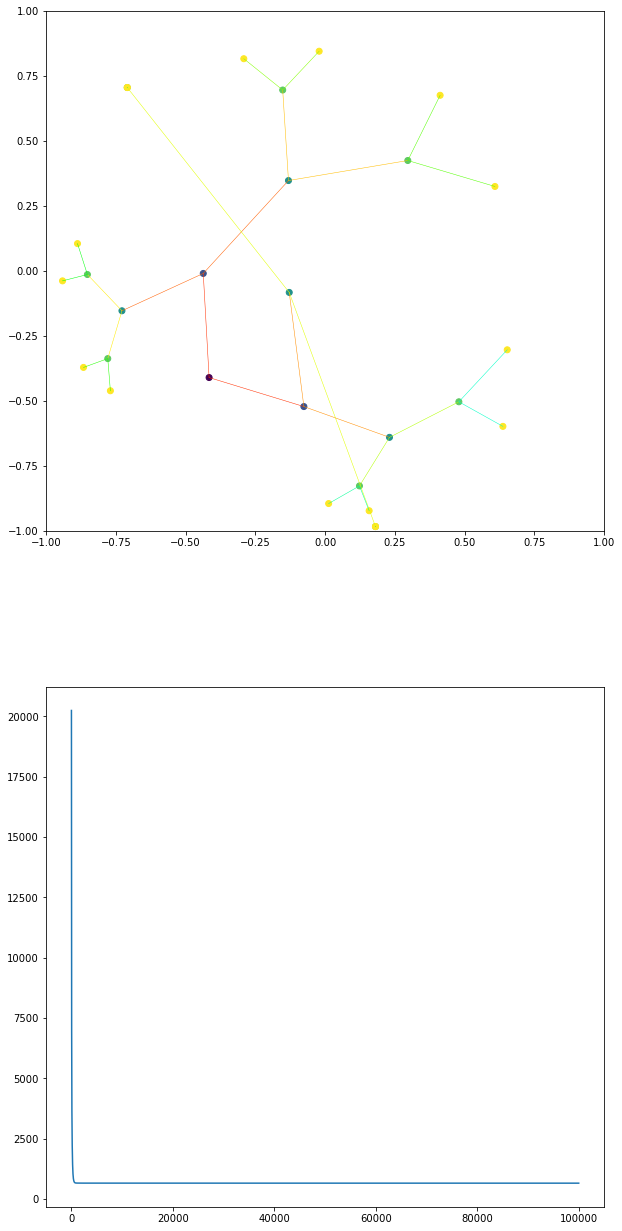

In [2]:
### Hyperbolic metric and Poincaré optimizer ###


import argparse

import torch
#import wandb

from OdorDataset import OdorMonoDataset
from utils.helpers import *
from methods import *
from optimizers import *
from torch.utils.data import DataLoader
from utils.visulization import *
import uuid
from utils.helpers import set_seeds
import scipy
def hasone(node_index, dim_index):
    bin_i, bin_j = np.binary_repr(node_index), np.binary_repr(dim_index)
    length = len(bin_j)
    return (bin_i[:length] == bin_j) * 1


def get_tree_data(depth, dtype=np.float32):
    n = 2 ** depth - 1
    x = np.fromfunction(lambda i, j: np.vectorize(hasone)(i + 1, j + 1),
                        (n, n), dtype=np.int32).astype(dtype)
    # print(x.shape)
    return x

import sys
if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = sys.argv[:1]


if __name__ == "__main__":
    # add arguments


    # wandb.init(project='hyperbolic_smell')
    # wandb.config = args

    # args = wandb.config
    # args.random_string = uuid.uuid4().hex

    # plt.savefig(f"figs2/{args.depth}/{args.latent_dist_fun}/{args.normalize}/{args.model_name}/{args.optimizer}/{args.lr}/{args.temperature}/{args.random_string}_{args.num_epochs}_{args.seed}_{args.dataset_name}.png")

    parser = argparse.ArgumentParser('Hyperbolic Smell')
    parser.add_argument('--representation_name', type=str, default='molformer')
    parser.add_argument('--batch_size', type=int, default=2048)
    parser.add_argument('--num_epochs', type=int, default=100000)
    parser.add_argument('--min_dist', type=float, default=1.)
    parser.add_argument('--latent_dim', type=int, default=2)
    parser.add_argument('--lr', type=float, default=0.001)
    parser.add_argument('--seed', type=int, default=2025)
    parser.add_argument('--base_dir', type=str,
                        default='../../../T5 EVO/alignment_olfaction_datasets/curated_datasets/')

    parser.add_argument('--dataset_name', type=str, default='tree')
    parser.add_argument('--normalize', type=bool, default=True)
    parser.add_argument('--optimizer', type=str, default='poincare', choices=['standard', 'poincare'])
    parser.add_argument('--model_name', type=str, default='contrastive', choices=['isomap', 'mds', 'contrastive'])
    parser.add_argument('--latent_dist_fun', type=str, default='poincare', choices=['euclidean', 'poincare'])
    parser.add_argument('--distance_method', type=str, default='hamming', choices=['geo', 'graph', 'hamming'])
    parser.add_argument('--n_samples', type=int, default=200)
    parser.add_argument('--dim', type=int, default=768)
    parser.add_argument('--depth', type=bool, default=5)
    parser.add_argument('--temperature', type=float, default=0.9)
    # args = argparse.Namespace()
    args = parser.parse_args()
    dataset_name = args.dataset_name
    representation_name = args.representation_name
    num_epochs = args.num_epochs
    normalize = args.normalize
    # geodesic = args.geodesic
    # min_dist = args.min_dist
    latent_dim = args.latent_dim
    lr = args.lr
    seed = args.seed
    base_dir = args.base_dir
    optimizer = args.optimizer
    model_name = args.model_name
    latent_dist_fun = args.latent_dist_fun
    distance_method = args.distance_method
    # n_samples = args.n_samples
    # dim = args.dim
    depth = args.depth
    temperature = args.temperature

    ### Overwrite the batchsize ###
    args.batch_size = 2 ** args.depth - 1 #to get full batch
    batch_size = args.batch_size
    
    args.random_string = uuid.uuid4().hex
    set_seeds(seed)


    if dataset_name == 'tree':
        embeddings = get_tree_data(depth)
        ## binary_tree is a dataset of binary sequences.
        ## The root of the tree is the node 0: binary_tree[0]
        ## groundtruth distance from node i to the root of the tree (i.e. shortest path distance from node i to the root): hamming_distance(binary_tree[0], binary_tree[i])
        ## For visualizations, one can color a node by its groundtruth distance to the tree.
    elif dataset_name == 'random':
        embeddings  = torch.randn(n_samples, dim)
    else:
        input_embeddings = f'embeddings/{representation_name}/{dataset_name}_{representation_name}_embeddings_13_Apr17.csv'
        embeddings = read_embeddings(base_dir, select_descriptors(dataset_name), input_embeddings, grand_avg=True if dataset_name == 'keller' else False)
    dataset = OdorMonoDataset(embeddings, transform=None)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    if latent_dist_fun != 'euclidean' and latent_dist_fun != 'poincare':
        raise ValueError('Latent distance function not recognized')
    if model_name == 'isomap':
        model = Isomap(len(dataset), latent_dim, Euclidean if latent_dist_fun == 'euclidean' else Poincare)
    elif model_name == 'mds':
        model = MDS(len(dataset), latent_dim, Euclidean if latent_dist_fun == 'euclidean' else Poincare)
    elif model_name == 'contrastive':
        model = Contrastive(len(dataset), latent_dim, Euclidean if latent_dist_fun == 'euclidean' else Poincare)
    else:
        raise ValueError('Model not recognized')
    if optimizer == 'standard':
        optimizer = StandardOptim(model, lr=lr)
    elif optimizer == 'poincare':
        optimizer = PoincareOptim(model, lr=lr)
    else:
        raise ValueError('Optimizer not recognized')
    losses = []
    # wandb.watch(model)
    for i in range(num_epochs):
        total_loss=0
        for idx, batch in data_loader:
            if normalize:
                model.normalize()
            if distance_method == 'graph':
                data_nn_matrix = nngraph_distance(batch,n_neighbors=3,metric='minkowski')
                # print(data_nn_matrix)
                data_dist_matrix = (data_nn_matrix > 0).astype(int)
                data_dist_matrix = torch.tensor(data_dist_matrix)
                # print(data_dist_matrix)
            elif distance_method == 'geo':
                data_dist_matrix = geo_distance(batch)
            elif distance_method == 'hamming':
                data_dist_matrix = hamming_distance_matrix(batch)
                if model_name == 'contrastive':
                    data_binary_dist_matrix = (data_dist_matrix <= 1.01).astype(int)
                    data_binary_dist_matrix = torch.tensor(data_binary_dist_matrix)
                data_dist_matrix = torch.tensor(data_dist_matrix)
            else:
                data_dist_matrix = dist_matrix(batch, Euclidean)
            # if geodesic:
            #     data_dist_matrix = geo_distance(batch)
            # else:
            #     data_dist_matrix = dist_matrix(batch, Euclidean)
            #binary matrix
            optimizer.zero_grad()
            loss = model.loss_fun(data_dist_matrix,idx, data_binary_dist_matrix, temperature)
            loss.backward()
            optimizer.step(idx)
            total_loss += loss.item()
        print(f'Epoch {i}, loss: {total_loss / len(data_loader):.3f}')
        losses.append(total_loss/len(data_loader))
        # wandb.log({'loss': total_loss/len(data_loader)})
            # print('norms', vector_norm(model.embeddings, dim=-1).mean().item(), vector_norm(model.embeddings, dim=-1).max().item())
        # if i % 10 == 0:


        # laten_embeddings_norm= torch.norm(model.embeddings, dim=-1).cpu().detach().numpy()
        # e=scipy.spatial.distance.cdist(data_loader.dataset.embeddings, data_loader.dataset.embeddings, metric='hamming')*data_loader.dataset.embeddings.shape[-1]
        # scatterplot_2d(losses, model.embeddings.detach().cpu().numpy(), laten_embeddings_norm, args=args, data_dist_matrix=e)
    scatterplot_2d(losses, model.embeddings,dataset.embeddings, args=args)

#

In [ ]:
### Euclidean metric and standard optimizer ###

import argparse

import torch
#import wandb

from OdorDataset import OdorMonoDataset
from utils.helpers import *
from methods import *
from optimizers import *
from torch.utils.data import DataLoader
from utils.visulization import *
import uuid
from utils.helpers import set_seeds
import scipy
def hasone(node_index, dim_index):
    bin_i, bin_j = np.binary_repr(node_index), np.binary_repr(dim_index)
    length = len(bin_j)
    return (bin_i[:length] == bin_j) * 1


def get_tree_data(depth, dtype=np.float32):
    n = 2 ** depth - 1
    x = np.fromfunction(lambda i, j: np.vectorize(hasone)(i + 1, j + 1),
                        (n, n), dtype=np.int32).astype(dtype)
    # print(x.shape)
    return x

import sys
if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = sys.argv[:1]


if __name__ == "__main__":
    # add arguments


    # wandb.init(project='hyperbolic_smell')
    # wandb.config = args

    # args = wandb.config
    # args.random_string = uuid.uuid4().hex

    # plt.savefig(f"figs2/{args.depth}/{args.latent_dist_fun}/{args.normalize}/{args.model_name}/{args.optimizer}/{args.lr}/{args.temperature}/{args.random_string}_{args.num_epochs}_{args.seed}_{args.dataset_name}.png")

    parser = argparse.ArgumentParser('Hyperbolic Smell')
    parser.add_argument('--representation_name', type=str, default='molformer')
    parser.add_argument('--batch_size', type=int, default=2048)
    parser.add_argument('--num_epochs', type=int, default=100000)
    parser.add_argument('--min_dist', type=float, default=1.)
    parser.add_argument('--latent_dim', type=int, default=2)
    parser.add_argument('--lr', type=float, default=0.001)
    parser.add_argument('--seed', type=int, default=2025)
    parser.add_argument('--base_dir', type=str,
                        default='../../../T5 EVO/alignment_olfaction_datasets/curated_datasets/')

    parser.add_argument('--dataset_name', type=str, default='tree')
    parser.add_argument('--normalize', type=bool, default=True)
    parser.add_argument('--optimizer', type=str, default='standard', choices=['standard', 'poincare'])
    parser.add_argument('--model_name', type=str, default='contrastive', choices=['isomap', 'mds', 'contrastive'])
    parser.add_argument('--latent_dist_fun', type=str, default='euclidean', choices=['euclidean', 'poincare'])
    parser.add_argument('--distance_method', type=str, default='hamming', choices=['geo', 'graph', 'hamming'])
    parser.add_argument('--n_samples', type=int, default=200)
    parser.add_argument('--dim', type=int, default=768)
    parser.add_argument('--depth', type=bool, default=5)
    parser.add_argument('--temperature', type=float, default=0.9)
    # args = argparse.Namespace()
    args = parser.parse_args()
    dataset_name = args.dataset_name
    representation_name = args.representation_name
    num_epochs = args.num_epochs
    normalize = args.normalize
    # geodesic = args.geodesic
    # min_dist = args.min_dist
    latent_dim = args.latent_dim
    lr = args.lr
    seed = args.seed
    base_dir = args.base_dir
    optimizer = args.optimizer
    model_name = args.model_name
    latent_dist_fun = args.latent_dist_fun
    distance_method = args.distance_method
    # n_samples = args.n_samples
    # dim = args.dim
    depth = args.depth
    temperature = args.temperature

    ### Overwrite the batchsize ###
    args.batch_size = 2 ** args.depth - 1 #to get full batch
    batch_size = args.batch_size
    
    args.random_string = uuid.uuid4().hex
    set_seeds(seed)


    if dataset_name == 'tree':
        embeddings = get_tree_data(depth)
        ## binary_tree is a dataset of binary sequences.
        ## The root of the tree is the node 0: binary_tree[0]
        ## groundtruth distance from node i to the root of the tree (i.e. shortest path distance from node i to the root): hamming_distance(binary_tree[0], binary_tree[i])
        ## For visualizations, one can color a node by its groundtruth distance to the tree.
    elif dataset_name == 'random':
        embeddings  = torch.randn(n_samples, dim)
    else:
        input_embeddings = f'embeddings/{representation_name}/{dataset_name}_{representation_name}_embeddings_13_Apr17.csv'
        embeddings = read_embeddings(base_dir, select_descriptors(dataset_name), input_embeddings, grand_avg=True if dataset_name == 'keller' else False)
    dataset = OdorMonoDataset(embeddings, transform=None)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    if latent_dist_fun != 'euclidean' and latent_dist_fun != 'poincare':
        raise ValueError('Latent distance function not recognized')
    if model_name == 'isomap':
        model = Isomap(len(dataset), latent_dim, Euclidean if latent_dist_fun == 'euclidean' else Poincare)
    elif model_name == 'mds':
        model = MDS(len(dataset), latent_dim, Euclidean if latent_dist_fun == 'euclidean' else Poincare)
    elif model_name == 'contrastive':
        model = Contrastive(len(dataset), latent_dim, Euclidean if latent_dist_fun == 'euclidean' else Poincare)
    else:
        raise ValueError('Model not recognized')
    if optimizer == 'standard':
        optimizer = StandardOptim(model, lr=lr)
    elif optimizer == 'poincare':
        optimizer = PoincareOptim(model, lr=lr)
    else:
        raise ValueError('Optimizer not recognized')
    losses = []
    # wandb.watch(model)
    for i in range(num_epochs):
        total_loss=0
        for idx, batch in data_loader:
            if normalize:
                model.normalize()
            if distance_method == 'graph':
                data_nn_matrix = nngraph_distance(batch,n_neighbors=3,metric='minkowski')
                # print(data_nn_matrix)
                data_dist_matrix = (data_nn_matrix > 0).astype(int)
                data_dist_matrix = torch.tensor(data_dist_matrix)
                # print(data_dist_matrix)
            elif distance_method == 'geo':
                data_dist_matrix = geo_distance(batch)
            elif distance_method == 'hamming':
                data_dist_matrix = hamming_distance_matrix(batch)
                if model_name == 'contrastive':
                    data_binary_dist_matrix = (data_dist_matrix <= 1.01).astype(int)
                    data_binary_dist_matrix = torch.tensor(data_binary_dist_matrix)
                data_dist_matrix = torch.tensor(data_dist_matrix)
            else:
                data_dist_matrix = dist_matrix(batch, Euclidean)
            # if geodesic:
            #     data_dist_matrix = geo_distance(batch)
            # else:
            #     data_dist_matrix = dist_matrix(batch, Euclidean)
            #binary matrix
            optimizer.zero_grad()
            loss = model.loss_fun(data_dist_matrix,idx, data_binary_dist_matrix, temperature)
            loss.backward()
            optimizer.step(idx)
            total_loss += loss.item()
        print(f'Epoch {i}, loss: {total_loss / len(data_loader):.3f}')
        losses.append(total_loss/len(data_loader))
        # wandb.log({'loss': total_loss/len(data_loader)})
            # print('norms', vector_norm(model.embeddings, dim=-1).mean().item(), vector_norm(model.embeddings, dim=-1).max().item())
        # if i % 10 == 0:


        # laten_embeddings_norm= torch.norm(model.embeddings, dim=-1).cpu().detach().numpy()
        # e=scipy.spatial.distance.cdist(data_loader.dataset.embeddings, data_loader.dataset.embeddings, metric='hamming')*data_loader.dataset.embeddings.shape[-1]
        # scatterplot_2d(losses, model.embeddings.detach().cpu().numpy(), laten_embeddings_norm, args=args, data_dist_matrix=e)
    scatterplot_2d(losses, model.embeddings,dataset.embeddings, args=args)

#

Epoch 0, loss: 65.941
Epoch 1, loss: 65.298
Epoch 2, loss: 64.674
Epoch 3, loss: 64.068
Epoch 4, loss: 63.480
Epoch 5, loss: 62.909
Epoch 6, loss: 62.356
Epoch 7, loss: 61.819
Epoch 8, loss: 61.297
Epoch 9, loss: 60.792
Epoch 10, loss: 60.301
Epoch 11, loss: 59.826
Epoch 12, loss: 59.364
Epoch 13, loss: 58.916
Epoch 14, loss: 58.482
Epoch 15, loss: 58.061
Epoch 16, loss: 57.652
Epoch 17, loss: 57.256
Epoch 18, loss: 56.872
Epoch 19, loss: 56.499
Epoch 20, loss: 56.137
Epoch 21, loss: 55.786
Epoch 22, loss: 55.446
Epoch 23, loss: 55.115
Epoch 24, loss: 54.795
Epoch 25, loss: 54.484
Epoch 26, loss: 54.182
Epoch 27, loss: 53.889
Epoch 28, loss: 53.604
Epoch 29, loss: 53.328
Epoch 30, loss: 53.061
Epoch 31, loss: 52.801
Epoch 32, loss: 52.548
Epoch 33, loss: 52.303
Epoch 34, loss: 52.065
Epoch 35, loss: 51.834
Epoch 36, loss: 51.609
Epoch 37, loss: 51.391
Epoch 38, loss: 51.180
Epoch 39, loss: 50.974
Epoch 40, loss: 50.774
Epoch 41, loss: 50.580
Epoch 42, loss: 50.391
Epoch 43, loss: 50.20

Epoch 515, loss: 40.781
Epoch 516, loss: 40.780
Epoch 517, loss: 40.779
Epoch 518, loss: 40.778
Epoch 519, loss: 40.777
Epoch 520, loss: 40.776
Epoch 521, loss: 40.775
Epoch 522, loss: 40.773
Epoch 523, loss: 40.772
Epoch 524, loss: 40.771
Epoch 525, loss: 40.770
Epoch 526, loss: 40.769
Epoch 527, loss: 40.768
Epoch 528, loss: 40.767
Epoch 529, loss: 40.766
Epoch 530, loss: 40.765
Epoch 531, loss: 40.763
Epoch 532, loss: 40.762
Epoch 533, loss: 40.761
Epoch 534, loss: 40.760
Epoch 535, loss: 40.759
Epoch 536, loss: 40.758
Epoch 537, loss: 40.757
Epoch 538, loss: 40.756
Epoch 539, loss: 40.755
Epoch 540, loss: 40.754
Epoch 541, loss: 40.753
Epoch 542, loss: 40.752
Epoch 543, loss: 40.751
Epoch 544, loss: 40.750
Epoch 545, loss: 40.749
Epoch 546, loss: 40.748
Epoch 547, loss: 40.747
Epoch 548, loss: 40.746
Epoch 549, loss: 40.745
Epoch 550, loss: 40.744
Epoch 551, loss: 40.743
Epoch 552, loss: 40.742
Epoch 553, loss: 40.741
Epoch 554, loss: 40.740
Epoch 555, loss: 40.739
Epoch 556, loss:

Epoch 1009, loss: 40.544
Epoch 1010, loss: 40.544
Epoch 1011, loss: 40.544
Epoch 1012, loss: 40.543
Epoch 1013, loss: 40.543
Epoch 1014, loss: 40.543
Epoch 1015, loss: 40.543
Epoch 1016, loss: 40.543
Epoch 1017, loss: 40.542
Epoch 1018, loss: 40.542
Epoch 1019, loss: 40.542
Epoch 1020, loss: 40.542
Epoch 1021, loss: 40.542
Epoch 1022, loss: 40.541
Epoch 1023, loss: 40.541
Epoch 1024, loss: 40.541
Epoch 1025, loss: 40.541
Epoch 1026, loss: 40.541
Epoch 1027, loss: 40.541
Epoch 1028, loss: 40.540
Epoch 1029, loss: 40.540
Epoch 1030, loss: 40.540
Epoch 1031, loss: 40.540
Epoch 1032, loss: 40.540
Epoch 1033, loss: 40.539
Epoch 1034, loss: 40.539
Epoch 1035, loss: 40.539
Epoch 1036, loss: 40.539
Epoch 1037, loss: 40.539
Epoch 1038, loss: 40.538
Epoch 1039, loss: 40.538
Epoch 1040, loss: 40.538
Epoch 1041, loss: 40.538
Epoch 1042, loss: 40.538
Epoch 1043, loss: 40.538
Epoch 1044, loss: 40.537
Epoch 1045, loss: 40.537
Epoch 1046, loss: 40.537
Epoch 1047, loss: 40.537
Epoch 1048, loss: 40.537


Epoch 1479, loss: 40.483
Epoch 1480, loss: 40.483
Epoch 1481, loss: 40.483
Epoch 1482, loss: 40.482
Epoch 1483, loss: 40.482
Epoch 1484, loss: 40.482
Epoch 1485, loss: 40.482
Epoch 1486, loss: 40.482
Epoch 1487, loss: 40.482
Epoch 1488, loss: 40.482
Epoch 1489, loss: 40.482
Epoch 1490, loss: 40.482
Epoch 1491, loss: 40.482
Epoch 1492, loss: 40.482
Epoch 1493, loss: 40.481
Epoch 1494, loss: 40.481
Epoch 1495, loss: 40.481
Epoch 1496, loss: 40.481
Epoch 1497, loss: 40.481
Epoch 1498, loss: 40.481
Epoch 1499, loss: 40.481
Epoch 1500, loss: 40.481
Epoch 1501, loss: 40.481
Epoch 1502, loss: 40.481
Epoch 1503, loss: 40.481
Epoch 1504, loss: 40.481
Epoch 1505, loss: 40.480
Epoch 1506, loss: 40.480
Epoch 1507, loss: 40.480
Epoch 1508, loss: 40.480
Epoch 1509, loss: 40.480
Epoch 1510, loss: 40.480
Epoch 1511, loss: 40.480
Epoch 1512, loss: 40.480
Epoch 1513, loss: 40.480
Epoch 1514, loss: 40.480
Epoch 1515, loss: 40.480
Epoch 1516, loss: 40.479
Epoch 1517, loss: 40.479
Epoch 1518, loss: 40.479


Epoch 1955, loss: 40.448
Epoch 1956, loss: 40.448
Epoch 1957, loss: 40.448
Epoch 1958, loss: 40.448
Epoch 1959, loss: 40.448
Epoch 1960, loss: 40.448
Epoch 1961, loss: 40.448
Epoch 1962, loss: 40.448
Epoch 1963, loss: 40.448
Epoch 1964, loss: 40.448
Epoch 1965, loss: 40.448
Epoch 1966, loss: 40.448
Epoch 1967, loss: 40.448
Epoch 1968, loss: 40.448
Epoch 1969, loss: 40.448
Epoch 1970, loss: 40.448
Epoch 1971, loss: 40.448
Epoch 1972, loss: 40.447
Epoch 1973, loss: 40.447
Epoch 1974, loss: 40.447
Epoch 1975, loss: 40.447
Epoch 1976, loss: 40.447
Epoch 1977, loss: 40.447
Epoch 1978, loss: 40.447
Epoch 1979, loss: 40.447
Epoch 1980, loss: 40.447
Epoch 1981, loss: 40.447
Epoch 1982, loss: 40.447
Epoch 1983, loss: 40.447
Epoch 1984, loss: 40.447
Epoch 1985, loss: 40.447
Epoch 1986, loss: 40.447
Epoch 1987, loss: 40.447
Epoch 1988, loss: 40.447
Epoch 1989, loss: 40.447
Epoch 1990, loss: 40.446
Epoch 1991, loss: 40.446
Epoch 1992, loss: 40.446
Epoch 1993, loss: 40.446
Epoch 1994, loss: 40.446


Epoch 2408, loss: 40.425
Epoch 2409, loss: 40.425
Epoch 2410, loss: 40.425
Epoch 2411, loss: 40.425
Epoch 2412, loss: 40.425
Epoch 2413, loss: 40.425
Epoch 2414, loss: 40.425
Epoch 2415, loss: 40.425
Epoch 2416, loss: 40.425
Epoch 2417, loss: 40.424
Epoch 2418, loss: 40.424
Epoch 2419, loss: 40.424
Epoch 2420, loss: 40.424
Epoch 2421, loss: 40.424
Epoch 2422, loss: 40.424
Epoch 2423, loss: 40.424
Epoch 2424, loss: 40.424
Epoch 2425, loss: 40.424
Epoch 2426, loss: 40.424
Epoch 2427, loss: 40.424
Epoch 2428, loss: 40.424
Epoch 2429, loss: 40.424
Epoch 2430, loss: 40.424
Epoch 2431, loss: 40.424
Epoch 2432, loss: 40.424
Epoch 2433, loss: 40.424
Epoch 2434, loss: 40.424
Epoch 2435, loss: 40.424
Epoch 2436, loss: 40.424
Epoch 2437, loss: 40.424
Epoch 2438, loss: 40.424
Epoch 2439, loss: 40.423
Epoch 2440, loss: 40.423
Epoch 2441, loss: 40.423
Epoch 2442, loss: 40.423
Epoch 2443, loss: 40.423
Epoch 2444, loss: 40.423
Epoch 2445, loss: 40.423
Epoch 2446, loss: 40.423
Epoch 2447, loss: 40.423


Epoch 2863, loss: 40.405
Epoch 2864, loss: 40.405
Epoch 2865, loss: 40.405
Epoch 2866, loss: 40.405
Epoch 2867, loss: 40.404
Epoch 2868, loss: 40.404
Epoch 2869, loss: 40.404
Epoch 2870, loss: 40.404
Epoch 2871, loss: 40.404
Epoch 2872, loss: 40.404
Epoch 2873, loss: 40.404
Epoch 2874, loss: 40.404
Epoch 2875, loss: 40.404
Epoch 2876, loss: 40.404
Epoch 2877, loss: 40.404
Epoch 2878, loss: 40.404
Epoch 2879, loss: 40.404
Epoch 2880, loss: 40.404
Epoch 2881, loss: 40.404
Epoch 2882, loss: 40.404
Epoch 2883, loss: 40.404
Epoch 2884, loss: 40.404
Epoch 2885, loss: 40.404
Epoch 2886, loss: 40.404
Epoch 2887, loss: 40.404
Epoch 2888, loss: 40.404
Epoch 2889, loss: 40.404
Epoch 2890, loss: 40.404
Epoch 2891, loss: 40.403
Epoch 2892, loss: 40.403
Epoch 2893, loss: 40.403
Epoch 2894, loss: 40.403
Epoch 2895, loss: 40.403
Epoch 2896, loss: 40.403
Epoch 2897, loss: 40.403
Epoch 2898, loss: 40.403
Epoch 2899, loss: 40.403
Epoch 2900, loss: 40.403
Epoch 2901, loss: 40.403
Epoch 2902, loss: 40.403


Epoch 3332, loss: 40.386
Epoch 3333, loss: 40.386
Epoch 3334, loss: 40.386
Epoch 3335, loss: 40.386
Epoch 3336, loss: 40.386
Epoch 3337, loss: 40.386
Epoch 3338, loss: 40.385
Epoch 3339, loss: 40.385
Epoch 3340, loss: 40.385
Epoch 3341, loss: 40.385
Epoch 3342, loss: 40.385
Epoch 3343, loss: 40.385
Epoch 3344, loss: 40.385
Epoch 3345, loss: 40.385
Epoch 3346, loss: 40.385
Epoch 3347, loss: 40.385
Epoch 3348, loss: 40.385
Epoch 3349, loss: 40.385
Epoch 3350, loss: 40.385
Epoch 3351, loss: 40.385
Epoch 3352, loss: 40.385
Epoch 3353, loss: 40.385
Epoch 3354, loss: 40.385
Epoch 3355, loss: 40.385
Epoch 3356, loss: 40.385
Epoch 3357, loss: 40.385
Epoch 3358, loss: 40.385
Epoch 3359, loss: 40.385
Epoch 3360, loss: 40.385
Epoch 3361, loss: 40.385
Epoch 3362, loss: 40.385
Epoch 3363, loss: 40.384
Epoch 3364, loss: 40.384
Epoch 3365, loss: 40.384
Epoch 3366, loss: 40.384
Epoch 3367, loss: 40.384
Epoch 3368, loss: 40.384
Epoch 3369, loss: 40.384
Epoch 3370, loss: 40.384
Epoch 3371, loss: 40.384


Epoch 3869, loss: 40.366
Epoch 3870, loss: 40.366
Epoch 3871, loss: 40.366
Epoch 3872, loss: 40.366
Epoch 3873, loss: 40.366
Epoch 3874, loss: 40.365
Epoch 3875, loss: 40.365
Epoch 3876, loss: 40.365
Epoch 3877, loss: 40.365
Epoch 3878, loss: 40.365
Epoch 3879, loss: 40.365
Epoch 3880, loss: 40.365
Epoch 3881, loss: 40.365
Epoch 3882, loss: 40.365
Epoch 3883, loss: 40.365
Epoch 3884, loss: 40.365
Epoch 3885, loss: 40.365
Epoch 3886, loss: 40.365
Epoch 3887, loss: 40.365
Epoch 3888, loss: 40.365
Epoch 3889, loss: 40.365
Epoch 3890, loss: 40.365
Epoch 3891, loss: 40.365
Epoch 3892, loss: 40.365
Epoch 3893, loss: 40.365
Epoch 3894, loss: 40.365
Epoch 3895, loss: 40.365
Epoch 3896, loss: 40.365
Epoch 3897, loss: 40.365
Epoch 3898, loss: 40.365
Epoch 3899, loss: 40.365
Epoch 3900, loss: 40.365
Epoch 3901, loss: 40.365
Epoch 3902, loss: 40.364
Epoch 3903, loss: 40.364
Epoch 3904, loss: 40.364
Epoch 3905, loss: 40.364
Epoch 3906, loss: 40.364
Epoch 3907, loss: 40.364
Epoch 3908, loss: 40.364


Epoch 4384, loss: 40.348
Epoch 4385, loss: 40.348
Epoch 4386, loss: 40.348
Epoch 4387, loss: 40.348
Epoch 4388, loss: 40.348
Epoch 4389, loss: 40.348
Epoch 4390, loss: 40.348
Epoch 4391, loss: 40.348
Epoch 4392, loss: 40.348
Epoch 4393, loss: 40.348
Epoch 4394, loss: 40.347
Epoch 4395, loss: 40.347
Epoch 4396, loss: 40.347
Epoch 4397, loss: 40.347
Epoch 4398, loss: 40.347
Epoch 4399, loss: 40.347
Epoch 4400, loss: 40.347
Epoch 4401, loss: 40.347
Epoch 4402, loss: 40.347
Epoch 4403, loss: 40.347
Epoch 4404, loss: 40.347
Epoch 4405, loss: 40.347
Epoch 4406, loss: 40.347
Epoch 4407, loss: 40.347
Epoch 4408, loss: 40.347
Epoch 4409, loss: 40.347
Epoch 4410, loss: 40.347
Epoch 4411, loss: 40.347
Epoch 4412, loss: 40.347
Epoch 4413, loss: 40.347
Epoch 4414, loss: 40.347
Epoch 4415, loss: 40.347
Epoch 4416, loss: 40.347
Epoch 4417, loss: 40.347
Epoch 4418, loss: 40.347
Epoch 4419, loss: 40.347
Epoch 4420, loss: 40.347
Epoch 4421, loss: 40.347
Epoch 4422, loss: 40.347
Epoch 4423, loss: 40.346


Epoch 4879, loss: 40.332
Epoch 4880, loss: 40.332
Epoch 4881, loss: 40.332
Epoch 4882, loss: 40.332
Epoch 4883, loss: 40.332
Epoch 4884, loss: 40.331
Epoch 4885, loss: 40.331
Epoch 4886, loss: 40.331
Epoch 4887, loss: 40.331
Epoch 4888, loss: 40.331
Epoch 4889, loss: 40.331
Epoch 4890, loss: 40.331
Epoch 4891, loss: 40.331
Epoch 4892, loss: 40.331
Epoch 4893, loss: 40.331
Epoch 4894, loss: 40.331
Epoch 4895, loss: 40.331
Epoch 4896, loss: 40.331
Epoch 4897, loss: 40.331
Epoch 4898, loss: 40.331
Epoch 4899, loss: 40.331
Epoch 4900, loss: 40.331
Epoch 4901, loss: 40.331
Epoch 4902, loss: 40.331
Epoch 4903, loss: 40.331
Epoch 4904, loss: 40.331
Epoch 4905, loss: 40.331
Epoch 4906, loss: 40.331
Epoch 4907, loss: 40.331
Epoch 4908, loss: 40.331
Epoch 4909, loss: 40.331
Epoch 4910, loss: 40.331
Epoch 4911, loss: 40.331
Epoch 4912, loss: 40.331
Epoch 4913, loss: 40.331
Epoch 4914, loss: 40.331
Epoch 4915, loss: 40.330
Epoch 4916, loss: 40.330
Epoch 4917, loss: 40.330
Epoch 4918, loss: 40.330


Epoch 5404, loss: 40.316
Epoch 5405, loss: 40.316
Epoch 5406, loss: 40.316
Epoch 5407, loss: 40.316
Epoch 5408, loss: 40.316
Epoch 5409, loss: 40.316
Epoch 5410, loss: 40.316
Epoch 5411, loss: 40.316
Epoch 5412, loss: 40.316
Epoch 5413, loss: 40.316
Epoch 5414, loss: 40.316
Epoch 5415, loss: 40.316
Epoch 5416, loss: 40.316
Epoch 5417, loss: 40.316
Epoch 5418, loss: 40.316
Epoch 5419, loss: 40.316
Epoch 5420, loss: 40.316
Epoch 5421, loss: 40.316
Epoch 5422, loss: 40.316
Epoch 5423, loss: 40.316
Epoch 5424, loss: 40.316
Epoch 5425, loss: 40.316
Epoch 5426, loss: 40.316
Epoch 5427, loss: 40.316
Epoch 5428, loss: 40.316
Epoch 5429, loss: 40.316
Epoch 5430, loss: 40.316
Epoch 5431, loss: 40.316
Epoch 5432, loss: 40.316
Epoch 5433, loss: 40.316
Epoch 5434, loss: 40.316
Epoch 5435, loss: 40.316
Epoch 5436, loss: 40.316
Epoch 5437, loss: 40.316
Epoch 5438, loss: 40.315
Epoch 5439, loss: 40.315
Epoch 5440, loss: 40.315
Epoch 5441, loss: 40.315
Epoch 5442, loss: 40.315
Epoch 5443, loss: 40.315


Epoch 5905, loss: 40.305
Epoch 5906, loss: 40.305
Epoch 5907, loss: 40.305
Epoch 5908, loss: 40.305
Epoch 5909, loss: 40.305
Epoch 5910, loss: 40.305
Epoch 5911, loss: 40.305
Epoch 5912, loss: 40.305
Epoch 5913, loss: 40.305
Epoch 5914, loss: 40.305
Epoch 5915, loss: 40.305
Epoch 5916, loss: 40.305
Epoch 5917, loss: 40.305
Epoch 5918, loss: 40.305
Epoch 5919, loss: 40.305
Epoch 5920, loss: 40.305
Epoch 5921, loss: 40.305
Epoch 5922, loss: 40.305
Epoch 5923, loss: 40.305
Epoch 5924, loss: 40.305
Epoch 5925, loss: 40.305
Epoch 5926, loss: 40.305
Epoch 5927, loss: 40.304
Epoch 5928, loss: 40.304
Epoch 5929, loss: 40.304
Epoch 5930, loss: 40.304
Epoch 5931, loss: 40.304
Epoch 5932, loss: 40.304
Epoch 5933, loss: 40.304
Epoch 5934, loss: 40.304
Epoch 5935, loss: 40.304
Epoch 5936, loss: 40.304
Epoch 5937, loss: 40.304
Epoch 5938, loss: 40.304
Epoch 5939, loss: 40.304
Epoch 5940, loss: 40.304
Epoch 5941, loss: 40.304
Epoch 5942, loss: 40.304
Epoch 5943, loss: 40.304
Epoch 5944, loss: 40.304


Epoch 6378, loss: 40.295
Epoch 6379, loss: 40.295
Epoch 6380, loss: 40.295
Epoch 6381, loss: 40.295
Epoch 6382, loss: 40.295
Epoch 6383, loss: 40.295
Epoch 6384, loss: 40.295
Epoch 6385, loss: 40.295
Epoch 6386, loss: 40.295
Epoch 6387, loss: 40.295
Epoch 6388, loss: 40.295
Epoch 6389, loss: 40.295
Epoch 6390, loss: 40.295
Epoch 6391, loss: 40.295
Epoch 6392, loss: 40.295
Epoch 6393, loss: 40.295
Epoch 6394, loss: 40.295
Epoch 6395, loss: 40.295
Epoch 6396, loss: 40.295
Epoch 6397, loss: 40.295
Epoch 6398, loss: 40.295
Epoch 6399, loss: 40.295
Epoch 6400, loss: 40.294
Epoch 6401, loss: 40.294
Epoch 6402, loss: 40.294
Epoch 6403, loss: 40.294
Epoch 6404, loss: 40.294
Epoch 6405, loss: 40.294
Epoch 6406, loss: 40.294
Epoch 6407, loss: 40.294
Epoch 6408, loss: 40.294
Epoch 6409, loss: 40.294
Epoch 6410, loss: 40.294
Epoch 6411, loss: 40.294
Epoch 6412, loss: 40.294
Epoch 6413, loss: 40.294
Epoch 6414, loss: 40.294
Epoch 6415, loss: 40.294
Epoch 6416, loss: 40.294
Epoch 6417, loss: 40.294


Epoch 6817, loss: 40.285
Epoch 6818, loss: 40.285
Epoch 6819, loss: 40.285
Epoch 6820, loss: 40.285
Epoch 6821, loss: 40.285
Epoch 6822, loss: 40.285
Epoch 6823, loss: 40.285
Epoch 6824, loss: 40.285
Epoch 6825, loss: 40.285
Epoch 6826, loss: 40.285
Epoch 6827, loss: 40.285
Epoch 6828, loss: 40.285
Epoch 6829, loss: 40.285
Epoch 6830, loss: 40.285
Epoch 6831, loss: 40.285
Epoch 6832, loss: 40.285
Epoch 6833, loss: 40.285
Epoch 6834, loss: 40.285
Epoch 6835, loss: 40.285
Epoch 6836, loss: 40.285
Epoch 6837, loss: 40.285
Epoch 6838, loss: 40.285
Epoch 6839, loss: 40.285
Epoch 6840, loss: 40.285
Epoch 6841, loss: 40.285
Epoch 6842, loss: 40.285
Epoch 6843, loss: 40.285
Epoch 6844, loss: 40.285
Epoch 6845, loss: 40.285
Epoch 6846, loss: 40.285
Epoch 6847, loss: 40.285
Epoch 6848, loss: 40.285
Epoch 6849, loss: 40.285
Epoch 6850, loss: 40.285
Epoch 6851, loss: 40.285
Epoch 6852, loss: 40.285
Epoch 6853, loss: 40.285
Epoch 6854, loss: 40.285
Epoch 6855, loss: 40.285
Epoch 6856, loss: 40.285


Epoch 7183, loss: 40.277
Epoch 7184, loss: 40.277
Epoch 7185, loss: 40.277
Epoch 7186, loss: 40.277
Epoch 7187, loss: 40.277
Epoch 7188, loss: 40.277
Epoch 7189, loss: 40.277
Epoch 7190, loss: 40.277
Epoch 7191, loss: 40.277
Epoch 7192, loss: 40.277
Epoch 7193, loss: 40.277
Epoch 7194, loss: 40.277
Epoch 7195, loss: 40.277
Epoch 7196, loss: 40.277
Epoch 7197, loss: 40.277
Epoch 7198, loss: 40.277
Epoch 7199, loss: 40.277
Epoch 7200, loss: 40.277
Epoch 7201, loss: 40.277
Epoch 7202, loss: 40.277
Epoch 7203, loss: 40.277
Epoch 7204, loss: 40.277
Epoch 7205, loss: 40.277
Epoch 7206, loss: 40.277
Epoch 7207, loss: 40.277
Epoch 7208, loss: 40.277
Epoch 7209, loss: 40.277
Epoch 7210, loss: 40.277
Epoch 7211, loss: 40.277
Epoch 7212, loss: 40.277
Epoch 7213, loss: 40.277
Epoch 7214, loss: 40.277
Epoch 7215, loss: 40.277
Epoch 7216, loss: 40.277
Epoch 7217, loss: 40.277
Epoch 7218, loss: 40.277
Epoch 7219, loss: 40.277
Epoch 7220, loss: 40.277
Epoch 7221, loss: 40.277
Epoch 7222, loss: 40.277


Epoch 7620, loss: 40.267
Epoch 7621, loss: 40.267
Epoch 7622, loss: 40.267
Epoch 7623, loss: 40.267
Epoch 7624, loss: 40.267
Epoch 7625, loss: 40.267
Epoch 7626, loss: 40.267
Epoch 7627, loss: 40.267
Epoch 7628, loss: 40.267
Epoch 7629, loss: 40.267
Epoch 7630, loss: 40.267
Epoch 7631, loss: 40.267
Epoch 7632, loss: 40.267
Epoch 7633, loss: 40.267
Epoch 7634, loss: 40.267
Epoch 7635, loss: 40.267
Epoch 7636, loss: 40.267
Epoch 7637, loss: 40.267
Epoch 7638, loss: 40.267
Epoch 7639, loss: 40.267
Epoch 7640, loss: 40.267
Epoch 7641, loss: 40.267
Epoch 7642, loss: 40.267
Epoch 7643, loss: 40.267
Epoch 7644, loss: 40.267
Epoch 7645, loss: 40.267
Epoch 7646, loss: 40.267
Epoch 7647, loss: 40.267
Epoch 7648, loss: 40.267
Epoch 7649, loss: 40.267
Epoch 7650, loss: 40.267
Epoch 7651, loss: 40.267
Epoch 7652, loss: 40.267
Epoch 7653, loss: 40.267
Epoch 7654, loss: 40.267
Epoch 7655, loss: 40.267
Epoch 7656, loss: 40.267
Epoch 7657, loss: 40.267
Epoch 7658, loss: 40.267
Epoch 7659, loss: 40.267


Epoch 8055, loss: 40.258
Epoch 8056, loss: 40.258
Epoch 8057, loss: 40.258
Epoch 8058, loss: 40.258
Epoch 8059, loss: 40.258
Epoch 8060, loss: 40.258
Epoch 8061, loss: 40.258
Epoch 8062, loss: 40.258
Epoch 8063, loss: 40.258
Epoch 8064, loss: 40.258
Epoch 8065, loss: 40.258
Epoch 8066, loss: 40.258
Epoch 8067, loss: 40.258
Epoch 8068, loss: 40.258
Epoch 8069, loss: 40.258
Epoch 8070, loss: 40.258
Epoch 8071, loss: 40.258
Epoch 8072, loss: 40.258
Epoch 8073, loss: 40.258
Epoch 8074, loss: 40.258
Epoch 8075, loss: 40.258
Epoch 8076, loss: 40.258
Epoch 8077, loss: 40.258
Epoch 8078, loss: 40.258
Epoch 8079, loss: 40.258
Epoch 8080, loss: 40.258
Epoch 8081, loss: 40.257
Epoch 8082, loss: 40.257
Epoch 8083, loss: 40.257
Epoch 8084, loss: 40.257
Epoch 8085, loss: 40.257
Epoch 8086, loss: 40.257
Epoch 8087, loss: 40.257
Epoch 8088, loss: 40.257
Epoch 8089, loss: 40.257
Epoch 8090, loss: 40.257
Epoch 8091, loss: 40.257
Epoch 8092, loss: 40.257
Epoch 8093, loss: 40.257
Epoch 8094, loss: 40.257


Epoch 8482, loss: 40.249
Epoch 8483, loss: 40.249
Epoch 8484, loss: 40.249
Epoch 8485, loss: 40.249
Epoch 8486, loss: 40.249
Epoch 8487, loss: 40.249
Epoch 8488, loss: 40.249
Epoch 8489, loss: 40.249
Epoch 8490, loss: 40.249
Epoch 8491, loss: 40.249
Epoch 8492, loss: 40.249
Epoch 8493, loss: 40.249
Epoch 8494, loss: 40.249
Epoch 8495, loss: 40.249
Epoch 8496, loss: 40.249
Epoch 8497, loss: 40.249
Epoch 8498, loss: 40.249
Epoch 8499, loss: 40.249
Epoch 8500, loss: 40.249
Epoch 8501, loss: 40.249
Epoch 8502, loss: 40.249
Epoch 8503, loss: 40.249
Epoch 8504, loss: 40.249
Epoch 8505, loss: 40.249
Epoch 8506, loss: 40.249
Epoch 8507, loss: 40.249
Epoch 8508, loss: 40.249
Epoch 8509, loss: 40.249
Epoch 8510, loss: 40.249
Epoch 8511, loss: 40.249
Epoch 8512, loss: 40.249
Epoch 8513, loss: 40.249
Epoch 8514, loss: 40.248
Epoch 8515, loss: 40.248
Epoch 8516, loss: 40.248
Epoch 8517, loss: 40.248
Epoch 8518, loss: 40.248
Epoch 8519, loss: 40.248
Epoch 8520, loss: 40.248
Epoch 8521, loss: 40.248


Epoch 8891, loss: 40.242
Epoch 8892, loss: 40.242
Epoch 8893, loss: 40.242
Epoch 8894, loss: 40.242
Epoch 8895, loss: 40.242
Epoch 8896, loss: 40.242
Epoch 8897, loss: 40.242
Epoch 8898, loss: 40.242
Epoch 8899, loss: 40.242
Epoch 8900, loss: 40.242
Epoch 8901, loss: 40.242
Epoch 8902, loss: 40.242
Epoch 8903, loss: 40.242
Epoch 8904, loss: 40.242
Epoch 8905, loss: 40.242
Epoch 8906, loss: 40.241
Epoch 8907, loss: 40.241
Epoch 8908, loss: 40.241
Epoch 8909, loss: 40.241
Epoch 8910, loss: 40.241
Epoch 8911, loss: 40.241
Epoch 8912, loss: 40.241
Epoch 8913, loss: 40.241
Epoch 8914, loss: 40.241
Epoch 8915, loss: 40.241
Epoch 8916, loss: 40.241
Epoch 8917, loss: 40.241
Epoch 8918, loss: 40.241
Epoch 8919, loss: 40.241
Epoch 8920, loss: 40.241
Epoch 8921, loss: 40.241
Epoch 8922, loss: 40.241
Epoch 8923, loss: 40.241
Epoch 8924, loss: 40.241
Epoch 8925, loss: 40.241
Epoch 8926, loss: 40.241
Epoch 8927, loss: 40.241
Epoch 8928, loss: 40.241
Epoch 8929, loss: 40.241
Epoch 8930, loss: 40.241


Epoch 9306, loss: 40.234
Epoch 9307, loss: 40.234
Epoch 9308, loss: 40.234
Epoch 9309, loss: 40.234
Epoch 9310, loss: 40.234
Epoch 9311, loss: 40.234
Epoch 9312, loss: 40.234
Epoch 9313, loss: 40.234
Epoch 9314, loss: 40.234
Epoch 9315, loss: 40.234
Epoch 9316, loss: 40.234
Epoch 9317, loss: 40.234
Epoch 9318, loss: 40.234
Epoch 9319, loss: 40.234
Epoch 9320, loss: 40.234
Epoch 9321, loss: 40.234
Epoch 9322, loss: 40.234
Epoch 9323, loss: 40.234
Epoch 9324, loss: 40.234
Epoch 9325, loss: 40.234
Epoch 9326, loss: 40.234
Epoch 9327, loss: 40.234
Epoch 9328, loss: 40.234
Epoch 9329, loss: 40.234
Epoch 9330, loss: 40.234
Epoch 9331, loss: 40.234
Epoch 9332, loss: 40.234
Epoch 9333, loss: 40.234
Epoch 9334, loss: 40.234
Epoch 9335, loss: 40.234
Epoch 9336, loss: 40.234
Epoch 9337, loss: 40.234
Epoch 9338, loss: 40.234
Epoch 9339, loss: 40.234
Epoch 9340, loss: 40.234
Epoch 9341, loss: 40.234
Epoch 9342, loss: 40.234
Epoch 9343, loss: 40.234
Epoch 9344, loss: 40.234
Epoch 9345, loss: 40.234


Epoch 9756, loss: 40.228
Epoch 9757, loss: 40.228
Epoch 9758, loss: 40.228
Epoch 9759, loss: 40.228
Epoch 9760, loss: 40.228
Epoch 9761, loss: 40.228
Epoch 9762, loss: 40.228
Epoch 9763, loss: 40.228
Epoch 9764, loss: 40.228
Epoch 9765, loss: 40.228
Epoch 9766, loss: 40.228
Epoch 9767, loss: 40.228
Epoch 9768, loss: 40.228
Epoch 9769, loss: 40.228
Epoch 9770, loss: 40.228
Epoch 9771, loss: 40.228
Epoch 9772, loss: 40.228
Epoch 9773, loss: 40.228
Epoch 9774, loss: 40.228
Epoch 9775, loss: 40.228
Epoch 9776, loss: 40.228
Epoch 9777, loss: 40.228
Epoch 9778, loss: 40.228
Epoch 9779, loss: 40.228
Epoch 9780, loss: 40.228
Epoch 9781, loss: 40.228
Epoch 9782, loss: 40.228
Epoch 9783, loss: 40.228
Epoch 9784, loss: 40.228
Epoch 9785, loss: 40.228
Epoch 9786, loss: 40.228
Epoch 9787, loss: 40.228
Epoch 9788, loss: 40.228
Epoch 9789, loss: 40.228
Epoch 9790, loss: 40.228
Epoch 9791, loss: 40.228
Epoch 9792, loss: 40.228
Epoch 9793, loss: 40.228
Epoch 9794, loss: 40.228
Epoch 9795, loss: 40.228


Epoch 10174, loss: 40.223
Epoch 10175, loss: 40.222
Epoch 10176, loss: 40.222
Epoch 10177, loss: 40.222
Epoch 10178, loss: 40.222
Epoch 10179, loss: 40.222
Epoch 10180, loss: 40.222
Epoch 10181, loss: 40.222
Epoch 10182, loss: 40.222
Epoch 10183, loss: 40.222
Epoch 10184, loss: 40.222
Epoch 10185, loss: 40.222
Epoch 10186, loss: 40.222
Epoch 10187, loss: 40.222
Epoch 10188, loss: 40.222
Epoch 10189, loss: 40.222
Epoch 10190, loss: 40.222
Epoch 10191, loss: 40.222
Epoch 10192, loss: 40.222
Epoch 10193, loss: 40.222
Epoch 10194, loss: 40.222
Epoch 10195, loss: 40.222
Epoch 10196, loss: 40.222
Epoch 10197, loss: 40.222
Epoch 10198, loss: 40.222
Epoch 10199, loss: 40.222
Epoch 10200, loss: 40.222
Epoch 10201, loss: 40.222
Epoch 10202, loss: 40.222
Epoch 10203, loss: 40.222
Epoch 10204, loss: 40.222
Epoch 10205, loss: 40.222
Epoch 10206, loss: 40.222
Epoch 10207, loss: 40.222
Epoch 10208, loss: 40.222
Epoch 10209, loss: 40.222
Epoch 10210, loss: 40.222
Epoch 10211, loss: 40.222
Epoch 10212,

Epoch 10611, loss: 40.217
Epoch 10612, loss: 40.217
Epoch 10613, loss: 40.217
Epoch 10614, loss: 40.217
Epoch 10615, loss: 40.217
Epoch 10616, loss: 40.217
Epoch 10617, loss: 40.217
Epoch 10618, loss: 40.217
Epoch 10619, loss: 40.217
Epoch 10620, loss: 40.217
Epoch 10621, loss: 40.217
Epoch 10622, loss: 40.216
Epoch 10623, loss: 40.216
Epoch 10624, loss: 40.216
Epoch 10625, loss: 40.216
Epoch 10626, loss: 40.216
Epoch 10627, loss: 40.216
Epoch 10628, loss: 40.216
Epoch 10629, loss: 40.216
Epoch 10630, loss: 40.216
Epoch 10631, loss: 40.216
Epoch 10632, loss: 40.216
Epoch 10633, loss: 40.216
Epoch 10634, loss: 40.216
Epoch 10635, loss: 40.216
Epoch 10636, loss: 40.216
Epoch 10637, loss: 40.216
Epoch 10638, loss: 40.216
Epoch 10639, loss: 40.216
Epoch 10640, loss: 40.216
Epoch 10641, loss: 40.216
Epoch 10642, loss: 40.216
Epoch 10643, loss: 40.216
Epoch 10644, loss: 40.216
Epoch 10645, loss: 40.216
Epoch 10646, loss: 40.216
Epoch 10647, loss: 40.216
Epoch 10648, loss: 40.216
Epoch 10649,

Epoch 11094, loss: 40.210
Epoch 11095, loss: 40.210
Epoch 11096, loss: 40.210
Epoch 11097, loss: 40.210
Epoch 11098, loss: 40.210
Epoch 11099, loss: 40.210
Epoch 11100, loss: 40.210
Epoch 11101, loss: 40.210
Epoch 11102, loss: 40.210
Epoch 11103, loss: 40.210
Epoch 11104, loss: 40.210
Epoch 11105, loss: 40.210
Epoch 11106, loss: 40.210
Epoch 11107, loss: 40.210
Epoch 11108, loss: 40.210
Epoch 11109, loss: 40.210
Epoch 11110, loss: 40.210
Epoch 11111, loss: 40.210
Epoch 11112, loss: 40.210
Epoch 11113, loss: 40.210
Epoch 11114, loss: 40.210
Epoch 11115, loss: 40.210
Epoch 11116, loss: 40.210
Epoch 11117, loss: 40.210
Epoch 11118, loss: 40.210
Epoch 11119, loss: 40.210
Epoch 11120, loss: 40.210
Epoch 11121, loss: 40.210
Epoch 11122, loss: 40.210
Epoch 11123, loss: 40.210
Epoch 11124, loss: 40.210
Epoch 11125, loss: 40.210
Epoch 11126, loss: 40.210
Epoch 11127, loss: 40.210
Epoch 11128, loss: 40.210
Epoch 11129, loss: 40.210
Epoch 11130, loss: 40.210
Epoch 11131, loss: 40.210
Epoch 11132,

Epoch 11598, loss: 40.203
Epoch 11599, loss: 40.203
Epoch 11600, loss: 40.203
Epoch 11601, loss: 40.203
Epoch 11602, loss: 40.203
Epoch 11603, loss: 40.203
Epoch 11604, loss: 40.203
Epoch 11605, loss: 40.203
Epoch 11606, loss: 40.203
Epoch 11607, loss: 40.203
Epoch 11608, loss: 40.203
Epoch 11609, loss: 40.203
Epoch 11610, loss: 40.203
Epoch 11611, loss: 40.203
Epoch 11612, loss: 40.203
Epoch 11613, loss: 40.203
Epoch 11614, loss: 40.203
Epoch 11615, loss: 40.203
Epoch 11616, loss: 40.203
Epoch 11617, loss: 40.203
Epoch 11618, loss: 40.203
Epoch 11619, loss: 40.203
Epoch 11620, loss: 40.203
Epoch 11621, loss: 40.203
Epoch 11622, loss: 40.203
Epoch 11623, loss: 40.203
Epoch 11624, loss: 40.203
Epoch 11625, loss: 40.203
Epoch 11626, loss: 40.203
Epoch 11627, loss: 40.203
Epoch 11628, loss: 40.203
Epoch 11629, loss: 40.203
Epoch 11630, loss: 40.203
Epoch 11631, loss: 40.203
Epoch 11632, loss: 40.203
Epoch 11633, loss: 40.203
Epoch 11634, loss: 40.203
Epoch 11635, loss: 40.203
Epoch 11636,

Epoch 12109, loss: 40.197
Epoch 12110, loss: 40.197
Epoch 12111, loss: 40.197
Epoch 12112, loss: 40.197
Epoch 12113, loss: 40.197
Epoch 12114, loss: 40.197
Epoch 12115, loss: 40.197
Epoch 12116, loss: 40.197
Epoch 12117, loss: 40.196
Epoch 12118, loss: 40.196
Epoch 12119, loss: 40.196
Epoch 12120, loss: 40.196
Epoch 12121, loss: 40.196
Epoch 12122, loss: 40.196
Epoch 12123, loss: 40.196
Epoch 12124, loss: 40.196
Epoch 12125, loss: 40.196
Epoch 12126, loss: 40.196
Epoch 12127, loss: 40.196
Epoch 12128, loss: 40.196
Epoch 12129, loss: 40.196
Epoch 12130, loss: 40.196
Epoch 12131, loss: 40.196
Epoch 12132, loss: 40.196
Epoch 12133, loss: 40.196
Epoch 12134, loss: 40.196
Epoch 12135, loss: 40.196
Epoch 12136, loss: 40.196
Epoch 12137, loss: 40.196
Epoch 12138, loss: 40.196
Epoch 12139, loss: 40.196
Epoch 12140, loss: 40.196
Epoch 12141, loss: 40.196
Epoch 12142, loss: 40.196
Epoch 12143, loss: 40.196
Epoch 12144, loss: 40.196
Epoch 12145, loss: 40.196
Epoch 12146, loss: 40.196
Epoch 12147,

Epoch 12581, loss: 40.190
Epoch 12582, loss: 40.190
Epoch 12583, loss: 40.190
Epoch 12584, loss: 40.190
Epoch 12585, loss: 40.190
Epoch 12586, loss: 40.190
Epoch 12587, loss: 40.190
Epoch 12588, loss: 40.190
Epoch 12589, loss: 40.190
Epoch 12590, loss: 40.190
Epoch 12591, loss: 40.190
Epoch 12592, loss: 40.190
Epoch 12593, loss: 40.190
Epoch 12594, loss: 40.190
Epoch 12595, loss: 40.190
Epoch 12596, loss: 40.190
Epoch 12597, loss: 40.190
Epoch 12598, loss: 40.190
Epoch 12599, loss: 40.190
Epoch 12600, loss: 40.190
Epoch 12601, loss: 40.190
Epoch 12602, loss: 40.190
Epoch 12603, loss: 40.190
Epoch 12604, loss: 40.190
Epoch 12605, loss: 40.190
Epoch 12606, loss: 40.190
Epoch 12607, loss: 40.190
Epoch 12608, loss: 40.190
Epoch 12609, loss: 40.190
Epoch 12610, loss: 40.190
Epoch 12611, loss: 40.190
Epoch 12612, loss: 40.190
Epoch 12613, loss: 40.190
Epoch 12614, loss: 40.190
Epoch 12615, loss: 40.190
Epoch 12616, loss: 40.190
Epoch 12617, loss: 40.190
Epoch 12618, loss: 40.190
Epoch 12619,

Epoch 13051, loss: 40.184
Epoch 13052, loss: 40.184
Epoch 13053, loss: 40.184
Epoch 13054, loss: 40.184
Epoch 13055, loss: 40.184
Epoch 13056, loss: 40.184
Epoch 13057, loss: 40.184
Epoch 13058, loss: 40.184
Epoch 13059, loss: 40.184
Epoch 13060, loss: 40.184
Epoch 13061, loss: 40.184
Epoch 13062, loss: 40.184
Epoch 13063, loss: 40.184
Epoch 13064, loss: 40.184
Epoch 13065, loss: 40.184
Epoch 13066, loss: 40.184
Epoch 13067, loss: 40.184
Epoch 13068, loss: 40.184
Epoch 13069, loss: 40.184
Epoch 13070, loss: 40.184
Epoch 13071, loss: 40.184
Epoch 13072, loss: 40.184
Epoch 13073, loss: 40.184
Epoch 13074, loss: 40.184
Epoch 13075, loss: 40.184
Epoch 13076, loss: 40.184
Epoch 13077, loss: 40.184
Epoch 13078, loss: 40.184
Epoch 13079, loss: 40.184
Epoch 13080, loss: 40.184
Epoch 13081, loss: 40.184
Epoch 13082, loss: 40.184
Epoch 13083, loss: 40.184
Epoch 13084, loss: 40.184
Epoch 13085, loss: 40.184
Epoch 13086, loss: 40.184
Epoch 13087, loss: 40.184
Epoch 13088, loss: 40.184
Epoch 13089,

Epoch 13563, loss: 40.177
Epoch 13564, loss: 40.177
Epoch 13565, loss: 40.177
Epoch 13566, loss: 40.177
Epoch 13567, loss: 40.177
Epoch 13568, loss: 40.177
Epoch 13569, loss: 40.177
Epoch 13570, loss: 40.177
Epoch 13571, loss: 40.177
Epoch 13572, loss: 40.177
Epoch 13573, loss: 40.177
Epoch 13574, loss: 40.177
Epoch 13575, loss: 40.177
Epoch 13576, loss: 40.177
Epoch 13577, loss: 40.177
Epoch 13578, loss: 40.177
Epoch 13579, loss: 40.177
Epoch 13580, loss: 40.177
Epoch 13581, loss: 40.177
Epoch 13582, loss: 40.177
Epoch 13583, loss: 40.177
Epoch 13584, loss: 40.177
Epoch 13585, loss: 40.177
Epoch 13586, loss: 40.177
Epoch 13587, loss: 40.177
Epoch 13588, loss: 40.177
Epoch 13589, loss: 40.177
Epoch 13590, loss: 40.177
Epoch 13591, loss: 40.177
Epoch 13592, loss: 40.177
Epoch 13593, loss: 40.177
Epoch 13594, loss: 40.177
Epoch 13595, loss: 40.177
Epoch 13596, loss: 40.177
Epoch 13597, loss: 40.177
Epoch 13598, loss: 40.177
Epoch 13599, loss: 40.177
Epoch 13600, loss: 40.177
Epoch 13601,

Epoch 14064, loss: 40.170
Epoch 14065, loss: 40.170
Epoch 14066, loss: 40.170
Epoch 14067, loss: 40.170
Epoch 14068, loss: 40.170
Epoch 14069, loss: 40.170
Epoch 14070, loss: 40.170
Epoch 14071, loss: 40.170
Epoch 14072, loss: 40.170
Epoch 14073, loss: 40.170
Epoch 14074, loss: 40.170
Epoch 14075, loss: 40.170
Epoch 14076, loss: 40.170
Epoch 14077, loss: 40.170
Epoch 14078, loss: 40.170
Epoch 14079, loss: 40.170
Epoch 14080, loss: 40.170
Epoch 14081, loss: 40.169
Epoch 14082, loss: 40.169
Epoch 14083, loss: 40.169
Epoch 14084, loss: 40.169
Epoch 14085, loss: 40.169
Epoch 14086, loss: 40.169
Epoch 14087, loss: 40.169
Epoch 14088, loss: 40.169
Epoch 14089, loss: 40.169
Epoch 14090, loss: 40.169
Epoch 14091, loss: 40.169
Epoch 14092, loss: 40.169
Epoch 14093, loss: 40.169
Epoch 14094, loss: 40.169
Epoch 14095, loss: 40.169
Epoch 14096, loss: 40.169
Epoch 14097, loss: 40.169
Epoch 14098, loss: 40.169
Epoch 14099, loss: 40.169
Epoch 14100, loss: 40.169
Epoch 14101, loss: 40.169
Epoch 14102,

Epoch 14572, loss: 40.162
Epoch 14573, loss: 40.162
Epoch 14574, loss: 40.162
Epoch 14575, loss: 40.162
Epoch 14576, loss: 40.162
Epoch 14577, loss: 40.162
Epoch 14578, loss: 40.162
Epoch 14579, loss: 40.162
Epoch 14580, loss: 40.162
Epoch 14581, loss: 40.162
Epoch 14582, loss: 40.162
Epoch 14583, loss: 40.162
Epoch 14584, loss: 40.162
Epoch 14585, loss: 40.162
Epoch 14586, loss: 40.162
Epoch 14587, loss: 40.162
Epoch 14588, loss: 40.162
Epoch 14589, loss: 40.162
Epoch 14590, loss: 40.162
Epoch 14591, loss: 40.162
Epoch 14592, loss: 40.162
Epoch 14593, loss: 40.162
Epoch 14594, loss: 40.162
Epoch 14595, loss: 40.162
Epoch 14596, loss: 40.162
Epoch 14597, loss: 40.162
Epoch 14598, loss: 40.162
Epoch 14599, loss: 40.162
Epoch 14600, loss: 40.162
Epoch 14601, loss: 40.162
Epoch 14602, loss: 40.162
Epoch 14603, loss: 40.162
Epoch 14604, loss: 40.162
Epoch 14605, loss: 40.161
Epoch 14606, loss: 40.161
Epoch 14607, loss: 40.161
Epoch 14608, loss: 40.161
Epoch 14609, loss: 40.161
Epoch 14610,

Epoch 15039, loss: 40.155
Epoch 15040, loss: 40.155
Epoch 15041, loss: 40.155
Epoch 15042, loss: 40.155
Epoch 15043, loss: 40.155
Epoch 15044, loss: 40.155
Epoch 15045, loss: 40.154
Epoch 15046, loss: 40.154
Epoch 15047, loss: 40.154
Epoch 15048, loss: 40.154
Epoch 15049, loss: 40.154
Epoch 15050, loss: 40.154
Epoch 15051, loss: 40.154
Epoch 15052, loss: 40.154
Epoch 15053, loss: 40.154
Epoch 15054, loss: 40.154
Epoch 15055, loss: 40.154
Epoch 15056, loss: 40.154
Epoch 15057, loss: 40.154
Epoch 15058, loss: 40.154
Epoch 15059, loss: 40.154
Epoch 15060, loss: 40.154
Epoch 15061, loss: 40.154
Epoch 15062, loss: 40.154
Epoch 15063, loss: 40.154
Epoch 15064, loss: 40.154
Epoch 15065, loss: 40.154
Epoch 15066, loss: 40.154
Epoch 15067, loss: 40.154
Epoch 15068, loss: 40.154
Epoch 15069, loss: 40.154
Epoch 15070, loss: 40.154
Epoch 15071, loss: 40.154
Epoch 15072, loss: 40.154
Epoch 15073, loss: 40.154
Epoch 15074, loss: 40.154
Epoch 15075, loss: 40.154
Epoch 15076, loss: 40.154
Epoch 15077,

Epoch 15546, loss: 40.146
Epoch 15547, loss: 40.146
Epoch 15548, loss: 40.146
Epoch 15549, loss: 40.146
Epoch 15550, loss: 40.146
Epoch 15551, loss: 40.146
Epoch 15552, loss: 40.146
Epoch 15553, loss: 40.146
Epoch 15554, loss: 40.146
Epoch 15555, loss: 40.146
Epoch 15556, loss: 40.146
Epoch 15557, loss: 40.146
Epoch 15558, loss: 40.146
Epoch 15559, loss: 40.146
Epoch 15560, loss: 40.146
Epoch 15561, loss: 40.146
Epoch 15562, loss: 40.146
Epoch 15563, loss: 40.146
Epoch 15564, loss: 40.146
Epoch 15565, loss: 40.146
Epoch 15566, loss: 40.146
Epoch 15567, loss: 40.146
Epoch 15568, loss: 40.146
Epoch 15569, loss: 40.146
Epoch 15570, loss: 40.146
Epoch 15571, loss: 40.146
Epoch 15572, loss: 40.146
Epoch 15573, loss: 40.146
Epoch 15574, loss: 40.146
Epoch 15575, loss: 40.146
Epoch 15576, loss: 40.146
Epoch 15577, loss: 40.146
Epoch 15578, loss: 40.146
Epoch 15579, loss: 40.146
Epoch 15580, loss: 40.146
Epoch 15581, loss: 40.146
Epoch 15582, loss: 40.146
Epoch 15583, loss: 40.146
Epoch 15584,

Epoch 16061, loss: 40.139
Epoch 16062, loss: 40.139
Epoch 16063, loss: 40.139
Epoch 16064, loss: 40.139
Epoch 16065, loss: 40.139
Epoch 16066, loss: 40.139
Epoch 16067, loss: 40.139
Epoch 16068, loss: 40.139
Epoch 16069, loss: 40.138
Epoch 16070, loss: 40.138
Epoch 16071, loss: 40.138
Epoch 16072, loss: 40.138
Epoch 16073, loss: 40.138
Epoch 16074, loss: 40.138
Epoch 16075, loss: 40.138
Epoch 16076, loss: 40.138
Epoch 16077, loss: 40.138
Epoch 16078, loss: 40.138
Epoch 16079, loss: 40.138
Epoch 16080, loss: 40.138
Epoch 16081, loss: 40.138
Epoch 16082, loss: 40.138
Epoch 16083, loss: 40.138
Epoch 16084, loss: 40.138
Epoch 16085, loss: 40.138
Epoch 16086, loss: 40.138
Epoch 16087, loss: 40.138
Epoch 16088, loss: 40.138
Epoch 16089, loss: 40.138
Epoch 16090, loss: 40.138
Epoch 16091, loss: 40.138
Epoch 16092, loss: 40.138
Epoch 16093, loss: 40.138
Epoch 16094, loss: 40.138
Epoch 16095, loss: 40.138
Epoch 16096, loss: 40.138
Epoch 16097, loss: 40.138
Epoch 16098, loss: 40.138
Epoch 16099,

Epoch 16556, loss: 40.133
Epoch 16557, loss: 40.133
Epoch 16558, loss: 40.133
Epoch 16559, loss: 40.133
Epoch 16560, loss: 40.133
Epoch 16561, loss: 40.133
Epoch 16562, loss: 40.133
Epoch 16563, loss: 40.132
Epoch 16564, loss: 40.132
Epoch 16565, loss: 40.132
Epoch 16566, loss: 40.132
Epoch 16567, loss: 40.132
Epoch 16568, loss: 40.132
Epoch 16569, loss: 40.132
Epoch 16570, loss: 40.132
Epoch 16571, loss: 40.132
Epoch 16572, loss: 40.132
Epoch 16573, loss: 40.132
Epoch 16574, loss: 40.132
Epoch 16575, loss: 40.132
Epoch 16576, loss: 40.132
Epoch 16577, loss: 40.132
Epoch 16578, loss: 40.132
Epoch 16579, loss: 40.132
Epoch 16580, loss: 40.132
Epoch 16581, loss: 40.132
Epoch 16582, loss: 40.132
Epoch 16583, loss: 40.132
Epoch 16584, loss: 40.132
Epoch 16585, loss: 40.132
Epoch 16586, loss: 40.132
Epoch 16587, loss: 40.132
Epoch 16588, loss: 40.132
Epoch 16589, loss: 40.132
Epoch 16590, loss: 40.132
Epoch 16591, loss: 40.132
Epoch 16592, loss: 40.132
Epoch 16593, loss: 40.132
Epoch 16594,

Epoch 17055, loss: 40.126
Epoch 17056, loss: 40.126
Epoch 17057, loss: 40.126
Epoch 17058, loss: 40.126
Epoch 17059, loss: 40.126
Epoch 17060, loss: 40.126
Epoch 17061, loss: 40.126
Epoch 17062, loss: 40.126
Epoch 17063, loss: 40.126
Epoch 17064, loss: 40.126
Epoch 17065, loss: 40.126
Epoch 17066, loss: 40.126
Epoch 17067, loss: 40.126
Epoch 17068, loss: 40.126
Epoch 17069, loss: 40.126
Epoch 17070, loss: 40.126
Epoch 17071, loss: 40.126
Epoch 17072, loss: 40.126
Epoch 17073, loss: 40.126
Epoch 17074, loss: 40.126
Epoch 17075, loss: 40.126
Epoch 17076, loss: 40.126
Epoch 17077, loss: 40.126
Epoch 17078, loss: 40.126
Epoch 17079, loss: 40.126
Epoch 17080, loss: 40.126
Epoch 17081, loss: 40.126
Epoch 17082, loss: 40.126
Epoch 17083, loss: 40.126
Epoch 17084, loss: 40.126
Epoch 17085, loss: 40.126
Epoch 17086, loss: 40.126
Epoch 17087, loss: 40.126
Epoch 17088, loss: 40.126
Epoch 17089, loss: 40.126
Epoch 17090, loss: 40.126
Epoch 17091, loss: 40.126
Epoch 17092, loss: 40.126
Epoch 17093,

Epoch 17585, loss: 40.120
Epoch 17586, loss: 40.120
Epoch 17587, loss: 40.120
Epoch 17588, loss: 40.120
Epoch 17589, loss: 40.119
Epoch 17590, loss: 40.119
Epoch 17591, loss: 40.119
Epoch 17592, loss: 40.119
Epoch 17593, loss: 40.119
Epoch 17594, loss: 40.119
Epoch 17595, loss: 40.119
Epoch 17596, loss: 40.119
Epoch 17597, loss: 40.119
Epoch 17598, loss: 40.119
Epoch 17599, loss: 40.119
Epoch 17600, loss: 40.119
Epoch 17601, loss: 40.119
Epoch 17602, loss: 40.119
Epoch 17603, loss: 40.119
Epoch 17604, loss: 40.119
Epoch 17605, loss: 40.119
Epoch 17606, loss: 40.119
Epoch 17607, loss: 40.119
Epoch 17608, loss: 40.119
Epoch 17609, loss: 40.119
Epoch 17610, loss: 40.119
Epoch 17611, loss: 40.119
Epoch 17612, loss: 40.119
Epoch 17613, loss: 40.119
Epoch 17614, loss: 40.119
Epoch 17615, loss: 40.119
Epoch 17616, loss: 40.119
Epoch 17617, loss: 40.119
Epoch 17618, loss: 40.119
Epoch 17619, loss: 40.119
Epoch 17620, loss: 40.119
Epoch 17621, loss: 40.119
Epoch 17622, loss: 40.119
Epoch 17623,

Epoch 18130, loss: 40.112
Epoch 18131, loss: 40.112
Epoch 18132, loss: 40.112
Epoch 18133, loss: 40.112
Epoch 18134, loss: 40.112
Epoch 18135, loss: 40.112
Epoch 18136, loss: 40.112
Epoch 18137, loss: 40.112
Epoch 18138, loss: 40.112
Epoch 18139, loss: 40.112
Epoch 18140, loss: 40.112
Epoch 18141, loss: 40.112
Epoch 18142, loss: 40.112
Epoch 18143, loss: 40.112
Epoch 18144, loss: 40.112
Epoch 18145, loss: 40.112
Epoch 18146, loss: 40.112
Epoch 18147, loss: 40.112
Epoch 18148, loss: 40.112
Epoch 18149, loss: 40.112
Epoch 18150, loss: 40.112
Epoch 18151, loss: 40.112
Epoch 18152, loss: 40.112
Epoch 18153, loss: 40.112
Epoch 18154, loss: 40.112
Epoch 18155, loss: 40.112
Epoch 18156, loss: 40.112
Epoch 18157, loss: 40.112
Epoch 18158, loss: 40.112
Epoch 18159, loss: 40.112
Epoch 18160, loss: 40.112
Epoch 18161, loss: 40.112
Epoch 18162, loss: 40.112
Epoch 18163, loss: 40.112
Epoch 18164, loss: 40.112
Epoch 18165, loss: 40.112
Epoch 18166, loss: 40.112
Epoch 18167, loss: 40.112
Epoch 18168,

Epoch 18665, loss: 40.106
Epoch 18666, loss: 40.106
Epoch 18667, loss: 40.106
Epoch 18668, loss: 40.106
Epoch 18669, loss: 40.106
Epoch 18670, loss: 40.106
Epoch 18671, loss: 40.106
Epoch 18672, loss: 40.106
Epoch 18673, loss: 40.106
Epoch 18674, loss: 40.106
Epoch 18675, loss: 40.106
Epoch 18676, loss: 40.106
Epoch 18677, loss: 40.106
Epoch 18678, loss: 40.106
Epoch 18679, loss: 40.106
Epoch 18680, loss: 40.106
Epoch 18681, loss: 40.106
Epoch 18682, loss: 40.106
Epoch 18683, loss: 40.106
Epoch 18684, loss: 40.106
Epoch 18685, loss: 40.106
Epoch 18686, loss: 40.106
Epoch 18687, loss: 40.106
Epoch 18688, loss: 40.106
Epoch 18689, loss: 40.106
Epoch 18690, loss: 40.106
Epoch 18691, loss: 40.106
Epoch 18692, loss: 40.106
Epoch 18693, loss: 40.106
Epoch 18694, loss: 40.106
Epoch 18695, loss: 40.106
Epoch 18696, loss: 40.106
Epoch 18697, loss: 40.106
Epoch 18698, loss: 40.106
Epoch 18699, loss: 40.106
Epoch 18700, loss: 40.106
Epoch 18701, loss: 40.106
Epoch 18702, loss: 40.106
Epoch 18703,

Epoch 19190, loss: 40.102
Epoch 19191, loss: 40.102
Epoch 19192, loss: 40.102
Epoch 19193, loss: 40.102
Epoch 19194, loss: 40.102
Epoch 19195, loss: 40.102
Epoch 19196, loss: 40.102
Epoch 19197, loss: 40.102
Epoch 19198, loss: 40.102
Epoch 19199, loss: 40.102
Epoch 19200, loss: 40.102
Epoch 19201, loss: 40.102
Epoch 19202, loss: 40.102
Epoch 19203, loss: 40.102
Epoch 19204, loss: 40.102
Epoch 19205, loss: 40.102
Epoch 19206, loss: 40.102
Epoch 19207, loss: 40.102
Epoch 19208, loss: 40.102
Epoch 19209, loss: 40.102
Epoch 19210, loss: 40.102
Epoch 19211, loss: 40.102
Epoch 19212, loss: 40.101
Epoch 19213, loss: 40.101
Epoch 19214, loss: 40.101
Epoch 19215, loss: 40.101
Epoch 19216, loss: 40.101
Epoch 19217, loss: 40.101
Epoch 19218, loss: 40.101
Epoch 19219, loss: 40.101
Epoch 19220, loss: 40.101
Epoch 19221, loss: 40.101
Epoch 19222, loss: 40.101
Epoch 19223, loss: 40.101
Epoch 19224, loss: 40.101
Epoch 19225, loss: 40.101
Epoch 19226, loss: 40.101
Epoch 19227, loss: 40.101
Epoch 19228,

Epoch 19698, loss: 40.097
Epoch 19699, loss: 40.097
Epoch 19700, loss: 40.097
Epoch 19701, loss: 40.097
Epoch 19702, loss: 40.097
Epoch 19703, loss: 40.097
Epoch 19704, loss: 40.097
Epoch 19705, loss: 40.097
Epoch 19706, loss: 40.097
Epoch 19707, loss: 40.097
Epoch 19708, loss: 40.097
Epoch 19709, loss: 40.097
Epoch 19710, loss: 40.097
Epoch 19711, loss: 40.097
Epoch 19712, loss: 40.097
Epoch 19713, loss: 40.097
Epoch 19714, loss: 40.097
Epoch 19715, loss: 40.097
Epoch 19716, loss: 40.097
Epoch 19717, loss: 40.097
Epoch 19718, loss: 40.097
Epoch 19719, loss: 40.097
Epoch 19720, loss: 40.097
Epoch 19721, loss: 40.097
Epoch 19722, loss: 40.097
Epoch 19723, loss: 40.097
Epoch 19724, loss: 40.097
Epoch 19725, loss: 40.097
Epoch 19726, loss: 40.097
Epoch 19727, loss: 40.097
Epoch 19728, loss: 40.097
Epoch 19729, loss: 40.097
Epoch 19730, loss: 40.097
Epoch 19731, loss: 40.097
Epoch 19732, loss: 40.097
Epoch 19733, loss: 40.097
Epoch 19734, loss: 40.097
Epoch 19735, loss: 40.097
Epoch 19736,

Epoch 20220, loss: 40.093
Epoch 20221, loss: 40.093
Epoch 20222, loss: 40.093
Epoch 20223, loss: 40.093
Epoch 20224, loss: 40.093
Epoch 20225, loss: 40.093
Epoch 20226, loss: 40.092
Epoch 20227, loss: 40.092
Epoch 20228, loss: 40.092
Epoch 20229, loss: 40.092
Epoch 20230, loss: 40.092
Epoch 20231, loss: 40.092
Epoch 20232, loss: 40.092
Epoch 20233, loss: 40.092
Epoch 20234, loss: 40.092
Epoch 20235, loss: 40.092
Epoch 20236, loss: 40.092
Epoch 20237, loss: 40.092
Epoch 20238, loss: 40.092
Epoch 20239, loss: 40.092
Epoch 20240, loss: 40.092
Epoch 20241, loss: 40.092
Epoch 20242, loss: 40.092
Epoch 20243, loss: 40.092
Epoch 20244, loss: 40.092
Epoch 20245, loss: 40.092
Epoch 20246, loss: 40.092
Epoch 20247, loss: 40.092
Epoch 20248, loss: 40.092
Epoch 20249, loss: 40.092
Epoch 20250, loss: 40.092
Epoch 20251, loss: 40.092
Epoch 20252, loss: 40.092
Epoch 20253, loss: 40.092
Epoch 20254, loss: 40.092
Epoch 20255, loss: 40.092
Epoch 20256, loss: 40.092
Epoch 20257, loss: 40.092
Epoch 20258,

Epoch 20742, loss: 40.089
Epoch 20743, loss: 40.089
Epoch 20744, loss: 40.089
Epoch 20745, loss: 40.089
Epoch 20746, loss: 40.089
Epoch 20747, loss: 40.089
Epoch 20748, loss: 40.089
Epoch 20749, loss: 40.089
Epoch 20750, loss: 40.089
Epoch 20751, loss: 40.089
Epoch 20752, loss: 40.089
Epoch 20753, loss: 40.089
Epoch 20754, loss: 40.089
Epoch 20755, loss: 40.089
Epoch 20756, loss: 40.089
Epoch 20757, loss: 40.089
Epoch 20758, loss: 40.089
Epoch 20759, loss: 40.089
Epoch 20760, loss: 40.089
Epoch 20761, loss: 40.089
Epoch 20762, loss: 40.089
Epoch 20763, loss: 40.089
Epoch 20764, loss: 40.089
Epoch 20765, loss: 40.089
Epoch 20766, loss: 40.089
Epoch 20767, loss: 40.089
Epoch 20768, loss: 40.089
Epoch 20769, loss: 40.089
Epoch 20770, loss: 40.089
Epoch 20771, loss: 40.089
Epoch 20772, loss: 40.089
Epoch 20773, loss: 40.089
Epoch 20774, loss: 40.089
Epoch 20775, loss: 40.089
Epoch 20776, loss: 40.089
Epoch 20777, loss: 40.089
Epoch 20778, loss: 40.089
Epoch 20779, loss: 40.088
Epoch 20780,

Epoch 21283, loss: 40.085
Epoch 21284, loss: 40.085
Epoch 21285, loss: 40.085
Epoch 21286, loss: 40.085
Epoch 21287, loss: 40.085
Epoch 21288, loss: 40.085
Epoch 21289, loss: 40.085
Epoch 21290, loss: 40.085
Epoch 21291, loss: 40.085
Epoch 21292, loss: 40.085
Epoch 21293, loss: 40.085
Epoch 21294, loss: 40.085
Epoch 21295, loss: 40.085
Epoch 21296, loss: 40.085
Epoch 21297, loss: 40.085
Epoch 21298, loss: 40.085
Epoch 21299, loss: 40.085
Epoch 21300, loss: 40.085
Epoch 21301, loss: 40.085
Epoch 21302, loss: 40.085
Epoch 21303, loss: 40.085
Epoch 21304, loss: 40.085
Epoch 21305, loss: 40.085
Epoch 21306, loss: 40.085
Epoch 21307, loss: 40.085
Epoch 21308, loss: 40.085
Epoch 21309, loss: 40.085
Epoch 21310, loss: 40.085
Epoch 21311, loss: 40.085
Epoch 21312, loss: 40.085
Epoch 21313, loss: 40.085
Epoch 21314, loss: 40.085
Epoch 21315, loss: 40.085
Epoch 21316, loss: 40.085
Epoch 21317, loss: 40.085
Epoch 21318, loss: 40.085
Epoch 21319, loss: 40.085
Epoch 21320, loss: 40.085
Epoch 21321,

Epoch 21837, loss: 40.081
Epoch 21838, loss: 40.081
Epoch 21839, loss: 40.081
Epoch 21840, loss: 40.081
Epoch 21841, loss: 40.081
Epoch 21842, loss: 40.081
Epoch 21843, loss: 40.081
Epoch 21844, loss: 40.081
Epoch 21845, loss: 40.081
Epoch 21846, loss: 40.081
Epoch 21847, loss: 40.081
Epoch 21848, loss: 40.081
Epoch 21849, loss: 40.081
Epoch 21850, loss: 40.081
Epoch 21851, loss: 40.081
Epoch 21852, loss: 40.081
Epoch 21853, loss: 40.081
Epoch 21854, loss: 40.081
Epoch 21855, loss: 40.081
Epoch 21856, loss: 40.081
Epoch 21857, loss: 40.081
Epoch 21858, loss: 40.081
Epoch 21859, loss: 40.081
Epoch 21860, loss: 40.081
Epoch 21861, loss: 40.081
Epoch 21862, loss: 40.081
Epoch 21863, loss: 40.081
Epoch 21864, loss: 40.081
Epoch 21865, loss: 40.081
Epoch 21866, loss: 40.081
Epoch 21867, loss: 40.081
Epoch 21868, loss: 40.081
Epoch 21869, loss: 40.081
Epoch 21870, loss: 40.081
Epoch 21871, loss: 40.081
Epoch 21872, loss: 40.081
Epoch 21873, loss: 40.081
Epoch 21874, loss: 40.081
Epoch 21875,

Epoch 22368, loss: 40.077
Epoch 22369, loss: 40.077
Epoch 22370, loss: 40.077
Epoch 22371, loss: 40.077
Epoch 22372, loss: 40.077
Epoch 22373, loss: 40.077
Epoch 22374, loss: 40.077
Epoch 22375, loss: 40.077
Epoch 22376, loss: 40.077
Epoch 22377, loss: 40.077
Epoch 22378, loss: 40.077
Epoch 22379, loss: 40.077
Epoch 22380, loss: 40.077
Epoch 22381, loss: 40.077
Epoch 22382, loss: 40.077
Epoch 22383, loss: 40.077
Epoch 22384, loss: 40.077
Epoch 22385, loss: 40.077
Epoch 22386, loss: 40.077
Epoch 22387, loss: 40.077
Epoch 22388, loss: 40.077
Epoch 22389, loss: 40.077
Epoch 22390, loss: 40.077
Epoch 22391, loss: 40.077
Epoch 22392, loss: 40.077
Epoch 22393, loss: 40.077
Epoch 22394, loss: 40.077
Epoch 22395, loss: 40.077
Epoch 22396, loss: 40.077
Epoch 22397, loss: 40.077
Epoch 22398, loss: 40.077
Epoch 22399, loss: 40.077
Epoch 22400, loss: 40.077
Epoch 22401, loss: 40.077
Epoch 22402, loss: 40.077
Epoch 22403, loss: 40.077
Epoch 22404, loss: 40.077
Epoch 22405, loss: 40.077
Epoch 22406,

Epoch 22902, loss: 40.074
Epoch 22903, loss: 40.074
Epoch 22904, loss: 40.074
Epoch 22905, loss: 40.074
Epoch 22906, loss: 40.074
Epoch 22907, loss: 40.074
Epoch 22908, loss: 40.074
Epoch 22909, loss: 40.074
Epoch 22910, loss: 40.074
Epoch 22911, loss: 40.074
Epoch 22912, loss: 40.074
Epoch 22913, loss: 40.074
Epoch 22914, loss: 40.074
Epoch 22915, loss: 40.074
Epoch 22916, loss: 40.074
Epoch 22917, loss: 40.074
Epoch 22918, loss: 40.074
Epoch 22919, loss: 40.074
Epoch 22920, loss: 40.074
Epoch 22921, loss: 40.074
Epoch 22922, loss: 40.074
Epoch 22923, loss: 40.074
Epoch 22924, loss: 40.074
Epoch 22925, loss: 40.074
Epoch 22926, loss: 40.074
Epoch 22927, loss: 40.074
Epoch 22928, loss: 40.074
Epoch 22929, loss: 40.074
Epoch 22930, loss: 40.074
Epoch 22931, loss: 40.074
Epoch 22932, loss: 40.074
Epoch 22933, loss: 40.074
Epoch 22934, loss: 40.074
Epoch 22935, loss: 40.074
Epoch 22936, loss: 40.073
Epoch 22937, loss: 40.073
Epoch 22938, loss: 40.073
Epoch 22939, loss: 40.073
Epoch 22940,

Epoch 23439, loss: 40.071
Epoch 23440, loss: 40.071
Epoch 23441, loss: 40.071
Epoch 23442, loss: 40.071
Epoch 23443, loss: 40.071
Epoch 23444, loss: 40.071
Epoch 23445, loss: 40.071
Epoch 23446, loss: 40.071
Epoch 23447, loss: 40.071
Epoch 23448, loss: 40.071
Epoch 23449, loss: 40.071
Epoch 23450, loss: 40.071
Epoch 23451, loss: 40.071
Epoch 23452, loss: 40.071
Epoch 23453, loss: 40.071
Epoch 23454, loss: 40.071
Epoch 23455, loss: 40.071
Epoch 23456, loss: 40.071
Epoch 23457, loss: 40.071
Epoch 23458, loss: 40.071
Epoch 23459, loss: 40.071
Epoch 23460, loss: 40.071
Epoch 23461, loss: 40.071
Epoch 23462, loss: 40.071
Epoch 23463, loss: 40.071
Epoch 23464, loss: 40.071
Epoch 23465, loss: 40.071
Epoch 23466, loss: 40.071
Epoch 23467, loss: 40.071
Epoch 23468, loss: 40.071
Epoch 23469, loss: 40.071
Epoch 23470, loss: 40.071
Epoch 23471, loss: 40.071
Epoch 23472, loss: 40.071
Epoch 23473, loss: 40.071
Epoch 23474, loss: 40.071
Epoch 23475, loss: 40.071
Epoch 23476, loss: 40.071
Epoch 23477,

Epoch 23961, loss: 40.069
Epoch 23962, loss: 40.069
Epoch 23963, loss: 40.069
Epoch 23964, loss: 40.069
Epoch 23965, loss: 40.069
Epoch 23966, loss: 40.069
Epoch 23967, loss: 40.069
Epoch 23968, loss: 40.069
Epoch 23969, loss: 40.069
Epoch 23970, loss: 40.069
Epoch 23971, loss: 40.069
Epoch 23972, loss: 40.069
Epoch 23973, loss: 40.069
Epoch 23974, loss: 40.069
Epoch 23975, loss: 40.069
Epoch 23976, loss: 40.069
Epoch 23977, loss: 40.069
Epoch 23978, loss: 40.069
Epoch 23979, loss: 40.069
Epoch 23980, loss: 40.069
Epoch 23981, loss: 40.069
Epoch 23982, loss: 40.069
Epoch 23983, loss: 40.069
Epoch 23984, loss: 40.069
Epoch 23985, loss: 40.069
Epoch 23986, loss: 40.069
Epoch 23987, loss: 40.069
Epoch 23988, loss: 40.069
Epoch 23989, loss: 40.069
Epoch 23990, loss: 40.069
Epoch 23991, loss: 40.069
Epoch 23992, loss: 40.069
Epoch 23993, loss: 40.069
Epoch 23994, loss: 40.069
Epoch 23995, loss: 40.069
Epoch 23996, loss: 40.069
Epoch 23997, loss: 40.069
Epoch 23998, loss: 40.069
Epoch 23999,

Epoch 24495, loss: 40.066
Epoch 24496, loss: 40.066
Epoch 24497, loss: 40.066
Epoch 24498, loss: 40.066
Epoch 24499, loss: 40.066
Epoch 24500, loss: 40.066
Epoch 24501, loss: 40.066
Epoch 24502, loss: 40.066
Epoch 24503, loss: 40.066
Epoch 24504, loss: 40.066
Epoch 24505, loss: 40.066
Epoch 24506, loss: 40.066
Epoch 24507, loss: 40.066
Epoch 24508, loss: 40.066
Epoch 24509, loss: 40.066
Epoch 24510, loss: 40.066
Epoch 24511, loss: 40.066
Epoch 24512, loss: 40.066
Epoch 24513, loss: 40.066
Epoch 24514, loss: 40.066
Epoch 24515, loss: 40.066
Epoch 24516, loss: 40.066
Epoch 24517, loss: 40.066
Epoch 24518, loss: 40.066
Epoch 24519, loss: 40.066
Epoch 24520, loss: 40.066
Epoch 24521, loss: 40.066
Epoch 24522, loss: 40.066
Epoch 24523, loss: 40.066
Epoch 24524, loss: 40.066
Epoch 24525, loss: 40.066
Epoch 24526, loss: 40.066
Epoch 24527, loss: 40.066
Epoch 24528, loss: 40.066
Epoch 24529, loss: 40.066
Epoch 24530, loss: 40.066
Epoch 24531, loss: 40.066
Epoch 24532, loss: 40.066
Epoch 24533,

Epoch 25031, loss: 40.064
Epoch 25032, loss: 40.064
Epoch 25033, loss: 40.064
Epoch 25034, loss: 40.064
Epoch 25035, loss: 40.064
Epoch 25036, loss: 40.064
Epoch 25037, loss: 40.064
Epoch 25038, loss: 40.064
Epoch 25039, loss: 40.064
Epoch 25040, loss: 40.064
Epoch 25041, loss: 40.064
Epoch 25042, loss: 40.064
Epoch 25043, loss: 40.064
Epoch 25044, loss: 40.064
Epoch 25045, loss: 40.064
Epoch 25046, loss: 40.064
Epoch 25047, loss: 40.064
Epoch 25048, loss: 40.064
Epoch 25049, loss: 40.064
Epoch 25050, loss: 40.064
Epoch 25051, loss: 40.064
Epoch 25052, loss: 40.064
Epoch 25053, loss: 40.064
Epoch 25054, loss: 40.064
Epoch 25055, loss: 40.064
Epoch 25056, loss: 40.064
Epoch 25057, loss: 40.064
Epoch 25058, loss: 40.064
Epoch 25059, loss: 40.064
Epoch 25060, loss: 40.064
Epoch 25061, loss: 40.064
Epoch 25062, loss: 40.064
Epoch 25063, loss: 40.064
Epoch 25064, loss: 40.064
Epoch 25065, loss: 40.064
Epoch 25066, loss: 40.064
Epoch 25067, loss: 40.064
Epoch 25068, loss: 40.063
Epoch 25069,

Epoch 25555, loss: 40.061
Epoch 25556, loss: 40.061
Epoch 25557, loss: 40.061
Epoch 25558, loss: 40.061
Epoch 25559, loss: 40.061
Epoch 25560, loss: 40.061
Epoch 25561, loss: 40.061
Epoch 25562, loss: 40.061
Epoch 25563, loss: 40.061
Epoch 25564, loss: 40.061
Epoch 25565, loss: 40.061
Epoch 25566, loss: 40.061
Epoch 25567, loss: 40.061
Epoch 25568, loss: 40.061
Epoch 25569, loss: 40.061
Epoch 25570, loss: 40.061
Epoch 25571, loss: 40.061
Epoch 25572, loss: 40.061
Epoch 25573, loss: 40.061
Epoch 25574, loss: 40.061
Epoch 25575, loss: 40.061
Epoch 25576, loss: 40.061
Epoch 25577, loss: 40.061
Epoch 25578, loss: 40.061
Epoch 25579, loss: 40.061
Epoch 25580, loss: 40.061
Epoch 25581, loss: 40.061
Epoch 25582, loss: 40.061
Epoch 25583, loss: 40.061
Epoch 25584, loss: 40.061
Epoch 25585, loss: 40.061
Epoch 25586, loss: 40.061
Epoch 25587, loss: 40.061
Epoch 25588, loss: 40.061
Epoch 25589, loss: 40.061
Epoch 25590, loss: 40.061
Epoch 25591, loss: 40.061
Epoch 25592, loss: 40.061
Epoch 25593,

Epoch 26058, loss: 40.059
Epoch 26059, loss: 40.059
Epoch 26060, loss: 40.059
Epoch 26061, loss: 40.059
Epoch 26062, loss: 40.059
Epoch 26063, loss: 40.059
Epoch 26064, loss: 40.059
Epoch 26065, loss: 40.059
Epoch 26066, loss: 40.059
Epoch 26067, loss: 40.059
Epoch 26068, loss: 40.059
Epoch 26069, loss: 40.059
Epoch 26070, loss: 40.059
Epoch 26071, loss: 40.059
Epoch 26072, loss: 40.059
Epoch 26073, loss: 40.059
Epoch 26074, loss: 40.059
Epoch 26075, loss: 40.059
Epoch 26076, loss: 40.059
Epoch 26077, loss: 40.059
Epoch 26078, loss: 40.059
Epoch 26079, loss: 40.059
Epoch 26080, loss: 40.059
Epoch 26081, loss: 40.059
Epoch 26082, loss: 40.059
Epoch 26083, loss: 40.059
Epoch 26084, loss: 40.059
Epoch 26085, loss: 40.059
Epoch 26086, loss: 40.059
Epoch 26087, loss: 40.059
Epoch 26088, loss: 40.059
Epoch 26089, loss: 40.059
Epoch 26090, loss: 40.059
Epoch 26091, loss: 40.059
Epoch 26092, loss: 40.059
Epoch 26093, loss: 40.059
Epoch 26094, loss: 40.059
Epoch 26095, loss: 40.059
Epoch 26096,

Epoch 26570, loss: 40.056
Epoch 26571, loss: 40.056
Epoch 26572, loss: 40.056
Epoch 26573, loss: 40.056
Epoch 26574, loss: 40.056
Epoch 26575, loss: 40.056
Epoch 26576, loss: 40.056
Epoch 26577, loss: 40.056
Epoch 26578, loss: 40.056
Epoch 26579, loss: 40.056
Epoch 26580, loss: 40.056
Epoch 26581, loss: 40.056
Epoch 26582, loss: 40.056
Epoch 26583, loss: 40.056
Epoch 26584, loss: 40.056
Epoch 26585, loss: 40.056
Epoch 26586, loss: 40.056
Epoch 26587, loss: 40.056
Epoch 26588, loss: 40.056
Epoch 26589, loss: 40.056
Epoch 26590, loss: 40.056
Epoch 26591, loss: 40.056
Epoch 26592, loss: 40.056
Epoch 26593, loss: 40.056
Epoch 26594, loss: 40.056
Epoch 26595, loss: 40.056
Epoch 26596, loss: 40.056
Epoch 26597, loss: 40.056
Epoch 26598, loss: 40.056
Epoch 26599, loss: 40.056
Epoch 26600, loss: 40.056
Epoch 26601, loss: 40.056
Epoch 26602, loss: 40.056
Epoch 26603, loss: 40.056
Epoch 26604, loss: 40.056
Epoch 26605, loss: 40.056
Epoch 26606, loss: 40.056
Epoch 26607, loss: 40.056
Epoch 26608,

Epoch 27121, loss: 40.054
Epoch 27122, loss: 40.054
Epoch 27123, loss: 40.054
Epoch 27124, loss: 40.054
Epoch 27125, loss: 40.054
Epoch 27126, loss: 40.054
Epoch 27127, loss: 40.054
Epoch 27128, loss: 40.053
Epoch 27129, loss: 40.053
Epoch 27130, loss: 40.053
Epoch 27131, loss: 40.053
Epoch 27132, loss: 40.053
Epoch 27133, loss: 40.053
Epoch 27134, loss: 40.053
Epoch 27135, loss: 40.053
Epoch 27136, loss: 40.053
Epoch 27137, loss: 40.053
Epoch 27138, loss: 40.053
Epoch 27139, loss: 40.053
Epoch 27140, loss: 40.053
Epoch 27141, loss: 40.053
Epoch 27142, loss: 40.053
Epoch 27143, loss: 40.053
Epoch 27144, loss: 40.053
Epoch 27145, loss: 40.053
Epoch 27146, loss: 40.053
Epoch 27147, loss: 40.053
Epoch 27148, loss: 40.053
Epoch 27149, loss: 40.053
Epoch 27150, loss: 40.053
Epoch 27151, loss: 40.053
Epoch 27152, loss: 40.053
Epoch 27153, loss: 40.053
Epoch 27154, loss: 40.053
Epoch 27155, loss: 40.053
Epoch 27156, loss: 40.053
Epoch 27157, loss: 40.053
Epoch 27158, loss: 40.053
Epoch 27159,

Epoch 27640, loss: 40.051
Epoch 27641, loss: 40.051
Epoch 27642, loss: 40.051
Epoch 27643, loss: 40.051
Epoch 27644, loss: 40.051
Epoch 27645, loss: 40.051
Epoch 27646, loss: 40.051
Epoch 27647, loss: 40.051
Epoch 27648, loss: 40.051
Epoch 27649, loss: 40.051
Epoch 27650, loss: 40.051
Epoch 27651, loss: 40.051
Epoch 27652, loss: 40.051
Epoch 27653, loss: 40.051
Epoch 27654, loss: 40.051
Epoch 27655, loss: 40.051
Epoch 27656, loss: 40.051
Epoch 27657, loss: 40.051
Epoch 27658, loss: 40.051
Epoch 27659, loss: 40.051
Epoch 27660, loss: 40.051
Epoch 27661, loss: 40.051
Epoch 27662, loss: 40.051
Epoch 27663, loss: 40.051
Epoch 27664, loss: 40.051
Epoch 27665, loss: 40.051
Epoch 27666, loss: 40.051
Epoch 27667, loss: 40.051
Epoch 27668, loss: 40.051
Epoch 27669, loss: 40.051
Epoch 27670, loss: 40.051
Epoch 27671, loss: 40.051
Epoch 27672, loss: 40.051
Epoch 27673, loss: 40.051
Epoch 27674, loss: 40.051
Epoch 27675, loss: 40.051
Epoch 27676, loss: 40.051
Epoch 27677, loss: 40.051
Epoch 27678,

Epoch 28164, loss: 40.049
Epoch 28165, loss: 40.049
Epoch 28166, loss: 40.049
Epoch 28167, loss: 40.049
Epoch 28168, loss: 40.049
Epoch 28169, loss: 40.049
Epoch 28170, loss: 40.049
Epoch 28171, loss: 40.049
Epoch 28172, loss: 40.049
Epoch 28173, loss: 40.049
Epoch 28174, loss: 40.049
Epoch 28175, loss: 40.049
Epoch 28176, loss: 40.049
Epoch 28177, loss: 40.049
Epoch 28178, loss: 40.049
Epoch 28179, loss: 40.049
Epoch 28180, loss: 40.049
Epoch 28181, loss: 40.049
Epoch 28182, loss: 40.049
Epoch 28183, loss: 40.049
Epoch 28184, loss: 40.049
Epoch 28185, loss: 40.049
Epoch 28186, loss: 40.049
Epoch 28187, loss: 40.049
Epoch 28188, loss: 40.049
Epoch 28189, loss: 40.049
Epoch 28190, loss: 40.049
Epoch 28191, loss: 40.049
Epoch 28192, loss: 40.049
Epoch 28193, loss: 40.049
Epoch 28194, loss: 40.049
Epoch 28195, loss: 40.049
Epoch 28196, loss: 40.049
Epoch 28197, loss: 40.049
Epoch 28198, loss: 40.049
Epoch 28199, loss: 40.049
Epoch 28200, loss: 40.049
Epoch 28201, loss: 40.049
Epoch 28202,

Epoch 28700, loss: 40.047
Epoch 28701, loss: 40.047
Epoch 28702, loss: 40.046
Epoch 28703, loss: 40.046
Epoch 28704, loss: 40.046
Epoch 28705, loss: 40.046
Epoch 28706, loss: 40.046
Epoch 28707, loss: 40.046
Epoch 28708, loss: 40.046
Epoch 28709, loss: 40.046
Epoch 28710, loss: 40.046
Epoch 28711, loss: 40.046
Epoch 28712, loss: 40.046
Epoch 28713, loss: 40.046
Epoch 28714, loss: 40.046
Epoch 28715, loss: 40.046
Epoch 28716, loss: 40.046
Epoch 28717, loss: 40.046
Epoch 28718, loss: 40.046
Epoch 28719, loss: 40.046
Epoch 28720, loss: 40.046
Epoch 28721, loss: 40.046
Epoch 28722, loss: 40.046
Epoch 28723, loss: 40.046
Epoch 28724, loss: 40.046
Epoch 28725, loss: 40.046
Epoch 28726, loss: 40.046
Epoch 28727, loss: 40.046
Epoch 28728, loss: 40.046
Epoch 28729, loss: 40.046
Epoch 28730, loss: 40.046
Epoch 28731, loss: 40.046
Epoch 28732, loss: 40.046
Epoch 28733, loss: 40.046
Epoch 28734, loss: 40.046
Epoch 28735, loss: 40.046
Epoch 28736, loss: 40.046
Epoch 28737, loss: 40.046
Epoch 28738,

Epoch 29238, loss: 40.044
Epoch 29239, loss: 40.044
Epoch 29240, loss: 40.044
Epoch 29241, loss: 40.044
Epoch 29242, loss: 40.044
Epoch 29243, loss: 40.044
Epoch 29244, loss: 40.044
Epoch 29245, loss: 40.044
Epoch 29246, loss: 40.044
Epoch 29247, loss: 40.044
Epoch 29248, loss: 40.044
Epoch 29249, loss: 40.044
Epoch 29250, loss: 40.044
Epoch 29251, loss: 40.044
Epoch 29252, loss: 40.044
Epoch 29253, loss: 40.044
Epoch 29254, loss: 40.044
Epoch 29255, loss: 40.044
Epoch 29256, loss: 40.044
Epoch 29257, loss: 40.044
Epoch 29258, loss: 40.044
Epoch 29259, loss: 40.044
Epoch 29260, loss: 40.044
Epoch 29261, loss: 40.044
Epoch 29262, loss: 40.044
Epoch 29263, loss: 40.044
Epoch 29264, loss: 40.044
Epoch 29265, loss: 40.044
Epoch 29266, loss: 40.044
Epoch 29267, loss: 40.044
Epoch 29268, loss: 40.044
Epoch 29269, loss: 40.044
Epoch 29270, loss: 40.044
Epoch 29271, loss: 40.044
Epoch 29272, loss: 40.044
Epoch 29273, loss: 40.044
Epoch 29274, loss: 40.044
Epoch 29275, loss: 40.044
Epoch 29276,

Epoch 29784, loss: 40.042
Epoch 29785, loss: 40.042
Epoch 29786, loss: 40.042
Epoch 29787, loss: 40.042
Epoch 29788, loss: 40.042
Epoch 29789, loss: 40.042
Epoch 29790, loss: 40.042
Epoch 29791, loss: 40.042
Epoch 29792, loss: 40.042
Epoch 29793, loss: 40.042
Epoch 29794, loss: 40.042
Epoch 29795, loss: 40.042
Epoch 29796, loss: 40.042
Epoch 29797, loss: 40.042
Epoch 29798, loss: 40.042
Epoch 29799, loss: 40.042
Epoch 29800, loss: 40.042
Epoch 29801, loss: 40.042
Epoch 29802, loss: 40.042
Epoch 29803, loss: 40.042
Epoch 29804, loss: 40.042
Epoch 29805, loss: 40.042
Epoch 29806, loss: 40.042
Epoch 29807, loss: 40.042
Epoch 29808, loss: 40.042
Epoch 29809, loss: 40.042
Epoch 29810, loss: 40.042
Epoch 29811, loss: 40.042
Epoch 29812, loss: 40.042
Epoch 29813, loss: 40.042
Epoch 29814, loss: 40.042
Epoch 29815, loss: 40.042
Epoch 29816, loss: 40.042
Epoch 29817, loss: 40.042
Epoch 29818, loss: 40.042
Epoch 29819, loss: 40.042
Epoch 29820, loss: 40.042
Epoch 29821, loss: 40.042
Epoch 29822,

Epoch 30313, loss: 40.040
Epoch 30314, loss: 40.040
Epoch 30315, loss: 40.040
Epoch 30316, loss: 40.040
Epoch 30317, loss: 40.040
Epoch 30318, loss: 40.040
Epoch 30319, loss: 40.040
Epoch 30320, loss: 40.040
Epoch 30321, loss: 40.040
Epoch 30322, loss: 40.040
Epoch 30323, loss: 40.040
Epoch 30324, loss: 40.040
Epoch 30325, loss: 40.040
Epoch 30326, loss: 40.040
Epoch 30327, loss: 40.040
Epoch 30328, loss: 40.040
Epoch 30329, loss: 40.040
Epoch 30330, loss: 40.040
Epoch 30331, loss: 40.040
Epoch 30332, loss: 40.040
Epoch 30333, loss: 40.040
Epoch 30334, loss: 40.040
Epoch 30335, loss: 40.040
Epoch 30336, loss: 40.040
Epoch 30337, loss: 40.040
Epoch 30338, loss: 40.040
Epoch 30339, loss: 40.040
Epoch 30340, loss: 40.040
Epoch 30341, loss: 40.040
Epoch 30342, loss: 40.040
Epoch 30343, loss: 40.040
Epoch 30344, loss: 40.040
Epoch 30345, loss: 40.040
Epoch 30346, loss: 40.040
Epoch 30347, loss: 40.040
Epoch 30348, loss: 40.040
Epoch 30349, loss: 40.039
Epoch 30350, loss: 40.039
Epoch 30351,

Epoch 30832, loss: 40.037
Epoch 30833, loss: 40.037
Epoch 30834, loss: 40.037
Epoch 30835, loss: 40.037
Epoch 30836, loss: 40.037
Epoch 30837, loss: 40.037
Epoch 30838, loss: 40.037
Epoch 30839, loss: 40.037
Epoch 30840, loss: 40.037
Epoch 30841, loss: 40.037
Epoch 30842, loss: 40.037
Epoch 30843, loss: 40.037
Epoch 30844, loss: 40.037
Epoch 30845, loss: 40.037
Epoch 30846, loss: 40.037
Epoch 30847, loss: 40.037
Epoch 30848, loss: 40.037
Epoch 30849, loss: 40.037
Epoch 30850, loss: 40.037
Epoch 30851, loss: 40.037
Epoch 30852, loss: 40.037
Epoch 30853, loss: 40.037
Epoch 30854, loss: 40.037
Epoch 30855, loss: 40.037
Epoch 30856, loss: 40.037
Epoch 30857, loss: 40.037
Epoch 30858, loss: 40.037
Epoch 30859, loss: 40.037
Epoch 30860, loss: 40.037
Epoch 30861, loss: 40.037
Epoch 30862, loss: 40.037
Epoch 30863, loss: 40.037
Epoch 30864, loss: 40.037
Epoch 30865, loss: 40.037
Epoch 30866, loss: 40.037
Epoch 30867, loss: 40.037
Epoch 30868, loss: 40.037
Epoch 30869, loss: 40.037
Epoch 30870,

Epoch 31365, loss: 40.035
Epoch 31366, loss: 40.035
Epoch 31367, loss: 40.035
Epoch 31368, loss: 40.035
Epoch 31369, loss: 40.035
Epoch 31370, loss: 40.035
Epoch 31371, loss: 40.035
Epoch 31372, loss: 40.035
Epoch 31373, loss: 40.035
Epoch 31374, loss: 40.035
Epoch 31375, loss: 40.035
Epoch 31376, loss: 40.035
Epoch 31377, loss: 40.035
Epoch 31378, loss: 40.035
Epoch 31379, loss: 40.035
Epoch 31380, loss: 40.035
Epoch 31381, loss: 40.035
Epoch 31382, loss: 40.035
Epoch 31383, loss: 40.035
Epoch 31384, loss: 40.035
Epoch 31385, loss: 40.035
Epoch 31386, loss: 40.035
Epoch 31387, loss: 40.035
Epoch 31388, loss: 40.035
Epoch 31389, loss: 40.035
Epoch 31390, loss: 40.035
Epoch 31391, loss: 40.035
Epoch 31392, loss: 40.035
Epoch 31393, loss: 40.035
Epoch 31394, loss: 40.035
Epoch 31395, loss: 40.035
Epoch 31396, loss: 40.035
Epoch 31397, loss: 40.035
Epoch 31398, loss: 40.035
Epoch 31399, loss: 40.035
Epoch 31400, loss: 40.035
Epoch 31401, loss: 40.035
Epoch 31402, loss: 40.035
Epoch 31403,

Epoch 31894, loss: 40.033
Epoch 31895, loss: 40.033
Epoch 31896, loss: 40.033
Epoch 31897, loss: 40.033
Epoch 31898, loss: 40.033
Epoch 31899, loss: 40.033
Epoch 31900, loss: 40.033
Epoch 31901, loss: 40.033
Epoch 31902, loss: 40.033
Epoch 31903, loss: 40.033
Epoch 31904, loss: 40.033
Epoch 31905, loss: 40.033
Epoch 31906, loss: 40.033
Epoch 31907, loss: 40.033
Epoch 31908, loss: 40.033
Epoch 31909, loss: 40.033
Epoch 31910, loss: 40.033
Epoch 31911, loss: 40.033
Epoch 31912, loss: 40.033
Epoch 31913, loss: 40.033
Epoch 31914, loss: 40.033
Epoch 31915, loss: 40.033
Epoch 31916, loss: 40.033
Epoch 31917, loss: 40.033
Epoch 31918, loss: 40.033
Epoch 31919, loss: 40.033
Epoch 31920, loss: 40.033
Epoch 31921, loss: 40.033
Epoch 31922, loss: 40.033
Epoch 31923, loss: 40.033
Epoch 31924, loss: 40.033
Epoch 31925, loss: 40.033
Epoch 31926, loss: 40.033
Epoch 31927, loss: 40.033
Epoch 31928, loss: 40.033
Epoch 31929, loss: 40.033
Epoch 31930, loss: 40.033
Epoch 31931, loss: 40.033
Epoch 31932,

Epoch 32439, loss: 40.031
Epoch 32440, loss: 40.031
Epoch 32441, loss: 40.031
Epoch 32442, loss: 40.031
Epoch 32443, loss: 40.031
Epoch 32444, loss: 40.031
Epoch 32445, loss: 40.031
Epoch 32446, loss: 40.031
Epoch 32447, loss: 40.031
Epoch 32448, loss: 40.031
Epoch 32449, loss: 40.031
Epoch 32450, loss: 40.031
Epoch 32451, loss: 40.031
Epoch 32452, loss: 40.031
Epoch 32453, loss: 40.031
Epoch 32454, loss: 40.031
Epoch 32455, loss: 40.031
Epoch 32456, loss: 40.031
Epoch 32457, loss: 40.031
Epoch 32458, loss: 40.031
Epoch 32459, loss: 40.031
Epoch 32460, loss: 40.031
Epoch 32461, loss: 40.031
Epoch 32462, loss: 40.031
Epoch 32463, loss: 40.031
Epoch 32464, loss: 40.031
Epoch 32465, loss: 40.031
Epoch 32466, loss: 40.031
Epoch 32467, loss: 40.031
Epoch 32468, loss: 40.031
Epoch 32469, loss: 40.031
Epoch 32470, loss: 40.031
Epoch 32471, loss: 40.031
Epoch 32472, loss: 40.031
Epoch 32473, loss: 40.031
Epoch 32474, loss: 40.031
Epoch 32475, loss: 40.031
Epoch 32476, loss: 40.031
Epoch 32477,

Epoch 32966, loss: 40.030
Epoch 32967, loss: 40.030
Epoch 32968, loss: 40.030
Epoch 32969, loss: 40.030
Epoch 32970, loss: 40.030
Epoch 32971, loss: 40.030
Epoch 32972, loss: 40.029
Epoch 32973, loss: 40.029
Epoch 32974, loss: 40.029
Epoch 32975, loss: 40.029
Epoch 32976, loss: 40.029
Epoch 32977, loss: 40.029
Epoch 32978, loss: 40.029
Epoch 32979, loss: 40.029
Epoch 32980, loss: 40.029
Epoch 32981, loss: 40.029
Epoch 32982, loss: 40.029
Epoch 32983, loss: 40.029
Epoch 32984, loss: 40.029
Epoch 32985, loss: 40.029
Epoch 32986, loss: 40.029
Epoch 32987, loss: 40.029
Epoch 32988, loss: 40.029
Epoch 32989, loss: 40.029
Epoch 32990, loss: 40.029
Epoch 32991, loss: 40.029
Epoch 32992, loss: 40.029
Epoch 32993, loss: 40.029
Epoch 32994, loss: 40.029
Epoch 32995, loss: 40.029
Epoch 32996, loss: 40.029
Epoch 32997, loss: 40.029
Epoch 32998, loss: 40.029
Epoch 32999, loss: 40.029
Epoch 33000, loss: 40.029
Epoch 33001, loss: 40.029
Epoch 33002, loss: 40.029
Epoch 33003, loss: 40.029
Epoch 33004,

Epoch 33499, loss: 40.029
Epoch 33500, loss: 40.029
Epoch 33501, loss: 40.029
Epoch 33502, loss: 40.029
Epoch 33503, loss: 40.029
Epoch 33504, loss: 40.029
Epoch 33505, loss: 40.029
Epoch 33506, loss: 40.029
Epoch 33507, loss: 40.029
Epoch 33508, loss: 40.029
Epoch 33509, loss: 40.029
Epoch 33510, loss: 40.029
Epoch 33511, loss: 40.029
Epoch 33512, loss: 40.029
Epoch 33513, loss: 40.029
Epoch 33514, loss: 40.029
Epoch 33515, loss: 40.029
Epoch 33516, loss: 40.029
Epoch 33517, loss: 40.029
Epoch 33518, loss: 40.029
Epoch 33519, loss: 40.029
Epoch 33520, loss: 40.029
Epoch 33521, loss: 40.029
Epoch 33522, loss: 40.029
Epoch 33523, loss: 40.029
Epoch 33524, loss: 40.029
Epoch 33525, loss: 40.029
Epoch 33526, loss: 40.029
Epoch 33527, loss: 40.029
Epoch 33528, loss: 40.029
Epoch 33529, loss: 40.029
Epoch 33530, loss: 40.029
Epoch 33531, loss: 40.029
Epoch 33532, loss: 40.029
Epoch 33533, loss: 40.029
Epoch 33534, loss: 40.029
Epoch 33535, loss: 40.029
Epoch 33536, loss: 40.029
Epoch 33537,

Epoch 34040, loss: 40.029
Epoch 34041, loss: 40.029
Epoch 34042, loss: 40.029
Epoch 34043, loss: 40.029
Epoch 34044, loss: 40.029
Epoch 34045, loss: 40.029
Epoch 34046, loss: 40.029
Epoch 34047, loss: 40.029
Epoch 34048, loss: 40.029
Epoch 34049, loss: 40.029
Epoch 34050, loss: 40.029
Epoch 34051, loss: 40.029
Epoch 34052, loss: 40.029
Epoch 34053, loss: 40.029
Epoch 34054, loss: 40.029
Epoch 34055, loss: 40.029
Epoch 34056, loss: 40.029
Epoch 34057, loss: 40.029
Epoch 34058, loss: 40.029
Epoch 34059, loss: 40.029
Epoch 34060, loss: 40.029
Epoch 34061, loss: 40.029
Epoch 34062, loss: 40.029
Epoch 34063, loss: 40.029
Epoch 34064, loss: 40.029
Epoch 34065, loss: 40.029
Epoch 34066, loss: 40.029
Epoch 34067, loss: 40.029
Epoch 34068, loss: 40.029
Epoch 34069, loss: 40.029
Epoch 34070, loss: 40.029
Epoch 34071, loss: 40.029
Epoch 34072, loss: 40.029
Epoch 34073, loss: 40.029
Epoch 34074, loss: 40.029
Epoch 34075, loss: 40.029
Epoch 34076, loss: 40.029
Epoch 34077, loss: 40.029
Epoch 34078,

Epoch 34557, loss: 40.028
Epoch 34558, loss: 40.028
Epoch 34559, loss: 40.028
Epoch 34560, loss: 40.028
Epoch 34561, loss: 40.028
Epoch 34562, loss: 40.028
Epoch 34563, loss: 40.028
Epoch 34564, loss: 40.028
Epoch 34565, loss: 40.028
Epoch 34566, loss: 40.028
Epoch 34567, loss: 40.028
Epoch 34568, loss: 40.028
Epoch 34569, loss: 40.028
Epoch 34570, loss: 40.028
Epoch 34571, loss: 40.028
Epoch 34572, loss: 40.028
Epoch 34573, loss: 40.028
Epoch 34574, loss: 40.028
Epoch 34575, loss: 40.028
Epoch 34576, loss: 40.028
Epoch 34577, loss: 40.028
Epoch 34578, loss: 40.028
Epoch 34579, loss: 40.028
Epoch 34580, loss: 40.028
Epoch 34581, loss: 40.028
Epoch 34582, loss: 40.028
Epoch 34583, loss: 40.028
Epoch 34584, loss: 40.028
Epoch 34585, loss: 40.028
Epoch 34586, loss: 40.028
Epoch 34587, loss: 40.028
Epoch 34588, loss: 40.028
Epoch 34589, loss: 40.028
Epoch 34590, loss: 40.028
Epoch 34591, loss: 40.028
Epoch 34592, loss: 40.028
Epoch 34593, loss: 40.028
Epoch 34594, loss: 40.028
Epoch 34595,

Epoch 35089, loss: 40.028
Epoch 35090, loss: 40.028
Epoch 35091, loss: 40.028
Epoch 35092, loss: 40.028
Epoch 35093, loss: 40.028
Epoch 35094, loss: 40.028
Epoch 35095, loss: 40.028
Epoch 35096, loss: 40.028
Epoch 35097, loss: 40.028
Epoch 35098, loss: 40.028
Epoch 35099, loss: 40.028
Epoch 35100, loss: 40.028
Epoch 35101, loss: 40.028
Epoch 35102, loss: 40.028
Epoch 35103, loss: 40.028
Epoch 35104, loss: 40.028
Epoch 35105, loss: 40.028
Epoch 35106, loss: 40.028
Epoch 35107, loss: 40.028
Epoch 35108, loss: 40.028
Epoch 35109, loss: 40.028
Epoch 35110, loss: 40.028
Epoch 35111, loss: 40.028
Epoch 35112, loss: 40.028
Epoch 35113, loss: 40.028
Epoch 35114, loss: 40.028
Epoch 35115, loss: 40.028
Epoch 35116, loss: 40.028
Epoch 35117, loss: 40.028
Epoch 35118, loss: 40.028
Epoch 35119, loss: 40.028
Epoch 35120, loss: 40.028
Epoch 35121, loss: 40.028
Epoch 35122, loss: 40.028
Epoch 35123, loss: 40.028
Epoch 35124, loss: 40.028
Epoch 35125, loss: 40.028
Epoch 35126, loss: 40.028
Epoch 35127,

Epoch 35452, loss: 40.028
Epoch 35453, loss: 40.028
Epoch 35454, loss: 40.028
Epoch 35455, loss: 40.028
Epoch 35456, loss: 40.028
Epoch 35457, loss: 40.028
Epoch 35458, loss: 40.028
Epoch 35459, loss: 40.028
Epoch 35460, loss: 40.028
Epoch 35461, loss: 40.028
Epoch 35462, loss: 40.028
Epoch 35463, loss: 40.028
Epoch 35464, loss: 40.028
Epoch 35465, loss: 40.028
Epoch 35466, loss: 40.028
Epoch 35467, loss: 40.028
Epoch 35468, loss: 40.028
Epoch 35469, loss: 40.028
Epoch 35470, loss: 40.028
Epoch 35471, loss: 40.028
Epoch 35472, loss: 40.028
Epoch 35473, loss: 40.028
Epoch 35474, loss: 40.028
Epoch 35475, loss: 40.028
Epoch 35476, loss: 40.028
Epoch 35477, loss: 40.028
Epoch 35478, loss: 40.028
Epoch 35479, loss: 40.028
Epoch 35480, loss: 40.028
Epoch 35481, loss: 40.028
Epoch 35482, loss: 40.028
Epoch 35483, loss: 40.028
Epoch 35484, loss: 40.028
Epoch 35485, loss: 40.028
Epoch 35486, loss: 40.028
Epoch 35487, loss: 40.028
Epoch 35488, loss: 40.028
Epoch 35489, loss: 40.028
Epoch 35490,

Epoch 35940, loss: 40.028
Epoch 35941, loss: 40.028
Epoch 35942, loss: 40.028
Epoch 35943, loss: 40.028
Epoch 35944, loss: 40.028
Epoch 35945, loss: 40.028
Epoch 35946, loss: 40.028
Epoch 35947, loss: 40.028
Epoch 35948, loss: 40.028
Epoch 35949, loss: 40.028
Epoch 35950, loss: 40.028
Epoch 35951, loss: 40.028
Epoch 35952, loss: 40.028
Epoch 35953, loss: 40.028
Epoch 35954, loss: 40.028
Epoch 35955, loss: 40.028
Epoch 35956, loss: 40.028
Epoch 35957, loss: 40.028
Epoch 35958, loss: 40.028
Epoch 35959, loss: 40.028
Epoch 35960, loss: 40.028
Epoch 35961, loss: 40.028
Epoch 35962, loss: 40.028
Epoch 35963, loss: 40.028
Epoch 35964, loss: 40.028
Epoch 35965, loss: 40.028
Epoch 35966, loss: 40.028
Epoch 35967, loss: 40.028
Epoch 35968, loss: 40.028
Epoch 35969, loss: 40.028
Epoch 35970, loss: 40.028
Epoch 35971, loss: 40.028
Epoch 35972, loss: 40.028
Epoch 35973, loss: 40.028
Epoch 35974, loss: 40.028
Epoch 35975, loss: 40.028
Epoch 35976, loss: 40.028
Epoch 35977, loss: 40.028
Epoch 35978,

Epoch 36454, loss: 40.028
Epoch 36455, loss: 40.028
Epoch 36456, loss: 40.028
Epoch 36457, loss: 40.028
Epoch 36458, loss: 40.028
Epoch 36459, loss: 40.028
Epoch 36460, loss: 40.028
Epoch 36461, loss: 40.028
Epoch 36462, loss: 40.028
Epoch 36463, loss: 40.028
Epoch 36464, loss: 40.028
Epoch 36465, loss: 40.028
Epoch 36466, loss: 40.028
Epoch 36467, loss: 40.028
Epoch 36468, loss: 40.028
Epoch 36469, loss: 40.028
Epoch 36470, loss: 40.028
Epoch 36471, loss: 40.028
Epoch 36472, loss: 40.028
Epoch 36473, loss: 40.028
Epoch 36474, loss: 40.028
Epoch 36475, loss: 40.028
Epoch 36476, loss: 40.028
Epoch 36477, loss: 40.028
Epoch 36478, loss: 40.028
Epoch 36479, loss: 40.028
Epoch 36480, loss: 40.028
Epoch 36481, loss: 40.028
Epoch 36482, loss: 40.028
Epoch 36483, loss: 40.028
Epoch 36484, loss: 40.028
Epoch 36485, loss: 40.028
Epoch 36486, loss: 40.028
Epoch 36487, loss: 40.028
Epoch 36488, loss: 40.028
Epoch 36489, loss: 40.028
Epoch 36490, loss: 40.028
Epoch 36491, loss: 40.028
Epoch 36492,

Epoch 36954, loss: 40.028
Epoch 36955, loss: 40.028
Epoch 36956, loss: 40.028
Epoch 36957, loss: 40.028
Epoch 36958, loss: 40.028
Epoch 36959, loss: 40.028
Epoch 36960, loss: 40.028
Epoch 36961, loss: 40.028
Epoch 36962, loss: 40.028
Epoch 36963, loss: 40.028
Epoch 36964, loss: 40.028
Epoch 36965, loss: 40.028
Epoch 36966, loss: 40.028
Epoch 36967, loss: 40.028
Epoch 36968, loss: 40.028
Epoch 36969, loss: 40.028
Epoch 36970, loss: 40.028
Epoch 36971, loss: 40.028
Epoch 36972, loss: 40.028
Epoch 36973, loss: 40.028
Epoch 36974, loss: 40.028
Epoch 36975, loss: 40.028
Epoch 36976, loss: 40.028
Epoch 36977, loss: 40.028
Epoch 36978, loss: 40.028
Epoch 36979, loss: 40.028
Epoch 36980, loss: 40.028
Epoch 36981, loss: 40.028
Epoch 36982, loss: 40.028
Epoch 36983, loss: 40.028
Epoch 36984, loss: 40.028
Epoch 36985, loss: 40.028
Epoch 36986, loss: 40.028
Epoch 36987, loss: 40.028
Epoch 36988, loss: 40.028
Epoch 36989, loss: 40.028
Epoch 36990, loss: 40.028
Epoch 36991, loss: 40.028
Epoch 36992,

Epoch 37442, loss: 40.028
Epoch 37443, loss: 40.028
Epoch 37444, loss: 40.028
Epoch 37445, loss: 40.028
Epoch 37446, loss: 40.028
Epoch 37447, loss: 40.028
Epoch 37448, loss: 40.028
Epoch 37449, loss: 40.028
Epoch 37450, loss: 40.028
Epoch 37451, loss: 40.028
Epoch 37452, loss: 40.028
Epoch 37453, loss: 40.028
Epoch 37454, loss: 40.028
Epoch 37455, loss: 40.028
Epoch 37456, loss: 40.028
Epoch 37457, loss: 40.028
Epoch 37458, loss: 40.028
Epoch 37459, loss: 40.028
Epoch 37460, loss: 40.028
Epoch 37461, loss: 40.028
Epoch 37462, loss: 40.028
Epoch 37463, loss: 40.028
Epoch 37464, loss: 40.028
Epoch 37465, loss: 40.028
Epoch 37466, loss: 40.028
Epoch 37467, loss: 40.028
Epoch 37468, loss: 40.028
Epoch 37469, loss: 40.028
Epoch 37470, loss: 40.028
Epoch 37471, loss: 40.028
Epoch 37472, loss: 40.028
Epoch 37473, loss: 40.028
Epoch 37474, loss: 40.028
Epoch 37475, loss: 40.028
Epoch 37476, loss: 40.028
Epoch 37477, loss: 40.028
Epoch 37478, loss: 40.028
Epoch 37479, loss: 40.028
Epoch 37480,

Epoch 37880, loss: 40.028
Epoch 37881, loss: 40.028
Epoch 37882, loss: 40.028
Epoch 37883, loss: 40.028
Epoch 37884, loss: 40.028
Epoch 37885, loss: 40.028
Epoch 37886, loss: 40.028
Epoch 37887, loss: 40.028
Epoch 37888, loss: 40.028
Epoch 37889, loss: 40.028
Epoch 37890, loss: 40.028
Epoch 37891, loss: 40.028
Epoch 37892, loss: 40.028
Epoch 37893, loss: 40.028
Epoch 37894, loss: 40.028
Epoch 37895, loss: 40.028
Epoch 37896, loss: 40.028
Epoch 37897, loss: 40.028
Epoch 37898, loss: 40.028
Epoch 37899, loss: 40.028
Epoch 37900, loss: 40.028
Epoch 37901, loss: 40.028
Epoch 37902, loss: 40.028
Epoch 37903, loss: 40.028
Epoch 37904, loss: 40.028
Epoch 37905, loss: 40.028
Epoch 37906, loss: 40.028
Epoch 37907, loss: 40.028
Epoch 37908, loss: 40.028
Epoch 37909, loss: 40.028
Epoch 37910, loss: 40.028
Epoch 37911, loss: 40.028
Epoch 37912, loss: 40.028
Epoch 37913, loss: 40.028
Epoch 37914, loss: 40.028
Epoch 37915, loss: 40.028
Epoch 37916, loss: 40.028
Epoch 37917, loss: 40.028
Epoch 37918,

Epoch 38253, loss: 40.028
Epoch 38254, loss: 40.028
Epoch 38255, loss: 40.028
Epoch 38256, loss: 40.028
Epoch 38257, loss: 40.028
Epoch 38258, loss: 40.028
Epoch 38259, loss: 40.028
Epoch 38260, loss: 40.028
Epoch 38261, loss: 40.028
Epoch 38262, loss: 40.028
Epoch 38263, loss: 40.028
Epoch 38264, loss: 40.028
Epoch 38265, loss: 40.028
Epoch 38266, loss: 40.028
Epoch 38267, loss: 40.028
Epoch 38268, loss: 40.028
Epoch 38269, loss: 40.028
Epoch 38270, loss: 40.028
Epoch 38271, loss: 40.028
Epoch 38272, loss: 40.028
Epoch 38273, loss: 40.028
Epoch 38274, loss: 40.028
Epoch 38275, loss: 40.028
Epoch 38276, loss: 40.028
Epoch 38277, loss: 40.028
Epoch 38278, loss: 40.028
Epoch 38279, loss: 40.028
Epoch 38280, loss: 40.028
Epoch 38281, loss: 40.028
Epoch 38282, loss: 40.028
Epoch 38283, loss: 40.028
Epoch 38284, loss: 40.028
Epoch 38285, loss: 40.028
Epoch 38286, loss: 40.028
Epoch 38287, loss: 40.028
Epoch 38288, loss: 40.028
Epoch 38289, loss: 40.028
Epoch 38290, loss: 40.028
Epoch 38291,

Epoch 38599, loss: 40.028
Epoch 38600, loss: 40.028
Epoch 38601, loss: 40.028
Epoch 38602, loss: 40.028
Epoch 38603, loss: 40.028
Epoch 38604, loss: 40.028
Epoch 38605, loss: 40.028
Epoch 38606, loss: 40.028
Epoch 38607, loss: 40.028
Epoch 38608, loss: 40.028
Epoch 38609, loss: 40.028
Epoch 38610, loss: 40.028
Epoch 38611, loss: 40.028
Epoch 38612, loss: 40.028
Epoch 38613, loss: 40.028
Epoch 38614, loss: 40.028
Epoch 38615, loss: 40.028
Epoch 38616, loss: 40.028
Epoch 38617, loss: 40.028
Epoch 38618, loss: 40.028
Epoch 38619, loss: 40.028
Epoch 38620, loss: 40.028
Epoch 38621, loss: 40.028
Epoch 38622, loss: 40.028
Epoch 38623, loss: 40.028
Epoch 38624, loss: 40.028
Epoch 38625, loss: 40.028
Epoch 38626, loss: 40.028
Epoch 38627, loss: 40.028
Epoch 38628, loss: 40.028
Epoch 38629, loss: 40.028
Epoch 38630, loss: 40.028
Epoch 38631, loss: 40.028
Epoch 38632, loss: 40.028
Epoch 38633, loss: 40.028
Epoch 38634, loss: 40.028
Epoch 38635, loss: 40.028
Epoch 38636, loss: 40.028
Epoch 38637,

Epoch 38978, loss: 40.028
Epoch 38979, loss: 40.028
Epoch 38980, loss: 40.028
Epoch 38981, loss: 40.028
Epoch 38982, loss: 40.028
Epoch 38983, loss: 40.028
Epoch 38984, loss: 40.028
Epoch 38985, loss: 40.028
Epoch 38986, loss: 40.028
Epoch 38987, loss: 40.028
Epoch 38988, loss: 40.028
Epoch 38989, loss: 40.028
Epoch 38990, loss: 40.028
Epoch 38991, loss: 40.028
Epoch 38992, loss: 40.028
Epoch 38993, loss: 40.028
Epoch 38994, loss: 40.028
Epoch 38995, loss: 40.028
Epoch 38996, loss: 40.028
Epoch 38997, loss: 40.028
Epoch 38998, loss: 40.028
Epoch 38999, loss: 40.028
Epoch 39000, loss: 40.028
Epoch 39001, loss: 40.028
Epoch 39002, loss: 40.028
Epoch 39003, loss: 40.028
Epoch 39004, loss: 40.028
Epoch 39005, loss: 40.028
Epoch 39006, loss: 40.028
Epoch 39007, loss: 40.028
Epoch 39008, loss: 40.028
Epoch 39009, loss: 40.028
Epoch 39010, loss: 40.028
Epoch 39011, loss: 40.028
Epoch 39012, loss: 40.028
Epoch 39013, loss: 40.028
Epoch 39014, loss: 40.028
Epoch 39015, loss: 40.028
Epoch 39016,

Epoch 39382, loss: 40.028
Epoch 39383, loss: 40.028
Epoch 39384, loss: 40.028
Epoch 39385, loss: 40.028
Epoch 39386, loss: 40.028
Epoch 39387, loss: 40.028
Epoch 39388, loss: 40.028
Epoch 39389, loss: 40.028
Epoch 39390, loss: 40.028
Epoch 39391, loss: 40.028
Epoch 39392, loss: 40.028
Epoch 39393, loss: 40.028
Epoch 39394, loss: 40.028
Epoch 39395, loss: 40.028
Epoch 39396, loss: 40.028
Epoch 39397, loss: 40.028
Epoch 39398, loss: 40.028
Epoch 39399, loss: 40.028
Epoch 39400, loss: 40.028
Epoch 39401, loss: 40.028
Epoch 39402, loss: 40.028
Epoch 39403, loss: 40.028
Epoch 39404, loss: 40.028
Epoch 39405, loss: 40.028
Epoch 39406, loss: 40.028
Epoch 39407, loss: 40.028
Epoch 39408, loss: 40.028
Epoch 39409, loss: 40.028
Epoch 39410, loss: 40.028
Epoch 39411, loss: 40.028
Epoch 39412, loss: 40.028
Epoch 39413, loss: 40.028
Epoch 39414, loss: 40.028
Epoch 39415, loss: 40.028
Epoch 39416, loss: 40.028
Epoch 39417, loss: 40.028
Epoch 39418, loss: 40.028
Epoch 39419, loss: 40.028
Epoch 39420,

Epoch 39783, loss: 40.027
Epoch 39784, loss: 40.027
Epoch 39785, loss: 40.027
Epoch 39786, loss: 40.027
Epoch 39787, loss: 40.027
Epoch 39788, loss: 40.027
Epoch 39789, loss: 40.027
Epoch 39790, loss: 40.027
Epoch 39791, loss: 40.027
Epoch 39792, loss: 40.027
Epoch 39793, loss: 40.027
Epoch 39794, loss: 40.027
Epoch 39795, loss: 40.027
Epoch 39796, loss: 40.027
Epoch 39797, loss: 40.027
Epoch 39798, loss: 40.027
Epoch 39799, loss: 40.027
Epoch 39800, loss: 40.027
Epoch 39801, loss: 40.027
Epoch 39802, loss: 40.027
Epoch 39803, loss: 40.027
Epoch 39804, loss: 40.027
Epoch 39805, loss: 40.027
Epoch 39806, loss: 40.027
Epoch 39807, loss: 40.027
Epoch 39808, loss: 40.027
Epoch 39809, loss: 40.027
Epoch 39810, loss: 40.027
Epoch 39811, loss: 40.027
Epoch 39812, loss: 40.027
Epoch 39813, loss: 40.027
Epoch 39814, loss: 40.027
Epoch 39815, loss: 40.027
Epoch 39816, loss: 40.027
Epoch 39817, loss: 40.027
Epoch 39818, loss: 40.027
Epoch 39819, loss: 40.027
Epoch 39820, loss: 40.027
Epoch 39821,

Epoch 40227, loss: 40.027
Epoch 40228, loss: 40.027
Epoch 40229, loss: 40.027
Epoch 40230, loss: 40.027
Epoch 40231, loss: 40.027
Epoch 40232, loss: 40.027
Epoch 40233, loss: 40.027
Epoch 40234, loss: 40.027
Epoch 40235, loss: 40.027
Epoch 40236, loss: 40.027
Epoch 40237, loss: 40.027
Epoch 40238, loss: 40.027
Epoch 40239, loss: 40.027
Epoch 40240, loss: 40.027
Epoch 40241, loss: 40.027
Epoch 40242, loss: 40.027
Epoch 40243, loss: 40.027
Epoch 40244, loss: 40.027
Epoch 40245, loss: 40.027
Epoch 40246, loss: 40.027
Epoch 40247, loss: 40.027
Epoch 40248, loss: 40.027
Epoch 40249, loss: 40.027
Epoch 40250, loss: 40.027
Epoch 40251, loss: 40.027
Epoch 40252, loss: 40.027
Epoch 40253, loss: 40.027
Epoch 40254, loss: 40.027
Epoch 40255, loss: 40.027
Epoch 40256, loss: 40.027
Epoch 40257, loss: 40.027
Epoch 40258, loss: 40.027
Epoch 40259, loss: 40.027
Epoch 40260, loss: 40.027
Epoch 40261, loss: 40.027
Epoch 40262, loss: 40.027
Epoch 40263, loss: 40.027
Epoch 40264, loss: 40.027
Epoch 40265,

Epoch 40630, loss: 40.027
Epoch 40631, loss: 40.027
Epoch 40632, loss: 40.027
Epoch 40633, loss: 40.027
Epoch 40634, loss: 40.027
Epoch 40635, loss: 40.027
Epoch 40636, loss: 40.027
Epoch 40637, loss: 40.027
Epoch 40638, loss: 40.027
Epoch 40639, loss: 40.027
Epoch 40640, loss: 40.027
Epoch 40641, loss: 40.027
Epoch 40642, loss: 40.027
Epoch 40643, loss: 40.027
Epoch 40644, loss: 40.027
Epoch 40645, loss: 40.027
Epoch 40646, loss: 40.027
Epoch 40647, loss: 40.027
Epoch 40648, loss: 40.027
Epoch 40649, loss: 40.027
Epoch 40650, loss: 40.027
Epoch 40651, loss: 40.027
Epoch 40652, loss: 40.027
Epoch 40653, loss: 40.027
Epoch 40654, loss: 40.027
Epoch 40655, loss: 40.027
Epoch 40656, loss: 40.027
Epoch 40657, loss: 40.027
Epoch 40658, loss: 40.027
Epoch 40659, loss: 40.027
Epoch 40660, loss: 40.027
Epoch 40661, loss: 40.027
Epoch 40662, loss: 40.027
Epoch 40663, loss: 40.027
Epoch 40664, loss: 40.027
Epoch 40665, loss: 40.027
Epoch 40666, loss: 40.027
Epoch 40667, loss: 40.027
Epoch 40668,

Epoch 41002, loss: 40.027
Epoch 41003, loss: 40.027
Epoch 41004, loss: 40.027
Epoch 41005, loss: 40.027
Epoch 41006, loss: 40.027
Epoch 41007, loss: 40.027
Epoch 41008, loss: 40.027
Epoch 41009, loss: 40.027
Epoch 41010, loss: 40.027
Epoch 41011, loss: 40.027
Epoch 41012, loss: 40.027
Epoch 41013, loss: 40.027
Epoch 41014, loss: 40.027
Epoch 41015, loss: 40.027
Epoch 41016, loss: 40.027
Epoch 41017, loss: 40.027
Epoch 41018, loss: 40.027
Epoch 41019, loss: 40.027
Epoch 41020, loss: 40.027
Epoch 41021, loss: 40.027
Epoch 41022, loss: 40.027
Epoch 41023, loss: 40.027
Epoch 41024, loss: 40.027
Epoch 41025, loss: 40.027
Epoch 41026, loss: 40.027
Epoch 41027, loss: 40.027
Epoch 41028, loss: 40.027
Epoch 41029, loss: 40.027
Epoch 41030, loss: 40.027
Epoch 41031, loss: 40.027
Epoch 41032, loss: 40.027
Epoch 41033, loss: 40.027
Epoch 41034, loss: 40.027
Epoch 41035, loss: 40.027
Epoch 41036, loss: 40.027
Epoch 41037, loss: 40.027
Epoch 41038, loss: 40.027
Epoch 41039, loss: 40.027
Epoch 41040,

Epoch 41429, loss: 40.027
Epoch 41430, loss: 40.027
Epoch 41431, loss: 40.027
Epoch 41432, loss: 40.027
Epoch 41433, loss: 40.027
Epoch 41434, loss: 40.027
Epoch 41435, loss: 40.027
Epoch 41436, loss: 40.027
Epoch 41437, loss: 40.027
Epoch 41438, loss: 40.027
Epoch 41439, loss: 40.027
Epoch 41440, loss: 40.027
Epoch 41441, loss: 40.027
Epoch 41442, loss: 40.027
Epoch 41443, loss: 40.027
Epoch 41444, loss: 40.027
Epoch 41445, loss: 40.027
Epoch 41446, loss: 40.027
Epoch 41447, loss: 40.027
Epoch 41448, loss: 40.027
Epoch 41449, loss: 40.027
Epoch 41450, loss: 40.027
Epoch 41451, loss: 40.027
Epoch 41452, loss: 40.027
Epoch 41453, loss: 40.027
Epoch 41454, loss: 40.027
Epoch 41455, loss: 40.027
Epoch 41456, loss: 40.027
Epoch 41457, loss: 40.027
Epoch 41458, loss: 40.027
Epoch 41459, loss: 40.027
Epoch 41460, loss: 40.027
Epoch 41461, loss: 40.027
Epoch 41462, loss: 40.027
Epoch 41463, loss: 40.027
Epoch 41464, loss: 40.027
Epoch 41465, loss: 40.027
Epoch 41466, loss: 40.027
Epoch 41467,

Epoch 41869, loss: 40.027
Epoch 41870, loss: 40.027
Epoch 41871, loss: 40.027
Epoch 41872, loss: 40.027
Epoch 41873, loss: 40.027
Epoch 41874, loss: 40.027
Epoch 41875, loss: 40.027
Epoch 41876, loss: 40.027
Epoch 41877, loss: 40.027
Epoch 41878, loss: 40.027
Epoch 41879, loss: 40.027
Epoch 41880, loss: 40.027
Epoch 41881, loss: 40.027
Epoch 41882, loss: 40.027
Epoch 41883, loss: 40.027
Epoch 41884, loss: 40.027
Epoch 41885, loss: 40.027
Epoch 41886, loss: 40.027
Epoch 41887, loss: 40.027
Epoch 41888, loss: 40.027
Epoch 41889, loss: 40.027
Epoch 41890, loss: 40.027
Epoch 41891, loss: 40.027
Epoch 41892, loss: 40.027
Epoch 41893, loss: 40.027
Epoch 41894, loss: 40.027
Epoch 41895, loss: 40.027
Epoch 41896, loss: 40.027
Epoch 41897, loss: 40.027
Epoch 41898, loss: 40.027
Epoch 41899, loss: 40.027
Epoch 41900, loss: 40.027
Epoch 41901, loss: 40.027
Epoch 41902, loss: 40.027
Epoch 41903, loss: 40.027
Epoch 41904, loss: 40.027
Epoch 41905, loss: 40.027
Epoch 41906, loss: 40.027
Epoch 41907,

Epoch 42366, loss: 40.027
Epoch 42367, loss: 40.027
Epoch 42368, loss: 40.027
Epoch 42369, loss: 40.027
Epoch 42370, loss: 40.027
Epoch 42371, loss: 40.027
Epoch 42372, loss: 40.027
Epoch 42373, loss: 40.027
Epoch 42374, loss: 40.027
Epoch 42375, loss: 40.027
Epoch 42376, loss: 40.027
Epoch 42377, loss: 40.027
Epoch 42378, loss: 40.027
Epoch 42379, loss: 40.027
Epoch 42380, loss: 40.027
Epoch 42381, loss: 40.027
Epoch 42382, loss: 40.027
Epoch 42383, loss: 40.027
Epoch 42384, loss: 40.027
Epoch 42385, loss: 40.027
Epoch 42386, loss: 40.027
Epoch 42387, loss: 40.027
Epoch 42388, loss: 40.027
Epoch 42389, loss: 40.027
Epoch 42390, loss: 40.027
Epoch 42391, loss: 40.027
Epoch 42392, loss: 40.027
Epoch 42393, loss: 40.027
Epoch 42394, loss: 40.027
Epoch 42395, loss: 40.027
Epoch 42396, loss: 40.027
Epoch 42397, loss: 40.027
Epoch 42398, loss: 40.027
Epoch 42399, loss: 40.027
Epoch 42400, loss: 40.027
Epoch 42401, loss: 40.027
Epoch 42402, loss: 40.027
Epoch 42403, loss: 40.027
Epoch 42404,

Epoch 42819, loss: 40.027
Epoch 42820, loss: 40.027
Epoch 42821, loss: 40.027
Epoch 42822, loss: 40.027
Epoch 42823, loss: 40.027
Epoch 42824, loss: 40.027
Epoch 42825, loss: 40.027
Epoch 42826, loss: 40.027
Epoch 42827, loss: 40.027
Epoch 42828, loss: 40.027
Epoch 42829, loss: 40.027
Epoch 42830, loss: 40.027
Epoch 42831, loss: 40.027
Epoch 42832, loss: 40.027
Epoch 42833, loss: 40.027
Epoch 42834, loss: 40.027
Epoch 42835, loss: 40.027
Epoch 42836, loss: 40.027
Epoch 42837, loss: 40.027
Epoch 42838, loss: 40.027
Epoch 42839, loss: 40.027
Epoch 42840, loss: 40.027
Epoch 42841, loss: 40.027
Epoch 42842, loss: 40.027
Epoch 42843, loss: 40.027
Epoch 42844, loss: 40.027
Epoch 42845, loss: 40.027
Epoch 42846, loss: 40.027
Epoch 42847, loss: 40.027
Epoch 42848, loss: 40.027
Epoch 42849, loss: 40.027
Epoch 42850, loss: 40.027
Epoch 42851, loss: 40.027
Epoch 42852, loss: 40.027
Epoch 42853, loss: 40.027
Epoch 42854, loss: 40.027
Epoch 42855, loss: 40.027
Epoch 42856, loss: 40.027
Epoch 42857,

Epoch 43272, loss: 40.027
Epoch 43273, loss: 40.027
Epoch 43274, loss: 40.027
Epoch 43275, loss: 40.027
Epoch 43276, loss: 40.027
Epoch 43277, loss: 40.027
Epoch 43278, loss: 40.027
Epoch 43279, loss: 40.027
Epoch 43280, loss: 40.027
Epoch 43281, loss: 40.027
Epoch 43282, loss: 40.027
Epoch 43283, loss: 40.027
Epoch 43284, loss: 40.027
Epoch 43285, loss: 40.027
Epoch 43286, loss: 40.027
Epoch 43287, loss: 40.027
Epoch 43288, loss: 40.027
Epoch 43289, loss: 40.027
Epoch 43290, loss: 40.027
Epoch 43291, loss: 40.027
Epoch 43292, loss: 40.027
Epoch 43293, loss: 40.027
Epoch 43294, loss: 40.027
Epoch 43295, loss: 40.027
Epoch 43296, loss: 40.027
Epoch 43297, loss: 40.027
Epoch 43298, loss: 40.027
Epoch 43299, loss: 40.027
Epoch 43300, loss: 40.027
Epoch 43301, loss: 40.027
Epoch 43302, loss: 40.027
Epoch 43303, loss: 40.027
Epoch 43304, loss: 40.027
Epoch 43305, loss: 40.027
Epoch 43306, loss: 40.027
Epoch 43307, loss: 40.027
Epoch 43308, loss: 40.027
Epoch 43309, loss: 40.027
Epoch 43310,

Epoch 43781, loss: 40.027
Epoch 43782, loss: 40.027
Epoch 43783, loss: 40.027
Epoch 43784, loss: 40.027
Epoch 43785, loss: 40.027
Epoch 43786, loss: 40.027
Epoch 43787, loss: 40.027
Epoch 43788, loss: 40.027
Epoch 43789, loss: 40.027
Epoch 43790, loss: 40.027
Epoch 43791, loss: 40.027
Epoch 43792, loss: 40.027
Epoch 43793, loss: 40.027
Epoch 43794, loss: 40.027
Epoch 43795, loss: 40.027
Epoch 43796, loss: 40.027
Epoch 43797, loss: 40.027
Epoch 43798, loss: 40.027
Epoch 43799, loss: 40.027
Epoch 43800, loss: 40.027
Epoch 43801, loss: 40.027
Epoch 43802, loss: 40.027
Epoch 43803, loss: 40.027
Epoch 43804, loss: 40.027
Epoch 43805, loss: 40.027
Epoch 43806, loss: 40.027
Epoch 43807, loss: 40.027
Epoch 43808, loss: 40.027
Epoch 43809, loss: 40.027
Epoch 43810, loss: 40.027
Epoch 43811, loss: 40.027
Epoch 43812, loss: 40.027
Epoch 43813, loss: 40.027
Epoch 43814, loss: 40.027
Epoch 43815, loss: 40.027
Epoch 43816, loss: 40.027
Epoch 43817, loss: 40.027
Epoch 43818, loss: 40.027
Epoch 43819,

Epoch 44295, loss: 40.027
Epoch 44296, loss: 40.027
Epoch 44297, loss: 40.027
Epoch 44298, loss: 40.027
Epoch 44299, loss: 40.027
Epoch 44300, loss: 40.027
Epoch 44301, loss: 40.027
Epoch 44302, loss: 40.027
Epoch 44303, loss: 40.027
Epoch 44304, loss: 40.027
Epoch 44305, loss: 40.027
Epoch 44306, loss: 40.027
Epoch 44307, loss: 40.027
Epoch 44308, loss: 40.027
Epoch 44309, loss: 40.027
Epoch 44310, loss: 40.027
Epoch 44311, loss: 40.027
Epoch 44312, loss: 40.027
Epoch 44313, loss: 40.027
Epoch 44314, loss: 40.027
Epoch 44315, loss: 40.027
Epoch 44316, loss: 40.027
Epoch 44317, loss: 40.027
Epoch 44318, loss: 40.027
Epoch 44319, loss: 40.027
Epoch 44320, loss: 40.027
Epoch 44321, loss: 40.027
Epoch 44322, loss: 40.027
Epoch 44323, loss: 40.027
Epoch 44324, loss: 40.027
Epoch 44325, loss: 40.027
Epoch 44326, loss: 40.027
Epoch 44327, loss: 40.027
Epoch 44328, loss: 40.027
Epoch 44329, loss: 40.027
Epoch 44330, loss: 40.027
Epoch 44331, loss: 40.027
Epoch 44332, loss: 40.027
Epoch 44333,

Epoch 44817, loss: 40.027
Epoch 44818, loss: 40.027
Epoch 44819, loss: 40.027
Epoch 44820, loss: 40.027
Epoch 44821, loss: 40.027
Epoch 44822, loss: 40.027
Epoch 44823, loss: 40.027
Epoch 44824, loss: 40.027
Epoch 44825, loss: 40.027
Epoch 44826, loss: 40.027
Epoch 44827, loss: 40.027
Epoch 44828, loss: 40.027
Epoch 44829, loss: 40.027
Epoch 44830, loss: 40.027
Epoch 44831, loss: 40.027
Epoch 44832, loss: 40.027
Epoch 44833, loss: 40.027
Epoch 44834, loss: 40.027
Epoch 44835, loss: 40.027
Epoch 44836, loss: 40.027
Epoch 44837, loss: 40.027
Epoch 44838, loss: 40.027
Epoch 44839, loss: 40.027
Epoch 44840, loss: 40.027
Epoch 44841, loss: 40.027
Epoch 44842, loss: 40.027
Epoch 44843, loss: 40.027
Epoch 44844, loss: 40.027
Epoch 44845, loss: 40.027
Epoch 44846, loss: 40.027
Epoch 44847, loss: 40.027
Epoch 44848, loss: 40.027
Epoch 44849, loss: 40.027
Epoch 44850, loss: 40.027
Epoch 44851, loss: 40.027
Epoch 44852, loss: 40.027
Epoch 44853, loss: 40.027
Epoch 44854, loss: 40.027
Epoch 44855,

Epoch 45240, loss: 40.027
Epoch 45241, loss: 40.027
Epoch 45242, loss: 40.027
Epoch 45243, loss: 40.027
Epoch 45244, loss: 40.027
Epoch 45245, loss: 40.027
Epoch 45246, loss: 40.027
Epoch 45247, loss: 40.027
Epoch 45248, loss: 40.027
Epoch 45249, loss: 40.027
Epoch 45250, loss: 40.027
Epoch 45251, loss: 40.027
Epoch 45252, loss: 40.027
Epoch 45253, loss: 40.027
Epoch 45254, loss: 40.027
Epoch 45255, loss: 40.027
Epoch 45256, loss: 40.027
Epoch 45257, loss: 40.027
Epoch 45258, loss: 40.027
Epoch 45259, loss: 40.027
Epoch 45260, loss: 40.027
Epoch 45261, loss: 40.027
Epoch 45262, loss: 40.027
Epoch 45263, loss: 40.027
Epoch 45264, loss: 40.027
Epoch 45265, loss: 40.027
Epoch 45266, loss: 40.027
Epoch 45267, loss: 40.027
Epoch 45268, loss: 40.027
Epoch 45269, loss: 40.027
Epoch 45270, loss: 40.027
Epoch 45271, loss: 40.027
Epoch 45272, loss: 40.027
Epoch 45273, loss: 40.027
Epoch 45274, loss: 40.027
Epoch 45275, loss: 40.027
Epoch 45276, loss: 40.027
Epoch 45277, loss: 40.027
Epoch 45278,

Epoch 45741, loss: 40.027
Epoch 45742, loss: 40.027
Epoch 45743, loss: 40.027
Epoch 45744, loss: 40.027
Epoch 45745, loss: 40.027
Epoch 45746, loss: 40.027
Epoch 45747, loss: 40.027
Epoch 45748, loss: 40.027
Epoch 45749, loss: 40.027
Epoch 45750, loss: 40.027
Epoch 45751, loss: 40.027
Epoch 45752, loss: 40.027
Epoch 45753, loss: 40.027
Epoch 45754, loss: 40.027
Epoch 45755, loss: 40.027
Epoch 45756, loss: 40.027
Epoch 45757, loss: 40.027
Epoch 45758, loss: 40.027
Epoch 45759, loss: 40.027
Epoch 45760, loss: 40.027
Epoch 45761, loss: 40.027
Epoch 45762, loss: 40.027
Epoch 45763, loss: 40.027
Epoch 45764, loss: 40.027
Epoch 45765, loss: 40.027
Epoch 45766, loss: 40.027
Epoch 45767, loss: 40.027
Epoch 45768, loss: 40.027
Epoch 45769, loss: 40.027
Epoch 45770, loss: 40.027
Epoch 45771, loss: 40.027
Epoch 45772, loss: 40.027
Epoch 45773, loss: 40.027
Epoch 45774, loss: 40.027
Epoch 45775, loss: 40.027
Epoch 45776, loss: 40.027
Epoch 45777, loss: 40.027
Epoch 45778, loss: 40.027
Epoch 45779,

Epoch 46263, loss: 40.027
Epoch 46264, loss: 40.027
Epoch 46265, loss: 40.027
Epoch 46266, loss: 40.027
Epoch 46267, loss: 40.027
Epoch 46268, loss: 40.027
Epoch 46269, loss: 40.027
Epoch 46270, loss: 40.027
Epoch 46271, loss: 40.027
Epoch 46272, loss: 40.027
Epoch 46273, loss: 40.027
Epoch 46274, loss: 40.027
Epoch 46275, loss: 40.027
Epoch 46276, loss: 40.027
Epoch 46277, loss: 40.027
Epoch 46278, loss: 40.027
Epoch 46279, loss: 40.027
Epoch 46280, loss: 40.027
Epoch 46281, loss: 40.027
Epoch 46282, loss: 40.027
Epoch 46283, loss: 40.027
Epoch 46284, loss: 40.027
Epoch 46285, loss: 40.027
Epoch 46286, loss: 40.027
Epoch 46287, loss: 40.027
Epoch 46288, loss: 40.027
Epoch 46289, loss: 40.027
Epoch 46290, loss: 40.027
Epoch 46291, loss: 40.027
Epoch 46292, loss: 40.027
Epoch 46293, loss: 40.027
Epoch 46294, loss: 40.027
Epoch 46295, loss: 40.027
Epoch 46296, loss: 40.027
Epoch 46297, loss: 40.027
Epoch 46298, loss: 40.027
Epoch 46299, loss: 40.027
Epoch 46300, loss: 40.027
Epoch 46301,

Epoch 46678, loss: 40.027
Epoch 46679, loss: 40.027
Epoch 46680, loss: 40.027
Epoch 46681, loss: 40.027
Epoch 46682, loss: 40.027
Epoch 46683, loss: 40.027
Epoch 46684, loss: 40.027
Epoch 46685, loss: 40.027
Epoch 46686, loss: 40.027
Epoch 46687, loss: 40.027
Epoch 46688, loss: 40.027
Epoch 46689, loss: 40.027
Epoch 46690, loss: 40.027
Epoch 46691, loss: 40.027
Epoch 46692, loss: 40.027
Epoch 46693, loss: 40.027
Epoch 46694, loss: 40.027
Epoch 46695, loss: 40.027
Epoch 46696, loss: 40.027
Epoch 46697, loss: 40.027
Epoch 46698, loss: 40.027
Epoch 46699, loss: 40.027
Epoch 46700, loss: 40.027
Epoch 46701, loss: 40.027
Epoch 46702, loss: 40.027
Epoch 46703, loss: 40.027
Epoch 46704, loss: 40.027
Epoch 46705, loss: 40.027
Epoch 46706, loss: 40.027
Epoch 46707, loss: 40.027
Epoch 46708, loss: 40.027
Epoch 46709, loss: 40.027
Epoch 46710, loss: 40.027
Epoch 46711, loss: 40.027
Epoch 46712, loss: 40.027
Epoch 46713, loss: 40.027
Epoch 46714, loss: 40.027
Epoch 46715, loss: 40.027
Epoch 46716,

Epoch 47124, loss: 40.027
Epoch 47125, loss: 40.027
Epoch 47126, loss: 40.027
Epoch 47127, loss: 40.027
Epoch 47128, loss: 40.027
Epoch 47129, loss: 40.027
Epoch 47130, loss: 40.027
Epoch 47131, loss: 40.027
Epoch 47132, loss: 40.027
Epoch 47133, loss: 40.027
Epoch 47134, loss: 40.027
Epoch 47135, loss: 40.027
Epoch 47136, loss: 40.027
Epoch 47137, loss: 40.027
Epoch 47138, loss: 40.027
Epoch 47139, loss: 40.027
Epoch 47140, loss: 40.027
Epoch 47141, loss: 40.027
Epoch 47142, loss: 40.027
Epoch 47143, loss: 40.027
Epoch 47144, loss: 40.027
Epoch 47145, loss: 40.027
Epoch 47146, loss: 40.027
Epoch 47147, loss: 40.027
Epoch 47148, loss: 40.027
Epoch 47149, loss: 40.027
Epoch 47150, loss: 40.027
Epoch 47151, loss: 40.027
Epoch 47152, loss: 40.027
Epoch 47153, loss: 40.027
Epoch 47154, loss: 40.027
Epoch 47155, loss: 40.027
Epoch 47156, loss: 40.027
Epoch 47157, loss: 40.027
Epoch 47158, loss: 40.027
Epoch 47159, loss: 40.027
Epoch 47160, loss: 40.027
Epoch 47161, loss: 40.027
Epoch 47162,

Epoch 47648, loss: 40.026
Epoch 47649, loss: 40.026
Epoch 47650, loss: 40.026
Epoch 47651, loss: 40.026
Epoch 47652, loss: 40.026
Epoch 47653, loss: 40.026
Epoch 47654, loss: 40.026
Epoch 47655, loss: 40.026
Epoch 47656, loss: 40.026
Epoch 47657, loss: 40.026
Epoch 47658, loss: 40.026
Epoch 47659, loss: 40.026
Epoch 47660, loss: 40.026
Epoch 47661, loss: 40.026
Epoch 47662, loss: 40.026
Epoch 47663, loss: 40.026
Epoch 47664, loss: 40.026
Epoch 47665, loss: 40.026
Epoch 47666, loss: 40.026
Epoch 47667, loss: 40.026
Epoch 47668, loss: 40.026
Epoch 47669, loss: 40.026
Epoch 47670, loss: 40.026
Epoch 47671, loss: 40.026
Epoch 47672, loss: 40.026
Epoch 47673, loss: 40.026
Epoch 47674, loss: 40.026
Epoch 47675, loss: 40.026
Epoch 47676, loss: 40.026
Epoch 47677, loss: 40.026
Epoch 47678, loss: 40.026
Epoch 47679, loss: 40.026
Epoch 47680, loss: 40.026
Epoch 47681, loss: 40.026
Epoch 47682, loss: 40.026
Epoch 47683, loss: 40.026
Epoch 47684, loss: 40.026
Epoch 47685, loss: 40.026
Epoch 47686,

Epoch 48143, loss: 40.026
Epoch 48144, loss: 40.026
Epoch 48145, loss: 40.026
Epoch 48146, loss: 40.026
Epoch 48147, loss: 40.026
Epoch 48148, loss: 40.026
Epoch 48149, loss: 40.026
Epoch 48150, loss: 40.026
Epoch 48151, loss: 40.026
Epoch 48152, loss: 40.026
Epoch 48153, loss: 40.026
Epoch 48154, loss: 40.026
Epoch 48155, loss: 40.026
Epoch 48156, loss: 40.026
Epoch 48157, loss: 40.026
Epoch 48158, loss: 40.026
Epoch 48159, loss: 40.026
Epoch 48160, loss: 40.026
Epoch 48161, loss: 40.026
Epoch 48162, loss: 40.026
Epoch 48163, loss: 40.026
Epoch 48164, loss: 40.026
Epoch 48165, loss: 40.026
Epoch 48166, loss: 40.026
Epoch 48167, loss: 40.026
Epoch 48168, loss: 40.026
Epoch 48169, loss: 40.026
Epoch 48170, loss: 40.026
Epoch 48171, loss: 40.026
Epoch 48172, loss: 40.026
Epoch 48173, loss: 40.026
Epoch 48174, loss: 40.026
Epoch 48175, loss: 40.026
Epoch 48176, loss: 40.026
Epoch 48177, loss: 40.026
Epoch 48178, loss: 40.026
Epoch 48179, loss: 40.026
Epoch 48180, loss: 40.026
Epoch 48181,

Epoch 48655, loss: 40.026
Epoch 48656, loss: 40.026
Epoch 48657, loss: 40.026
Epoch 48658, loss: 40.026
Epoch 48659, loss: 40.026
Epoch 48660, loss: 40.026
Epoch 48661, loss: 40.026
Epoch 48662, loss: 40.026
Epoch 48663, loss: 40.026
Epoch 48664, loss: 40.026
Epoch 48665, loss: 40.026
Epoch 48666, loss: 40.026
Epoch 48667, loss: 40.026
Epoch 48668, loss: 40.026
Epoch 48669, loss: 40.026
Epoch 48670, loss: 40.026
Epoch 48671, loss: 40.026
Epoch 48672, loss: 40.026
Epoch 48673, loss: 40.026
Epoch 48674, loss: 40.026
Epoch 48675, loss: 40.026
Epoch 48676, loss: 40.026
Epoch 48677, loss: 40.026
Epoch 48678, loss: 40.026
Epoch 48679, loss: 40.026
Epoch 48680, loss: 40.026
Epoch 48681, loss: 40.026
Epoch 48682, loss: 40.026
Epoch 48683, loss: 40.026
Epoch 48684, loss: 40.026
Epoch 48685, loss: 40.026
Epoch 48686, loss: 40.026
Epoch 48687, loss: 40.026
Epoch 48688, loss: 40.026
Epoch 48689, loss: 40.026
Epoch 48690, loss: 40.026
Epoch 48691, loss: 40.026
Epoch 48692, loss: 40.026
Epoch 48693,

Epoch 49191, loss: 40.026
Epoch 49192, loss: 40.026
Epoch 49193, loss: 40.026
Epoch 49194, loss: 40.026
Epoch 49195, loss: 40.026
Epoch 49196, loss: 40.026
Epoch 49197, loss: 40.026
Epoch 49198, loss: 40.026
Epoch 49199, loss: 40.026
Epoch 49200, loss: 40.026
Epoch 49201, loss: 40.026
Epoch 49202, loss: 40.026
Epoch 49203, loss: 40.026
Epoch 49204, loss: 40.026
Epoch 49205, loss: 40.026
Epoch 49206, loss: 40.026
Epoch 49207, loss: 40.026
Epoch 49208, loss: 40.026
Epoch 49209, loss: 40.026
Epoch 49210, loss: 40.026
Epoch 49211, loss: 40.026
Epoch 49212, loss: 40.026
Epoch 49213, loss: 40.026
Epoch 49214, loss: 40.026
Epoch 49215, loss: 40.026
Epoch 49216, loss: 40.026
Epoch 49217, loss: 40.026
Epoch 49218, loss: 40.026
Epoch 49219, loss: 40.026
Epoch 49220, loss: 40.026
Epoch 49221, loss: 40.026
Epoch 49222, loss: 40.026
Epoch 49223, loss: 40.026
Epoch 49224, loss: 40.026
Epoch 49225, loss: 40.026
Epoch 49226, loss: 40.026
Epoch 49227, loss: 40.026
Epoch 49228, loss: 40.026
Epoch 49229,

Epoch 49655, loss: 40.026
Epoch 49656, loss: 40.026
Epoch 49657, loss: 40.026
Epoch 49658, loss: 40.026
Epoch 49659, loss: 40.026
Epoch 49660, loss: 40.026
Epoch 49661, loss: 40.026
Epoch 49662, loss: 40.026
Epoch 49663, loss: 40.026
Epoch 49664, loss: 40.026
Epoch 49665, loss: 40.026
Epoch 49666, loss: 40.026
Epoch 49667, loss: 40.026
Epoch 49668, loss: 40.026
Epoch 49669, loss: 40.026
Epoch 49670, loss: 40.026
Epoch 49671, loss: 40.026
Epoch 49672, loss: 40.026
Epoch 49673, loss: 40.026
Epoch 49674, loss: 40.026
Epoch 49675, loss: 40.026
Epoch 49676, loss: 40.026
Epoch 49677, loss: 40.026
Epoch 49678, loss: 40.026
Epoch 49679, loss: 40.026
Epoch 49680, loss: 40.026
Epoch 49681, loss: 40.026
Epoch 49682, loss: 40.026
Epoch 49683, loss: 40.026
Epoch 49684, loss: 40.026
Epoch 49685, loss: 40.026
Epoch 49686, loss: 40.026
Epoch 49687, loss: 40.026
Epoch 49688, loss: 40.026
Epoch 49689, loss: 40.026
Epoch 49690, loss: 40.026
Epoch 49691, loss: 40.026
Epoch 49692, loss: 40.026
Epoch 49693,

Epoch 50148, loss: 40.026
Epoch 50149, loss: 40.026
Epoch 50150, loss: 40.026
Epoch 50151, loss: 40.026
Epoch 50152, loss: 40.026
Epoch 50153, loss: 40.026
Epoch 50154, loss: 40.026
Epoch 50155, loss: 40.026
Epoch 50156, loss: 40.026
Epoch 50157, loss: 40.026
Epoch 50158, loss: 40.026
Epoch 50159, loss: 40.026
Epoch 50160, loss: 40.026
Epoch 50161, loss: 40.026
Epoch 50162, loss: 40.026
Epoch 50163, loss: 40.026
Epoch 50164, loss: 40.026
Epoch 50165, loss: 40.026
Epoch 50166, loss: 40.026
Epoch 50167, loss: 40.026
Epoch 50168, loss: 40.026
Epoch 50169, loss: 40.026
Epoch 50170, loss: 40.026
Epoch 50171, loss: 40.026
Epoch 50172, loss: 40.026
Epoch 50173, loss: 40.026
Epoch 50174, loss: 40.026
Epoch 50175, loss: 40.026
Epoch 50176, loss: 40.026
Epoch 50177, loss: 40.026
Epoch 50178, loss: 40.026
Epoch 50179, loss: 40.026
Epoch 50180, loss: 40.026
Epoch 50181, loss: 40.026
Epoch 50182, loss: 40.026
Epoch 50183, loss: 40.026
Epoch 50184, loss: 40.026
Epoch 50185, loss: 40.026
Epoch 50186,

Epoch 50664, loss: 40.026
Epoch 50665, loss: 40.026
Epoch 50666, loss: 40.026
Epoch 50667, loss: 40.026
Epoch 50668, loss: 40.026
Epoch 50669, loss: 40.026
Epoch 50670, loss: 40.026
Epoch 50671, loss: 40.026
Epoch 50672, loss: 40.026
Epoch 50673, loss: 40.026
Epoch 50674, loss: 40.026
Epoch 50675, loss: 40.026
Epoch 50676, loss: 40.026
Epoch 50677, loss: 40.026
Epoch 50678, loss: 40.026
Epoch 50679, loss: 40.026
Epoch 50680, loss: 40.026
Epoch 50681, loss: 40.026
Epoch 50682, loss: 40.026
Epoch 50683, loss: 40.026
Epoch 50684, loss: 40.026
Epoch 50685, loss: 40.026
Epoch 50686, loss: 40.026
Epoch 50687, loss: 40.026
Epoch 50688, loss: 40.026
Epoch 50689, loss: 40.026
Epoch 50690, loss: 40.026
Epoch 50691, loss: 40.026
Epoch 50692, loss: 40.026
Epoch 50693, loss: 40.026
Epoch 50694, loss: 40.026
Epoch 50695, loss: 40.026
Epoch 50696, loss: 40.026
Epoch 50697, loss: 40.026
Epoch 50698, loss: 40.026
Epoch 50699, loss: 40.026
Epoch 50700, loss: 40.026
Epoch 50701, loss: 40.026
Epoch 50702,

Epoch 51194, loss: 40.026
Epoch 51195, loss: 40.026
Epoch 51196, loss: 40.026
Epoch 51197, loss: 40.026
Epoch 51198, loss: 40.026
Epoch 51199, loss: 40.026
Epoch 51200, loss: 40.026
Epoch 51201, loss: 40.026
Epoch 51202, loss: 40.026
Epoch 51203, loss: 40.026
Epoch 51204, loss: 40.026
Epoch 51205, loss: 40.026
Epoch 51206, loss: 40.026
Epoch 51207, loss: 40.026
Epoch 51208, loss: 40.026
Epoch 51209, loss: 40.026
Epoch 51210, loss: 40.026
Epoch 51211, loss: 40.026
Epoch 51212, loss: 40.026
Epoch 51213, loss: 40.026
Epoch 51214, loss: 40.026
Epoch 51215, loss: 40.026
Epoch 51216, loss: 40.026
Epoch 51217, loss: 40.026
Epoch 51218, loss: 40.026
Epoch 51219, loss: 40.026
Epoch 51220, loss: 40.026
Epoch 51221, loss: 40.026
Epoch 51222, loss: 40.026
Epoch 51223, loss: 40.026
Epoch 51224, loss: 40.026
Epoch 51225, loss: 40.026
Epoch 51226, loss: 40.026
Epoch 51227, loss: 40.026
Epoch 51228, loss: 40.026
Epoch 51229, loss: 40.026
Epoch 51230, loss: 40.026
Epoch 51231, loss: 40.026
Epoch 51232,

Epoch 51726, loss: 40.026
Epoch 51727, loss: 40.026
Epoch 51728, loss: 40.026
Epoch 51729, loss: 40.026
Epoch 51730, loss: 40.026
Epoch 51731, loss: 40.026
Epoch 51732, loss: 40.026
Epoch 51733, loss: 40.026
Epoch 51734, loss: 40.026
Epoch 51735, loss: 40.026
Epoch 51736, loss: 40.026
Epoch 51737, loss: 40.026
Epoch 51738, loss: 40.026
Epoch 51739, loss: 40.026
Epoch 51740, loss: 40.026
Epoch 51741, loss: 40.026
Epoch 51742, loss: 40.026
Epoch 51743, loss: 40.026
Epoch 51744, loss: 40.026
Epoch 51745, loss: 40.026
Epoch 51746, loss: 40.026
Epoch 51747, loss: 40.026
Epoch 51748, loss: 40.026
Epoch 51749, loss: 40.026
Epoch 51750, loss: 40.026
Epoch 51751, loss: 40.026
Epoch 51752, loss: 40.026
Epoch 51753, loss: 40.026
Epoch 51754, loss: 40.026
Epoch 51755, loss: 40.026
Epoch 51756, loss: 40.026
Epoch 51757, loss: 40.026
Epoch 51758, loss: 40.026
Epoch 51759, loss: 40.026
Epoch 51760, loss: 40.026
Epoch 51761, loss: 40.026
Epoch 51762, loss: 40.026
Epoch 51763, loss: 40.026
Epoch 51764,

Epoch 52126, loss: 40.026
Epoch 52127, loss: 40.026
Epoch 52128, loss: 40.026
Epoch 52129, loss: 40.026
Epoch 52130, loss: 40.026
Epoch 52131, loss: 40.026
Epoch 52132, loss: 40.026
Epoch 52133, loss: 40.026
Epoch 52134, loss: 40.026
Epoch 52135, loss: 40.026
Epoch 52136, loss: 40.026
Epoch 52137, loss: 40.026
Epoch 52138, loss: 40.026
Epoch 52139, loss: 40.026
Epoch 52140, loss: 40.026
Epoch 52141, loss: 40.026
Epoch 52142, loss: 40.026
Epoch 52143, loss: 40.026
Epoch 52144, loss: 40.026
Epoch 52145, loss: 40.026
Epoch 52146, loss: 40.026
Epoch 52147, loss: 40.026
Epoch 52148, loss: 40.026
Epoch 52149, loss: 40.026
Epoch 52150, loss: 40.026
Epoch 52151, loss: 40.026
Epoch 52152, loss: 40.026
Epoch 52153, loss: 40.026
Epoch 52154, loss: 40.026
Epoch 52155, loss: 40.026
Epoch 52156, loss: 40.026
Epoch 52157, loss: 40.026
Epoch 52158, loss: 40.026
Epoch 52159, loss: 40.026
Epoch 52160, loss: 40.026
Epoch 52161, loss: 40.026
Epoch 52162, loss: 40.026
Epoch 52163, loss: 40.026
Epoch 52164,

Epoch 52559, loss: 40.026
Epoch 52560, loss: 40.026
Epoch 52561, loss: 40.026
Epoch 52562, loss: 40.026
Epoch 52563, loss: 40.026
Epoch 52564, loss: 40.026
Epoch 52565, loss: 40.026
Epoch 52566, loss: 40.026
Epoch 52567, loss: 40.026
Epoch 52568, loss: 40.026
Epoch 52569, loss: 40.026
Epoch 52570, loss: 40.026
Epoch 52571, loss: 40.026
Epoch 52572, loss: 40.026
Epoch 52573, loss: 40.026
Epoch 52574, loss: 40.026
Epoch 52575, loss: 40.026
Epoch 52576, loss: 40.026
Epoch 52577, loss: 40.026
Epoch 52578, loss: 40.026
Epoch 52579, loss: 40.026
Epoch 52580, loss: 40.026
Epoch 52581, loss: 40.026
Epoch 52582, loss: 40.026
Epoch 52583, loss: 40.026
Epoch 52584, loss: 40.026
Epoch 52585, loss: 40.026
Epoch 52586, loss: 40.026
Epoch 52587, loss: 40.026
Epoch 52588, loss: 40.026
Epoch 52589, loss: 40.026
Epoch 52590, loss: 40.026
Epoch 52591, loss: 40.026
Epoch 52592, loss: 40.026
Epoch 52593, loss: 40.026
Epoch 52594, loss: 40.026
Epoch 52595, loss: 40.026
Epoch 52596, loss: 40.026
Epoch 52597,

Epoch 53075, loss: 40.026
Epoch 53076, loss: 40.026
Epoch 53077, loss: 40.026
Epoch 53078, loss: 40.026
Epoch 53079, loss: 40.026
Epoch 53080, loss: 40.026
Epoch 53081, loss: 40.026
Epoch 53082, loss: 40.026
Epoch 53083, loss: 40.026
Epoch 53084, loss: 40.026
Epoch 53085, loss: 40.026
Epoch 53086, loss: 40.026
Epoch 53087, loss: 40.026
Epoch 53088, loss: 40.026
Epoch 53089, loss: 40.026
Epoch 53090, loss: 40.026
Epoch 53091, loss: 40.026
Epoch 53092, loss: 40.026
Epoch 53093, loss: 40.026
Epoch 53094, loss: 40.026
Epoch 53095, loss: 40.026
Epoch 53096, loss: 40.026
Epoch 53097, loss: 40.026
Epoch 53098, loss: 40.026
Epoch 53099, loss: 40.026
Epoch 53100, loss: 40.026
Epoch 53101, loss: 40.026
Epoch 53102, loss: 40.026
Epoch 53103, loss: 40.026
Epoch 53104, loss: 40.026
Epoch 53105, loss: 40.026
Epoch 53106, loss: 40.026
Epoch 53107, loss: 40.026
Epoch 53108, loss: 40.026
Epoch 53109, loss: 40.026
Epoch 53110, loss: 40.026
Epoch 53111, loss: 40.026
Epoch 53112, loss: 40.026
Epoch 53113,

Epoch 53621, loss: 40.026
Epoch 53622, loss: 40.026
Epoch 53623, loss: 40.026
Epoch 53624, loss: 40.026
Epoch 53625, loss: 40.026
Epoch 53626, loss: 40.026
Epoch 53627, loss: 40.026
Epoch 53628, loss: 40.026
Epoch 53629, loss: 40.026
Epoch 53630, loss: 40.026
Epoch 53631, loss: 40.026
Epoch 53632, loss: 40.026
Epoch 53633, loss: 40.026
Epoch 53634, loss: 40.026
Epoch 53635, loss: 40.026
Epoch 53636, loss: 40.026
Epoch 53637, loss: 40.026
Epoch 53638, loss: 40.026
Epoch 53639, loss: 40.026
Epoch 53640, loss: 40.026
Epoch 53641, loss: 40.026
Epoch 53642, loss: 40.026
Epoch 53643, loss: 40.026
Epoch 53644, loss: 40.026
Epoch 53645, loss: 40.026
Epoch 53646, loss: 40.026
Epoch 53647, loss: 40.026
Epoch 53648, loss: 40.026
Epoch 53649, loss: 40.026
Epoch 53650, loss: 40.026
Epoch 53651, loss: 40.026
Epoch 53652, loss: 40.026
Epoch 53653, loss: 40.026
Epoch 53654, loss: 40.026
Epoch 53655, loss: 40.026
Epoch 53656, loss: 40.026
Epoch 53657, loss: 40.026
Epoch 53658, loss: 40.026
Epoch 53659,

Epoch 54124, loss: 40.026
Epoch 54125, loss: 40.026
Epoch 54126, loss: 40.026
Epoch 54127, loss: 40.026
Epoch 54128, loss: 40.026
Epoch 54129, loss: 40.026
Epoch 54130, loss: 40.026
Epoch 54131, loss: 40.026
Epoch 54132, loss: 40.026
Epoch 54133, loss: 40.026
Epoch 54134, loss: 40.026
Epoch 54135, loss: 40.026
Epoch 54136, loss: 40.026
Epoch 54137, loss: 40.026
Epoch 54138, loss: 40.026
Epoch 54139, loss: 40.026
Epoch 54140, loss: 40.026
Epoch 54141, loss: 40.026
Epoch 54142, loss: 40.026
Epoch 54143, loss: 40.026
Epoch 54144, loss: 40.026
Epoch 54145, loss: 40.026
Epoch 54146, loss: 40.026
Epoch 54147, loss: 40.026
Epoch 54148, loss: 40.026
Epoch 54149, loss: 40.026
Epoch 54150, loss: 40.026
Epoch 54151, loss: 40.026
Epoch 54152, loss: 40.026
Epoch 54153, loss: 40.026
Epoch 54154, loss: 40.026
Epoch 54155, loss: 40.026
Epoch 54156, loss: 40.026
Epoch 54157, loss: 40.026
Epoch 54158, loss: 40.026
Epoch 54159, loss: 40.026
Epoch 54160, loss: 40.026
Epoch 54161, loss: 40.026
Epoch 54162,

Epoch 54565, loss: 40.026
Epoch 54566, loss: 40.026
Epoch 54567, loss: 40.026
Epoch 54568, loss: 40.026
Epoch 54569, loss: 40.026
Epoch 54570, loss: 40.026
Epoch 54571, loss: 40.026
Epoch 54572, loss: 40.026
Epoch 54573, loss: 40.026
Epoch 54574, loss: 40.026
Epoch 54575, loss: 40.026
Epoch 54576, loss: 40.026
Epoch 54577, loss: 40.026
Epoch 54578, loss: 40.026
Epoch 54579, loss: 40.026
Epoch 54580, loss: 40.026
Epoch 54581, loss: 40.026
Epoch 54582, loss: 40.026
Epoch 54583, loss: 40.026
Epoch 54584, loss: 40.026
Epoch 54585, loss: 40.026
Epoch 54586, loss: 40.026
Epoch 54587, loss: 40.026
Epoch 54588, loss: 40.026
Epoch 54589, loss: 40.026
Epoch 54590, loss: 40.026
Epoch 54591, loss: 40.026
Epoch 54592, loss: 40.026
Epoch 54593, loss: 40.026
Epoch 54594, loss: 40.026
Epoch 54595, loss: 40.026
Epoch 54596, loss: 40.026
Epoch 54597, loss: 40.026
Epoch 54598, loss: 40.026
Epoch 54599, loss: 40.026
Epoch 54600, loss: 40.026
Epoch 54601, loss: 40.026
Epoch 54602, loss: 40.026
Epoch 54603,

Epoch 55100, loss: 40.026
Epoch 55101, loss: 40.026
Epoch 55102, loss: 40.026
Epoch 55103, loss: 40.026
Epoch 55104, loss: 40.026
Epoch 55105, loss: 40.026
Epoch 55106, loss: 40.026
Epoch 55107, loss: 40.026
Epoch 55108, loss: 40.026
Epoch 55109, loss: 40.026
Epoch 55110, loss: 40.026
Epoch 55111, loss: 40.026
Epoch 55112, loss: 40.026
Epoch 55113, loss: 40.026
Epoch 55114, loss: 40.026
Epoch 55115, loss: 40.026
Epoch 55116, loss: 40.026
Epoch 55117, loss: 40.026
Epoch 55118, loss: 40.026
Epoch 55119, loss: 40.026
Epoch 55120, loss: 40.026
Epoch 55121, loss: 40.026
Epoch 55122, loss: 40.026
Epoch 55123, loss: 40.026
Epoch 55124, loss: 40.026
Epoch 55125, loss: 40.026
Epoch 55126, loss: 40.026
Epoch 55127, loss: 40.026
Epoch 55128, loss: 40.026
Epoch 55129, loss: 40.026
Epoch 55130, loss: 40.026
Epoch 55131, loss: 40.026
Epoch 55132, loss: 40.026
Epoch 55133, loss: 40.026
Epoch 55134, loss: 40.026
Epoch 55135, loss: 40.026
Epoch 55136, loss: 40.026
Epoch 55137, loss: 40.026
Epoch 55138,

Epoch 55645, loss: 40.026
Epoch 55646, loss: 40.026
Epoch 55647, loss: 40.026
Epoch 55648, loss: 40.026
Epoch 55649, loss: 40.026
Epoch 55650, loss: 40.026
Epoch 55651, loss: 40.026
Epoch 55652, loss: 40.026
Epoch 55653, loss: 40.026
Epoch 55654, loss: 40.026
Epoch 55655, loss: 40.026
Epoch 55656, loss: 40.026
Epoch 55657, loss: 40.026
Epoch 55658, loss: 40.026
Epoch 55659, loss: 40.026
Epoch 55660, loss: 40.026
Epoch 55661, loss: 40.026
Epoch 55662, loss: 40.026
Epoch 55663, loss: 40.026
Epoch 55664, loss: 40.026
Epoch 55665, loss: 40.026
Epoch 55666, loss: 40.026
Epoch 55667, loss: 40.026
Epoch 55668, loss: 40.026
Epoch 55669, loss: 40.026
Epoch 55670, loss: 40.026
Epoch 55671, loss: 40.026
Epoch 55672, loss: 40.026
Epoch 55673, loss: 40.026
Epoch 55674, loss: 40.026
Epoch 55675, loss: 40.026
Epoch 55676, loss: 40.026
Epoch 55677, loss: 40.026
Epoch 55678, loss: 40.026
Epoch 55679, loss: 40.026
Epoch 55680, loss: 40.026
Epoch 55681, loss: 40.026
Epoch 55682, loss: 40.026
Epoch 55683,

Epoch 56192, loss: 40.026
Epoch 56193, loss: 40.026
Epoch 56194, loss: 40.026
Epoch 56195, loss: 40.026
Epoch 56196, loss: 40.026
Epoch 56197, loss: 40.026
Epoch 56198, loss: 40.026
Epoch 56199, loss: 40.026
Epoch 56200, loss: 40.026
Epoch 56201, loss: 40.026
Epoch 56202, loss: 40.026
Epoch 56203, loss: 40.026
Epoch 56204, loss: 40.026
Epoch 56205, loss: 40.026
Epoch 56206, loss: 40.026
Epoch 56207, loss: 40.026
Epoch 56208, loss: 40.026
Epoch 56209, loss: 40.026
Epoch 56210, loss: 40.026
Epoch 56211, loss: 40.026
Epoch 56212, loss: 40.026
Epoch 56213, loss: 40.026
Epoch 56214, loss: 40.026
Epoch 56215, loss: 40.026
Epoch 56216, loss: 40.026
Epoch 56217, loss: 40.026
Epoch 56218, loss: 40.026
Epoch 56219, loss: 40.026
Epoch 56220, loss: 40.026
Epoch 56221, loss: 40.026
Epoch 56222, loss: 40.026
Epoch 56223, loss: 40.026
Epoch 56224, loss: 40.026
Epoch 56225, loss: 40.026
Epoch 56226, loss: 40.026
Epoch 56227, loss: 40.026
Epoch 56228, loss: 40.026
Epoch 56229, loss: 40.026
Epoch 56230,

Epoch 56719, loss: 40.026
Epoch 56720, loss: 40.026
Epoch 56721, loss: 40.026
Epoch 56722, loss: 40.026
Epoch 56723, loss: 40.026
Epoch 56724, loss: 40.026
Epoch 56725, loss: 40.026
Epoch 56726, loss: 40.026
Epoch 56727, loss: 40.026
Epoch 56728, loss: 40.026
Epoch 56729, loss: 40.026
Epoch 56730, loss: 40.026
Epoch 56731, loss: 40.026
Epoch 56732, loss: 40.026
Epoch 56733, loss: 40.026
Epoch 56734, loss: 40.026
Epoch 56735, loss: 40.026
Epoch 56736, loss: 40.026
Epoch 56737, loss: 40.026
Epoch 56738, loss: 40.026
Epoch 56739, loss: 40.026
Epoch 56740, loss: 40.026
Epoch 56741, loss: 40.026
Epoch 56742, loss: 40.026
Epoch 56743, loss: 40.026
Epoch 56744, loss: 40.026
Epoch 56745, loss: 40.026
Epoch 56746, loss: 40.026
Epoch 56747, loss: 40.026
Epoch 56748, loss: 40.026
Epoch 56749, loss: 40.026
Epoch 56750, loss: 40.026
Epoch 56751, loss: 40.026
Epoch 56752, loss: 40.026
Epoch 56753, loss: 40.026
Epoch 56754, loss: 40.026
Epoch 56755, loss: 40.026
Epoch 56756, loss: 40.026
Epoch 56757,

Epoch 57247, loss: 40.026
Epoch 57248, loss: 40.026
Epoch 57249, loss: 40.026
Epoch 57250, loss: 40.026
Epoch 57251, loss: 40.026
Epoch 57252, loss: 40.026
Epoch 57253, loss: 40.026
Epoch 57254, loss: 40.026
Epoch 57255, loss: 40.026
Epoch 57256, loss: 40.026
Epoch 57257, loss: 40.026
Epoch 57258, loss: 40.026
Epoch 57259, loss: 40.026
Epoch 57260, loss: 40.026
Epoch 57261, loss: 40.026
Epoch 57262, loss: 40.026
Epoch 57263, loss: 40.026
Epoch 57264, loss: 40.026
Epoch 57265, loss: 40.026
Epoch 57266, loss: 40.026
Epoch 57267, loss: 40.026
Epoch 57268, loss: 40.026
Epoch 57269, loss: 40.026
Epoch 57270, loss: 40.026
Epoch 57271, loss: 40.026
Epoch 57272, loss: 40.026
Epoch 57273, loss: 40.026
Epoch 57274, loss: 40.026
Epoch 57275, loss: 40.026
Epoch 57276, loss: 40.026
Epoch 57277, loss: 40.026
Epoch 57278, loss: 40.026
Epoch 57279, loss: 40.026
Epoch 57280, loss: 40.026
Epoch 57281, loss: 40.026
Epoch 57282, loss: 40.026
Epoch 57283, loss: 40.026
Epoch 57284, loss: 40.026
Epoch 57285,

Epoch 57770, loss: 40.026
Epoch 57771, loss: 40.026
Epoch 57772, loss: 40.026
Epoch 57773, loss: 40.026
Epoch 57774, loss: 40.026
Epoch 57775, loss: 40.026
Epoch 57776, loss: 40.026
Epoch 57777, loss: 40.026
Epoch 57778, loss: 40.026
Epoch 57779, loss: 40.026
Epoch 57780, loss: 40.026
Epoch 57781, loss: 40.026
Epoch 57782, loss: 40.026
Epoch 57783, loss: 40.026
Epoch 57784, loss: 40.026
Epoch 57785, loss: 40.026
Epoch 57786, loss: 40.026
Epoch 57787, loss: 40.026
Epoch 57788, loss: 40.026
Epoch 57789, loss: 40.026
Epoch 57790, loss: 40.026
Epoch 57791, loss: 40.026
Epoch 57792, loss: 40.026
Epoch 57793, loss: 40.026
Epoch 57794, loss: 40.026
Epoch 57795, loss: 40.026
Epoch 57796, loss: 40.026
Epoch 57797, loss: 40.026
Epoch 57798, loss: 40.026
Epoch 57799, loss: 40.026
Epoch 57800, loss: 40.026
Epoch 57801, loss: 40.026
Epoch 57802, loss: 40.026
Epoch 57803, loss: 40.026
Epoch 57804, loss: 40.026
Epoch 57805, loss: 40.026
Epoch 57806, loss: 40.026
Epoch 57807, loss: 40.026
Epoch 57808,

Epoch 58315, loss: 40.026
Epoch 58316, loss: 40.026
Epoch 58317, loss: 40.026
Epoch 58318, loss: 40.026
Epoch 58319, loss: 40.026
Epoch 58320, loss: 40.026
Epoch 58321, loss: 40.026
Epoch 58322, loss: 40.026
Epoch 58323, loss: 40.026
Epoch 58324, loss: 40.026
Epoch 58325, loss: 40.026
Epoch 58326, loss: 40.026
Epoch 58327, loss: 40.026
Epoch 58328, loss: 40.026
Epoch 58329, loss: 40.026
Epoch 58330, loss: 40.026
Epoch 58331, loss: 40.026
Epoch 58332, loss: 40.026
Epoch 58333, loss: 40.026
Epoch 58334, loss: 40.026
Epoch 58335, loss: 40.026
Epoch 58336, loss: 40.026
Epoch 58337, loss: 40.026
Epoch 58338, loss: 40.026
Epoch 58339, loss: 40.026
Epoch 58340, loss: 40.026
Epoch 58341, loss: 40.026
Epoch 58342, loss: 40.026
Epoch 58343, loss: 40.026
Epoch 58344, loss: 40.026
Epoch 58345, loss: 40.026
Epoch 58346, loss: 40.026
Epoch 58347, loss: 40.026
Epoch 58348, loss: 40.026
Epoch 58349, loss: 40.026
Epoch 58350, loss: 40.026
Epoch 58351, loss: 40.026
Epoch 58352, loss: 40.026
Epoch 58353,

Epoch 58870, loss: 40.026
Epoch 58871, loss: 40.026
Epoch 58872, loss: 40.026
Epoch 58873, loss: 40.026
Epoch 58874, loss: 40.026
Epoch 58875, loss: 40.026
Epoch 58876, loss: 40.026
Epoch 58877, loss: 40.026
Epoch 58878, loss: 40.026
Epoch 58879, loss: 40.026
Epoch 58880, loss: 40.026
Epoch 58881, loss: 40.026
Epoch 58882, loss: 40.026
Epoch 58883, loss: 40.026
Epoch 58884, loss: 40.026
Epoch 58885, loss: 40.026
Epoch 58886, loss: 40.026
Epoch 58887, loss: 40.026
Epoch 58888, loss: 40.026
Epoch 58889, loss: 40.026
Epoch 58890, loss: 40.026
Epoch 58891, loss: 40.026
Epoch 58892, loss: 40.026
Epoch 58893, loss: 40.026
Epoch 58894, loss: 40.026
Epoch 58895, loss: 40.026
Epoch 58896, loss: 40.026
Epoch 58897, loss: 40.026
Epoch 58898, loss: 40.026
Epoch 58899, loss: 40.026
Epoch 58900, loss: 40.026
Epoch 58901, loss: 40.026
Epoch 58902, loss: 40.026
Epoch 58903, loss: 40.026
Epoch 58904, loss: 40.026
Epoch 58905, loss: 40.026
Epoch 58906, loss: 40.026
Epoch 58907, loss: 40.026
Epoch 58908,

Epoch 59408, loss: 40.026
Epoch 59409, loss: 40.026
Epoch 59410, loss: 40.026
Epoch 59411, loss: 40.026
Epoch 59412, loss: 40.026
Epoch 59413, loss: 40.026
Epoch 59414, loss: 40.026
Epoch 59415, loss: 40.026
Epoch 59416, loss: 40.026
Epoch 59417, loss: 40.026
Epoch 59418, loss: 40.026
Epoch 59419, loss: 40.026
Epoch 59420, loss: 40.026
Epoch 59421, loss: 40.026
Epoch 59422, loss: 40.026
Epoch 59423, loss: 40.026
Epoch 59424, loss: 40.026
Epoch 59425, loss: 40.026
Epoch 59426, loss: 40.026
Epoch 59427, loss: 40.026
Epoch 59428, loss: 40.026
Epoch 59429, loss: 40.026
Epoch 59430, loss: 40.026
Epoch 59431, loss: 40.026
Epoch 59432, loss: 40.026
Epoch 59433, loss: 40.026
Epoch 59434, loss: 40.026
Epoch 59435, loss: 40.026
Epoch 59436, loss: 40.026
Epoch 59437, loss: 40.026
Epoch 59438, loss: 40.026
Epoch 59439, loss: 40.026
Epoch 59440, loss: 40.026
Epoch 59441, loss: 40.026
Epoch 59442, loss: 40.026
Epoch 59443, loss: 40.026
Epoch 59444, loss: 40.026
Epoch 59445, loss: 40.026
Epoch 59446,

Epoch 59920, loss: 40.026
Epoch 59921, loss: 40.026
Epoch 59922, loss: 40.026
Epoch 59923, loss: 40.026
Epoch 59924, loss: 40.026
Epoch 59925, loss: 40.026
Epoch 59926, loss: 40.026
Epoch 59927, loss: 40.026
Epoch 59928, loss: 40.026
Epoch 59929, loss: 40.026
Epoch 59930, loss: 40.026
Epoch 59931, loss: 40.026
Epoch 59932, loss: 40.026
Epoch 59933, loss: 40.026
Epoch 59934, loss: 40.026
Epoch 59935, loss: 40.026
Epoch 59936, loss: 40.026
Epoch 59937, loss: 40.026
Epoch 59938, loss: 40.026
Epoch 59939, loss: 40.026
Epoch 59940, loss: 40.026
Epoch 59941, loss: 40.026
Epoch 59942, loss: 40.026
Epoch 59943, loss: 40.026
Epoch 59944, loss: 40.026
Epoch 59945, loss: 40.026
Epoch 59946, loss: 40.026
Epoch 59947, loss: 40.026
Epoch 59948, loss: 40.026
Epoch 59949, loss: 40.026
Epoch 59950, loss: 40.026
Epoch 59951, loss: 40.026
Epoch 59952, loss: 40.026
Epoch 59953, loss: 40.026
Epoch 59954, loss: 40.026
Epoch 59955, loss: 40.026
Epoch 59956, loss: 40.026
Epoch 59957, loss: 40.026
Epoch 59958,

Epoch 60331, loss: 40.026
Epoch 60332, loss: 40.026
Epoch 60333, loss: 40.026
Epoch 60334, loss: 40.026
Epoch 60335, loss: 40.026
Epoch 60336, loss: 40.026
Epoch 60337, loss: 40.026
Epoch 60338, loss: 40.026
Epoch 60339, loss: 40.026
Epoch 60340, loss: 40.026
Epoch 60341, loss: 40.026
Epoch 60342, loss: 40.026
Epoch 60343, loss: 40.026
Epoch 60344, loss: 40.026
Epoch 60345, loss: 40.026
Epoch 60346, loss: 40.026
Epoch 60347, loss: 40.026
Epoch 60348, loss: 40.026
Epoch 60349, loss: 40.026
Epoch 60350, loss: 40.026
Epoch 60351, loss: 40.026
Epoch 60352, loss: 40.026
Epoch 60353, loss: 40.026
Epoch 60354, loss: 40.026
Epoch 60355, loss: 40.026
Epoch 60356, loss: 40.026
Epoch 60357, loss: 40.026
Epoch 60358, loss: 40.026
Epoch 60359, loss: 40.026
Epoch 60360, loss: 40.026
Epoch 60361, loss: 40.026
Epoch 60362, loss: 40.026
Epoch 60363, loss: 40.026
Epoch 60364, loss: 40.026
Epoch 60365, loss: 40.026
Epoch 60366, loss: 40.026
Epoch 60367, loss: 40.026
Epoch 60368, loss: 40.026
Epoch 60369,

Epoch 60820, loss: 40.026
Epoch 60821, loss: 40.026
Epoch 60822, loss: 40.026
Epoch 60823, loss: 40.026
Epoch 60824, loss: 40.026
Epoch 60825, loss: 40.026
Epoch 60826, loss: 40.026
Epoch 60827, loss: 40.026
Epoch 60828, loss: 40.026
Epoch 60829, loss: 40.026
Epoch 60830, loss: 40.026
Epoch 60831, loss: 40.026
Epoch 60832, loss: 40.026
Epoch 60833, loss: 40.026
Epoch 60834, loss: 40.026
Epoch 60835, loss: 40.026
Epoch 60836, loss: 40.026
Epoch 60837, loss: 40.026
Epoch 60838, loss: 40.026
Epoch 60839, loss: 40.026
Epoch 60840, loss: 40.026
Epoch 60841, loss: 40.026
Epoch 60842, loss: 40.026
Epoch 60843, loss: 40.026
Epoch 60844, loss: 40.026
Epoch 60845, loss: 40.026
Epoch 60846, loss: 40.026
Epoch 60847, loss: 40.026
Epoch 60848, loss: 40.026
Epoch 60849, loss: 40.026
Epoch 60850, loss: 40.026
Epoch 60851, loss: 40.026
Epoch 60852, loss: 40.026
Epoch 60853, loss: 40.026
Epoch 60854, loss: 40.026
Epoch 60855, loss: 40.026
Epoch 60856, loss: 40.026
Epoch 60857, loss: 40.026
Epoch 60858,

Epoch 61336, loss: 40.026
Epoch 61337, loss: 40.026
Epoch 61338, loss: 40.026
Epoch 61339, loss: 40.026
Epoch 61340, loss: 40.026
Epoch 61341, loss: 40.026
Epoch 61342, loss: 40.026
Epoch 61343, loss: 40.026
Epoch 61344, loss: 40.026
Epoch 61345, loss: 40.026
Epoch 61346, loss: 40.026
Epoch 61347, loss: 40.026
Epoch 61348, loss: 40.026
Epoch 61349, loss: 40.026
Epoch 61350, loss: 40.026
Epoch 61351, loss: 40.026
Epoch 61352, loss: 40.026
Epoch 61353, loss: 40.026
Epoch 61354, loss: 40.026
Epoch 61355, loss: 40.026
Epoch 61356, loss: 40.026
Epoch 61357, loss: 40.026
Epoch 61358, loss: 40.026
Epoch 61359, loss: 40.026
Epoch 61360, loss: 40.026
Epoch 61361, loss: 40.026
Epoch 61362, loss: 40.026
Epoch 61363, loss: 40.026
Epoch 61364, loss: 40.026
Epoch 61365, loss: 40.026
Epoch 61366, loss: 40.026
Epoch 61367, loss: 40.026
Epoch 61368, loss: 40.026
Epoch 61369, loss: 40.026
Epoch 61370, loss: 40.026
Epoch 61371, loss: 40.026
Epoch 61372, loss: 40.026
Epoch 61373, loss: 40.026
Epoch 61374,

Epoch 61859, loss: 40.026
Epoch 61860, loss: 40.026
Epoch 61861, loss: 40.026
Epoch 61862, loss: 40.026
Epoch 61863, loss: 40.026
Epoch 61864, loss: 40.026
Epoch 61865, loss: 40.026
Epoch 61866, loss: 40.026
Epoch 61867, loss: 40.026
Epoch 61868, loss: 40.026
Epoch 61869, loss: 40.026
Epoch 61870, loss: 40.026
Epoch 61871, loss: 40.026
Epoch 61872, loss: 40.026
Epoch 61873, loss: 40.026
Epoch 61874, loss: 40.026
Epoch 61875, loss: 40.026
Epoch 61876, loss: 40.026
Epoch 61877, loss: 40.026
Epoch 61878, loss: 40.026
Epoch 61879, loss: 40.026
Epoch 61880, loss: 40.026
Epoch 61881, loss: 40.026
Epoch 61882, loss: 40.026
Epoch 61883, loss: 40.026
Epoch 61884, loss: 40.026
Epoch 61885, loss: 40.026
Epoch 61886, loss: 40.026
Epoch 61887, loss: 40.026
Epoch 61888, loss: 40.026
Epoch 61889, loss: 40.026
Epoch 61890, loss: 40.026
Epoch 61891, loss: 40.026
Epoch 61892, loss: 40.026
Epoch 61893, loss: 40.026
Epoch 61894, loss: 40.026
Epoch 61895, loss: 40.026
Epoch 61896, loss: 40.026
Epoch 61897,

Epoch 62325, loss: 40.026
Epoch 62326, loss: 40.026
Epoch 62327, loss: 40.026
Epoch 62328, loss: 40.026
Epoch 62329, loss: 40.026
Epoch 62330, loss: 40.026
Epoch 62331, loss: 40.026
Epoch 62332, loss: 40.026
Epoch 62333, loss: 40.026
Epoch 62334, loss: 40.026
Epoch 62335, loss: 40.026
Epoch 62336, loss: 40.026
Epoch 62337, loss: 40.026
Epoch 62338, loss: 40.026
Epoch 62339, loss: 40.026
Epoch 62340, loss: 40.026
Epoch 62341, loss: 40.026
Epoch 62342, loss: 40.026
Epoch 62343, loss: 40.026
Epoch 62344, loss: 40.026
Epoch 62345, loss: 40.026
Epoch 62346, loss: 40.026
Epoch 62347, loss: 40.026
Epoch 62348, loss: 40.026
Epoch 62349, loss: 40.026
Epoch 62350, loss: 40.026
Epoch 62351, loss: 40.026
Epoch 62352, loss: 40.026
Epoch 62353, loss: 40.026
Epoch 62354, loss: 40.026
Epoch 62355, loss: 40.026
Epoch 62356, loss: 40.026
Epoch 62357, loss: 40.026
Epoch 62358, loss: 40.026
Epoch 62359, loss: 40.026
Epoch 62360, loss: 40.026
Epoch 62361, loss: 40.026
Epoch 62362, loss: 40.026
Epoch 62363,

Epoch 62781, loss: 40.026
Epoch 62782, loss: 40.026
Epoch 62783, loss: 40.026
Epoch 62784, loss: 40.026
Epoch 62785, loss: 40.026
Epoch 62786, loss: 40.026
Epoch 62787, loss: 40.026
Epoch 62788, loss: 40.026
Epoch 62789, loss: 40.026
Epoch 62790, loss: 40.026
Epoch 62791, loss: 40.026
Epoch 62792, loss: 40.026
Epoch 62793, loss: 40.026
Epoch 62794, loss: 40.026
Epoch 62795, loss: 40.026
Epoch 62796, loss: 40.026
Epoch 62797, loss: 40.026
Epoch 62798, loss: 40.026
Epoch 62799, loss: 40.026
Epoch 62800, loss: 40.026
Epoch 62801, loss: 40.026
Epoch 62802, loss: 40.026
Epoch 62803, loss: 40.026
Epoch 62804, loss: 40.026
Epoch 62805, loss: 40.026
Epoch 62806, loss: 40.026
Epoch 62807, loss: 40.026
Epoch 62808, loss: 40.026
Epoch 62809, loss: 40.026
Epoch 62810, loss: 40.026
Epoch 62811, loss: 40.026
Epoch 62812, loss: 40.026
Epoch 62813, loss: 40.026
Epoch 62814, loss: 40.026
Epoch 62815, loss: 40.026
Epoch 62816, loss: 40.026
Epoch 62817, loss: 40.026
Epoch 62818, loss: 40.026
Epoch 62819,

Epoch 63287, loss: 40.026
Epoch 63288, loss: 40.026
Epoch 63289, loss: 40.026
Epoch 63290, loss: 40.026
Epoch 63291, loss: 40.026
Epoch 63292, loss: 40.026
Epoch 63293, loss: 40.026
Epoch 63294, loss: 40.026
Epoch 63295, loss: 40.026
Epoch 63296, loss: 40.026
Epoch 63297, loss: 40.026
Epoch 63298, loss: 40.026
Epoch 63299, loss: 40.026
Epoch 63300, loss: 40.026
Epoch 63301, loss: 40.026
Epoch 63302, loss: 40.026
Epoch 63303, loss: 40.026
Epoch 63304, loss: 40.026
Epoch 63305, loss: 40.026
Epoch 63306, loss: 40.026
Epoch 63307, loss: 40.026
Epoch 63308, loss: 40.026
Epoch 63309, loss: 40.026
Epoch 63310, loss: 40.026
Epoch 63311, loss: 40.026
Epoch 63312, loss: 40.026
Epoch 63313, loss: 40.026
Epoch 63314, loss: 40.026
Epoch 63315, loss: 40.026
Epoch 63316, loss: 40.026
Epoch 63317, loss: 40.026
Epoch 63318, loss: 40.026
Epoch 63319, loss: 40.026
Epoch 63320, loss: 40.026
Epoch 63321, loss: 40.026
Epoch 63322, loss: 40.026
Epoch 63323, loss: 40.026
Epoch 63324, loss: 40.026
Epoch 63325,

Epoch 63825, loss: 40.026
Epoch 63826, loss: 40.026
Epoch 63827, loss: 40.026
Epoch 63828, loss: 40.026
Epoch 63829, loss: 40.026
Epoch 63830, loss: 40.026
Epoch 63831, loss: 40.026
Epoch 63832, loss: 40.026
Epoch 63833, loss: 40.026
Epoch 63834, loss: 40.026
Epoch 63835, loss: 40.026
Epoch 63836, loss: 40.026
Epoch 63837, loss: 40.026
Epoch 63838, loss: 40.026
Epoch 63839, loss: 40.026
Epoch 63840, loss: 40.026
Epoch 63841, loss: 40.026
Epoch 63842, loss: 40.026
Epoch 63843, loss: 40.026
Epoch 63844, loss: 40.026
Epoch 63845, loss: 40.026
Epoch 63846, loss: 40.026
Epoch 63847, loss: 40.026
Epoch 63848, loss: 40.026
Epoch 63849, loss: 40.026
Epoch 63850, loss: 40.026
Epoch 63851, loss: 40.026
Epoch 63852, loss: 40.026
Epoch 63853, loss: 40.026
Epoch 63854, loss: 40.026
Epoch 63855, loss: 40.026
Epoch 63856, loss: 40.026
Epoch 63857, loss: 40.026
Epoch 63858, loss: 40.026
Epoch 63859, loss: 40.026
Epoch 63860, loss: 40.026
Epoch 63861, loss: 40.026
Epoch 63862, loss: 40.026
Epoch 63863,

Epoch 64377, loss: 40.026
Epoch 64378, loss: 40.026
Epoch 64379, loss: 40.026
Epoch 64380, loss: 40.026
Epoch 64381, loss: 40.026
Epoch 64382, loss: 40.026
Epoch 64383, loss: 40.026
Epoch 64384, loss: 40.026
Epoch 64385, loss: 40.026
Epoch 64386, loss: 40.026
Epoch 64387, loss: 40.026
Epoch 64388, loss: 40.026
Epoch 64389, loss: 40.026
Epoch 64390, loss: 40.026
Epoch 64391, loss: 40.026
Epoch 64392, loss: 40.026
Epoch 64393, loss: 40.026
Epoch 64394, loss: 40.026
Epoch 64395, loss: 40.026
Epoch 64396, loss: 40.026
Epoch 64397, loss: 40.026
Epoch 64398, loss: 40.026
Epoch 64399, loss: 40.026
Epoch 64400, loss: 40.026
Epoch 64401, loss: 40.026
Epoch 64402, loss: 40.026
Epoch 64403, loss: 40.026
Epoch 64404, loss: 40.026
Epoch 64405, loss: 40.026
Epoch 64406, loss: 40.026
Epoch 64407, loss: 40.026
Epoch 64408, loss: 40.026
Epoch 64409, loss: 40.026
Epoch 64410, loss: 40.026
Epoch 64411, loss: 40.026
Epoch 64412, loss: 40.026
Epoch 64413, loss: 40.026
Epoch 64414, loss: 40.026
Epoch 64415,

Epoch 64838, loss: 40.025
Epoch 64839, loss: 40.025
Epoch 64840, loss: 40.025
Epoch 64841, loss: 40.025
Epoch 64842, loss: 40.025
Epoch 64843, loss: 40.025
Epoch 64844, loss: 40.025
Epoch 64845, loss: 40.025
Epoch 64846, loss: 40.025
Epoch 64847, loss: 40.025
Epoch 64848, loss: 40.025
Epoch 64849, loss: 40.025
Epoch 64850, loss: 40.025
Epoch 64851, loss: 40.025
Epoch 64852, loss: 40.025
Epoch 64853, loss: 40.025
Epoch 64854, loss: 40.025
Epoch 64855, loss: 40.025
Epoch 64856, loss: 40.025
Epoch 64857, loss: 40.025
Epoch 64858, loss: 40.025
Epoch 64859, loss: 40.025
Epoch 64860, loss: 40.025
Epoch 64861, loss: 40.025
Epoch 64862, loss: 40.025
Epoch 64863, loss: 40.025
Epoch 64864, loss: 40.025
Epoch 64865, loss: 40.025
Epoch 64866, loss: 40.025
Epoch 64867, loss: 40.025
Epoch 64868, loss: 40.025
Epoch 64869, loss: 40.025
Epoch 64870, loss: 40.025
Epoch 64871, loss: 40.025
Epoch 64872, loss: 40.025
Epoch 64873, loss: 40.025
Epoch 64874, loss: 40.025
Epoch 64875, loss: 40.025
Epoch 64876,

Epoch 65285, loss: 40.025
Epoch 65286, loss: 40.025
Epoch 65287, loss: 40.025
Epoch 65288, loss: 40.025
Epoch 65289, loss: 40.025
Epoch 65290, loss: 40.025
Epoch 65291, loss: 40.025
Epoch 65292, loss: 40.025
Epoch 65293, loss: 40.025
Epoch 65294, loss: 40.025
Epoch 65295, loss: 40.025
Epoch 65296, loss: 40.025
Epoch 65297, loss: 40.025
Epoch 65298, loss: 40.025
Epoch 65299, loss: 40.025
Epoch 65300, loss: 40.025
Epoch 65301, loss: 40.025
Epoch 65302, loss: 40.025
Epoch 65303, loss: 40.025
Epoch 65304, loss: 40.025
Epoch 65305, loss: 40.025
Epoch 65306, loss: 40.025
Epoch 65307, loss: 40.025
Epoch 65308, loss: 40.025
Epoch 65309, loss: 40.025
Epoch 65310, loss: 40.025
Epoch 65311, loss: 40.025
Epoch 65312, loss: 40.025
Epoch 65313, loss: 40.025
Epoch 65314, loss: 40.025
Epoch 65315, loss: 40.025
Epoch 65316, loss: 40.025
Epoch 65317, loss: 40.025
Epoch 65318, loss: 40.025
Epoch 65319, loss: 40.025
Epoch 65320, loss: 40.025
Epoch 65321, loss: 40.025
Epoch 65322, loss: 40.025
Epoch 65323,

Epoch 65749, loss: 40.025
Epoch 65750, loss: 40.025
Epoch 65751, loss: 40.025
Epoch 65752, loss: 40.025
Epoch 65753, loss: 40.025
Epoch 65754, loss: 40.025
Epoch 65755, loss: 40.025
Epoch 65756, loss: 40.025
Epoch 65757, loss: 40.025
Epoch 65758, loss: 40.025
Epoch 65759, loss: 40.025
Epoch 65760, loss: 40.025
Epoch 65761, loss: 40.025
Epoch 65762, loss: 40.025
Epoch 65763, loss: 40.025
Epoch 65764, loss: 40.025
Epoch 65765, loss: 40.025
Epoch 65766, loss: 40.025
Epoch 65767, loss: 40.025
Epoch 65768, loss: 40.025
Epoch 65769, loss: 40.025
Epoch 65770, loss: 40.025
Epoch 65771, loss: 40.025
Epoch 65772, loss: 40.025
Epoch 65773, loss: 40.025
Epoch 65774, loss: 40.025
Epoch 65775, loss: 40.025
Epoch 65776, loss: 40.025
Epoch 65777, loss: 40.025
Epoch 65778, loss: 40.025
Epoch 65779, loss: 40.025
Epoch 65780, loss: 40.025
Epoch 65781, loss: 40.025
Epoch 65782, loss: 40.025
Epoch 65783, loss: 40.025
Epoch 65784, loss: 40.025
Epoch 65785, loss: 40.025
Epoch 65786, loss: 40.025
Epoch 65787,

Epoch 66289, loss: 40.025
Epoch 66290, loss: 40.025
Epoch 66291, loss: 40.025
Epoch 66292, loss: 40.025
Epoch 66293, loss: 40.025
Epoch 66294, loss: 40.025
Epoch 66295, loss: 40.025
Epoch 66296, loss: 40.025
Epoch 66297, loss: 40.025
Epoch 66298, loss: 40.025
Epoch 66299, loss: 40.025
Epoch 66300, loss: 40.025
Epoch 66301, loss: 40.025
Epoch 66302, loss: 40.025
Epoch 66303, loss: 40.025
Epoch 66304, loss: 40.025
Epoch 66305, loss: 40.025
Epoch 66306, loss: 40.025
Epoch 66307, loss: 40.025
Epoch 66308, loss: 40.025
Epoch 66309, loss: 40.025
Epoch 66310, loss: 40.025
Epoch 66311, loss: 40.025
Epoch 66312, loss: 40.025
Epoch 66313, loss: 40.025
Epoch 66314, loss: 40.025
Epoch 66315, loss: 40.025
Epoch 66316, loss: 40.025
Epoch 66317, loss: 40.025
Epoch 66318, loss: 40.025
Epoch 66319, loss: 40.025
Epoch 66320, loss: 40.025
Epoch 66321, loss: 40.025
Epoch 66322, loss: 40.025
Epoch 66323, loss: 40.025
Epoch 66324, loss: 40.025
Epoch 66325, loss: 40.025
Epoch 66326, loss: 40.025
Epoch 66327,

Epoch 66823, loss: 40.025
Epoch 66824, loss: 40.025
Epoch 66825, loss: 40.025
Epoch 66826, loss: 40.025
Epoch 66827, loss: 40.025
Epoch 66828, loss: 40.025
Epoch 66829, loss: 40.025
Epoch 66830, loss: 40.025
Epoch 66831, loss: 40.025
Epoch 66832, loss: 40.025
Epoch 66833, loss: 40.025
Epoch 66834, loss: 40.025
Epoch 66835, loss: 40.025
Epoch 66836, loss: 40.025
Epoch 66837, loss: 40.025
Epoch 66838, loss: 40.025
Epoch 66839, loss: 40.025
Epoch 66840, loss: 40.025
Epoch 66841, loss: 40.025
Epoch 66842, loss: 40.025
Epoch 66843, loss: 40.025
Epoch 66844, loss: 40.025
Epoch 66845, loss: 40.025
Epoch 66846, loss: 40.025
Epoch 66847, loss: 40.025
Epoch 66848, loss: 40.025
Epoch 66849, loss: 40.025
Epoch 66850, loss: 40.025
Epoch 66851, loss: 40.025
Epoch 66852, loss: 40.025
Epoch 66853, loss: 40.025
Epoch 66854, loss: 40.025
Epoch 66855, loss: 40.025
Epoch 66856, loss: 40.025
Epoch 66857, loss: 40.025
Epoch 66858, loss: 40.025
Epoch 66859, loss: 40.025
Epoch 66860, loss: 40.025
Epoch 66861,

Epoch 67253, loss: 40.025
Epoch 67254, loss: 40.025
Epoch 67255, loss: 40.025
Epoch 67256, loss: 40.025
Epoch 67257, loss: 40.025
Epoch 67258, loss: 40.025
Epoch 67259, loss: 40.025
Epoch 67260, loss: 40.025
Epoch 67261, loss: 40.025
Epoch 67262, loss: 40.025
Epoch 67263, loss: 40.025
Epoch 67264, loss: 40.025
Epoch 67265, loss: 40.025
Epoch 67266, loss: 40.025
Epoch 67267, loss: 40.025
Epoch 67268, loss: 40.025
Epoch 67269, loss: 40.025
Epoch 67270, loss: 40.025
Epoch 67271, loss: 40.025
Epoch 67272, loss: 40.025
Epoch 67273, loss: 40.025
Epoch 67274, loss: 40.025
Epoch 67275, loss: 40.025
Epoch 67276, loss: 40.025
Epoch 67277, loss: 40.025
Epoch 67278, loss: 40.025
Epoch 67279, loss: 40.025
Epoch 67280, loss: 40.025
Epoch 67281, loss: 40.025
Epoch 67282, loss: 40.025
Epoch 67283, loss: 40.025
Epoch 67284, loss: 40.025
Epoch 67285, loss: 40.025
Epoch 67286, loss: 40.025
Epoch 67287, loss: 40.025
Epoch 67288, loss: 40.025
Epoch 67289, loss: 40.025
Epoch 67290, loss: 40.025
Epoch 67291,

Epoch 67775, loss: 40.025
Epoch 67776, loss: 40.025
Epoch 67777, loss: 40.025
Epoch 67778, loss: 40.025
Epoch 67779, loss: 40.025
Epoch 67780, loss: 40.025
Epoch 67781, loss: 40.025
Epoch 67782, loss: 40.025
Epoch 67783, loss: 40.025
Epoch 67784, loss: 40.025
Epoch 67785, loss: 40.025
Epoch 67786, loss: 40.025
Epoch 67787, loss: 40.025
Epoch 67788, loss: 40.025
Epoch 67789, loss: 40.025
Epoch 67790, loss: 40.025
Epoch 67791, loss: 40.025
Epoch 67792, loss: 40.025
Epoch 67793, loss: 40.025
Epoch 67794, loss: 40.025
Epoch 67795, loss: 40.025
Epoch 67796, loss: 40.025
Epoch 67797, loss: 40.025
Epoch 67798, loss: 40.025
Epoch 67799, loss: 40.025
Epoch 67800, loss: 40.025
Epoch 67801, loss: 40.025
Epoch 67802, loss: 40.025
Epoch 67803, loss: 40.025
Epoch 67804, loss: 40.025
Epoch 67805, loss: 40.025
Epoch 67806, loss: 40.025
Epoch 67807, loss: 40.025
Epoch 67808, loss: 40.025
Epoch 67809, loss: 40.025
Epoch 67810, loss: 40.025
Epoch 67811, loss: 40.025
Epoch 67812, loss: 40.025
Epoch 67813,

Epoch 68313, loss: 40.025
Epoch 68314, loss: 40.025
Epoch 68315, loss: 40.025
Epoch 68316, loss: 40.025
Epoch 68317, loss: 40.025
Epoch 68318, loss: 40.025
Epoch 68319, loss: 40.025
Epoch 68320, loss: 40.025
Epoch 68321, loss: 40.025
Epoch 68322, loss: 40.025
Epoch 68323, loss: 40.025
Epoch 68324, loss: 40.025
Epoch 68325, loss: 40.025
Epoch 68326, loss: 40.025
Epoch 68327, loss: 40.025
Epoch 68328, loss: 40.025
Epoch 68329, loss: 40.025
Epoch 68330, loss: 40.025
Epoch 68331, loss: 40.025
Epoch 68332, loss: 40.025
Epoch 68333, loss: 40.025
Epoch 68334, loss: 40.025
Epoch 68335, loss: 40.025
Epoch 68336, loss: 40.025
Epoch 68337, loss: 40.025
Epoch 68338, loss: 40.025
Epoch 68339, loss: 40.025
Epoch 68340, loss: 40.025
Epoch 68341, loss: 40.025
Epoch 68342, loss: 40.025
Epoch 68343, loss: 40.025
Epoch 68344, loss: 40.025
Epoch 68345, loss: 40.025
Epoch 68346, loss: 40.025
Epoch 68347, loss: 40.025
Epoch 68348, loss: 40.025
Epoch 68349, loss: 40.025
Epoch 68350, loss: 40.025
Epoch 68351,

Epoch 68829, loss: 40.025
Epoch 68830, loss: 40.025
Epoch 68831, loss: 40.025
Epoch 68832, loss: 40.025
Epoch 68833, loss: 40.025
Epoch 68834, loss: 40.025
Epoch 68835, loss: 40.025
Epoch 68836, loss: 40.025
Epoch 68837, loss: 40.025
Epoch 68838, loss: 40.025
Epoch 68839, loss: 40.025
Epoch 68840, loss: 40.025
Epoch 68841, loss: 40.025
Epoch 68842, loss: 40.025
Epoch 68843, loss: 40.025
Epoch 68844, loss: 40.025
Epoch 68845, loss: 40.025
Epoch 68846, loss: 40.025
Epoch 68847, loss: 40.025
Epoch 68848, loss: 40.025
Epoch 68849, loss: 40.025
Epoch 68850, loss: 40.025
Epoch 68851, loss: 40.025
Epoch 68852, loss: 40.025
Epoch 68853, loss: 40.025
Epoch 68854, loss: 40.025
Epoch 68855, loss: 40.025
Epoch 68856, loss: 40.025
Epoch 68857, loss: 40.025
Epoch 68858, loss: 40.025
Epoch 68859, loss: 40.025
Epoch 68860, loss: 40.025
Epoch 68861, loss: 40.025
Epoch 68862, loss: 40.025
Epoch 68863, loss: 40.025
Epoch 68864, loss: 40.025
Epoch 68865, loss: 40.025
Epoch 68866, loss: 40.025
Epoch 68867,

Epoch 69297, loss: 40.025
Epoch 69298, loss: 40.025
Epoch 69299, loss: 40.025
Epoch 69300, loss: 40.025
Epoch 69301, loss: 40.025
Epoch 69302, loss: 40.025
Epoch 69303, loss: 40.025
Epoch 69304, loss: 40.025
Epoch 69305, loss: 40.025
Epoch 69306, loss: 40.025
Epoch 69307, loss: 40.025
Epoch 69308, loss: 40.025
Epoch 69309, loss: 40.025
Epoch 69310, loss: 40.025
Epoch 69311, loss: 40.025
Epoch 69312, loss: 40.025
Epoch 69313, loss: 40.025
Epoch 69314, loss: 40.025
Epoch 69315, loss: 40.025
Epoch 69316, loss: 40.025
Epoch 69317, loss: 40.025
Epoch 69318, loss: 40.025
Epoch 69319, loss: 40.025
Epoch 69320, loss: 40.025
Epoch 69321, loss: 40.025
Epoch 69322, loss: 40.025
Epoch 69323, loss: 40.025
Epoch 69324, loss: 40.025
Epoch 69325, loss: 40.025
Epoch 69326, loss: 40.025
Epoch 69327, loss: 40.025
Epoch 69328, loss: 40.025
Epoch 69329, loss: 40.025
Epoch 69330, loss: 40.025
Epoch 69331, loss: 40.025
Epoch 69332, loss: 40.025
Epoch 69333, loss: 40.025
Epoch 69334, loss: 40.025
Epoch 69335,

Epoch 69831, loss: 40.025
Epoch 69832, loss: 40.025
Epoch 69833, loss: 40.025
Epoch 69834, loss: 40.025
Epoch 69835, loss: 40.025
Epoch 69836, loss: 40.025
Epoch 69837, loss: 40.025
Epoch 69838, loss: 40.025
Epoch 69839, loss: 40.025
Epoch 69840, loss: 40.025
Epoch 69841, loss: 40.025
Epoch 69842, loss: 40.025
Epoch 69843, loss: 40.025
Epoch 69844, loss: 40.025
Epoch 69845, loss: 40.025
Epoch 69846, loss: 40.025
Epoch 69847, loss: 40.025
Epoch 69848, loss: 40.025
Epoch 69849, loss: 40.025
Epoch 69850, loss: 40.025
Epoch 69851, loss: 40.025
Epoch 69852, loss: 40.025
Epoch 69853, loss: 40.025
Epoch 69854, loss: 40.025
Epoch 69855, loss: 40.025
Epoch 69856, loss: 40.025
Epoch 69857, loss: 40.025
Epoch 69858, loss: 40.025
Epoch 69859, loss: 40.025
Epoch 69860, loss: 40.025
Epoch 69861, loss: 40.025
Epoch 69862, loss: 40.025
Epoch 69863, loss: 40.025
Epoch 69864, loss: 40.025
Epoch 69865, loss: 40.025
Epoch 69866, loss: 40.025
Epoch 69867, loss: 40.025
Epoch 69868, loss: 40.025
Epoch 69869,

Epoch 70362, loss: 40.025
Epoch 70363, loss: 40.025
Epoch 70364, loss: 40.025
Epoch 70365, loss: 40.025
Epoch 70366, loss: 40.025
Epoch 70367, loss: 40.025
Epoch 70368, loss: 40.025
Epoch 70369, loss: 40.025
Epoch 70370, loss: 40.025
Epoch 70371, loss: 40.025
Epoch 70372, loss: 40.025
Epoch 70373, loss: 40.025
Epoch 70374, loss: 40.025
Epoch 70375, loss: 40.025
Epoch 70376, loss: 40.025
Epoch 70377, loss: 40.025
Epoch 70378, loss: 40.025
Epoch 70379, loss: 40.025
Epoch 70380, loss: 40.025
Epoch 70381, loss: 40.025
Epoch 70382, loss: 40.025
Epoch 70383, loss: 40.025
Epoch 70384, loss: 40.025
Epoch 70385, loss: 40.025
Epoch 70386, loss: 40.025
Epoch 70387, loss: 40.025
Epoch 70388, loss: 40.025
Epoch 70389, loss: 40.025
Epoch 70390, loss: 40.025
Epoch 70391, loss: 40.025
Epoch 70392, loss: 40.025
Epoch 70393, loss: 40.025
Epoch 70394, loss: 40.025
Epoch 70395, loss: 40.025
Epoch 70396, loss: 40.025
Epoch 70397, loss: 40.025
Epoch 70398, loss: 40.025
Epoch 70399, loss: 40.025
Epoch 70400,

Epoch 70902, loss: 40.025
Epoch 70903, loss: 40.025
Epoch 70904, loss: 40.025
Epoch 70905, loss: 40.025
Epoch 70906, loss: 40.025
Epoch 70907, loss: 40.025
Epoch 70908, loss: 40.025
Epoch 70909, loss: 40.025
Epoch 70910, loss: 40.025
Epoch 70911, loss: 40.025
Epoch 70912, loss: 40.025
Epoch 70913, loss: 40.025
Epoch 70914, loss: 40.025
Epoch 70915, loss: 40.025
Epoch 70916, loss: 40.025
Epoch 70917, loss: 40.025
Epoch 70918, loss: 40.025
Epoch 70919, loss: 40.025
Epoch 70920, loss: 40.025
Epoch 70921, loss: 40.025
Epoch 70922, loss: 40.025
Epoch 70923, loss: 40.025
Epoch 70924, loss: 40.025
Epoch 70925, loss: 40.025
Epoch 70926, loss: 40.025
Epoch 70927, loss: 40.025
Epoch 70928, loss: 40.025
Epoch 70929, loss: 40.025
Epoch 70930, loss: 40.025
Epoch 70931, loss: 40.025
Epoch 70932, loss: 40.025
Epoch 70933, loss: 40.025
Epoch 70934, loss: 40.025
Epoch 70935, loss: 40.025
Epoch 70936, loss: 40.025
Epoch 70937, loss: 40.025
Epoch 70938, loss: 40.025
Epoch 70939, loss: 40.025
Epoch 70940,

Epoch 71439, loss: 40.025
Epoch 71440, loss: 40.025
Epoch 71441, loss: 40.025
Epoch 71442, loss: 40.025
Epoch 71443, loss: 40.025
Epoch 71444, loss: 40.025
Epoch 71445, loss: 40.025
Epoch 71446, loss: 40.025
Epoch 71447, loss: 40.025
Epoch 71448, loss: 40.025
Epoch 71449, loss: 40.025
Epoch 71450, loss: 40.025
Epoch 71451, loss: 40.025
Epoch 71452, loss: 40.025
Epoch 71453, loss: 40.025
Epoch 71454, loss: 40.025
Epoch 71455, loss: 40.025
Epoch 71456, loss: 40.025
Epoch 71457, loss: 40.025
Epoch 71458, loss: 40.025
Epoch 71459, loss: 40.025
Epoch 71460, loss: 40.025
Epoch 71461, loss: 40.025
Epoch 71462, loss: 40.025
Epoch 71463, loss: 40.025
Epoch 71464, loss: 40.025
Epoch 71465, loss: 40.025
Epoch 71466, loss: 40.025
Epoch 71467, loss: 40.025
Epoch 71468, loss: 40.025
Epoch 71469, loss: 40.025
Epoch 71470, loss: 40.025
Epoch 71471, loss: 40.025
Epoch 71472, loss: 40.025
Epoch 71473, loss: 40.025
Epoch 71474, loss: 40.025
Epoch 71475, loss: 40.025
Epoch 71476, loss: 40.025
Epoch 71477,

Epoch 71966, loss: 40.025
Epoch 71967, loss: 40.025
Epoch 71968, loss: 40.025
Epoch 71969, loss: 40.025
Epoch 71970, loss: 40.025
Epoch 71971, loss: 40.025
Epoch 71972, loss: 40.025
Epoch 71973, loss: 40.025
Epoch 71974, loss: 40.025
Epoch 71975, loss: 40.025
Epoch 71976, loss: 40.025
Epoch 71977, loss: 40.025
Epoch 71978, loss: 40.025
Epoch 71979, loss: 40.025
Epoch 71980, loss: 40.025
Epoch 71981, loss: 40.025
Epoch 71982, loss: 40.025
Epoch 71983, loss: 40.025
Epoch 71984, loss: 40.025
Epoch 71985, loss: 40.025
Epoch 71986, loss: 40.025
Epoch 71987, loss: 40.025
Epoch 71988, loss: 40.025
Epoch 71989, loss: 40.025
Epoch 71990, loss: 40.025
Epoch 71991, loss: 40.025
Epoch 71992, loss: 40.025
Epoch 71993, loss: 40.025
Epoch 71994, loss: 40.025
Epoch 71995, loss: 40.025
Epoch 71996, loss: 40.025
Epoch 71997, loss: 40.025
Epoch 71998, loss: 40.025
Epoch 71999, loss: 40.025
Epoch 72000, loss: 40.025
Epoch 72001, loss: 40.025
Epoch 72002, loss: 40.025
Epoch 72003, loss: 40.025
Epoch 72004,

Epoch 72490, loss: 40.025
Epoch 72491, loss: 40.025
Epoch 72492, loss: 40.025
Epoch 72493, loss: 40.025
Epoch 72494, loss: 40.025
Epoch 72495, loss: 40.025
Epoch 72496, loss: 40.025
Epoch 72497, loss: 40.025
Epoch 72498, loss: 40.025
Epoch 72499, loss: 40.025
Epoch 72500, loss: 40.025
Epoch 72501, loss: 40.025
Epoch 72502, loss: 40.025
Epoch 72503, loss: 40.025
Epoch 72504, loss: 40.025
Epoch 72505, loss: 40.025
Epoch 72506, loss: 40.025
Epoch 72507, loss: 40.025
Epoch 72508, loss: 40.025
Epoch 72509, loss: 40.025
Epoch 72510, loss: 40.025
Epoch 72511, loss: 40.025
Epoch 72512, loss: 40.025
Epoch 72513, loss: 40.025
Epoch 72514, loss: 40.025
Epoch 72515, loss: 40.025
Epoch 72516, loss: 40.025
Epoch 72517, loss: 40.025
Epoch 72518, loss: 40.025
Epoch 72519, loss: 40.025
Epoch 72520, loss: 40.025
Epoch 72521, loss: 40.025
Epoch 72522, loss: 40.025
Epoch 72523, loss: 40.025
Epoch 72524, loss: 40.025
Epoch 72525, loss: 40.025
Epoch 72526, loss: 40.025
Epoch 72527, loss: 40.025
Epoch 72528,

Epoch 73019, loss: 40.025
Epoch 73020, loss: 40.025
Epoch 73021, loss: 40.025
Epoch 73022, loss: 40.025
Epoch 73023, loss: 40.025
Epoch 73024, loss: 40.025
Epoch 73025, loss: 40.025
Epoch 73026, loss: 40.025
Epoch 73027, loss: 40.025
Epoch 73028, loss: 40.025
Epoch 73029, loss: 40.025
Epoch 73030, loss: 40.025
Epoch 73031, loss: 40.025
Epoch 73032, loss: 40.025
Epoch 73033, loss: 40.025
Epoch 73034, loss: 40.025
Epoch 73035, loss: 40.025
Epoch 73036, loss: 40.025
Epoch 73037, loss: 40.025
Epoch 73038, loss: 40.025
Epoch 73039, loss: 40.025
Epoch 73040, loss: 40.025
Epoch 73041, loss: 40.025
Epoch 73042, loss: 40.025
Epoch 73043, loss: 40.025
Epoch 73044, loss: 40.025
Epoch 73045, loss: 40.025
Epoch 73046, loss: 40.025
Epoch 73047, loss: 40.025
Epoch 73048, loss: 40.025
Epoch 73049, loss: 40.025
Epoch 73050, loss: 40.025
Epoch 73051, loss: 40.025
Epoch 73052, loss: 40.025
Epoch 73053, loss: 40.025
Epoch 73054, loss: 40.025
Epoch 73055, loss: 40.025
Epoch 73056, loss: 40.025
Epoch 73057,

Epoch 73564, loss: 40.025
Epoch 73565, loss: 40.025
Epoch 73566, loss: 40.025
Epoch 73567, loss: 40.025
Epoch 73568, loss: 40.025
Epoch 73569, loss: 40.025
Epoch 73570, loss: 40.025
Epoch 73571, loss: 40.025
Epoch 73572, loss: 40.025
Epoch 73573, loss: 40.025
Epoch 73574, loss: 40.025
Epoch 73575, loss: 40.025
Epoch 73576, loss: 40.025
Epoch 73577, loss: 40.025
Epoch 73578, loss: 40.025
Epoch 73579, loss: 40.025
Epoch 73580, loss: 40.025
Epoch 73581, loss: 40.025
Epoch 73582, loss: 40.025
Epoch 73583, loss: 40.025
Epoch 73584, loss: 40.025
Epoch 73585, loss: 40.025
Epoch 73586, loss: 40.025
Epoch 73587, loss: 40.025
Epoch 73588, loss: 40.025
Epoch 73589, loss: 40.025
Epoch 73590, loss: 40.025
Epoch 73591, loss: 40.025
Epoch 73592, loss: 40.025
Epoch 73593, loss: 40.025
Epoch 73594, loss: 40.025
Epoch 73595, loss: 40.025
Epoch 73596, loss: 40.025
Epoch 73597, loss: 40.025
Epoch 73598, loss: 40.025
Epoch 73599, loss: 40.025
Epoch 73600, loss: 40.025
Epoch 73601, loss: 40.025
Epoch 73602,

Epoch 74102, loss: 40.025
Epoch 74103, loss: 40.025
Epoch 74104, loss: 40.025
Epoch 74105, loss: 40.025
Epoch 74106, loss: 40.025
Epoch 74107, loss: 40.025
Epoch 74108, loss: 40.025
Epoch 74109, loss: 40.025
Epoch 74110, loss: 40.025
Epoch 74111, loss: 40.025
Epoch 74112, loss: 40.025
Epoch 74113, loss: 40.025
Epoch 74114, loss: 40.025
Epoch 74115, loss: 40.025
Epoch 74116, loss: 40.025
Epoch 74117, loss: 40.025
Epoch 74118, loss: 40.025
Epoch 74119, loss: 40.025
Epoch 74120, loss: 40.025
Epoch 74121, loss: 40.025
Epoch 74122, loss: 40.025
Epoch 74123, loss: 40.025
Epoch 74124, loss: 40.025
Epoch 74125, loss: 40.025
Epoch 74126, loss: 40.025
Epoch 74127, loss: 40.025
Epoch 74128, loss: 40.025
Epoch 74129, loss: 40.025
Epoch 74130, loss: 40.025
Epoch 74131, loss: 40.025
Epoch 74132, loss: 40.025
Epoch 74133, loss: 40.025
Epoch 74134, loss: 40.025
Epoch 74135, loss: 40.025
Epoch 74136, loss: 40.025
Epoch 74137, loss: 40.025
Epoch 74138, loss: 40.025
Epoch 74139, loss: 40.025
Epoch 74140,

Epoch 74643, loss: 40.025
Epoch 74644, loss: 40.025
Epoch 74645, loss: 40.025
Epoch 74646, loss: 40.025
Epoch 74647, loss: 40.025
Epoch 74648, loss: 40.025
Epoch 74649, loss: 40.025
Epoch 74650, loss: 40.025
Epoch 74651, loss: 40.025
Epoch 74652, loss: 40.025
Epoch 74653, loss: 40.025
Epoch 74654, loss: 40.025
Epoch 74655, loss: 40.025
Epoch 74656, loss: 40.025
Epoch 74657, loss: 40.025
Epoch 74658, loss: 40.025
Epoch 74659, loss: 40.025
Epoch 74660, loss: 40.025
Epoch 74661, loss: 40.025
Epoch 74662, loss: 40.025
Epoch 74663, loss: 40.025
Epoch 74664, loss: 40.025
Epoch 74665, loss: 40.025
Epoch 74666, loss: 40.025
Epoch 74667, loss: 40.025
Epoch 74668, loss: 40.025
Epoch 74669, loss: 40.025
Epoch 74670, loss: 40.025
Epoch 74671, loss: 40.025
Epoch 74672, loss: 40.025
Epoch 74673, loss: 40.025
Epoch 74674, loss: 40.025
Epoch 74675, loss: 40.025
Epoch 74676, loss: 40.025
Epoch 74677, loss: 40.025
Epoch 74678, loss: 40.025
Epoch 74679, loss: 40.025
Epoch 74680, loss: 40.025
Epoch 74681,

Epoch 75174, loss: 40.025
Epoch 75175, loss: 40.025
Epoch 75176, loss: 40.025
Epoch 75177, loss: 40.025
Epoch 75178, loss: 40.025
Epoch 75179, loss: 40.025
Epoch 75180, loss: 40.025
Epoch 75181, loss: 40.025
Epoch 75182, loss: 40.025
Epoch 75183, loss: 40.025
Epoch 75184, loss: 40.025
Epoch 75185, loss: 40.025
Epoch 75186, loss: 40.025
Epoch 75187, loss: 40.025
Epoch 75188, loss: 40.025
Epoch 75189, loss: 40.025
Epoch 75190, loss: 40.025
Epoch 75191, loss: 40.025
Epoch 75192, loss: 40.025
Epoch 75193, loss: 40.025
Epoch 75194, loss: 40.025
Epoch 75195, loss: 40.025
Epoch 75196, loss: 40.025
Epoch 75197, loss: 40.025
Epoch 75198, loss: 40.025
Epoch 75199, loss: 40.025
Epoch 75200, loss: 40.025
Epoch 75201, loss: 40.025
Epoch 75202, loss: 40.025
Epoch 75203, loss: 40.025
Epoch 75204, loss: 40.025
Epoch 75205, loss: 40.025
Epoch 75206, loss: 40.025
Epoch 75207, loss: 40.025
Epoch 75208, loss: 40.025
Epoch 75209, loss: 40.025
Epoch 75210, loss: 40.025
Epoch 75211, loss: 40.025
Epoch 75212,

Epoch 75701, loss: 40.025
Epoch 75702, loss: 40.025
Epoch 75703, loss: 40.025
Epoch 75704, loss: 40.025
Epoch 75705, loss: 40.025
Epoch 75706, loss: 40.025
Epoch 75707, loss: 40.025
Epoch 75708, loss: 40.025
Epoch 75709, loss: 40.025
Epoch 75710, loss: 40.025
Epoch 75711, loss: 40.025
Epoch 75712, loss: 40.025
Epoch 75713, loss: 40.025
Epoch 75714, loss: 40.025
Epoch 75715, loss: 40.025
Epoch 75716, loss: 40.025
Epoch 75717, loss: 40.025
Epoch 75718, loss: 40.025
Epoch 75719, loss: 40.025
Epoch 75720, loss: 40.025
Epoch 75721, loss: 40.025
Epoch 75722, loss: 40.025
Epoch 75723, loss: 40.025
Epoch 75724, loss: 40.025
Epoch 75725, loss: 40.025
Epoch 75726, loss: 40.025
Epoch 75727, loss: 40.025
Epoch 75728, loss: 40.025
Epoch 75729, loss: 40.025
Epoch 75730, loss: 40.025
Epoch 75731, loss: 40.025
Epoch 75732, loss: 40.025
Epoch 75733, loss: 40.025
Epoch 75734, loss: 40.025
Epoch 75735, loss: 40.025
Epoch 75736, loss: 40.025
Epoch 75737, loss: 40.025
Epoch 75738, loss: 40.025
Epoch 75739,

Epoch 76234, loss: 40.025
Epoch 76235, loss: 40.025
Epoch 76236, loss: 40.025
Epoch 76237, loss: 40.025
Epoch 76238, loss: 40.025
Epoch 76239, loss: 40.025
Epoch 76240, loss: 40.025
Epoch 76241, loss: 40.025
Epoch 76242, loss: 40.025
Epoch 76243, loss: 40.025
Epoch 76244, loss: 40.025
Epoch 76245, loss: 40.025
Epoch 76246, loss: 40.025
Epoch 76247, loss: 40.025
Epoch 76248, loss: 40.025
Epoch 76249, loss: 40.025
Epoch 76250, loss: 40.025
Epoch 76251, loss: 40.025
Epoch 76252, loss: 40.025
Epoch 76253, loss: 40.025
Epoch 76254, loss: 40.025
Epoch 76255, loss: 40.025
Epoch 76256, loss: 40.025
Epoch 76257, loss: 40.025
Epoch 76258, loss: 40.025
Epoch 76259, loss: 40.025
Epoch 76260, loss: 40.025
Epoch 76261, loss: 40.025
Epoch 76262, loss: 40.025
Epoch 76263, loss: 40.025
Epoch 76264, loss: 40.025
Epoch 76265, loss: 40.025
Epoch 76266, loss: 40.025
Epoch 76267, loss: 40.025
Epoch 76268, loss: 40.025
Epoch 76269, loss: 40.025
Epoch 76270, loss: 40.025
Epoch 76271, loss: 40.025
Epoch 76272,

Epoch 76759, loss: 40.025
Epoch 76760, loss: 40.025
Epoch 76761, loss: 40.025
Epoch 76762, loss: 40.025
Epoch 76763, loss: 40.025
Epoch 76764, loss: 40.025
Epoch 76765, loss: 40.025
Epoch 76766, loss: 40.025
Epoch 76767, loss: 40.025
Epoch 76768, loss: 40.025
Epoch 76769, loss: 40.025
Epoch 76770, loss: 40.025
Epoch 76771, loss: 40.025
Epoch 76772, loss: 40.025
Epoch 76773, loss: 40.025
Epoch 76774, loss: 40.025
Epoch 76775, loss: 40.025
Epoch 76776, loss: 40.025
Epoch 76777, loss: 40.025
Epoch 76778, loss: 40.025
Epoch 76779, loss: 40.025
Epoch 76780, loss: 40.025
Epoch 76781, loss: 40.025
Epoch 76782, loss: 40.025
Epoch 76783, loss: 40.025
Epoch 76784, loss: 40.025
Epoch 76785, loss: 40.025
Epoch 76786, loss: 40.025
Epoch 76787, loss: 40.025
Epoch 76788, loss: 40.025
Epoch 76789, loss: 40.025
Epoch 76790, loss: 40.025
Epoch 76791, loss: 40.025
Epoch 76792, loss: 40.025
Epoch 76793, loss: 40.025
Epoch 76794, loss: 40.025
Epoch 76795, loss: 40.025
Epoch 76796, loss: 40.025
Epoch 76797,

Epoch 77184, loss: 40.025
Epoch 77185, loss: 40.025
Epoch 77186, loss: 40.025
Epoch 77187, loss: 40.025
Epoch 77188, loss: 40.025
Epoch 77189, loss: 40.025
Epoch 77190, loss: 40.025
Epoch 77191, loss: 40.025
Epoch 77192, loss: 40.025
Epoch 77193, loss: 40.025
Epoch 77194, loss: 40.025
Epoch 77195, loss: 40.025
Epoch 77196, loss: 40.025
Epoch 77197, loss: 40.025
Epoch 77198, loss: 40.025
Epoch 77199, loss: 40.025
Epoch 77200, loss: 40.025
Epoch 77201, loss: 40.025
Epoch 77202, loss: 40.025
Epoch 77203, loss: 40.025
Epoch 77204, loss: 40.025
Epoch 77205, loss: 40.025
Epoch 77206, loss: 40.025
Epoch 77207, loss: 40.025
Epoch 77208, loss: 40.025
Epoch 77209, loss: 40.025
Epoch 77210, loss: 40.025
Epoch 77211, loss: 40.025
Epoch 77212, loss: 40.025
Epoch 77213, loss: 40.025
Epoch 77214, loss: 40.025
Epoch 77215, loss: 40.025
Epoch 77216, loss: 40.025
Epoch 77217, loss: 40.025
Epoch 77218, loss: 40.025
Epoch 77219, loss: 40.025
Epoch 77220, loss: 40.025
Epoch 77221, loss: 40.025
Epoch 77222,

Epoch 77701, loss: 40.025
Epoch 77702, loss: 40.025
Epoch 77703, loss: 40.025
Epoch 77704, loss: 40.025
Epoch 77705, loss: 40.025
Epoch 77706, loss: 40.025
Epoch 77707, loss: 40.025
Epoch 77708, loss: 40.025
Epoch 77709, loss: 40.025
Epoch 77710, loss: 40.025
Epoch 77711, loss: 40.025
Epoch 77712, loss: 40.025
Epoch 77713, loss: 40.025
Epoch 77714, loss: 40.025
Epoch 77715, loss: 40.025
Epoch 77716, loss: 40.025
Epoch 77717, loss: 40.025
Epoch 77718, loss: 40.025
Epoch 77719, loss: 40.025
Epoch 77720, loss: 40.025
Epoch 77721, loss: 40.025
Epoch 77722, loss: 40.025
Epoch 77723, loss: 40.025
Epoch 77724, loss: 40.025
Epoch 77725, loss: 40.025
Epoch 77726, loss: 40.025
Epoch 77727, loss: 40.025
Epoch 77728, loss: 40.025
Epoch 77729, loss: 40.025
Epoch 77730, loss: 40.025
Epoch 77731, loss: 40.025
Epoch 77732, loss: 40.025
Epoch 77733, loss: 40.025
Epoch 77734, loss: 40.025
Epoch 77735, loss: 40.025
Epoch 77736, loss: 40.025
Epoch 77737, loss: 40.025
Epoch 77738, loss: 40.025
Epoch 77739,